In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.1 * abs_residual + 0.9 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<02:30,  9.98it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 284.49it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 427.51it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 350.92it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 318.28it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 308.26it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 319.81it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 318.20it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 369.59it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 388.27it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 464.21it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 491.78it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 444.95it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 430.15it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 398.22it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 426.99it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 446.87it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 446.71it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 394.81it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 390.45it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 389.65it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 452.20it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 445.94it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 385.54it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 376.28it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 352.45it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 317.24it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 299.42it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 291.27it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 300.36it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 307.78it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 336.16it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 375.07it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 363.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 375.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.52it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 527.88it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 483.48it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 441.84it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 378.89it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 340.12it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 335.24it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:03, 344.65it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 308.85it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 296.68it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 276.66it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 264.54it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 308.60it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 302.36it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 320.55it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 295.26it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 285.54it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 290.40it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 301.02it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 383.92it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 376.82it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 355.51it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 363.08it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 305.20it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 366.18it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 414.74it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 385.77it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 337.01it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 308.96it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 320.87it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 319.09it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 304.54it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 320.71it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 322.00it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 347.01it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 307.32it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 282.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.22it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 256.23it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 245.30it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 274.15it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 360.71it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:03, 337.33it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 359.28it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 380.56it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:02, 403.78it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 464.91it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 465.96it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 495.50it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 488.22it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 415.10it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 391.27it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 347.95it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 313.01it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 312.49it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 304.73it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 333.23it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 396.08it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 406.43it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 344.89it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 311.76it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:01, 311.31it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 321.99it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 362.89it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 333.66it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 301.99it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 299.13it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 356.20it/s]

Adam:  90%|████████▉ | 1348/1500 [00:03<00:00, 382.74it/s]

Adam:  93%|█████████▎| 1388/1500 [00:03<00:00, 385.82it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 374.05it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 338.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.45it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 304.19it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 262.91it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 251.56it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 321.46it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 282.77it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 319.41it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 371.22it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 329.40it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 295.95it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 283.42it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 291.51it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 325.30it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 313.62it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 319.39it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 348.69it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 318.11it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 346.64it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 374.00it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 318.83it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 313.23it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 351.03it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 337.34it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 321.49it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 307.82it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 278.70it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 315.65it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 334.51it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 373.87it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 332.72it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 365.28it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 373.42it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 409.73it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 459.43it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 393.93it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 343.12it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 298.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.44it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 298.35it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 304.55it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 325.19it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 353.13it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 317.03it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 301.38it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 281.79it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:04, 278.53it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 276.60it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 269.09it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 255.99it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:04, 247.12it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:04, 241.71it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 267.23it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 290.07it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 335.57it/s]

Adam:  39%|███▉      | 582/1500 [00:02<00:03, 299.62it/s]

Adam:  41%|████      | 613/1500 [00:02<00:02, 300.32it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 295.32it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 288.16it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 365.46it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 367.79it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 413.16it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 394.95it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 357.18it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 360.40it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 361.79it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 393.09it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 343.75it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 357.82it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 398.22it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 346.61it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 395.11it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 385.05it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 352.30it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 395.31it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 357.91it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 334.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.66it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 451.85it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 430.30it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 424.97it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 415.81it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 399.91it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 341.91it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 383.31it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 334.15it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 340.74it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 394.78it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 376.07it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 330.87it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 310.11it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 295.37it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 368.48it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 375.29it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 381.98it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 374.54it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 316.86it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 328.30it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 330.51it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 325.37it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 304.37it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 365.48it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 323.43it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 295.04it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 304.96it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 328.31it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 329.62it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 334.93it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 332.03it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 332.54it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 307.11it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 351.18it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 400.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.03it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 289.78it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 297.56it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 263.09it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 277.23it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 275.57it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 258.68it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 264.87it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 263.35it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 260.05it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 258.38it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 255.22it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:04, 244.11it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 240.06it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:04, 248.04it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 262.70it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 321.38it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 324.13it/s]

Adam:  38%|███▊      | 569/1500 [00:02<00:03, 308.79it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 298.30it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 291.47it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 267.20it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:03, 261.81it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 263.08it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 262.42it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 302.79it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 351.42it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:01, 356.04it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:01, 323.73it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 302.68it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 276.38it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 324.02it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 340.34it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 332.47it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 300.18it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 283.93it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 273.86it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 282.22it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 326.46it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 340.56it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 319.23it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 330.84it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 397.20it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 403.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 341.64it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 297.46it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 281.64it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 325.88it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 338.31it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 325.99it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 346.92it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 346.19it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 353.49it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 344.14it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 301.36it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 280.36it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 262.60it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 317.54it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 318.83it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 341.98it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 365.03it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 342.19it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 315.13it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 345.21it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 317.44it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 305.21it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 276.15it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 277.15it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 278.24it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 330.11it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 298.53it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 278.67it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 293.65it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 297.94it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 267.27it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 253.35it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 247.03it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 327.90it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 398.26it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 399.46it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 402.44it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 390.94it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 328.43it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 304.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.66it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 251.24it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 282.35it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 299.97it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 273.80it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 308.90it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 292.39it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 288.74it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 315.14it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 310.73it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 295.34it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 315.65it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 338.57it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 309.44it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 305.40it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 322.58it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 327.59it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 290.05it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 280.11it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 287.71it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 290.32it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 311.55it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 310.76it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 329.47it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 319.21it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 346.80it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 378.56it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 397.71it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 351.46it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 336.55it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 318.66it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 383.62it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 410.50it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 410.63it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 395.19it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 386.10it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 418.97it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 452.65it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 386.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.60it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 250.42it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 259.15it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 237.57it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 251.26it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 327.38it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 345.89it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 331.30it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:04, 298.13it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 322.57it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 320.90it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 308.22it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 374.76it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 396.30it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 332.95it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 297.67it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 302.86it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 298.38it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 306.31it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 293.15it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 303.91it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 290.30it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 274.04it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 290.03it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 294.87it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 346.68it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 342.78it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 370.39it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 359.91it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 393.94it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 356.36it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 386.55it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 335.15it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 358.81it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 356.71it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 391.18it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 358.40it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 311.61it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 297.28it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 267.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.94it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 346.19it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 402.41it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 333.79it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 352.26it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 394.29it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 370.95it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 342.04it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 331.18it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 322.65it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 337.74it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 334.45it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 293.55it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 302.94it/s]

Adam:  40%|████      | 603/1500 [00:01<00:03, 296.49it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 342.03it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 387.63it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:01, 399.49it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 349.64it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 338.77it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 334.70it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 345.92it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 311.94it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 292.73it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 306.56it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 304.29it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 303.96it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 285.02it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 265.86it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 255.02it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 272.22it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:01, 281.78it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 259.26it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 259.37it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 293.08it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 297.76it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 308.28it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 328.05it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 296.20it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 301.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.88it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 229.80it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 259.54it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 282.16it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 305.43it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 278.82it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 293.42it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 309.50it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 322.37it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 316.90it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 297.53it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 320.70it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 295.08it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 308.49it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 296.79it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 280.96it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 277.02it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 294.40it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 291.66it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 296.73it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 299.96it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 284.15it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 301.99it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 303.42it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 310.72it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 321.42it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 318.77it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:01, 312.43it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 286.77it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 278.27it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 287.88it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 318.60it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 377.37it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:00, 388.27it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 416.75it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 436.05it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 423.26it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 351.55it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 343.10it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 344.84it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 338.84it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 313.00it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 308.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.35it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 282.90it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 293.42it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 323.02it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 309.37it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 332.60it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 346.21it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 364.46it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 364.95it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 308.56it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 286.40it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 289.33it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 274.01it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 265.72it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 325.92it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 304.30it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 291.32it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 289.86it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 311.52it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 297.95it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 291.70it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 278.62it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 318.41it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 304.88it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 338.03it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 308.76it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 295.89it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 314.16it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 314.17it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 337.12it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 397.36it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 363.96it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 318.57it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 292.44it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 281.92it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 296.16it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 307.48it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 277.33it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 263.24it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 259.57it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 268.58it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 258.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 246.77it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 336.24it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 295.13it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 288.53it/s]

Adam:  11%|█         | 162/1500 [00:00<00:05, 263.82it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 295.14it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 287.38it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 272.81it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:03, 302.82it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 302.52it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 312.95it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 279.57it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 308.15it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 382.12it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 327.79it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 305.02it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 308.35it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:02, 320.81it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 356.85it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 379.43it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 336.83it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 312.03it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 289.39it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 324.08it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:02, 293.19it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 335.43it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 304.04it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 301.91it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 338.53it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 367.15it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 351.34it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 384.52it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 375.48it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 405.47it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 395.95it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 339.90it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 329.03it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 291.12it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 287.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.73it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 352.69it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 290.06it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 309.23it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 347.66it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 324.67it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 334.48it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 326.28it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:02, 386.50it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 380.62it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 313.24it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 294.73it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 299.11it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 299.55it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 292.72it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:03, 293.62it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:03, 274.95it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 321.04it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 379.31it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 372.24it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 362.09it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 392.31it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 393.01it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 347.08it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 335.64it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 359.96it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 374.99it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 382.70it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 365.17it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 363.64it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 340.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 362.93it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 319.97it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 301.07it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 281.18it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 300.83it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 277.55it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 272.77it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 311.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.51it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:05, 272.39it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 251.63it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 281.73it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 286.50it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 323.29it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 324.36it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 297.70it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 323.27it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 286.93it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 264.31it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:04, 269.26it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 281.13it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 271.19it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 288.24it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 332.20it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 316.34it/s]

Adam:  41%|████      | 612/1500 [00:02<00:02, 304.67it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 314.32it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 314.06it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 288.44it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 275.52it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 305.22it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 296.67it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 289.96it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 280.13it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 290.59it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 271.11it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 285.61it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 340.73it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 366.09it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 325.50it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 338.26it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 379.59it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 361.19it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 339.99it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 343.85it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 326.51it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 329.23it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 334.07it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 340.23it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 335.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 431.01it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 428.05it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 399.65it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 430.85it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 368.92it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 406.81it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 418.93it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 387.23it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 340.28it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 305.50it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 307.43it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 315.80it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 290.13it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 271.25it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:03, 268.50it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 330.15it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 364.57it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 317.73it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 302.89it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 309.26it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 319.12it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 338.06it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 314.37it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 282.85it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 324.20it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 356.32it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 365.37it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 337.35it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 314.47it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 358.18it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 343.49it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 320.13it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 370.01it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 361.73it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 321.65it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 333.75it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 293.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.56it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 298.89it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 293.77it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 321.93it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 288.42it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 322.15it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 320.11it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 287.65it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 292.40it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 305.19it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 275.72it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 310.10it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 317.12it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 341.78it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 345.26it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 310.25it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 312.76it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 302.28it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 280.82it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 308.94it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 297.40it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 326.67it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 308.55it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 292.15it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 286.25it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 307.10it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 278.78it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 271.70it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 275.93it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 266.13it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 287.06it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 277.90it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 287.29it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 279.24it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 269.92it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 267.46it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 300.84it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 324.08it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 290.77it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 333.08it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 341.51it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 308.14it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 363.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.88it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 458.11it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 367.01it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 337.19it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 363.77it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 404.61it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 404.42it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 437.64it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 411.48it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 458.30it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 472.80it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 382.50it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 368.00it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 409.82it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:02, 357.12it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 305.92it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 315.07it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 302.89it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 289.53it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:02, 278.31it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:02, 270.16it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 280.09it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 268.56it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 286.27it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 286.64it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 272.69it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 297.55it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 273.76it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 303.86it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 299.60it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 323.64it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 288.73it/s]

Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 335.72it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 363.44it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 341.39it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 383.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.34it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:04, 299.58it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 310.09it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 302.58it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 320.98it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 383.87it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 338.06it/s]

Adam:  21%|██        | 310/1500 [00:00<00:04, 287.13it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 266.15it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 269.59it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 309.39it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 310.30it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 296.05it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 286.91it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 308.25it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 340.75it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 355.93it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 306.78it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 311.52it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 303.10it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 306.65it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 329.17it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 295.51it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 283.26it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 300.01it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 320.71it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 314.71it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 347.90it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 366.64it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:00, 398.00it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 394.95it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 376.96it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 383.03it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 363.60it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 303.84it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 278.05it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 301.22it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 312.89it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 302.93it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 301.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.78it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 315.37it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 374.18it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 329.94it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 296.22it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 294.56it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 275.77it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 259.35it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 272.81it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 287.98it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 296.12it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 310.89it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 280.06it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 259.80it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 271.82it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 304.73it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 287.95it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 290.69it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 313.18it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 290.05it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 275.67it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 283.66it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 306.52it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 282.95it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 305.73it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 331.43it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 363.76it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 392.56it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 418.41it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:00, 450.29it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:00, 452.95it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 377.88it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 340.54it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 329.96it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 362.16it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 327.00it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 303.53it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 325.04it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 298.84it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 366.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.16it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 308.43it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 287.42it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 346.44it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 295.84it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 278.71it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 269.51it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 260.11it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 289.65it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 284.81it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 274.36it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 283.54it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 322.83it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 322.63it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 351.89it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 327.89it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:03, 297.48it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 287.12it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 292.27it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 275.25it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 272.51it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 257.26it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 251.00it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 253.14it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 254.54it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 253.30it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 259.28it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 283.90it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 295.33it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 307.97it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 321.17it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 331.48it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 366.13it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 383.11it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 363.21it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 307.06it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 326.39it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 337.68it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 351.09it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 331.76it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 313.00it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 351.47it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 344.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.74it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 298.46it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 414.44it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 327.27it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 345.88it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 345.05it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 344.33it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 350.16it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 338.00it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:02, 378.27it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 350.80it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 338.07it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 350.04it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 384.82it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 404.63it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 387.70it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:02, 373.79it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 359.81it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:01, 371.82it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 378.83it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 386.38it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 330.38it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 388.89it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 363.07it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 413.79it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:01, 392.02it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 368.33it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 347.35it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 349.66it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 304.92it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 304.03it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 310.71it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 337.41it/s]

Adam:  92%|█████████▏| 1380/1500 [00:03<00:00, 345.39it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 391.17it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 392.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.12it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 229.05it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 251.64it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 251.18it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 268.13it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 270.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 337.57it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 295.26it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 298.86it/s]

Adam:  20%|██        | 304/1500 [00:01<00:03, 301.12it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 318.07it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 373.90it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 380.83it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 355.95it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 391.97it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 450.01it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 433.14it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 406.79it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 356.51it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 312.15it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 295.78it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 309.63it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 336.53it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 313.39it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 332.44it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 297.68it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 326.74it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 304.34it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 303.28it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 369.72it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 416.95it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 372.87it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 324.76it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 317.67it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 313.03it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 286.41it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 298.29it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 324.80it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 309.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.10it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 237.30it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 263.51it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 266.03it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 270.49it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 271.98it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 261.08it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 281.07it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 262.89it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 295.60it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 318.37it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 315.81it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 329.29it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 324.70it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 370.98it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 399.06it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 402.63it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 400.56it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 380.17it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 373.55it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 362.94it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 352.63it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 331.28it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 346.60it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 378.29it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 339.33it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 316.77it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 300.20it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 289.86it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 299.39it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 312.14it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 290.20it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 351.36it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 387.88it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 400.62it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 355.15it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 314.55it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 288.85it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 316.74it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 304.55it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 285.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.26it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 417.24it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 407.37it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 339.66it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 304.93it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 339.80it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 316.42it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 308.06it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 308.38it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 284.00it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 284.91it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 361.82it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 419.40it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 347.07it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 330.77it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 371.78it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 362.67it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 377.51it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 366.07it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 389.60it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 326.21it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 292.85it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:02, 270.23it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 278.94it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 269.91it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 271.11it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 275.75it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 303.22it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 329.55it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 340.42it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 316.88it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 375.29it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 338.57it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 316.54it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 304.42it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 275.99it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 291.08it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 280.83it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 263.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.00it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 292.92it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 361.38it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 430.71it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 438.03it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 345.62it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 324.15it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 330.43it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 298.50it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 284.66it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 272.23it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 345.04it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 341.12it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 317.75it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 331.77it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 300.85it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 293.57it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 274.73it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 262.30it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 279.56it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 286.89it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 286.08it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 275.80it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 270.57it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 301.11it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 300.42it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 337.82it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 312.19it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 303.78it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 300.26it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 303.40it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 338.68it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 358.89it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 337.97it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 332.91it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 297.77it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 279.05it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 285.73it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 275.22it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 309.74it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 304.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.32it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 419.51it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 302.03it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 298.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 330.86it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 308.77it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 297.76it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 277.83it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 304.45it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 361.54it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 378.65it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 346.65it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 358.63it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 333.19it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 374.73it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 320.18it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 329.28it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 323.74it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 345.95it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 305.57it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 320.21it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 361.41it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 330.25it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 337.63it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 339.18it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 316.86it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 288.82it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 283.95it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 283.73it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 317.47it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 286.71it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 317.17it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 340.43it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 342.41it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 307.46it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 280.27it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 266.73it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 276.22it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 267.00it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 284.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.42it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 285.49it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 328.66it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 284.51it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 288.50it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 305.22it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 292.72it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 315.07it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 282.53it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 295.00it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 337.22it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 302.36it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 306.07it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 288.64it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 322.14it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 320.91it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 344.89it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 296.37it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 305.26it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 322.20it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 356.79it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 309.88it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 329.75it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 374.38it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 382.96it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 335.60it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 326.66it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 326.51it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 336.28it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 373.75it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 405.69it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 336.77it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 299.30it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 276.86it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 263.88it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 248.20it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 244.46it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 260.76it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 291.85it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 269.63it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 262.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.91it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 401.66it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 356.00it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 414.75it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 348.20it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 308.08it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 284.10it/s]

Adam:  21%|██        | 315/1500 [00:01<00:04, 278.24it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:04, 272.29it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 327.07it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 393.05it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 380.69it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 355.61it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 331.94it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 311.33it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 302.85it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 315.60it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 301.02it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 279.91it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 268.90it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 307.55it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 328.17it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 372.51it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 399.31it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 355.43it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 375.30it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 384.18it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:00, 398.86it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 387.32it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 369.25it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 324.44it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 291.73it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 294.31it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 282.95it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 304.25it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 338.50it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 302.21it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 319.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 300.94it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 242.86it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 240.24it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 242.75it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 247.77it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 242.18it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:05, 250.88it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:05, 237.24it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 274.72it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:03, 319.04it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 295.13it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 300.85it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 295.62it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 313.05it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 349.23it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 335.90it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 347.13it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 317.58it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 332.50it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 316.38it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 292.11it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 290.92it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 312.74it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 291.31it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 270.36it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 279.16it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 296.81it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 332.93it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 371.41it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 363.09it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 390.14it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 352.12it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 352.38it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 380.27it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 357.70it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 390.87it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 392.75it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 347.22it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 351.61it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 336.75it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 351.44it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 312.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.76it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 355.25it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 304.36it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 277.50it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 282.26it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 264.95it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 270.14it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 272.81it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:03, 312.10it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 305.91it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 296.33it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 314.06it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 330.01it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 388.49it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 345.62it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 339.41it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 341.21it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 316.17it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 322.47it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 320.49it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 359.37it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 365.20it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 370.38it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 343.13it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 352.72it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 334.60it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 298.17it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 281.57it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 278.40it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 341.33it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 337.98it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 330.68it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 348.30it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 415.10it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 437.55it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 455.30it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 480.99it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 383.97it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 354.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 385.57it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 383.90it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 466.60it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 502.54it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 400.80it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 348.76it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 307.84it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 350.88it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 351.47it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 316.25it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 356.37it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 366.83it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 320.86it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 330.07it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 338.99it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 292.97it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 287.75it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 315.80it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 317.72it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 329.07it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 352.29it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 362.75it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 333.47it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 357.64it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 323.87it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 371.58it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 400.34it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 345.19it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 305.32it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 276.42it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 285.50it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 287.15it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 272.57it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 335.74it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 333.87it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 303.90it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 310.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.81it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 392.99it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 304.64it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 287.16it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 281.82it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 268.05it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 267.73it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 297.98it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 286.09it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 288.29it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 287.28it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 266.08it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:04, 253.94it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 319.78it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 306.19it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 316.07it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 349.94it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:02, 309.64it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 312.70it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 333.42it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 373.93it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:01, 363.18it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 339.58it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 303.28it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 312.00it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 285.52it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 273.96it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 271.36it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 296.54it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 355.94it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 336.58it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 342.26it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 344.03it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 342.74it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 349.65it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 332.71it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 351.35it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 334.26it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 313.71it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 335.03it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 337.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 447.34it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 343.90it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 294.91it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 301.30it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 294.63it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 295.81it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 350.13it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 351.26it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 332.32it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 343.57it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 350.43it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 358.92it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 324.67it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 358.27it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 308.19it/s]

Adam:  41%|████      | 608/1500 [00:01<00:03, 280.37it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 276.25it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 307.50it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 280.10it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 272.98it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 286.09it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 276.28it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 315.68it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 300.11it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:02, 285.18it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 293.93it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 323.10it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 349.38it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 404.01it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:00, 399.13it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 399.48it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 386.14it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 340.93it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 333.68it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 331.79it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 323.07it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 343.24it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 349.29it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 302.31it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 291.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.85it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 259.75it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:03, 362.35it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 390.72it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 358.95it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 327.74it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 351.14it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 321.73it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 291.13it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 282.59it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 277.67it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 276.74it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:04, 256.02it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 257.03it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 272.10it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 312.38it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 291.77it/s]

Adam:  41%|████      | 618/1500 [00:02<00:02, 315.79it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 369.56it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 337.70it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 333.70it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 347.68it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 350.50it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 350.32it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 382.38it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 371.80it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 340.58it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 314.22it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 290.72it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 281.01it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 295.13it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 311.52it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 292.93it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 294.47it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 270.73it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 270.64it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 313.59it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 323.21it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 311.96it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 310.74it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 292.43it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 298.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 503.47it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 374.00it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 388.28it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 391.39it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 382.34it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 396.95it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 444.29it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 390.33it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 411.43it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 369.66it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 337.86it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 347.62it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 374.65it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 354.68it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 314.18it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:02, 314.88it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 296.72it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 272.65it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 308.33it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 287.34it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 287.35it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 288.91it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 308.53it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 291.32it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 273.80it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 340.02it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 355.78it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 316.13it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 299.32it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 279.19it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:01, 279.82it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 263.59it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 295.06it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 335.21it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 317.71it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 295.15it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 289.73it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 283.41it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 267.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 420.35it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 388.01it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 313.94it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 328.11it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 320.66it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 297.51it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 336.34it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 306.38it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 309.70it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 316.40it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 295.27it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 276.80it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 283.93it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 280.74it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 264.67it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 268.08it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 273.21it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 299.15it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 280.54it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 309.72it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 311.51it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 320.10it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 291.89it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 292.23it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 354.37it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 366.74it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 350.85it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 416.93it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 424.23it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:00, 451.09it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 455.11it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 364.14it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 391.85it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 344.16it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 322.90it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 335.51it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 350.89it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 313.97it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 294.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.48it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 256.06it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 245.96it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 286.61it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 290.42it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:05, 263.90it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 283.38it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 289.82it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 289.36it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 329.35it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 292.57it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 293.50it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 296.45it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 277.13it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 276.71it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 269.48it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 337.03it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 336.48it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 389.00it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 381.47it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 379.11it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 359.58it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 332.27it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 374.19it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 366.50it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 358.04it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 327.94it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 367.38it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 335.01it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 309.40it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 359.09it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 350.26it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 344.18it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 338.32it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 343.98it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 369.56it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 362.23it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 392.98it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 323.34it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 301.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.11it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 355.70it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 375.32it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 338.41it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 398.22it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 350.99it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 363.24it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 375.29it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 412.92it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 373.51it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 329.84it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 310.46it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 340.29it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 360.34it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 385.07it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 391.52it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 335.10it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 348.72it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 326.68it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 287.31it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 304.34it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 341.82it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 352.89it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 325.41it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 312.20it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 341.84it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 337.84it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 298.66it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 318.47it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 345.13it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 375.40it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 403.13it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 367.69it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 350.07it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 311.45it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 290.78it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 285.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.20it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 271.02it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 295.56it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 269.22it/s]

Adam:  10%|█         | 151/1500 [00:00<00:05, 268.48it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:05, 256.87it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 269.29it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 296.39it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 270.25it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 256.56it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 243.71it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 274.52it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 298.69it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 332.04it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 333.65it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 342.92it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 302.45it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:02, 308.50it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 355.52it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 392.30it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:01, 393.38it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 431.53it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 456.02it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 399.58it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 360.54it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 323.54it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 287.76it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 265.55it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 254.12it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 256.37it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 290.03it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 364.06it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 314.09it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 322.00it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 295.80it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 334.19it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 354.14it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 340.92it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 353.31it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 331.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.77it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 417.13it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 319.70it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 334.65it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 322.60it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 348.32it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 333.31it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 308.14it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 316.47it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 316.86it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 343.21it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 294.20it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 318.47it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 355.54it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 374.68it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 361.08it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 320.74it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 348.38it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 336.28it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 372.48it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 325.30it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 338.16it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 328.40it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 292.99it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 279.84it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 258.09it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 263.26it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 277.71it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 304.92it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 299.14it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 295.96it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 327.25it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 364.01it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 307.82it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 283.66it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 308.22it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 338.06it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 327.21it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 304.73it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 281.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.29it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 389.58it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 294.93it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 352.24it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 339.10it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 305.52it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 333.63it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 331.10it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:02, 385.95it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 411.60it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 410.26it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 409.14it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 406.90it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 369.12it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 366.48it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 311.03it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 332.66it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 309.84it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 335.38it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 367.48it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 374.76it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 339.43it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 312.82it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 287.72it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 305.68it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 376.08it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 342.57it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 313.38it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 284.30it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 282.47it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 278.34it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 270.70it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 268.36it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 256.61it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 262.38it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 298.86it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 367.76it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 422.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.45it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 340.84it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 293.04it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 273.46it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 307.71it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 364.60it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 384.28it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 370.78it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 360.82it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 328.64it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 315.55it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 350.22it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 329.98it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 353.74it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 314.29it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 287.08it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 270.71it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 286.86it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 284.72it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 275.59it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 307.14it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 299.37it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 340.47it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 358.39it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 368.53it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 314.18it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 343.79it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 358.68it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 314.70it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 357.48it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 365.10it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 335.56it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 316.12it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 287.17it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 279.20it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 309.20it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 346.09it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 373.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.75it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 322.44it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 439.58it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 398.98it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 318.49it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 357.16it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 390.80it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:03, 371.23it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 354.20it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 356.44it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 387.73it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 365.24it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 344.41it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 298.54it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:03, 284.55it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:03, 277.96it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 281.98it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 309.30it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 299.28it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 297.59it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 308.86it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 318.89it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 312.75it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:02, 278.48it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 277.81it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 303.94it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 330.28it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 352.39it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 382.64it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 423.82it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 410.03it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 343.78it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 325.97it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 322.19it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 316.98it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 281.94it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 284.95it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 340.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.82it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 283.93it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 290.16it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 296.08it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 298.17it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 331.51it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 308.82it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 300.65it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:04, 280.55it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 282.28it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 301.90it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 289.82it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 273.48it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 326.99it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 348.44it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 323.79it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 353.69it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:02, 327.75it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 310.90it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 285.55it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 289.61it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 284.60it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 280.50it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 321.06it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 384.98it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 370.83it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 321.81it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 292.38it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 294.11it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 287.08it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 303.00it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 292.66it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 375.76it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 329.00it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 342.87it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 266.24it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 289.54it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 281.04it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 271.72it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 282.88it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 345.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.25it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 394.56it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 399.13it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 420.27it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 451.23it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 377.64it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 350.62it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 332.08it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 333.79it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 311.19it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 352.27it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 314.12it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 327.51it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 345.60it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 353.50it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 385.84it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 339.69it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 305.95it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 353.72it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 358.61it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 328.85it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 311.26it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 320.84it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 346.38it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 305.82it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 323.20it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 334.62it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 320.61it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 395.64it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 437.72it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 399.58it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 395.77it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 340.46it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 302.46it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 318.83it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 338.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.35it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 267.52it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 276.56it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 281.05it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 337.85it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 303.56it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 313.94it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 360.02it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 334.69it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 320.76it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 330.63it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 355.17it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 340.42it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 364.88it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 309.34it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 303.34it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 334.80it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 354.90it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 311.44it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 293.80it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 340.66it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 352.15it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 301.02it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:02, 295.24it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:02, 287.96it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 300.04it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 274.52it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 268.07it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 296.02it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 305.95it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 306.61it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 282.22it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 298.63it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 299.49it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 321.45it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 298.55it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 283.12it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 316.20it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 317.01it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 328.28it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 293.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.26it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 453.83it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 465.04it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 410.00it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 436.17it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 336.62it/s]

Adam:  21%|██        | 317/1500 [00:00<00:04, 294.19it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 322.28it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 332.10it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 298.34it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 308.16it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 320.44it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 343.77it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 384.42it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 335.21it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 301.60it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 307.50it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 332.30it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 339.22it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 308.78it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 327.36it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 304.26it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 337.32it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 337.90it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 325.36it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 309.63it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 296.09it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 272.28it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 256.40it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 275.95it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 256.27it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:01, 246.91it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:01, 237.41it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 271.21it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 318.14it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 360.54it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 306.22it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 336.73it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 309.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.60it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 326.14it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 326.75it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 386.23it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 432.80it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 359.49it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 317.37it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 294.93it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 284.35it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 356.06it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 361.19it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 321.06it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 358.93it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 368.88it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 322.17it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 309.84it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 312.27it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 323.51it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 299.20it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 275.71it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 275.44it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 310.61it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 348.73it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 371.25it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 364.27it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 341.53it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 314.84it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 335.39it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 327.70it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 334.28it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 297.76it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 326.44it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 364.65it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 322.27it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 316.66it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 364.40it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 348.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.77it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 478.57it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 493.66it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 381.34it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 384.16it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 363.50it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 372.16it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 352.38it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 316.49it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 305.48it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 302.17it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 286.20it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 282.68it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 264.07it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 272.46it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 296.07it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 293.11it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 311.30it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 311.73it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 299.00it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 331.71it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 336.85it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 306.49it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 292.33it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 299.47it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 282.56it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 262.22it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 282.21it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 303.66it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 278.67it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 280.35it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 298.66it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 315.85it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 311.39it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 303.41it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 289.04it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 281.39it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 327.61it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 365.76it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 377.87it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 341.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.87it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 438.31it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 431.18it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 335.67it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 312.19it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 332.49it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 313.49it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 331.35it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:02, 379.43it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 334.04it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 333.77it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 309.54it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 282.72it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 275.56it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 283.57it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 362.32it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:01, 412.78it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:01, 449.38it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 406.30it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 375.66it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 342.24it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 343.07it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 331.32it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 367.01it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 401.77it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 330.39it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 316.40it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 330.57it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 313.85it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 307.69it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 339.69it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 316.58it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 296.20it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 324.42it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 292.17it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 353.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.49it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 328.54it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 357.87it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 367.09it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 329.81it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 325.17it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 290.41it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 285.93it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 283.56it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 331.44it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 312.61it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 287.60it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 291.82it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 270.23it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 309.49it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 280.17it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 293.58it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 269.26it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 249.76it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 248.90it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 288.19it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 312.68it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 378.75it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 421.81it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 370.12it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 344.51it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 307.31it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 290.51it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 287.39it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 282.76it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 288.10it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 325.18it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 377.62it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 396.54it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 422.62it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 344.94it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 352.32it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 333.08it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 363.64it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 371.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.89it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 354.85it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 433.33it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 315.41it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 284.26it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 272.85it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 305.31it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 359.63it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 342.11it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 324.57it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 379.99it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 435.82it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 441.64it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 367.16it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 359.72it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 331.92it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 350.61it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 317.65it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 364.24it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 325.89it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 320.79it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 310.74it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 326.96it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 377.51it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 329.83it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 361.51it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 355.99it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 367.17it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 313.87it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 302.65it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 276.08it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 320.62it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 306.82it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 296.13it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 320.19it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 315.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.47it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 266.05it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:05, 266.59it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 255.27it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 301.66it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 390.24it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 414.29it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 379.17it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 348.26it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 344.60it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 339.87it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 310.71it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 341.69it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 389.30it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 407.38it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 376.13it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 339.40it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 321.40it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 338.15it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 326.42it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 332.03it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 324.78it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 341.02it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 315.95it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 280.03it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 265.49it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 253.03it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 264.55it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 318.48it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 294.70it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 305.20it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 294.41it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 353.11it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 309.20it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 323.32it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 339.51it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 349.74it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 303.88it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 340.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.93it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 291.18it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 271.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 272.56it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 255.80it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 257.64it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 264.02it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 258.70it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 260.06it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 266.46it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 252.37it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 251.26it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 251.05it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 296.42it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 340.03it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 337.86it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:03, 304.15it/s]

Adam:  40%|████      | 601/1500 [00:02<00:02, 348.63it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 382.27it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 368.75it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 340.93it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 368.92it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 390.19it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 367.37it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 382.97it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 362.81it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 348.95it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 309.67it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 314.36it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 289.97it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 313.63it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 344.36it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 379.92it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 387.17it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 380.34it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 313.45it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 306.96it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 288.14it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 314.56it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 332.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.72it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 280.30it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 327.64it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 354.74it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 320.70it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 363.04it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 390.58it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 326.89it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 319.80it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 296.87it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 294.93it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 290.94it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 289.03it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 316.50it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 349.59it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 315.47it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 337.53it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 322.02it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 307.85it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 309.85it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 309.59it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 280.66it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 316.52it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 334.50it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 303.41it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 284.44it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 266.17it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 272.19it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 273.08it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 345.94it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 360.52it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 329.91it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 379.55it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 360.76it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 317.47it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 295.80it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 294.90it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 283.58it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 264.14it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 287.25it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 313.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.74it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 327.99it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 352.40it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 291.69it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 271.45it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 315.84it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 322.47it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:04, 281.46it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 259.47it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 271.75it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 329.61it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 316.35it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 308.00it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 304.33it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 300.61it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 314.85it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 355.02it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 385.13it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 396.40it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 344.38it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 355.55it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 343.71it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 334.69it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 398.05it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 397.26it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 364.78it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 402.84it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 399.57it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:00, 387.16it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 351.10it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 371.21it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 315.34it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 339.70it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 324.91it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 328.69it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 291.84it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 274.10it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 332.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.74it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 354.81it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 389.67it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 327.51it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 313.69it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 289.34it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:04, 271.28it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 296.79it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 282.22it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 286.55it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 309.75it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 284.39it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 303.34it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 282.40it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 302.27it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 361.50it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 318.00it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 298.78it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 302.39it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 337.40it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 326.03it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 349.93it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 381.15it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 351.59it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 310.15it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 303.25it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 331.79it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 330.92it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 320.10it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 308.63it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 346.65it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 321.76it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 321.87it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 308.42it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 354.13it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 388.44it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 383.65it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 373.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.36it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 485.79it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 449.84it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 396.66it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 417.29it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 388.46it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 399.33it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:03, 355.96it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 355.65it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 328.12it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 303.30it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 284.35it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 278.67it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 330.49it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 307.51it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 354.78it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 358.99it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 316.79it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 332.05it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 304.27it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 310.82it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 315.67it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 294.80it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 313.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 379.89it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 429.62it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:00, 417.96it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 386.75it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 340.79it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 317.04it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 313.50it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 364.06it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 349.16it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 330.21it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 290.92it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 271.66it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 284.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.61it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 347.91it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 275.49it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 301.48it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 310.50it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 378.31it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 358.44it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 353.51it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 317.80it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 333.63it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 345.42it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 342.58it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 355.58it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 354.99it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 336.95it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 367.88it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 359.04it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 331.59it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 309.67it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 346.44it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 386.96it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 419.53it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 400.49it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 343.75it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 322.42it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 313.62it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 283.40it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 318.42it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 297.36it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 316.95it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:01, 286.80it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 279.57it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 263.63it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 255.57it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 260.33it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 322.10it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 332.71it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 310.38it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 350.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.06it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 463.27it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 387.84it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 378.65it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 343.82it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 352.84it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 312.60it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 312.64it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 341.31it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 306.05it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 323.06it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 307.11it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 307.29it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 350.58it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 402.93it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 383.31it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 416.32it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 406.40it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 371.32it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 360.56it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 368.31it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 376.76it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 412.50it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 428.26it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 467.26it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 442.73it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 457.37it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 448.11it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 449.51it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 461.34it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 421.32it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 395.50it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 407.83it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 397.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.63it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 364.38it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 402.03it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 318.54it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 303.17it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 296.28it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 273.89it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 304.69it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 363.87it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 403.94it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 364.81it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 329.13it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 351.97it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 354.84it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 377.63it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:02, 373.20it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 348.49it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 333.24it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 330.28it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 308.21it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 314.21it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 319.43it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 341.97it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 340.41it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 306.64it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 278.80it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 274.18it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 268.03it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 281.62it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 289.18it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 312.39it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:01, 276.21it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 287.26it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 275.71it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 300.33it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 321.19it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 366.81it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 389.11it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 364.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.67it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 213.79it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 226.06it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 276.89it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 312.48it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 310.00it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 298.11it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 345.46it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 364.79it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 305.62it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 295.33it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 282.19it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 313.72it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 325.96it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 379.18it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 342.59it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 359.59it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 340.71it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 331.54it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:01, 398.03it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 436.63it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 382.15it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 372.51it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 325.08it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 320.35it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 380.16it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 406.53it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 347.48it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 359.54it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 317.46it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 320.62it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 304.24it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 309.21it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 279.10it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 262.17it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 289.22it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 285.29it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 331.29it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 336.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.18it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 312.50it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 335.84it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 301.44it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 344.71it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 326.15it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 294.38it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 305.40it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 273.63it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 271.40it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 330.45it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 330.80it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 391.62it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 435.97it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 390.70it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 378.17it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 373.91it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 371.86it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 350.24it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 353.60it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 346.99it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 357.25it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 390.24it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 342.06it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 354.54it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 346.92it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 332.19it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 333.76it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 301.12it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 318.33it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 307.24it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 292.74it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 289.49it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 285.92it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 278.33it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 313.29it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 299.36it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 320.83it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 328.17it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 420.11it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 436.02it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 495.06it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 427.97it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 395.37it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 410.30it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 380.59it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:03, 363.75it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 322.70it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 300.89it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 294.74it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 336.36it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 366.29it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 360.99it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 312.80it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 311.81it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 384.66it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 402.86it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 407.62it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 338.87it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 323.97it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 341.02it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 330.46it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 295.97it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 296.16it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 295.77it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 276.44it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 307.71it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 309.26it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 361.21it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 400.30it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 367.63it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 377.56it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 351.07it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 382.67it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 400.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 352.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.35it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 345.58it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 320.72it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 330.53it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 316.70it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 327.20it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 316.24it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 322.86it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 293.91it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 294.56it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 278.90it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 274.96it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 333.34it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 317.88it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 323.23it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 300.78it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 319.08it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 320.61it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 333.73it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:01, 386.71it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 344.62it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 329.95it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 311.47it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 319.51it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:02, 291.57it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 283.41it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 360.75it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 405.14it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 358.66it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 352.91it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 354.86it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 382.60it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 371.85it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 403.83it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 382.54it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 331.49it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 330.20it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 298.59it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 274.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.49it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 281.34it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 266.03it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:05, 254.48it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 320.14it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 349.13it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 305.79it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 271.42it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 286.69it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 302.52it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 359.35it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 305.89it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 279.54it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 308.08it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 325.90it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 364.02it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 332.87it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 369.68it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 342.66it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 323.41it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 299.01it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 278.86it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 303.50it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 305.13it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 321.87it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 347.26it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 324.21it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 385.40it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:00, 418.73it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 356.90it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 318.98it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 323.67it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 296.06it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 349.27it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 358.46it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 323.85it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 310.28it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 281.45it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 275.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.06it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 279.74it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 281.83it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 290.54it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 311.13it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 292.67it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 306.75it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 304.28it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 314.75it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 369.51it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:02, 385.80it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 327.79it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 289.93it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 286.11it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 293.55it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 324.05it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 333.28it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 298.46it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 295.15it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 315.43it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 298.19it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 316.62it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 305.03it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 290.74it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 324.97it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 348.21it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 305.39it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 328.82it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 338.66it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 386.65it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 371.94it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 346.98it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 299.99it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 314.55it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 314.03it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 334.62it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 306.69it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 299.45it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 287.55it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 326.25it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 310.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.21it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 226.70it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 253.66it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 250.83it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 320.42it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 345.78it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 319.75it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 315.81it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 312.60it/s]

Adam:  21%|██        | 318/1500 [00:01<00:03, 303.34it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 306.46it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 275.19it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 285.74it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 315.89it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 328.17it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 310.41it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 277.53it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 262.01it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 299.78it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 315.76it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 286.01it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 271.63it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 266.70it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 293.67it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 303.59it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 345.43it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 351.51it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 346.08it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 314.30it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 325.94it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 381.01it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:00, 406.17it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 438.58it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 450.46it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 386.24it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 370.14it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 382.64it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 326.26it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 327.95it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 344.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 308.63it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:05, 272.26it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 363.21it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 326.30it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 293.36it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 294.34it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 321.77it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 300.17it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 354.16it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 380.11it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 341.34it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 327.66it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 356.91it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 394.86it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 381.21it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 340.12it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 313.39it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 300.76it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 324.68it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 311.41it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 330.11it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 313.83it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 369.22it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 368.30it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 391.54it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 337.81it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 351.03it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 328.41it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 339.88it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 314.45it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 319.49it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 300.91it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 341.22it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 321.31it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 336.13it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 327.56it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 337.72it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 382.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 402.28it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 292.48it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 316.86it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 286.57it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 275.04it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 262.50it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 298.55it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 355.22it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 358.66it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 326.18it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 324.67it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 310.54it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 293.17it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 324.00it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 310.72it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 320.36it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 378.20it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:01, 421.03it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:01, 447.74it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 411.23it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 322.65it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 297.10it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 278.67it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 291.14it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 283.28it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 284.10it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 275.83it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 313.62it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 330.59it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 311.91it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 332.34it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 291.30it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 280.43it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 281.73it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 307.16it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 281.95it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 311.87it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 309.01it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 292.69it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 275.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.78it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 246.98it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 290.42it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 305.75it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 292.22it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 321.74it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 278.37it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 338.60it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 307.21it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 344.05it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 355.42it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 346.33it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 309.95it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 318.89it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 380.32it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 354.57it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 312.29it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 352.79it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 336.42it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 325.53it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 379.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 392.18it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 350.23it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 347.60it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 361.46it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 329.90it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 331.71it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 394.71it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 400.51it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 350.85it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 326.00it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 304.00it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 305.31it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 319.23it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 324.20it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 319.56it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 327.27it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 384.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.19it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 378.02it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 432.30it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 417.30it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 387.14it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 351.93it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 296.57it/s]

Adam:  21%|██        | 317/1500 [00:00<00:04, 273.80it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 272.46it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 254.20it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 265.00it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 297.64it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 268.96it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 258.55it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 282.24it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 283.10it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 317.59it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 304.75it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 269.53it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:03, 260.11it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 272.81it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 277.03it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 256.15it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 251.87it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 238.56it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 231.88it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 233.51it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 270.84it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 255.30it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 258.96it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 250.20it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 242.83it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 236.31it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 256.36it/s]

Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 245.85it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 303.96it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 291.65it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 329.09it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 309.58it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 325.77it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 386.71it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 319.81it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 308.10it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 311.58it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.03it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 310.85it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 349.50it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 317.23it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 303.21it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 304.89it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 320.44it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 301.24it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 336.88it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 354.73it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 308.85it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 294.35it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 319.30it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 336.42it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 326.44it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 332.77it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 390.04it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 393.10it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 350.45it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 358.05it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 324.51it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 294.70it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 284.30it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 271.22it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:02, 268.90it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:02, 266.63it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 287.32it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 275.29it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 318.95it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 330.75it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 305.96it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 328.41it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 369.75it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 345.59it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 361.97it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 359.97it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 349.39it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 314.16it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 306.01it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 353.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.18it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 305.61it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 393.37it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 401.13it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 391.35it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 395.17it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 348.58it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 360.41it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 346.87it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 297.14it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 330.22it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 315.71it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 313.67it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 288.05it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 283.77it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 271.70it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 254.96it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 276.09it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 297.56it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 296.96it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 343.09it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 307.52it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 304.38it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 320.80it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 336.14it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 297.07it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 291.63it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 311.44it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 302.37it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 287.74it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 310.23it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 311.53it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 294.97it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 282.83it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 269.73it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 273.55it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 260.69it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 252.54it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 239.61it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 268.98it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 340.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 460.56it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 334.45it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 390.43it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 375.50it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 383.82it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 378.75it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 351.85it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 332.34it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 345.16it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 307.91it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 302.37it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 299.61it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 301.98it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 327.45it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 352.73it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 345.55it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 328.91it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 351.58it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 317.61it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 285.41it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 270.72it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 318.56it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 345.97it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 304.78it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 332.02it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 311.66it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 343.97it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 342.31it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 300.95it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 293.83it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 267.54it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 297.11it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 325.60it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 348.15it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 373.57it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 406.21it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 404.74it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 391.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.07it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.69it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 268.55it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 245.19it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 255.24it/s]

Adam:  11%|█         | 166/1500 [00:00<00:05, 265.31it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 274.94it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 288.63it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 284.26it/s]

Adam:  20%|██        | 303/1500 [00:01<00:03, 333.61it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 371.15it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 360.67it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 337.87it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 379.87it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 369.98it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 395.02it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 415.23it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 400.28it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 343.55it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 345.71it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 334.40it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 347.25it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 328.49it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 350.21it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 308.30it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 313.50it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 298.56it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 280.01it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 282.52it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 310.61it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 307.65it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 324.84it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 319.78it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 343.74it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 326.09it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 315.85it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 336.49it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 329.56it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 370.56it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 363.88it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 320.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.91it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 258.99it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 263.11it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 285.85it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 305.10it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 307.72it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 329.97it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 307.28it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:04, 272.32it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 292.93it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 310.28it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 320.64it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 326.76it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 294.10it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 286.56it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 278.41it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 292.14it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 280.88it/s]

Adam:  41%|████      | 617/1500 [00:02<00:02, 296.97it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 271.85it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 302.37it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 312.77it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 313.64it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 290.07it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 318.88it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 297.96it/s]

Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 288.51it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 299.63it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 269.95it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 299.41it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 275.51it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 266.67it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 262.02it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 254.97it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 266.99it/s]

Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 282.56it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 337.02it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 389.03it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 351.47it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 318.43it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 304.07it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 310.52it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 360.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.78it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 266.22it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 267.27it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 300.17it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 312.55it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 297.55it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 281.39it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 277.34it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 289.62it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 274.32it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 300.01it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 293.27it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 331.13it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 390.63it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 373.30it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 362.61it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 389.80it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 369.37it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 398.07it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 339.48it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 301.33it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 273.56it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 261.82it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 255.19it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 256.87it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:02, 252.60it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 255.76it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 273.25it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 265.96it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 268.64it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 273.42it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 317.46it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 329.06it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 291.70it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 274.79it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 264.59it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 281.48it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 269.75it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 258.49it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 256.98it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 256.96it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 289.32it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 282.29it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 305.51it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.64it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 320.51it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 359.79it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 295.51it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 277.57it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 266.96it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 272.77it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 253.31it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 265.69it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 315.80it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 310.92it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 304.47it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 283.26it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 290.32it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 285.73it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 269.55it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 298.39it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 286.66it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:03, 282.23it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 287.17it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 307.11it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 304.18it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 306.62it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 286.30it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 321.29it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 319.59it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 303.10it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 315.84it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 303.47it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 295.46it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 268.10it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 252.98it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 260.76it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 281.80it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 307.26it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 334.94it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 345.00it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 319.43it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 308.85it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 346.46it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 408.65it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 389.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 245.94it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 402.86it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 360.64it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 318.07it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 322.30it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 309.95it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 337.89it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 355.05it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 360.42it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 315.49it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 311.41it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 340.16it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 354.16it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 308.95it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 308.14it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 305.91it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 363.72it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 357.15it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 331.62it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 308.98it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 316.73it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 292.15it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 291.19it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 284.77it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:02, 281.95it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 285.77it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 280.44it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 281.58it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 303.28it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 292.85it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 285.45it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 316.48it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 341.72it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 330.73it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 324.38it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 286.52it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 274.28it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 303.11it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 342.67it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 351.58it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 364.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.20it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 293.26it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 263.64it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 343.06it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 330.01it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 332.66it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 326.17it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 380.59it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 331.52it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 304.82it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 321.10it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 318.16it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 335.86it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 367.63it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 337.82it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 345.16it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 375.36it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:01, 413.13it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 407.94it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 385.03it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 362.90it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 308.37it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 307.81it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 293.47it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 278.71it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 263.88it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 266.66it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 280.62it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 273.83it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 292.13it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 319.37it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 355.64it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 378.26it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 339.97it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 300.28it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 310.85it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 289.55it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 291.27it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 288.87it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 286.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.21it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 303.94it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:04, 296.88it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 346.50it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 336.56it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 360.61it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 377.49it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 325.10it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 287.24it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 275.12it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:04, 271.31it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 259.36it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 263.85it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 254.02it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 261.69it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 310.32it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 314.56it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 316.76it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 293.13it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 278.84it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 281.64it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 308.05it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 301.83it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 337.03it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 325.75it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 342.40it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 309.47it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 288.24it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 281.61it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 287.51it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 317.87it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 339.13it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 333.97it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 359.67it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 306.56it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 300.13it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 276.46it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 265.09it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 252.45it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 256.41it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 296.70it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 274.84it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 276.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.88it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 441.28it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 393.06it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 415.58it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 446.99it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 402.89it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 420.68it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 410.08it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:02, 400.50it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 364.04it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 318.78it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 339.80it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 320.26it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 330.31it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 398.25it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 332.20it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 315.83it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 320.75it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 321.83it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 298.36it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 278.48it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 300.01it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 297.60it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 282.33it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 334.11it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 315.46it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 372.31it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 348.13it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 348.42it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 307.11it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 280.30it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 272.06it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 264.19it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 262.31it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 291.81it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 307.35it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 311.36it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 273.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.44it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 298.84it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 296.53it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 331.20it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 285.26it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 274.10it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 263.45it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 251.66it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 254.20it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 274.84it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 315.57it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 285.42it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 304.98it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 294.94it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 322.04it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 308.46it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 321.16it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:02, 317.12it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 306.13it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 300.18it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 291.21it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 286.83it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 301.26it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 328.88it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 307.32it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 349.11it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 341.42it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 311.96it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 295.55it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 281.86it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 264.95it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 331.39it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 303.41it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 287.00it/s]

Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 268.20it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 276.00it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 276.10it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 269.26it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 271.26it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 318.23it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 314.66it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 307.04it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 289.42it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 277.29it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.42it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 265.48it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 251.05it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 241.26it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 244.01it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 238.85it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 237.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 243.79it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 269.54it/s]

Adam:  18%|█▊        | 269/1500 [00:01<00:04, 259.58it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 277.86it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:03, 327.06it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 335.65it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 305.61it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 282.62it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 283.97it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 314.77it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 353.90it/s]

Adam:  40%|████      | 601/1500 [00:02<00:02, 305.41it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 297.94it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:03, 275.77it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 289.45it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 310.49it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 285.71it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 301.90it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 283.11it/s]

Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 300.84it/s]

Adam:  60%|██████    | 900/1500 [00:03<00:02, 281.97it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 267.16it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 249.83it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 249.69it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 257.60it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 249.92it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 241.53it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 277.79it/s]

Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 337.14it/s]

Adam:  79%|███████▉  | 1187/1500 [00:04<00:00, 327.61it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 327.93it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 350.95it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 315.87it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 297.53it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 275.73it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 265.07it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 264.88it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 307.89it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.80it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 486.18it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 338.57it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 357.70it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 346.58it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 319.59it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:03, 368.73it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 341.70it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 319.16it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 302.92it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 312.56it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 314.03it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 284.26it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 270.39it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 314.10it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 297.87it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 368.63it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 373.22it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 345.27it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 347.90it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 320.86it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 334.40it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 312.52it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 313.94it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 341.40it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 325.26it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 340.83it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 354.07it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 366.04it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 384.05it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 384.08it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 393.09it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 362.74it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 363.33it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 340.37it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 357.15it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 317.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 371.14it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 279.37it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 271.45it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 332.20it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 299.07it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 318.30it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 350.00it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 304.66it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 352.61it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 392.27it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 374.51it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 390.77it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 381.73it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 336.88it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 352.90it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 350.40it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 367.80it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 380.52it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 361.77it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 313.79it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 295.78it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 277.84it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 276.48it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 297.12it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 316.96it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 345.12it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 399.74it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 440.79it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 398.69it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 383.50it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 335.50it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 368.84it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 387.20it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 358.45it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 305.18it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 316.79it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 291.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 354.13it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:05, 279.53it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 258.93it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 282.80it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 292.09it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 266.70it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 281.21it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 283.66it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 271.50it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 258.60it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 259.34it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 267.22it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 257.85it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:04, 265.64it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 269.35it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:04, 253.04it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 317.86it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:02, 339.10it/s]

Adam:  41%|████      | 608/1500 [00:02<00:02, 297.58it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 334.85it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 292.18it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 279.49it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 260.72it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 253.49it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 244.42it/s]

Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 253.29it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 254.13it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 274.59it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 300.15it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 319.85it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 350.92it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 397.49it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 381.99it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 345.09it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 323.49it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 287.45it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 267.30it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 291.89it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 270.93it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 257.21it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 253.48it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 246.87it/s]

Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 239.05it/s]

Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 259.74it/s]

Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 319.33it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.64it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 351.08it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 323.24it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 282.50it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 274.95it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 313.07it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 352.58it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 363.30it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 359.52it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:02, 370.61it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 333.68it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 309.16it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 323.84it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 332.84it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 325.73it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 327.01it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 338.18it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 331.58it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 319.33it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 285.45it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 315.27it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 286.21it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 308.99it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 298.92it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 305.09it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 291.66it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 330.38it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 362.87it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 362.41it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:00, 397.91it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 393.34it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 382.09it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 364.73it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 339.01it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 352.52it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 329.34it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 311.24it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 296.94it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 292.51it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 272.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.97it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 391.53it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 336.48it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 321.02it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 305.39it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 287.73it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 299.25it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 301.07it/s]

Adam:  21%|██        | 309/1500 [00:01<00:04, 278.20it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 266.91it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:04, 281.17it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 313.17it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 288.75it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 267.66it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 267.85it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 302.46it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 278.80it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 271.26it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 313.73it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 308.23it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 335.08it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:01, 386.76it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 406.97it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 362.30it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 344.52it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 319.33it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 372.50it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 366.23it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 324.75it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 322.66it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 341.78it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 312.66it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:01, 283.05it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 309.35it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 281.38it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 266.91it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 261.08it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 260.20it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 286.00it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 270.82it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 256.97it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 272.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.01it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 319.91it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 377.47it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 377.12it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 411.13it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 413.97it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 354.73it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 325.91it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 329.11it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 370.99it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 374.66it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 403.83it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 439.83it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 436.78it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 382.64it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 333.91it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 310.73it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 298.64it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 323.71it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 360.00it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 301.44it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 327.22it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 318.33it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 318.29it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 323.48it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 368.96it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 323.30it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 288.08it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 265.82it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 268.41it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:01, 266.04it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 267.73it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 303.65it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 322.75it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 295.31it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 291.31it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 303.67it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 274.74it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 295.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.64it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 297.41it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 315.45it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 324.97it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 296.51it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 270.62it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 292.62it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 317.21it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 321.27it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 291.20it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 291.70it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:04, 269.96it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:04, 251.79it/s]

Adam:  31%|███       | 468/1500 [00:01<00:04, 246.83it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 273.07it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 264.71it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 302.09it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 288.04it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 345.54it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 373.47it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 316.82it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 340.31it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 342.49it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 302.20it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 320.27it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 315.13it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 305.93it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 329.99it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 303.07it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 272.97it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 301.98it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 323.78it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 329.30it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 334.58it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 358.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 318.30it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 324.40it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 293.05it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 341.13it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 391.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.10it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 474.09it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 446.99it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 420.47it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 400.78it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 347.11it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 325.18it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 329.03it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 345.91it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 325.83it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 301.99it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 276.75it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 259.95it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 262.38it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 297.53it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 308.39it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 360.87it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 339.52it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 363.15it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 326.35it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 309.29it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 315.81it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 389.81it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 378.82it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 345.05it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 347.16it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 304.01it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 287.94it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 287.55it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 278.39it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 293.24it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 305.75it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 336.13it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 295.22it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 314.71it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 335.67it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 371.61it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 424.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.94it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 361.92it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 313.52it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 298.17it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 303.81it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 303.59it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 281.11it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 322.51it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 302.66it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 279.30it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 271.13it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 272.38it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 252.58it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:04, 242.91it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 253.89it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 282.84it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 317.59it/s]

Adam:  41%|████      | 609/1500 [00:02<00:02, 300.85it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 288.34it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 282.15it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 339.77it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 297.46it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 348.75it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 363.42it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 348.60it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 338.53it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 345.57it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 330.50it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 324.62it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 374.64it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 367.40it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 372.35it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 348.89it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 380.60it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 394.20it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 408.04it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 372.32it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 375.54it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 347.01it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 329.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.77it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 302.62it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 372.72it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 403.13it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 331.72it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 288.62it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 286.38it/s]

Adam:  21%|██        | 310/1500 [00:00<00:04, 295.36it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 277.48it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 288.41it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 276.38it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 285.34it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 288.30it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 289.68it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 282.72it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 269.29it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 255.77it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 331.88it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 333.75it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 298.35it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 328.68it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 291.72it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 277.77it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 301.27it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 295.08it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 340.44it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 375.94it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 426.74it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 399.36it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 360.72it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 339.28it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 309.52it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 302.61it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 317.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 290.93it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 297.16it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 304.03it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 321.05it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 337.19it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 292.66it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 275.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.86it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 277.24it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 283.38it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 296.45it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 300.82it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 268.59it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 253.35it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 246.37it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 266.12it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 308.79it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 313.60it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 290.05it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 276.71it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 276.07it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 278.15it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 253.84it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 255.21it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 278.17it/s]

Adam:  40%|████      | 606/1500 [00:02<00:02, 353.75it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 325.27it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 327.94it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 341.21it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 322.93it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 342.60it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 305.47it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 304.93it/s]

Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 329.94it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 310.12it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 274.87it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 267.32it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 295.04it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 294.67it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 339.53it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 336.85it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 307.19it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:00, 307.55it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 317.37it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 373.28it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 423.41it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 365.86it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 335.53it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 307.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.30it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 257.69it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 281.41it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 253.91it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:05, 261.91it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 345.71it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 344.22it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 295.09it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:03, 305.62it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 298.25it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 309.79it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 382.92it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 401.27it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 436.54it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 375.41it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 368.50it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 369.42it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 358.57it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 316.16it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 298.09it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 294.38it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 278.68it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 268.47it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 277.18it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 260.25it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:02, 254.90it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 269.21it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 277.50it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 322.95it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 298.10it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 293.83it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 294.43it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 310.53it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 338.55it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 293.33it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 278.44it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 265.13it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 291.95it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 264.53it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 256.48it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 244.74it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 298.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.71it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 303.65it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 290.93it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 276.40it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:05, 259.25it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:05, 261.72it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 300.64it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 316.48it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 314.80it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 355.41it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 337.93it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 369.93it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 376.49it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 308.57it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 306.28it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 293.65it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 345.99it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 369.93it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 322.65it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 323.58it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 339.03it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 322.61it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 354.50it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 346.46it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 312.50it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 301.67it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 318.69it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 337.83it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 334.16it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 349.08it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 366.72it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 405.98it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 370.85it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 307.49it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 310.37it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 334.40it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 325.09it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 344.84it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 347.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.66it/s]

Training time: 466.2146
当前为第1次循环，种子为0
Error y : 5.404086e-04
MAE: 1.663640e-04
MSE: 6.061467e-08
Chaos: 7.913866e-05
Residual: 4.387928e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:38, 38.56it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:08, 178.26it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:05, 278.64it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 269.37it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 277.81it/s]

Adam:  11%|█         | 159/1500 [00:00<00:05, 267.47it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 303.45it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 291.18it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 282.51it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 285.59it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 279.45it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 261.72it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 254.68it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 317.98it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 314.27it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 279.03it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 302.06it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 315.42it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 323.93it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 334.21it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 301.10it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 283.81it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 270.65it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 250.57it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 251.48it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 255.06it/s]

Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 252.62it/s]

Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 247.22it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 240.55it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 238.97it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 251.11it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 258.47it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 253.81it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 241.06it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 238.11it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 296.43it/s]

Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 323.25it/s]

Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 285.29it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:00, 308.57it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 326.78it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 313.84it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 326.24it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 299.68it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 332.63it/s]

Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 325.27it/s]

Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 304.61it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 334.84it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.89it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 462.78it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 346.65it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 356.82it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 301.73it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 280.04it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 271.75it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 262.04it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 264.06it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 258.34it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:04, 270.44it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:04, 253.12it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 262.91it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 271.08it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 286.27it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 313.21it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:03, 282.17it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 301.49it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 320.60it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 306.96it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 293.08it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 294.45it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 279.72it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 264.46it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 271.69it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 263.43it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 289.04it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 309.51it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 291.57it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 271.96it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 302.42it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 306.18it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 305.91it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 318.40it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:00, 379.22it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 440.12it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 447.73it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 467.99it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 418.62it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 383.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.28it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 278.78it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 286.55it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 270.03it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 257.55it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:05, 250.55it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:05, 238.99it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 253.02it/s]

Adam:  18%|█▊        | 272/1500 [00:01<00:04, 289.23it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 275.73it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 296.45it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 270.08it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 285.87it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 351.49it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 336.01it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 315.85it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 295.29it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 278.39it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 270.38it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:03, 260.89it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 279.03it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 287.39it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 342.32it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 325.66it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 316.33it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 287.71it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:01, 341.92it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 391.02it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 350.01it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 333.48it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 355.34it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 325.77it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 356.70it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 310.57it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 291.87it/s]

Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 298.64it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 321.86it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 329.16it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 313.22it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 310.98it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 291.14it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 332.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.01it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 258.86it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 257.18it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 280.41it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 270.07it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 265.12it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 277.17it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 308.90it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:04, 288.73it/s]

Adam:  21%|██        | 318/1500 [00:01<00:03, 300.14it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 327.25it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 321.39it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 343.57it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 323.84it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 300.70it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 298.65it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 366.22it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 386.30it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 340.51it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 318.74it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 320.67it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 387.36it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 373.85it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 380.51it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 336.12it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 337.35it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 332.46it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 296.50it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 296.51it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 272.34it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 279.27it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 276.79it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 300.40it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 297.35it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 310.49it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 301.81it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 325.59it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 348.35it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 306.86it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 286.83it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 266.28it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 266.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.75it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 248.18it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 283.25it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 316.22it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 333.62it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 350.68it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 321.62it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 326.09it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 300.34it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 283.38it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 294.96it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 278.28it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 266.71it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 297.87it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 287.65it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 286.50it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 317.85it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 350.12it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 303.88it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 291.89it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 289.88it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 299.78it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 285.93it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 277.91it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 300.54it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 280.14it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 283.04it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 306.97it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 359.02it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 368.30it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 350.97it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 343.64it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 333.69it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 364.97it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 339.59it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 379.00it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 391.52it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 369.36it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 373.75it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 350.04it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 342.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.11it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 353.29it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 307.60it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 283.81it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 257.49it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:05, 253.17it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:05, 248.59it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 276.06it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 307.60it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 305.77it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 330.90it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 308.87it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 281.29it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 295.89it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 361.10it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 426.51it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 393.91it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 362.98it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 372.26it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 364.17it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 344.32it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 311.89it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 315.01it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 328.27it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 323.49it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 313.45it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 322.64it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 284.46it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 265.21it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 257.44it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 256.14it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 282.92it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 266.22it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 312.14it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 356.28it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 334.62it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 335.70it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 335.39it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 317.03it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 300.33it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 303.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.63it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 271.84it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 307.59it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 320.86it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 311.68it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 343.51it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 412.38it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 444.33it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:02, 404.80it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 383.54it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 348.33it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 318.97it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 346.08it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 310.54it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 320.78it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 321.37it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 292.21it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 287.08it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 298.33it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 303.67it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 297.94it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 295.88it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 292.51it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 307.83it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 315.49it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 320.40it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 304.39it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 279.25it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 297.46it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 282.96it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 300.74it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 308.08it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 323.71it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 329.71it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 289.19it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 296.75it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 325.10it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 294.66it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 294.96it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 349.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.64it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 244.99it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 300.41it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 291.44it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 268.53it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 293.00it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 269.13it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 258.49it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:04, 261.45it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 266.37it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 259.89it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 314.38it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 324.48it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 290.24it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 282.45it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 268.03it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 265.62it/s]

Adam:  37%|███▋      | 558/1500 [00:02<00:03, 247.40it/s]

Adam:  39%|███▉      | 584/1500 [00:02<00:03, 240.22it/s]

Adam:  41%|████▏     | 622/1500 [00:02<00:03, 277.23it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 297.10it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 275.56it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 259.78it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 290.30it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 310.52it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 310.60it/s]

Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 295.35it/s]

Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 285.04it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 309.58it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 309.36it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 335.12it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 300.78it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 316.49it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 313.99it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 283.18it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 292.90it/s]

Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 298.85it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 282.45it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 288.11it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 290.79it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 298.36it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 284.17it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 275.65it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 275.09it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 284.90it/s]

Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 274.87it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 274.64it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.24it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 351.24it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 320.11it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:05, 268.71it/s]

Adam:  11%|█         | 166/1500 [00:00<00:05, 266.79it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 309.34it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 327.25it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 339.43it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 332.21it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 302.10it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 286.99it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 301.10it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 352.05it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 327.90it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 284.55it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 334.72it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 386.77it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 399.17it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 354.21it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 314.91it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 338.57it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 309.33it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 300.50it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:02, 288.04it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 283.27it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 286.69it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 324.89it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 346.41it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 321.43it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 298.06it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 281.17it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 278.93it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 329.44it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 299.84it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 317.86it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 305.28it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 294.56it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 330.10it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 297.34it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 310.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.81it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 314.37it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 298.47it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 268.86it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 267.89it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 304.28it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 275.36it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 263.50it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 320.26it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 293.94it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 287.26it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 286.13it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 292.11it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 305.94it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 340.46it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 347.84it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 349.74it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 312.89it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 303.41it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 282.97it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 315.40it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:01, 381.84it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 343.23it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 321.47it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 356.61it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 325.93it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 308.02it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 282.44it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 273.05it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 259.76it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 246.96it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 241.57it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 265.73it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 301.06it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 345.68it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 371.89it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 335.20it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 297.96it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 299.54it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 280.04it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 271.36it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 277.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 279.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.88it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 410.36it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 446.23it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 371.81it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 347.82it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 359.05it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 356.09it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 382.84it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 409.33it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:02, 430.09it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 418.18it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 372.31it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 389.63it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 397.04it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 330.52it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 306.09it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:02, 300.23it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 279.44it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 269.86it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 291.21it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 333.85it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 325.37it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 321.72it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 365.10it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 376.06it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 386.98it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 381.53it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 386.04it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 414.95it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 392.03it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 343.09it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 323.47it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 340.26it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 383.62it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 392.63it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 334.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.68it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 388.17it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 391.01it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 348.88it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 296.02it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 287.65it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 281.68it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 340.24it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 370.74it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 395.50it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 411.31it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 417.95it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 388.90it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 382.82it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 404.29it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 360.06it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 367.92it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 382.14it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 391.53it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:01, 351.62it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 359.36it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 383.00it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 349.25it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 317.56it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 338.43it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 346.36it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 360.39it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 304.76it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 304.35it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 302.76it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 327.25it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 316.68it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 294.49it/s]

Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 300.38it/s]

Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 325.52it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 364.27it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 367.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.89it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 299.43it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 298.83it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 280.72it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 337.15it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 323.67it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 288.55it/s]

Adam:  20%|██        | 303/1500 [00:00<00:04, 293.17it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 274.46it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 258.12it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 256.63it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 271.82it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 341.63it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 321.07it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 337.26it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 309.86it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 292.00it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 321.06it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 371.26it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 361.11it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 308.91it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 292.96it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 285.45it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 296.39it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 302.03it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 311.56it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 289.27it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 267.63it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 319.57it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 373.58it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 362.73it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 306.70it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 287.90it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 283.78it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 298.25it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 319.59it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 297.34it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 316.12it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 292.65it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 290.99it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 286.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.98it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 524.11it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 546.56it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 470.19it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 444.91it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 392.57it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 348.00it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:03, 365.51it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 352.59it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 382.13it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 327.99it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 300.16it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 315.94it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 307.54it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 286.79it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:02, 282.16it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 268.65it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 285.13it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 266.70it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 251.36it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 281.32it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 291.76it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 348.58it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 301.93it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 290.35it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 310.20it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 338.20it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 368.20it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 409.48it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 372.22it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 367.12it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 366.80it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 340.14it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 364.05it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 349.71it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 332.72it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 305.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 331.82it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 414.69it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 323.45it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 314.60it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 380.81it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 402.95it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 453.44it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 427.04it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 341.05it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 325.95it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 352.26it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 305.49it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 287.31it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:03, 286.34it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 334.56it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 324.12it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 300.15it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 323.57it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 345.90it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 304.59it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 292.60it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 319.22it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 313.11it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 285.39it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 309.58it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 300.32it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 288.52it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 272.38it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 270.73it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 255.52it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 240.44it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:01, 266.88it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 262.99it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 318.91it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 341.38it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 325.03it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 391.84it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 426.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.61it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 344.76it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 325.39it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 298.88it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 276.08it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 312.95it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 299.00it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 290.14it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 297.14it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 271.30it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 279.24it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 267.84it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 303.94it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 303.62it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 328.67it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 318.56it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 310.07it/s]

Adam:  41%|████      | 611/1500 [00:02<00:02, 328.67it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 325.00it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 324.37it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 358.81it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 329.13it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 308.84it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 305.35it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 275.81it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 276.12it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 284.05it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 264.05it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 267.06it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 277.83it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 329.02it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 335.88it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 303.55it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 353.27it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 309.50it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 301.60it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 339.11it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 313.23it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 283.10it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 277.88it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 285.75it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 261.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.10it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 285.67it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 269.98it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 319.98it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 304.39it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 281.85it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 289.33it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 278.64it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 267.32it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 270.41it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 348.26it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 345.18it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 353.57it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 310.08it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 320.50it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 317.55it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:03, 291.81it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 267.15it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 315.68it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 375.40it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 344.89it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 308.22it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 310.75it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 341.30it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 350.88it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 316.06it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 315.15it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 298.71it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 327.32it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 293.95it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 280.11it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 312.91it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:01, 296.73it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 295.43it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 295.43it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 267.73it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 266.73it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 259.42it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 282.50it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 284.42it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 264.88it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 290.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.53it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 546.43it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 466.54it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 404.68it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 436.16it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 469.55it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 384.63it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 374.55it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 415.45it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 414.58it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 406.92it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 348.73it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 346.07it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 329.54it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:02, 299.36it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:02, 274.84it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 343.49it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 317.23it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 329.47it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:02, 299.68it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 288.64it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 317.63it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 308.82it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 275.14it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 271.98it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 340.74it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 324.81it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 294.53it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 280.64it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 312.99it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 323.46it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 300.31it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 327.65it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 334.82it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 319.99it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 312.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.25it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 409.01it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 404.52it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 386.65it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 332.08it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 290.07it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 301.11it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:04, 290.01it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 281.88it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 292.07it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 274.99it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 294.06it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 288.88it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 330.28it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 346.47it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 378.61it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 333.00it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 325.02it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 375.50it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 367.17it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 375.58it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 417.15it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 413.68it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 409.30it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 369.88it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 368.56it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:00, 404.48it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 377.15it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 382.52it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 357.82it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 406.01it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 433.74it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 423.56it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 266.66it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 279.34it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 300.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 278.08it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 269.45it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 330.03it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 383.18it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 362.35it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 305.10it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 325.24it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 305.81it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 334.60it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 299.48it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 285.50it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 281.07it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 277.17it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 262.08it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 299.67it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 318.75it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 373.20it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 382.14it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:01, 432.01it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 389.33it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 345.54it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 304.89it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 299.88it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:02, 294.17it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 364.11it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 337.45it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 334.77it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 359.52it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 378.66it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 351.80it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 372.54it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 357.20it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 305.77it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 304.75it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 304.66it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 297.28it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 314.73it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 301.53it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 288.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.59it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 330.85it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 415.96it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 390.97it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 349.85it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 373.69it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 392.62it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 341.71it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 359.03it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 377.62it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 391.12it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 332.94it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 304.34it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 329.50it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 306.95it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 317.46it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 296.95it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 271.96it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 259.21it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 310.33it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 352.18it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 348.00it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 302.70it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 318.55it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 342.51it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 358.15it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 349.26it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 319.56it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 300.78it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 282.92it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:01, 294.78it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 280.55it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 289.87it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 297.85it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 320.86it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 325.01it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 291.64it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 268.88it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 268.30it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 263.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 343.86it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 300.16it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 264.78it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 310.43it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 319.57it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 291.95it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 339.53it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 363.80it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 355.68it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 295.45it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 284.50it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 327.64it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 315.42it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 318.82it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 299.41it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 288.37it/s]

Adam:  41%|████      | 616/1500 [00:01<00:03, 293.57it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 310.07it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 284.57it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 280.88it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 301.47it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 342.26it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 358.03it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 368.88it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 339.55it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 317.19it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 292.52it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 292.93it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 344.40it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 327.65it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 320.50it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 321.21it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 301.53it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 352.05it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 368.36it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 328.88it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 350.45it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 315.93it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 290.48it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 297.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.64it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 214.87it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 271.00it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 309.05it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 308.23it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 332.28it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 311.70it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 366.21it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 405.11it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:02, 410.86it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 365.95it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 322.64it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 317.32it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 319.15it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 315.67it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 299.12it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 368.89it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 435.18it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:01, 435.62it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 352.24it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 392.79it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 425.01it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 457.70it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 477.27it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 445.54it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:01, 387.83it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:00, 409.71it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 426.45it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 337.41it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 334.11it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 342.35it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 293.19it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 288.94it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 299.31it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 275.54it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 272.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 349.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.56it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 313.84it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 295.22it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 273.21it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 342.63it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 319.54it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 284.84it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 264.14it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 251.22it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 273.77it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:04, 280.64it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:04, 263.94it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:04, 266.59it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 263.14it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 278.18it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 300.03it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 284.58it/s]

Adam:  40%|███▉      | 593/1500 [00:02<00:02, 332.72it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 351.74it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 366.10it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 357.70it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 371.66it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 354.70it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 320.20it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 336.02it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 336.93it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 346.53it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 320.20it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 363.88it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 391.54it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 386.32it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 393.99it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 432.91it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 468.34it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 468.04it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 393.17it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 381.38it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 332.66it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 341.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.07it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 261.85it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 273.66it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 258.54it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 252.28it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 271.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:05, 255.54it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 263.30it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 258.09it/s]

Adam:  20%|██        | 301/1500 [00:01<00:03, 307.19it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 370.18it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 331.74it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 291.90it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 274.21it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 289.57it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 338.73it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 359.05it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 334.24it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 298.63it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 357.98it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 370.26it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 377.62it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 320.08it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 290.68it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 325.89it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 319.75it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 338.22it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 308.25it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 298.95it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 280.39it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 280.90it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 272.09it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 315.19it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 294.55it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 290.77it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 332.05it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 300.34it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 280.71it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 297.55it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 349.24it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 378.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.73it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 374.40it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 300.74it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 300.58it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 292.55it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 289.60it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 282.01it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 300.41it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:04, 298.43it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 282.42it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 325.79it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 360.31it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 352.78it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 362.71it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 312.53it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 287.05it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 334.55it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 325.49it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 358.38it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 318.61it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 311.37it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 331.54it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 343.55it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 399.48it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 364.25it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 345.07it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 313.15it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 292.15it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 343.03it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 375.94it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 360.54it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 350.45it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 312.51it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 302.59it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 356.57it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 332.08it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 322.77it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 361.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 419.77it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 310.24it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 279.82it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 280.11it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 288.57it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 301.34it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 343.35it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 306.79it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 292.24it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 278.50it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 320.38it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 344.48it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 323.17it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 311.06it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 355.80it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 375.08it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 367.12it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 369.50it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 349.44it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 319.24it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 325.43it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 370.20it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 382.53it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 356.93it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 339.08it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 334.48it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 298.08it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 303.56it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 313.95it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 278.62it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 272.54it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 275.58it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:01, 260.46it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:01, 261.25it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 297.39it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 288.56it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 329.43it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 317.99it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 284.42it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 270.87it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 305.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.57it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 380.66it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 368.72it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 370.79it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 386.89it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 316.97it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:03, 360.56it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 423.63it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:02, 392.78it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 351.47it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 338.08it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 365.24it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 339.54it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 375.02it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 412.85it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 351.58it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 321.34it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 316.61it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 314.56it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 290.20it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:02, 280.94it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:02, 274.80it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:02, 264.95it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 287.14it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 271.50it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 333.89it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 340.99it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 332.07it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 401.11it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 446.10it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 407.52it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 386.36it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 361.39it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 308.08it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 294.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.54it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 239.18it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 239.99it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 244.46it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 242.42it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 240.74it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 320.04it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 392.57it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 421.15it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:02, 444.49it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:02, 422.73it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 392.39it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 351.75it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 361.28it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 351.00it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 323.95it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 396.31it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 416.21it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 372.57it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 343.22it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 345.42it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 338.14it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 318.98it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 297.93it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 281.06it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 338.42it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 354.38it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 316.06it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 331.07it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 301.30it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 321.64it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 302.28it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 305.46it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 305.62it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 280.76it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 270.27it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 262.42it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 284.60it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 311.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.11it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 390.79it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 306.18it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 302.46it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 290.69it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 266.10it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:05, 250.83it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 276.83it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 263.65it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 256.55it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 268.25it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 304.49it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 299.37it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 281.21it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 261.12it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 251.22it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 253.41it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 275.16it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 263.14it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 255.05it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 299.30it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 275.46it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 274.68it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 291.24it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 324.13it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 333.88it/s]

Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 299.09it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:01, 299.23it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 332.51it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 351.32it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 376.57it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 377.51it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 353.41it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 420.04it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 456.01it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 348.84it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 387.40it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 396.13it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 346.57it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 299.47it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 279.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.95it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 432.07it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 396.44it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 400.76it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 385.35it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 374.95it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 412.55it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 395.52it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 324.69it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 323.34it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 382.33it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 434.22it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 406.33it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 332.06it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 356.38it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 415.74it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 389.94it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 365.69it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 346.18it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 352.43it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 366.76it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 336.24it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 391.00it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 416.46it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 347.64it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 356.85it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 319.21it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 294.11it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 312.14it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 302.13it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 289.30it/s]

Adam:  92%|█████████▏| 1384/1500 [00:03<00:00, 267.42it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 283.82it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 284.51it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 268.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 374.95it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 318.93it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 264.43it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 326.41it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 348.44it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 325.60it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 330.01it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 332.28it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 336.56it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 316.81it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 317.03it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 360.29it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 360.31it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 327.27it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 326.40it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 359.29it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 417.17it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 376.35it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 346.73it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 308.80it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 290.21it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 323.73it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 358.97it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 375.57it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 380.39it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 382.03it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 352.76it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 328.04it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 364.41it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 363.02it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 315.02it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 375.38it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 430.66it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 452.28it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 437.79it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 430.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.37it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 283.97it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 275.81it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 287.13it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:05, 265.32it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 256.10it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:05, 252.14it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:05, 253.83it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 268.47it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 283.69it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 282.49it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 281.41it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 273.59it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 259.74it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 287.74it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 313.71it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 393.20it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 356.46it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 341.52it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 336.62it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 319.43it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 307.79it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 291.34it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 296.12it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 317.53it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 328.79it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 300.30it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 273.14it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 277.80it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 262.41it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 258.15it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 295.16it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 317.55it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 305.28it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 277.92it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 296.43it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 350.47it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 297.90it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 333.02it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 393.09it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 391.91it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 355.73it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 315.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.33it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 387.27it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 455.09it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 475.72it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 425.90it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 382.70it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 333.02it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:03, 352.03it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 330.81it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 327.84it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 323.26it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 359.53it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 355.24it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 344.67it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 310.58it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 297.86it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 319.25it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 319.68it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 314.11it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 310.32it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 327.31it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 314.13it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 373.63it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 330.77it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 334.12it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 332.18it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 315.39it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 332.16it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 352.81it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 329.08it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 300.26it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 278.53it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 292.29it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 269.06it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 322.03it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 300.72it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 283.98it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 283.61it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 308.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.69it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 416.27it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 315.43it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 291.15it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 353.98it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 314.17it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 347.45it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 330.74it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 359.50it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 368.81it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 306.22it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 333.94it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 334.90it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 384.31it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 368.59it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 318.41it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 305.18it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 322.90it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:01, 361.39it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 366.33it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 341.11it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 306.73it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 325.18it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 297.74it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 281.64it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 272.27it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 283.64it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 332.51it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 309.98it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 362.14it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 405.59it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 340.96it/s]

Adam:  88%|████████▊ | 1320/1500 [00:03<00:00, 330.52it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 386.87it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 413.78it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 374.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.32it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 277.39it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 309.82it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 289.03it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 322.79it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 354.54it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 335.99it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 297.35it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 310.23it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 302.34it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 291.14it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 290.70it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 297.73it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 289.44it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 313.77it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 344.54it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 329.99it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 356.59it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 357.44it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 349.09it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 358.60it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 344.13it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 335.67it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 334.55it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 304.15it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 326.96it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 294.20it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 322.83it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 391.03it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 360.25it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 372.59it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 364.60it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 342.44it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 293.62it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 283.14it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 281.72it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 306.26it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 348.47it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 361.98it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 379.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.70it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 306.17it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 293.31it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 310.05it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 323.81it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 329.13it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 307.23it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 313.53it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 299.67it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 307.88it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 352.90it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 361.04it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 367.98it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 378.05it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 320.21it/s]

Adam:  41%|████      | 609/1500 [00:01<00:03, 288.49it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 291.78it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 272.79it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 279.32it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 265.97it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 255.75it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 249.93it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 269.78it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 266.57it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 324.25it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 325.79it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 308.94it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 307.98it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 311.24it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 324.69it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 302.07it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 334.59it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 366.87it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 372.84it/s]

Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 339.39it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 307.18it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 343.33it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 315.93it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 319.86it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 310.51it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 352.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.83it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 239.10it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 241.25it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 241.08it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 298.37it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 344.59it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 305.57it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 296.64it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 321.92it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 321.54it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 287.62it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 269.80it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 270.94it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:04, 262.27it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:04, 249.59it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 272.86it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 337.86it/s]

Adam:  40%|████      | 602/1500 [00:02<00:02, 361.10it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 346.46it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 302.15it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 305.01it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 298.00it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 275.16it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 290.44it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 279.30it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 274.63it/s]

Adam:  60%|██████    | 901/1500 [00:03<00:01, 302.44it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 273.73it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 272.09it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 309.16it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 300.12it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 298.06it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 289.48it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 293.50it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 322.63it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:00, 322.69it/s]

Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 327.14it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 346.35it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 300.55it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 280.94it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 265.33it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 264.36it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 252.86it/s]

Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 254.96it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 291.19it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.82it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:05, 265.49it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 274.81it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 310.40it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 282.31it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 298.17it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 355.93it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 318.28it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 291.34it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 298.15it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 312.50it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 296.87it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 337.35it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 310.78it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 343.48it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 328.89it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 327.74it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 333.11it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 315.80it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 305.97it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 301.66it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 306.98it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 287.70it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 306.76it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 327.17it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 379.27it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 396.86it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 383.21it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 321.44it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 355.63it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 347.39it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 325.17it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 305.36it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 293.00it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 313.26it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 348.78it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 309.67it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 288.08it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 293.23it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 294.51it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 293.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.77it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 342.95it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 282.90it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:05, 268.12it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 273.02it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 273.84it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 287.00it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 311.57it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 390.85it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:02, 442.55it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 439.95it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 374.06it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 341.72it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 307.87it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 302.26it/s]

Adam:  40%|████      | 605/1500 [00:01<00:03, 283.58it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:03, 285.10it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 311.92it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 351.24it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 308.91it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 291.29it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 271.34it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 261.34it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 277.16it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 298.84it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 279.69it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 326.41it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 303.94it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 333.23it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 312.07it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 299.04it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 277.12it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 271.71it/s]

Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 253.39it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 243.50it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 239.06it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 270.81it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 258.74it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 271.76it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 288.80it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 319.72it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 311.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.57it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 313.08it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 281.44it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 316.47it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 297.65it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 325.39it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 337.15it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 340.19it/s]

Adam:  21%|██        | 313/1500 [00:01<00:04, 293.41it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 360.90it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 383.65it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 332.80it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 324.29it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 312.92it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 291.91it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 334.23it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 305.58it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 311.87it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 318.62it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 344.12it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 302.64it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 282.27it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 271.59it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 283.25it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 348.81it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 389.20it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 405.41it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 339.06it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 316.09it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 309.61it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 319.33it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 301.78it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 276.94it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 302.53it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 276.03it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 283.44it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 306.99it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 296.05it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 271.48it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 283.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.73it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 233.58it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:06, 224.24it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 233.00it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 241.76it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 269.50it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 312.89it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 333.19it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 344.28it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 322.11it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 340.93it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 315.04it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 285.66it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 300.69it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 370.39it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 423.12it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 376.15it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 350.10it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 306.04it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 284.34it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 284.48it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 318.30it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 300.22it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 371.18it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 354.94it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 358.57it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 354.46it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 400.09it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 346.58it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 333.47it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 298.38it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 287.09it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 296.71it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 329.71it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 305.52it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 289.45it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 330.20it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 323.47it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 316.43it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 302.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.25it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 506.01it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 408.99it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 353.14it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 353.05it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 346.20it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 317.41it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 349.96it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 349.67it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 348.08it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 310.32it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 325.75it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 294.82it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 286.03it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:03, 285.12it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:03, 289.07it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 325.01it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 302.70it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 315.04it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 298.24it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 322.86it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 287.26it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 278.76it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:02, 290.10it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 293.46it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 300.25it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 274.52it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 297.31it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 305.57it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 287.02it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 286.18it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 294.18it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 288.08it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 313.67it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 360.11it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 363.19it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 327.18it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 318.43it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 331.47it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 335.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.81it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 416.96it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 420.12it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 321.78it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 317.93it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 335.30it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 290.92it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 306.05it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:04, 272.50it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:04, 266.91it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:04, 257.25it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 283.62it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 279.72it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 280.85it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 296.77it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 328.62it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 333.87it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 329.69it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 365.33it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:01, 385.10it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 340.21it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 300.14it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 286.20it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 321.79it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 298.36it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 336.92it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 361.79it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 366.25it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 322.15it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 342.82it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 396.77it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 382.89it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 338.87it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 315.89it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 289.83it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 340.17it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 383.51it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 351.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 346.15it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 350.85it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:03, 395.78it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 356.70it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 390.26it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 331.94it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 353.20it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 311.49it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 288.33it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 287.18it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 313.76it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 362.53it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 388.68it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 392.78it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 363.04it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 315.57it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 328.36it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 352.23it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 359.49it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 359.93it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 333.06it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 328.32it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 364.02it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 330.75it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 375.23it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 338.39it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 328.11it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 315.42it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 307.49it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 302.24it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 330.38it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 326.05it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 325.22it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 343.90it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 322.78it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 330.18it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 302.26it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 301.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.70it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 333.55it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 326.44it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 279.65it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 275.26it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 275.39it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 290.59it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 331.70it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 325.16it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 288.66it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 294.71it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 278.89it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 328.13it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 294.00it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 280.75it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 313.44it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 284.95it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 265.97it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 251.37it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 255.09it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 277.19it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 256.02it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 294.85it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 268.82it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 262.14it/s]

Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 263.64it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 268.27it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 303.56it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 313.69it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 290.74it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 311.02it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 360.22it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 370.58it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 375.01it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 380.34it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 385.61it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 337.48it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 304.27it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 290.09it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 322.56it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 293.99it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 289.03it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 295.29it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.12it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.01it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:06, 226.83it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 234.48it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 259.68it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 257.15it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:05, 256.64it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 270.47it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 352.46it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:02, 418.07it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:02, 419.37it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 432.31it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 402.34it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 342.52it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 327.70it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 383.96it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 360.15it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 326.74it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 308.19it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 329.53it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 324.75it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 330.23it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 292.02it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 303.05it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 360.05it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 322.82it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 292.18it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 315.75it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 357.68it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 318.55it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 328.82it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:01, 294.98it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 287.21it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 275.26it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 274.70it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 262.58it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 277.06it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 292.53it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 290.93it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 306.90it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 272.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.09it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 286.45it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 336.51it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 375.22it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 374.87it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 339.56it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 292.79it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 306.30it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 302.57it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 285.06it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 281.04it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 288.74it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 283.25it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 264.18it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 263.75it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 281.94it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:03, 295.45it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 270.93it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:03, 280.10it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 310.23it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 309.42it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 292.65it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 280.24it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 342.80it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 294.97it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:01, 300.75it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 315.98it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 321.20it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 295.41it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 341.85it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 327.98it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 314.92it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 371.58it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 354.71it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 317.31it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 315.53it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 318.74it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 321.00it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 374.47it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 343.61it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 320.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.25it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 340.12it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 320.27it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 341.62it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 319.73it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 289.47it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:04, 276.51it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 309.10it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 315.98it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 295.28it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 279.08it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:04, 263.12it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 284.90it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 293.14it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 314.08it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 348.38it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 350.13it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:02, 358.13it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 390.59it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 335.24it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 335.46it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 336.80it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 359.02it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 350.56it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 307.20it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 331.91it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 325.45it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 374.26it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 323.58it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 313.24it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 304.71it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 358.75it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 402.90it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 438.03it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 385.10it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 339.27it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 321.06it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 334.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.48it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 389.95it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 403.19it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 336.37it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 320.96it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 314.69it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 328.20it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:04, 285.87it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 280.48it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 281.20it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 281.89it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 272.13it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 268.53it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 261.72it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:04, 250.33it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 284.75it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 275.76it/s]

Adam:  41%|████      | 608/1500 [00:02<00:02, 319.41it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 286.82it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 320.43it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 342.05it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 351.04it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 332.98it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 328.08it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 304.65it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 315.71it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 289.64it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 276.21it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 269.72it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 253.26it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 264.15it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 301.86it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 277.11it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 264.89it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 264.34it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 274.21it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 265.39it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 255.10it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 283.65it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 279.69it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 293.60it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 317.81it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 322.45it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 322.30it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.54it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 454.92it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 345.33it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 362.39it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 327.21it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 344.51it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 315.00it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 319.30it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 300.25it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 283.14it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 261.16it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 277.45it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 276.30it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 337.32it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 339.25it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:03, 290.79it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 283.00it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 270.77it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 263.56it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 271.93it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 264.77it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 267.97it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 266.05it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 249.69it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 280.31it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 264.31it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 261.78it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 315.36it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 292.65it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 273.35it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 258.17it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 257.48it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 259.15it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 245.90it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 291.91it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 347.87it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 300.70it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 301.15it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 337.99it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 336.24it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 320.46it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 292.03it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 328.80it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.36it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 327.60it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 393.62it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 309.43it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 326.95it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 348.89it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 365.99it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 351.02it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 352.91it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 345.13it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 343.03it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 336.45it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 310.35it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 277.12it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 261.61it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 253.35it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 262.72it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 279.40it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 285.89it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 306.44it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 322.51it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 307.36it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 299.13it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 276.82it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 285.13it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 275.16it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 303.28it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 348.62it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 408.61it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:00, 430.21it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:00, 399.50it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 348.56it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 303.60it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 289.09it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 314.08it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 333.16it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 301.10it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 306.34it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 303.93it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 323.29it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 325.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.40it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 409.02it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 354.33it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 401.11it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 358.71it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 329.99it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:04, 301.33it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 308.41it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 343.19it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 324.57it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 314.93it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 351.17it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 301.95it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 297.86it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 327.86it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 325.09it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 326.62it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 341.47it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 312.25it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 350.09it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 325.93it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 340.66it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 324.38it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 353.26it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 324.40it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 368.39it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 356.22it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 325.51it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 327.11it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 302.69it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 288.02it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 294.76it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 285.00it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 296.29it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 288.35it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 290.88it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 360.92it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 372.63it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 398.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.40it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 344.08it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 287.69it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 318.54it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 295.27it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 315.30it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 328.87it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 330.74it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 340.59it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 314.89it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 348.70it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 343.36it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 324.76it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 293.84it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 292.28it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 294.03it/s]

Adam:  40%|████      | 606/1500 [00:01<00:03, 269.54it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 296.07it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 306.21it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 303.40it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 298.74it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 286.76it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 272.20it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 297.89it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 323.52it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:02, 281.17it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 295.96it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 274.83it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 265.67it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 254.42it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 248.14it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 263.10it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 274.76it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 286.87it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 309.39it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 278.63it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 286.52it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 290.02it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 274.77it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 261.52it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 251.38it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 259.98it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 319.75it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 327.94it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.30it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 400.68it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 368.39it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 354.19it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 339.19it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 320.16it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 332.12it/s]

Adam:  21%|██        | 313/1500 [00:00<00:04, 292.62it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 347.57it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 361.49it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 361.43it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 317.11it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 285.58it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 276.22it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 264.72it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:03, 268.25it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 317.38it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 330.07it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 290.27it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 283.38it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 284.21it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 303.75it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 334.77it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 363.45it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 352.78it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 345.73it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 360.10it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 304.28it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 291.86it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 331.53it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 353.69it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 402.75it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 366.53it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 338.59it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 373.50it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 370.74it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 374.69it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 358.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.71it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 316.72it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 296.22it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 342.16it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 357.80it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 324.09it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 300.19it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:04, 283.57it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 294.06it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 300.49it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 352.79it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 375.12it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 361.71it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 335.64it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 292.06it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:03, 300.39it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 299.41it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 303.93it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 294.17it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 311.23it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 315.07it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 343.30it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 371.93it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 380.92it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 398.63it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 335.11it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 325.30it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 324.42it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 354.15it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 366.05it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 391.31it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 397.66it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 368.01it/s]

Adam:  86%|████████▌ | 1292/1500 [00:03<00:00, 375.80it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 328.32it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 316.18it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 307.71it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 301.99it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 276.31it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 259.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.28it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 285.76it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 290.35it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 295.34it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 273.91it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 337.18it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 377.44it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 350.15it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 318.04it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 292.80it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 273.70it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 269.00it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:04, 260.92it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 272.98it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 313.25it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 287.07it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 284.75it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 268.66it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 289.38it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 300.75it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 270.31it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 305.52it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 312.77it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 285.42it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 367.46it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 410.71it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 435.18it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 429.90it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 403.52it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:00, 401.71it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 331.19it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 334.11it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 291.74it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 285.40it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 344.81it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 352.99it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 368.39it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 341.10it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 318.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.10it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 255.86it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 303.44it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 307.66it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 300.65it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 302.41it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 277.94it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 308.81it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 321.23it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 289.36it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 310.94it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 356.83it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 326.99it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 322.65it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 339.28it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 315.87it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 310.30it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:02, 312.58it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 349.70it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 323.10it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 289.29it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 273.70it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 275.26it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 290.01it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 265.40it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 272.47it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 289.76it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 355.38it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 387.56it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 323.55it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 289.50it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 272.36it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 287.40it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 358.10it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 358.56it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 329.86it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 345.44it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 405.13it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 377.23it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 351.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.80it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 465.23it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 477.66it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 444.36it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 468.98it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 430.38it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 463.49it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 444.07it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 416.96it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 449.79it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 424.41it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 393.81it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 325.96it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 323.10it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 339.19it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:02, 365.32it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 376.22it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 423.74it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 420.10it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 370.88it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 346.17it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 302.96it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 306.06it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 296.69it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:01, 329.91it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 329.37it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 311.15it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 333.98it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 297.95it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 288.61it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 338.19it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 326.93it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 344.37it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 308.22it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 340.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 574.12it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 407.34it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 450.76it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 405.70it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 325.74it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 341.04it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 329.32it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 352.54it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 356.04it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 347.11it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 297.44it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 319.92it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 310.47it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 311.72it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 346.37it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 313.00it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 291.50it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 268.14it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 270.30it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 298.58it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 317.96it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 345.20it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 350.79it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 305.33it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 283.13it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 264.60it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 261.92it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 261.72it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 264.89it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 256.66it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 279.27it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 293.70it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:01, 270.20it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 268.92it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 277.09it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 278.87it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 270.54it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 279.48it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 296.12it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 295.16it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 305.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.08it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 266.62it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 263.99it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 309.30it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 271.44it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 263.41it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 303.22it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 277.95it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 359.58it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:02, 403.22it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 352.34it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 344.21it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 339.64it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 357.74it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 342.25it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 328.99it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 330.86it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 294.82it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:03, 264.93it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 265.31it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 267.48it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 305.14it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 321.67it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 380.42it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 371.85it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 399.84it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 382.46it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 428.37it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:00, 405.04it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 402.67it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 352.62it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 350.28it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 324.16it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 351.74it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 312.94it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 292.65it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 271.04it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 308.38it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 291.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.12it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 379.65it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 394.31it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 346.47it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 380.80it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 406.93it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 409.91it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 340.30it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 343.95it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 347.90it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 329.92it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 312.09it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 281.93it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 301.44it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 362.25it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 332.70it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 298.08it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 303.42it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 333.01it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 293.23it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 334.18it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 374.70it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 311.33it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 318.09it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 361.55it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 384.76it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:00, 413.15it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:00, 431.78it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 442.14it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 384.49it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 348.41it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 322.77it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 323.72it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 317.77it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 308.65it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 321.24it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.31it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 311.20it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 347.07it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 312.53it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 291.88it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 286.14it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 322.04it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 303.77it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 293.39it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:04, 267.04it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 311.42it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 302.77it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 282.22it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 323.61it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 345.09it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 349.15it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 365.15it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 423.07it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:01, 435.76it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 404.28it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 363.47it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 354.03it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 335.29it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 314.56it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 336.81it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 302.33it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 314.39it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 354.40it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 371.00it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 368.88it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 321.07it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 316.19it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 280.33it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 271.04it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 317.40it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 308.76it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 292.27it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 282.94it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 284.76it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 291.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.17it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 402.94it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 386.58it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 333.88it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 320.14it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 293.04it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 290.57it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 328.41it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 321.51it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 326.38it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 317.31it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 362.68it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 388.33it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 358.44it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 308.83it/s]

Adam:  40%|████      | 606/1500 [00:01<00:03, 282.94it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:03, 282.59it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 265.02it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:03, 264.20it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:03, 257.00it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 264.27it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 335.05it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 355.54it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 351.65it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 357.14it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 335.26it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 314.49it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 319.86it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 316.39it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 324.53it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 308.74it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 310.10it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 287.86it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:01, 270.92it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 256.72it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 252.76it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 267.70it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 288.35it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 317.88it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 296.05it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 337.88it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 304.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.43it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 235.42it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:06, 231.21it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:06, 226.62it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:06, 222.51it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 269.25it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:05, 260.54it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 302.31it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 282.81it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:03, 306.72it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 276.75it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 293.48it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 274.28it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 263.12it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:04, 261.05it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 282.01it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 335.42it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 381.87it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 362.52it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 308.33it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 307.99it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 315.41it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 326.42it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 366.01it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 338.50it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 310.33it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:01, 315.90it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 295.20it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 334.50it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 348.70it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 326.05it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 315.98it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 352.08it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 356.23it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 320.77it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 324.85it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 299.13it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 277.90it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 300.72it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 311.13it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 318.33it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 354.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.28it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 339.67it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 299.29it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 310.28it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 300.56it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:03, 352.32it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 337.52it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 340.77it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 336.69it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 320.81it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 301.32it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 295.00it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 317.50it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 389.45it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 398.53it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 385.83it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 351.67it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 320.04it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 362.20it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 368.65it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 360.39it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 313.44it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 282.38it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 313.36it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 285.48it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 303.32it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 322.14it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 300.96it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 323.36it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 343.14it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 376.63it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 318.97it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 287.72it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 309.89it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 300.34it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 290.01it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 327.16it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 350.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.20it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:05, 276.14it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 273.16it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 276.33it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 335.25it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 286.69it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 298.39it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:04, 299.20it/s]

Adam:  20%|██        | 305/1500 [00:01<00:03, 303.11it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 297.61it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 281.30it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 282.49it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:03, 331.45it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 335.76it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 296.49it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 327.36it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 297.46it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 277.51it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 329.31it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 341.02it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 300.24it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 339.71it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 354.80it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 327.67it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 337.78it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 322.40it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 345.41it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 306.50it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 289.22it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 319.15it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 324.48it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 301.40it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 301.63it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 286.81it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 278.09it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 266.69it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 266.01it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 311.33it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 290.02it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 296.14it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 284.75it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 316.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.31it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 448.00it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 354.49it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 358.85it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 307.32it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 334.51it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 305.42it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:04, 290.05it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 272.59it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 302.70it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 311.25it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 311.41it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 283.53it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 295.68it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 288.82it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 271.42it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 270.80it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:03, 281.42it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 277.67it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 270.47it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 293.81it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 320.38it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 362.34it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 347.07it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 364.13it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 327.14it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 304.86it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 313.01it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 292.12it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 269.68it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 269.59it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 278.45it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 258.49it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 311.72it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 349.01it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 307.66it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 323.76it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 387.18it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 368.09it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 369.21it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 326.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.35it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 368.46it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 325.58it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 299.68it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 294.02it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 308.60it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 297.28it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:04, 275.61it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 275.73it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 269.49it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:04, 257.57it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:04, 266.14it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:04, 257.33it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 274.74it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 261.10it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 252.14it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 261.85it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 285.53it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 270.54it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 263.92it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 284.62it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 364.40it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 353.66it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 342.00it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 338.26it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 349.52it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:01, 344.79it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 385.90it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 386.59it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 365.34it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 323.05it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 295.68it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 299.82it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 285.92it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 294.45it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 284.01it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 285.26it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 321.93it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 302.98it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 346.89it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 360.12it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 326.99it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 336.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.65it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 402.07it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 397.87it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 409.30it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 329.51it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 302.36it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 331.42it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 311.47it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:04, 282.07it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:04, 265.75it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:04, 262.59it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 281.02it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 268.16it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 255.57it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 251.11it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 238.81it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 236.38it/s]

Adam:  41%|████      | 609/1500 [00:02<00:03, 263.15it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 290.33it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 269.16it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 298.95it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 316.28it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 295.25it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 297.62it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 314.38it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 325.93it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 311.50it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 299.85it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 295.33it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 291.67it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 265.65it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 261.71it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 282.02it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 292.20it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 298.87it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 298.69it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 287.60it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 310.74it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 280.37it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 259.75it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 271.97it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 325.14it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 303.26it/s]

Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 335.05it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.45it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 426.00it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 348.76it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 400.53it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 355.62it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 351.13it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 369.14it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 382.28it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 358.76it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 306.24it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 333.14it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 328.10it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 292.04it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 271.93it/s]

Adam:  40%|████      | 605/1500 [00:01<00:03, 274.09it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 296.09it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 318.45it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 350.63it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 336.84it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 340.99it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 322.46it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 301.23it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 356.95it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 365.06it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 307.76it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 297.34it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 335.57it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 350.64it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 328.48it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 306.78it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 324.55it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 316.49it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 304.42it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 353.94it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 364.02it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 364.56it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 317.59it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 313.09it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.38it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 329.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 279.66it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:05, 255.22it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 255.10it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 307.84it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 290.74it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 268.33it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 265.42it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 275.01it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:04, 260.03it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 264.77it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 273.53it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 276.85it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 276.84it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 286.69it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 272.81it/s]

Adam:  38%|███▊      | 563/1500 [00:02<00:03, 305.33it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 301.60it/s]

Adam:  42%|████▏     | 625/1500 [00:02<00:03, 282.43it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 324.80it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 318.03it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 349.84it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 360.66it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 417.57it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 384.71it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 365.53it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 331.29it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 361.50it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 361.32it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 363.06it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 355.44it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 308.45it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 331.58it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 397.97it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 403.13it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 399.24it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 328.68it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 324.53it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 308.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 356.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.74it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 318.93it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 280.30it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 276.39it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 300.70it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 351.31it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 320.30it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 352.04it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 312.98it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 301.54it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 289.80it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 270.64it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 287.62it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 331.83it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 306.55it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 303.40it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 285.18it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:03, 266.76it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:03, 260.37it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:03, 251.06it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 271.97it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 315.82it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 312.72it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 339.56it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 309.16it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 325.41it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 339.41it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 364.19it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 333.25it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 339.61it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 375.17it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 330.46it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 310.90it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 313.21it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 297.11it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 270.20it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 302.03it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 321.88it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 295.18it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 275.84it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 266.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.50it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 267.36it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 353.12it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 377.75it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 381.98it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 303.83it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 323.76it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 343.54it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 338.39it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 355.04it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 375.70it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 320.92it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 314.44it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 359.82it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 382.85it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 317.71it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 292.12it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 278.33it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 266.09it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 294.00it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 289.51it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 262.64it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 250.97it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 282.63it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 271.28it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 268.19it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 315.49it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 325.80it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 309.86it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 314.83it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 365.49it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 376.06it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 351.10it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 314.51it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 333.74it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 343.41it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 322.60it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 299.23it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 351.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:04, 363.67it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 291.51it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 313.10it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 300.79it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 359.24it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 415.26it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 356.76it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 307.50it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 281.45it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 279.18it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 286.64it/s]

Adam:  30%|███       | 450/1500 [00:01<00:04, 262.00it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:04, 245.70it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:04, 243.25it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 259.93it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 299.40it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 297.12it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 281.90it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 334.59it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 341.56it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 297.65it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 290.59it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 296.85it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 276.65it/s]

Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 259.02it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 268.95it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 255.96it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 273.98it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 288.34it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 265.00it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 281.39it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 265.53it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 288.23it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 309.50it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:01, 279.09it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 296.50it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 368.45it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 386.93it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 373.73it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 363.38it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 336.50it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 300.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.35it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 342.32it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 329.97it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 384.79it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 352.45it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 330.02it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 311.01it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 324.02it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 313.27it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 344.77it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 391.07it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 333.94it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 326.84it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 294.09it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 316.79it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 313.96it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 311.34it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 319.60it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 299.53it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 315.67it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 306.17it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 312.18it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 319.50it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 338.47it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 359.59it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 372.59it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 409.75it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 398.69it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 383.23it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 397.61it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 417.06it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 354.22it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 350.15it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 343.85it/s]

Adam:  90%|█████████ | 1357/1500 [00:03<00:00, 330.54it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 304.51it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 308.04it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 329.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.89it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 347.05it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 278.23it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 359.86it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 387.53it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 430.15it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 352.81it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 318.19it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 361.53it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 352.17it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 350.14it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 349.72it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 363.13it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 363.09it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 323.39it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 343.40it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 301.97it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 295.27it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 272.67it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 263.50it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 250.03it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 250.13it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 242.70it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:02, 273.95it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:02, 262.40it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 261.28it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 319.93it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 296.35it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 335.37it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 297.08it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 278.99it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 259.92it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 290.08it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 315.17it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 305.56it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 324.47it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 289.92it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 336.20it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 304.25it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 285.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.74it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 453.46it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 320.36it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 315.01it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 298.50it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 312.69it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:04, 291.61it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 303.90it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 303.89it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 352.14it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 348.17it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 326.48it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 287.96it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 294.66it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 286.46it/s]

Adam:  40%|████      | 600/1500 [00:01<00:03, 298.08it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 275.85it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 255.65it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:03, 269.58it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 306.84it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 314.48it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 344.74it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 339.77it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 321.50it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 299.09it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 328.23it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 311.43it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 316.02it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 358.61it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 369.35it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 328.82it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 327.22it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 299.65it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 298.41it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 330.08it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 330.65it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 317.01it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 316.84it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 323.13it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 292.91it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 286.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.71it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 280.69it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 273.89it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 314.18it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 348.12it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 334.17it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 357.08it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 358.99it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 315.83it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 322.35it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 308.92it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 315.75it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 319.58it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 295.57it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 265.07it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 259.43it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 280.34it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 267.42it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 294.25it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 321.41it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 297.04it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 314.84it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 285.59it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 272.92it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 285.75it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 270.08it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:02, 267.73it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 290.32it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 284.91it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 290.50it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 282.63it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 289.59it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 284.91it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 365.57it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 385.90it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 389.47it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 341.93it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 336.50it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 339.44it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 362.30it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 388.27it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 393.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.93it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 256.72it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:05, 263.08it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 302.17it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 266.42it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 253.60it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 260.91it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 260.28it/s]

Adam:  18%|█▊        | 268/1500 [00:01<00:04, 268.08it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 309.44it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 338.01it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 326.63it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 322.93it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 305.74it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 320.87it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 319.33it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 290.55it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:03, 283.30it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 308.96it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 303.50it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 320.11it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 335.60it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 300.08it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 294.36it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 284.28it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 348.62it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 395.67it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 401.33it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 341.86it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 366.37it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 393.95it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 379.09it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 349.37it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 357.97it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 330.99it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 288.45it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 265.25it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 251.41it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 243.92it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 251.67it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 249.15it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 249.02it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 265.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.40it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 310.56it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 277.45it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 361.61it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 387.34it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 335.78it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 370.44it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 351.70it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 323.98it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 356.01it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 323.97it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 304.00it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 282.94it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 265.14it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 261.40it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 273.53it/s]

Adam:  41%|████      | 616/1500 [00:01<00:03, 276.53it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 261.66it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 271.09it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 316.97it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 302.24it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 315.36it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 292.54it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 272.37it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 326.27it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 316.18it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 315.13it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 290.26it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 311.82it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 338.13it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 317.70it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 309.66it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 295.32it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:01, 284.26it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 328.81it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 385.43it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 320.06it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 311.64it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 349.11it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 345.83it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 307.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.91it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 407.93it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 336.75it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 360.38it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 340.78it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 345.22it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 323.03it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 355.34it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 307.11it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 308.46it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 344.78it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 355.62it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 366.15it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 334.65it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 332.20it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 325.06it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 328.31it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:04, 182.20it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:04, 192.86it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:03, 211.98it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:03, 236.03it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 239.81it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 320.42it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 339.03it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 336.87it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 299.51it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 301.16it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 288.41it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 337.52it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 320.92it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 304.51it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 326.70it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 302.62it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 319.89it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 299.49it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 283.03it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 276.73it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 257.63it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 256.03it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 294.08it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 329.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.98it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 418.27it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 404.51it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 373.98it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 308.68it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 278.99it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 278.74it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 276.38it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 320.09it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 391.30it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 419.02it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 354.23it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 338.98it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 310.55it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:03, 295.01it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 342.27it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 348.56it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 303.09it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 281.58it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 267.83it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 261.55it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 311.03it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 350.56it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 326.11it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 296.28it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 303.20it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 316.63it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 319.08it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 309.19it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 322.36it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 329.71it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 366.58it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 366.84it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 313.76it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 299.82it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 287.58it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 272.26it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 280.63it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 278.72it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 289.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.09it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 314.50it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 274.57it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 261.78it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:05, 259.26it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 322.75it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 306.12it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 319.90it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 307.43it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 315.66it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 322.92it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 288.73it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 303.32it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 272.12it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 256.87it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:03, 271.94it/s]

Adam:  40%|████      | 603/1500 [00:02<00:02, 299.87it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 285.19it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:03, 276.03it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 287.94it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 277.17it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 261.34it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 280.64it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 329.77it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 314.89it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:01, 317.83it/s]

Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 357.76it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 344.16it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 311.02it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 307.65it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 291.72it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 352.11it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 394.55it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 383.67it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 402.02it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 332.87it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 328.71it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 302.01it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 303.69it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 286.63it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 269.36it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.89it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 448.47it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 401.19it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 352.36it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 321.35it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 301.19it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 310.91it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:03, 321.10it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 279.20it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 284.13it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 294.81it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 322.58it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 296.48it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 318.51it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 324.43it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 350.02it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 312.48it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 299.43it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 293.50it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 319.37it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 355.35it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 316.03it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 311.27it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:02, 298.38it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 310.38it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 311.15it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 340.36it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 332.80it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 326.91it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 398.11it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 421.63it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 376.83it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 376.61it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 319.05it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 310.68it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 327.82it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 310.26it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 293.19it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 300.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.22it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 270.33it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 267.42it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 306.03it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 340.47it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 353.14it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 346.01it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 352.19it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 298.19it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 290.40it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 338.54it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 377.60it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 347.88it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 291.89it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 268.97it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 273.46it/s]

Adam:  40%|████      | 605/1500 [00:01<00:03, 284.95it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 281.08it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 291.45it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 275.95it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 280.87it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 272.32it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 262.84it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 259.21it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 256.62it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 256.06it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 254.42it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 305.49it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 281.23it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 259.46it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 259.78it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 260.79it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 248.45it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 307.47it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 294.75it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 306.87it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 286.77it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 282.92it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 279.92it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 270.04it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 256.02it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 271.42it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 284.81it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 283.36it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 310.67it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 318.55it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 265.70it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 282.36it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 269.53it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 288.87it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 375.40it/s]

Adam:  17%|█▋        | 252/1500 [00:01<00:08, 153.56it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:09, 133.09it/s]

Adam:  20%|██        | 303/1500 [00:01<00:08, 145.19it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:06, 172.01it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:05, 205.87it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 269.00it/s]

Adam:  32%|███▏      | 474/1500 [00:02<00:03, 334.48it/s]

Adam:  34%|███▍      | 516/1500 [00:02<00:02, 355.82it/s]

Adam:  37%|███▋      | 557/1500 [00:02<00:03, 311.09it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:02, 322.89it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 308.62it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 285.89it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 338.05it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 394.83it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 435.90it/s]

Adam:  58%|█████▊    | 872/1500 [00:03<00:01, 384.57it/s]

Adam:  61%|██████    | 913/1500 [00:03<00:01, 353.23it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 374.01it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 390.22it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 373.38it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 317.29it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 313.32it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 324.43it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 301.69it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 299.81it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 346.77it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 325.86it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 342.14it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 324.56it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 342.07it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 340.32it/s]

Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 311.29it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.66it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 362.38it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 348.59it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 369.15it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 385.30it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 386.55it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 352.27it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 311.14it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 349.62it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 322.50it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 314.62it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 305.94it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 317.40it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 302.05it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 304.17it/s]

Adam:  40%|████      | 600/1500 [00:01<00:03, 299.56it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 299.80it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 339.15it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 292.11it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 296.41it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 306.88it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 329.72it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 288.44it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 278.28it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:02, 273.92it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:02, 280.07it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 259.82it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 249.34it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 254.63it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 252.66it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 318.22it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 334.05it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 309.14it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 305.61it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 308.60it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 275.82it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 270.11it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 315.46it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 290.66it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 336.87it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 350.98it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 353.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.35it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 272.74it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 266.50it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 266.63it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 298.12it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 311.31it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 281.80it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 331.31it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:04, 299.82it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 282.49it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 260.14it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:04, 253.71it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 300.91it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 286.62it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 275.77it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 282.13it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 271.25it/s]

Adam:  39%|███▉      | 585/1500 [00:02<00:02, 308.53it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 322.00it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 286.06it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:03, 268.90it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 285.83it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 278.74it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 298.98it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 274.90it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 257.27it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 242.42it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 249.21it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 265.00it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 320.83it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 364.35it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 345.10it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 342.47it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 315.48it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 337.35it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 318.23it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 305.44it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 278.93it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 295.36it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 312.64it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 312.73it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 336.48it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 309.46it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 283.03it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.30it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 381.08it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 333.10it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 315.21it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 326.40it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 304.18it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 294.09it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:04, 264.60it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 259.54it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 273.53it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:04, 249.51it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 275.46it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 344.26it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 303.73it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 322.30it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 350.49it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 354.03it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 362.21it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 340.98it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 333.28it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 297.87it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 316.24it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 299.40it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 280.77it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 262.42it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 260.01it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 267.75it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 272.91it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 276.72it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 280.34it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 306.02it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 292.92it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 281.15it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 291.10it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 364.38it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 347.81it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 302.23it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 280.67it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 270.60it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 275.59it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 271.93it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 283.58it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 261.50it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.73it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 335.03it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 319.33it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 290.29it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 271.80it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 252.69it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 277.98it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 266.66it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:04, 265.31it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 284.61it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 289.73it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 299.65it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 301.28it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 311.18it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 299.91it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 293.18it/s]

Adam:  40%|████      | 600/1500 [00:02<00:02, 317.87it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 300.25it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 270.30it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 271.58it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 282.68it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 263.05it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 245.75it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 242.73it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 252.67it/s]

Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 260.95it/s]

Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 258.18it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:02, 247.69it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 243.13it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 237.86it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 249.58it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 258.08it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 277.03it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 337.24it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 351.17it/s]

Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 296.80it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:00, 295.50it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 281.44it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 267.81it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 319.98it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 301.86it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 305.18it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 324.60it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 314.18it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 308.91it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 439.71it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 422.32it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 313.12it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 314.17it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 295.66it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 302.44it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 349.84it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 396.49it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 350.07it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 345.24it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 326.34it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 287.73it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:03, 289.80it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 288.02it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 292.60it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:03, 292.11it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 344.83it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 354.00it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 379.94it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 342.21it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 328.10it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 334.64it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 311.01it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 332.12it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 307.38it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 318.18it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 306.73it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 284.82it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 281.48it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 302.41it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 326.75it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 285.06it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 306.78it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 356.01it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 378.63it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 402.27it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 381.67it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 348.35it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 300.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.48it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:03, 361.41it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 387.85it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 351.14it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 329.64it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 343.49it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 319.13it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 336.42it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 364.05it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 372.15it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 316.42it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 339.30it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 341.84it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 356.43it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 361.85it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 393.69it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 373.78it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 349.79it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 321.41it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 313.90it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 298.42it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 278.31it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 271.40it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 280.95it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:02, 266.30it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 279.49it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 271.33it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 249.88it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 280.08it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 346.02it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 348.97it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 365.95it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 354.64it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 348.63it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 320.55it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 295.77it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 276.38it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 279.07it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 297.44it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 287.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.60it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 382.70it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 369.24it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 353.08it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 347.02it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 356.25it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 369.19it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 387.20it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 385.72it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 342.17it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 321.20it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 326.09it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 301.90it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 290.33it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 282.45it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 260.64it/s]

Adam:  41%|████      | 617/1500 [00:01<00:03, 285.74it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 297.94it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 283.54it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:03, 261.40it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:03, 249.80it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 296.90it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 272.75it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 276.17it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 287.75it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:02, 293.73it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 280.02it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 346.04it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 296.56it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 279.75it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 266.64it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 284.85it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 307.05it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 300.74it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 282.41it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 272.96it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 263.65it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 323.65it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 321.39it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 293.30it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 286.65it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 269.52it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 281.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 279.71it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 247.78it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 294.71it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 313.67it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 310.20it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 351.33it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 306.37it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 302.52it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 279.18it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 277.70it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 286.55it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 284.39it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 288.20it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 293.59it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 318.07it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 347.50it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 296.28it/s]

Adam:  41%|████      | 609/1500 [00:02<00:02, 318.87it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 282.83it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:03, 258.79it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:03, 258.73it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:03, 245.14it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:03, 241.60it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 254.38it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 241.70it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 248.89it/s]

Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 281.90it/s]

Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 330.94it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 331.86it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 289.87it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 291.25it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 285.71it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 262.53it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 247.73it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 297.06it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 305.84it/s]

Adam:  81%|████████  | 1217/1500 [00:04<00:00, 295.94it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 315.38it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 348.95it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 381.40it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 355.22it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 324.29it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 320.53it/s]

Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 325.08it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.69it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 302.28it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 287.84it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 255.02it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 249.82it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 297.47it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 375.15it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 369.92it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 358.27it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 368.28it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 368.18it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 336.32it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 330.89it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 369.01it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 331.65it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 306.44it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 305.24it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 362.17it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 368.94it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 342.38it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 337.79it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 307.83it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 314.63it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 340.33it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 380.08it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 398.43it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 415.74it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:00, 417.58it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 438.73it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 467.18it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 443.13it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 430.76it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 389.06it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 378.38it/s]

Adam:  94%|█████████▍| 1410/1500 [00:03<00:00, 331.24it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 343.97it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 294.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.42it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 291.23it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 325.72it/s]

Adam:  11%|█         | 161/1500 [00:00<00:03, 393.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 355.31it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 350.70it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 327.59it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 321.44it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 345.27it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 407.91it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 399.00it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 395.13it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 330.26it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 337.16it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 333.48it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 290.05it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 287.82it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:03, 265.78it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 294.07it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 330.13it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 353.12it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 311.44it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 310.26it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 311.12it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 318.65it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 371.51it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 332.38it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 301.10it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 320.70it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 302.42it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 369.89it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 410.84it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 410.02it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 445.77it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 393.96it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 387.06it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 334.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.09it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 283.96it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 319.42it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 320.89it/s]

Adam:  11%|█         | 166/1500 [00:00<00:03, 347.55it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 323.54it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 358.70it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 333.09it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 319.62it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 319.93it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 318.52it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 334.53it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 403.93it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 363.77it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 339.95it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 365.69it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 332.40it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 303.92it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 317.17it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 347.73it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 332.25it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 312.17it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 299.09it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 278.58it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:02, 277.87it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 282.62it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 305.29it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 323.46it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 314.00it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 289.83it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 289.42it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 322.10it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 293.31it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:01, 267.59it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 257.17it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 268.93it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 308.80it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 292.58it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 288.57it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 289.79it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 259.82it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 275.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.81it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 267.08it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 328.56it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 298.05it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 351.98it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 373.93it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 371.28it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 312.49it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 310.28it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 317.04it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 313.34it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 303.39it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 286.33it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 288.78it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 273.05it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 255.65it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 257.10it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 276.17it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 294.31it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 292.14it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 273.80it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 281.72it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 272.23it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 279.34it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 281.56it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 293.24it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 306.02it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 341.55it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 320.47it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 350.70it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 409.54it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 362.06it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 374.50it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 321.08it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 307.51it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 339.16it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 375.04it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 348.09it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 303.84it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 285.23it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 274.40it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 321.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.15it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 264.27it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 265.92it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 274.46it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 249.40it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:05, 265.13it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 314.39it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 305.02it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 281.70it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 296.14it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 313.86it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 292.08it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 296.17it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 340.26it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 318.02it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 284.56it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 295.61it/s]

Adam:  39%|███▉      | 589/1500 [00:02<00:03, 274.37it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 270.78it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 298.56it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 298.55it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 282.04it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 282.22it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 258.64it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 300.63it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 298.21it/s]

Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 291.95it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 274.90it/s]

Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 301.91it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 291.84it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 267.54it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 259.14it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 274.28it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 262.18it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 250.47it/s]

Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 241.83it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 278.36it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 298.04it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 331.52it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 390.48it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 391.95it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 329.33it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 313.22it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 306.64it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.99it/s]

Training time: 474.8813
当前为第2次循环，种子为1
Error y : 5.832936e-01
MAE: 1.426995e-01
MSE: 6.852797e-02
Chaos: 1.124498e+01
Residual: 3.049302e-06


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<12:54,  1.94it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:27, 53.03it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:14, 99.15it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:09, 146.85it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:05, 230.44it/s]

Adam:  11%|█         | 164/1500 [00:01<00:04, 269.83it/s]

Adam:  14%|█▎        | 205/1500 [00:01<00:04, 305.57it/s]

Adam:  16%|█▌        | 241/1500 [00:01<00:03, 318.07it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:03, 319.06it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 299.36it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 302.96it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 342.64it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 306.30it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 294.04it/s]

Adam:  33%|███▎      | 489/1500 [00:02<00:03, 275.49it/s]

Adam:  35%|███▍      | 518/1500 [00:02<00:03, 275.57it/s]

Adam:  37%|███▋      | 556/1500 [00:02<00:03, 301.55it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 325.49it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 313.94it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 295.31it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 366.02it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 375.10it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 385.60it/s]

Adam:  56%|█████▌    | 841/1500 [00:03<00:01, 373.58it/s]

Adam:  59%|█████▊    | 879/1500 [00:03<00:01, 362.47it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:01, 358.16it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 307.49it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 296.06it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 346.94it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 311.36it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 282.01it/s]

Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 305.55it/s]

Adam:  79%|███████▉  | 1188/1500 [00:04<00:00, 339.65it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 360.28it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 381.29it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 408.97it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 330.06it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 293.78it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 284.90it/s]

Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 294.83it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.38it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.95it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 273.91it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 352.09it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 325.52it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 323.72it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 290.02it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 283.78it/s]

Adam:  21%|██        | 314/1500 [00:01<00:04, 276.00it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 337.21it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 398.59it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 425.91it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 354.51it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 345.64it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 332.56it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 335.37it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 354.84it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 323.00it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 353.38it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 397.62it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 356.23it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 393.26it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 399.68it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 360.10it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 347.23it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 332.91it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 315.46it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 288.03it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 283.09it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 272.73it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:01, 274.42it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 288.05it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 330.67it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 371.43it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 350.24it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 318.67it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 320.42it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 315.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.94it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 256.87it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 298.98it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 290.05it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 289.88it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 334.05it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 293.67it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 266.20it/s]

Adam:  20%|██        | 300/1500 [00:01<00:04, 267.32it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 354.14it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 394.48it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 341.01it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 322.15it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 300.57it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 301.04it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 310.83it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 312.93it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 287.28it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 292.47it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 311.29it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 300.02it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 306.33it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 283.12it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 315.53it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 349.15it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 384.27it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 357.03it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 328.67it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 323.20it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 324.18it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 333.20it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 297.39it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 343.85it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 380.62it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 355.74it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 329.25it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 309.33it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 280.39it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 273.74it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 333.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.81it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 298.17it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 273.40it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 350.94it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 364.25it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 377.85it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 360.63it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 361.14it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 326.10it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 329.88it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 308.61it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 333.07it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 303.15it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 294.20it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 344.84it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 317.22it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 328.19it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 356.43it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 314.34it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 291.14it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 340.98it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 313.70it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 347.16it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 314.90it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 312.94it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 303.62it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 335.78it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 335.30it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 334.78it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 325.81it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 330.83it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 310.60it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 351.42it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 325.24it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 321.46it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 350.35it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 327.53it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 352.45it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 318.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 317.38it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:05, 260.78it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 247.69it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 302.92it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 280.28it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 261.83it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 266.89it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 265.89it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 286.91it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 266.10it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 306.56it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 334.14it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 395.65it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 371.72it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 343.92it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 375.65it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 336.31it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 403.94it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:01, 415.66it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 434.90it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 447.09it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 480.44it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 397.19it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 377.55it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 364.30it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 399.63it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 355.84it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 367.99it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 307.09it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 289.51it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 309.23it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 298.10it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 280.37it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 312.32it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 334.14it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 303.74it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 374.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.12it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 363.36it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 307.10it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 356.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 407.32it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 436.47it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 375.89it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:03, 333.54it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 309.67it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 281.06it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 295.19it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 308.65it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 286.78it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 307.27it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 337.11it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 310.01it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 300.52it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 298.14it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 313.66it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 300.56it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 307.53it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 303.05it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 319.98it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 333.92it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 311.33it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 311.44it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 309.20it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 339.23it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 340.92it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 312.93it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 280.25it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 262.72it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:01, 289.95it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 315.62it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 291.07it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 324.09it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 387.15it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 407.29it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 360.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.18it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 252.33it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 247.14it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 234.66it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 239.09it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 258.51it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 282.85it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 348.82it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 317.88it/s]

Adam:  21%|██        | 311/1500 [00:01<00:03, 299.30it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 310.10it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 323.71it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 305.57it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 328.27it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 325.69it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 307.08it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 312.26it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 334.02it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 293.70it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:03, 277.58it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 262.32it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 262.58it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 266.92it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 259.32it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 283.41it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 312.29it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 312.12it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:01, 342.99it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 353.40it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 325.04it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 293.28it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 317.18it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 318.19it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 359.68it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 325.89it/s]

Adam:  81%|████████  | 1216/1500 [00:04<00:00, 328.86it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 293.04it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 284.35it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 294.93it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 310.54it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 310.67it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 359.10it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 364.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.11it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 323.08it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 303.29it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 321.23it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 347.52it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 349.58it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 336.65it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 314.97it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 388.01it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 346.07it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 335.90it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 308.02it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 315.93it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 327.04it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 308.58it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:03, 292.06it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 320.17it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 354.66it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 379.66it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 343.75it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 360.95it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 365.35it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 361.35it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 321.48it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 350.65it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 339.78it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 361.84it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 387.94it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 373.15it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 376.47it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 435.36it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 462.52it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 376.13it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 418.03it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 440.80it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 352.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 336.77it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 271.71it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 261.52it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 242.39it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 272.15it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 282.29it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 267.05it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 266.33it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:03, 311.30it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 297.80it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 348.57it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 325.76it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 325.80it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 314.22it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 349.83it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 341.88it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 317.25it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 333.51it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 356.62it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 324.15it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 327.92it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 299.39it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 275.25it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 281.52it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 262.47it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 275.02it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 282.49it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 266.17it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 257.62it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 277.02it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 291.15it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 323.85it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 331.36it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 305.31it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 294.75it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 287.27it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 301.25it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 323.74it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 307.27it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 298.83it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 278.02it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 263.15it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 259.52it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 312.64it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.66it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.07it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 291.70it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 299.48it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 277.17it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 275.81it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:05, 258.07it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 273.21it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 263.28it/s]

Adam:  19%|█▉        | 287/1500 [00:01<00:04, 263.68it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 291.15it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 269.05it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 275.82it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 270.41it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 265.50it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 314.52it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 315.23it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 303.14it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:02, 360.36it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 416.35it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:01, 424.00it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:01, 424.54it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:01, 393.25it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 421.10it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 434.45it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 415.39it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 400.84it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 357.72it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 310.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 286.95it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 285.30it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 286.26it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 310.93it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 309.83it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 293.65it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 313.55it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 307.36it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 280.16it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 293.17it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 353.38it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 381.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.66it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:04, 288.65it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 306.37it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 275.73it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 280.94it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 287.30it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 263.33it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 264.94it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 289.60it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 273.18it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 262.35it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 263.86it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 264.55it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 291.24it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 296.20it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 329.36it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 343.20it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 324.53it/s]

Adam:  40%|████      | 605/1500 [00:02<00:02, 337.31it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 299.52it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 320.13it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 354.29it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 394.31it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 335.91it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 332.49it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 339.69it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 319.42it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 320.86it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 312.60it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 321.69it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 329.09it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 347.35it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 331.57it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 303.60it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 289.40it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 295.89it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 336.86it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 322.31it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 330.48it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 354.15it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 309.29it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 298.15it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 295.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 459.37it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 490.77it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 384.57it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 428.25it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 474.31it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 509.18it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 474.81it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 402.41it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 412.94it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 399.16it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 422.23it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 390.22it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 335.58it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:02, 347.58it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 338.30it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 369.67it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 384.00it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 354.01it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 321.36it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 344.62it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 308.14it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 308.58it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 378.17it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:01, 322.61it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 312.81it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 333.51it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 303.51it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 323.18it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 314.65it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 293.96it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 269.81it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 282.17it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 291.82it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 303.49it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 310.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.41it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 268.61it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 301.06it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 334.81it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 360.42it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 363.03it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 311.90it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 319.79it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 300.20it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 339.43it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 354.11it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 399.60it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 327.81it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 317.90it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 373.22it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 372.04it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 381.29it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 341.37it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 313.34it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 328.45it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 348.41it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 332.82it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 307.90it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 323.71it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 300.43it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 280.87it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 275.92it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 264.13it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 253.33it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 274.85it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 289.73it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:01, 286.14it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 292.07it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 271.77it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 265.26it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 250.19it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 250.61it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 243.42it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 275.76it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 261.44it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 278.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 318.90it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:05, 262.12it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 264.15it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 311.71it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 344.82it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 309.64it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 295.05it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:04, 289.80it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:03, 356.92it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:02, 385.34it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:02, 401.53it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 347.77it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 328.23it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 304.98it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 296.23it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 286.28it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 300.61it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 273.52it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 295.40it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 306.50it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 346.20it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 344.46it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 370.01it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 310.34it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 290.21it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 334.22it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 320.15it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 355.11it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 323.44it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 350.01it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 336.12it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 327.58it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 334.75it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 295.51it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 327.26it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 304.49it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 305.84it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 353.16it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 365.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.67it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 242.35it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 293.35it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 279.37it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 279.48it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 278.61it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 297.84it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 311.97it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 277.15it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 266.91it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 263.55it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:04, 277.15it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:04, 274.02it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 303.08it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 314.15it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 299.80it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 297.52it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 306.06it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:03, 278.11it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 310.33it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 319.09it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 339.05it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 368.03it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 326.29it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 331.28it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 363.56it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 328.94it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 338.43it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 318.08it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 370.62it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 337.06it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 345.63it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 346.16it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 309.09it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 292.96it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 290.22it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 302.55it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 342.68it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 368.23it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 346.33it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 378.68it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 393.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.76it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 344.28it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 389.01it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 335.87it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 357.42it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 312.74it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 281.90it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 322.89it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 315.39it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 331.61it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 347.40it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 329.16it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 297.71it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 277.46it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 282.98it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 293.90it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 341.04it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 313.60it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 310.58it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 299.45it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 299.69it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 292.07it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 271.60it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 284.00it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 261.02it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 259.90it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 260.77it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 273.17it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 289.03it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 340.26it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 321.30it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 322.82it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 317.04it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 310.35it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 296.36it/s]

Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 299.19it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 294.38it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 357.98it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 360.77it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 361.24it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 304.53it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 292.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.08it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 304.08it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 328.30it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 335.48it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 333.15it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 309.30it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 344.04it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 319.23it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 332.98it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 308.80it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 339.95it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 351.80it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 361.92it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 386.81it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 363.60it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 315.53it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 332.46it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 310.94it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 292.27it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 281.03it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 330.49it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 395.45it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 433.60it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 459.05it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 390.96it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 371.17it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 319.44it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 321.13it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 295.95it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 275.43it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:01, 264.83it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 270.62it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 294.34it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 348.79it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 345.77it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 319.43it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 299.17it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 312.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 341.85it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 351.03it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 289.58it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 277.96it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 286.56it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 276.72it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 300.65it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 343.87it/s]

Adam:  21%|██        | 316/1500 [00:01<00:03, 340.25it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 372.32it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 365.55it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 323.27it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 341.00it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 315.89it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 368.43it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 409.83it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 352.32it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 392.82it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:01, 375.44it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 383.14it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 333.60it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 323.19it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 339.47it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 299.78it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 329.30it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 326.91it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 355.62it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 349.87it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 325.08it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 293.97it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:01, 292.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 321.84it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 317.20it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 320.62it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 325.41it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 310.47it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 292.55it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 289.32it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 282.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 407.34it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 334.72it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 284.50it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 297.12it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 283.26it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 273.22it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 293.56it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 344.69it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 365.52it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 311.32it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 313.04it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 296.92it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 291.84it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 305.04it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 285.33it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:03, 278.38it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 295.73it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 314.94it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 335.70it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 304.54it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 290.50it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 270.46it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 275.15it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 275.35it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 275.87it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 276.06it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 313.04it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 301.69it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 275.84it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 279.46it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 260.03it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 252.72it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 250.40it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 303.07it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 318.62it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 328.69it/s]

Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 316.69it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 310.13it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 301.10it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 286.10it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 332.15it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 353.38it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 374.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.94it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 281.13it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 292.71it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 290.90it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 279.71it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 290.72it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 326.59it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 324.02it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 324.81it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 321.79it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 298.75it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 304.40it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 349.84it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 349.57it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 309.26it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 330.39it/s]

Adam:  40%|████      | 601/1500 [00:01<00:03, 296.44it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 354.84it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 344.41it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 307.06it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 292.78it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 281.72it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 284.42it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 339.80it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 311.58it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 313.12it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 315.76it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 295.97it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 289.41it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 301.43it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 305.29it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 305.93it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 288.75it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 342.75it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 327.82it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 312.67it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 350.67it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 308.31it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 277.74it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 269.28it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 267.50it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 256.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.98it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 249.12it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 239.24it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 256.54it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 249.30it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 289.56it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 328.65it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 364.38it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 394.30it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 357.73it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 343.53it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 306.86it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 304.55it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 279.25it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 283.29it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 301.37it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 300.50it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 316.28it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 298.53it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 325.46it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:01, 395.90it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 415.98it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 370.60it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 355.54it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 347.20it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 380.34it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 358.53it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 392.72it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 404.36it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:00, 406.11it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 352.83it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 356.48it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 325.40it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 333.16it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 399.47it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 419.73it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 458.24it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 399.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 248.77it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 311.58it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 346.70it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 344.99it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 355.38it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 377.49it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 377.69it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 350.23it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 318.48it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 301.03it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 300.86it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 283.05it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 323.95it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 328.34it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 318.62it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 292.23it/s]

Adam:  40%|████      | 601/1500 [00:01<00:03, 296.45it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 296.71it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 293.99it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 291.00it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 304.45it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 337.08it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 363.00it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 337.43it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 323.46it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 349.05it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 398.99it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 354.50it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 316.84it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 289.34it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 269.81it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 257.55it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 288.85it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 321.44it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 314.84it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 355.36it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 353.24it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 310.88it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 292.83it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 287.27it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 328.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.19it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 229.44it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:06, 234.88it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 246.25it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 271.05it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 283.22it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 326.43it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 351.70it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 310.08it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 329.92it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 309.78it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 283.00it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 281.89it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 325.44it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 305.06it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 292.16it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 296.58it/s]

Adam:  39%|███▉      | 591/1500 [00:02<00:03, 278.80it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 266.42it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 303.30it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 339.93it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 336.76it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 356.92it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 305.77it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 309.65it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 386.08it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 393.47it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 359.19it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 359.64it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 405.92it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 426.01it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 376.98it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 425.01it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 391.65it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 380.99it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 410.74it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 409.78it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 375.60it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 321.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.22it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 293.79it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 268.77it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 286.86it/s]

Adam:  10%|█         | 150/1500 [00:00<00:05, 264.06it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 308.38it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 383.47it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 440.12it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 354.82it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 356.78it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 346.69it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 342.61it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 352.56it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 347.45it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 306.09it/s]

Adam:  40%|████      | 607/1500 [00:01<00:03, 297.22it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 300.54it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 300.57it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 303.10it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 309.42it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 307.90it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 310.13it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 380.96it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 357.36it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 398.29it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 396.04it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 403.77it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 360.91it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 361.71it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 332.51it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 371.06it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 337.88it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 351.99it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 397.10it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 356.66it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 367.00it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 340.76it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 315.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.52it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 311.45it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 322.04it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 334.70it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 407.69it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 454.51it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 426.07it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:02, 385.63it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 354.24it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 374.00it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 379.33it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 391.97it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 358.80it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 370.46it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 328.58it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 313.36it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 281.14it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 273.73it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 276.99it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 257.21it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 245.07it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:02, 273.47it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:02, 274.50it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 321.71it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 310.61it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 301.62it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 274.70it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 279.32it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 277.93it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 268.52it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 259.18it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 307.71it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 311.58it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 344.55it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 413.81it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 350.90it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 380.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.07it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 349.81it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 292.89it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 282.31it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 304.75it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 298.74it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 269.77it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:04, 271.81it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 327.82it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 313.69it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 362.54it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 335.79it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 295.34it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 286.27it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 309.53it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 277.73it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 270.23it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 275.92it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 263.59it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 279.71it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 292.09it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 318.91it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 328.89it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 298.04it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 274.25it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 326.83it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 367.88it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 365.45it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 317.11it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 285.39it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 285.55it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 281.29it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 266.43it/s]

Adam:  81%|████████  | 1211/1500 [00:04<00:01, 255.40it/s]

Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 255.96it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 250.38it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 330.93it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 329.12it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 326.41it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 332.55it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 345.40it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 301.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.68it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 336.16it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 294.97it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 350.58it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 339.01it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 342.27it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 305.77it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 281.40it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 286.02it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 283.02it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 290.91it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 281.62it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 267.56it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 265.03it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 257.45it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 265.56it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 294.21it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 273.08it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 291.90it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 288.61it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 311.57it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 292.72it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 276.83it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 306.72it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 320.21it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 285.88it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 284.50it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 300.69it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 303.51it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 316.43it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 303.99it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 290.88it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 311.45it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 286.23it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:01, 279.24it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 286.69it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 305.71it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 285.76it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 272.00it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 300.49it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 321.98it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 316.32it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 309.09it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 368.00it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 366.69it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 344.88it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 309.47it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 292.38it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 320.47it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 289.65it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 283.33it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 314.41it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 340.88it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 343.32it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 307.24it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 333.82it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 325.95it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 342.97it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 352.50it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 373.32it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 343.48it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 308.62it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 305.20it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 294.96it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 282.32it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 264.98it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 263.62it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 261.52it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:02, 253.17it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 260.24it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 287.52it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 316.01it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 369.39it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 336.27it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 334.63it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 305.67it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 295.58it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 287.14it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 278.85it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 304.22it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 353.25it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 333.08it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 358.67it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 353.68it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.85it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 300.99it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 328.00it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 286.71it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 322.46it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 374.96it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 365.35it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 323.06it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 292.87it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 280.66it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:04, 274.06it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 294.11it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 314.68it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 320.75it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 307.86it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 325.80it/s]

Adam:  40%|████      | 607/1500 [00:01<00:03, 297.33it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:03, 275.12it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 283.10it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 282.92it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 311.07it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 351.93it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 324.10it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 381.71it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 418.20it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 414.52it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 368.86it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 340.76it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 340.53it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 370.50it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 387.97it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 389.77it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 394.76it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 437.95it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 367.65it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 378.30it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 354.61it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 365.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.90it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 329.36it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 336.12it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 324.78it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 353.24it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 333.82it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 345.87it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 343.65it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 293.34it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 293.78it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 341.26it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 328.43it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 324.95it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 345.68it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 344.11it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 360.02it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 325.52it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 291.12it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 317.59it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 344.04it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 386.36it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 366.24it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 347.47it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 324.72it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 362.42it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 361.48it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 363.53it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 321.69it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 349.56it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 313.07it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 299.58it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 300.78it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 339.88it/s]

Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 334.82it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 306.98it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 295.45it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 341.35it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 324.56it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 312.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.31it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 333.97it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 433.67it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 420.97it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 357.54it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 315.66it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 314.74it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:04, 285.29it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 330.45it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 339.99it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 330.92it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 299.02it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 293.59it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 277.24it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:03, 301.57it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:03, 288.06it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 340.61it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 329.35it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 306.82it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 285.17it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 276.63it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 280.78it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 327.48it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 377.70it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 333.11it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 293.00it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 277.34it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 323.46it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 344.17it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 363.06it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 358.11it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 331.57it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 306.16it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 289.60it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 281.62it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 270.30it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 273.97it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 317.16it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 379.97it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.65it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 340.95it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 289.09it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 272.84it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 269.81it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 277.68it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:04, 267.35it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 265.90it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 314.72it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 322.44it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 291.08it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 344.74it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 365.20it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 310.89it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 286.44it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 281.50it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 275.03it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 278.44it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 276.74it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 300.77it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 305.76it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:01, 357.96it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 362.56it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 359.09it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 399.99it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 343.70it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 343.38it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 352.25it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 329.34it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 325.39it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 364.42it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 360.95it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 349.19it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 320.82it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 331.90it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 333.72it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 350.48it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 345.47it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 312.14it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 311.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.75it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 245.01it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 257.14it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:05, 258.25it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 249.26it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 313.86it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:04, 309.61it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 281.04it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 364.31it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 381.28it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 325.11it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 322.63it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 374.11it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 411.09it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 385.69it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 372.04it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 343.61it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 328.12it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 301.77it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 308.35it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 336.63it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 329.16it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 311.48it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 308.59it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 352.45it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 364.57it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 316.30it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 290.24it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 328.90it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 339.57it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:00, 342.71it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 317.06it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 293.57it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 291.24it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 286.77it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 268.00it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 301.72it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 336.05it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 322.19it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 292.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.46it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 275.33it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 272.30it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 318.85it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 294.95it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 326.40it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 367.11it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 355.03it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 323.65it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 343.61it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 313.92it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 340.12it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 325.20it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 344.78it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 408.78it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 413.99it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 394.46it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 351.20it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 326.19it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 313.49it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 303.66it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 302.89it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 302.29it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 354.61it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 359.89it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 334.98it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 315.63it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 309.42it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 289.96it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 331.91it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 290.94it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 345.82it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 347.81it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 318.38it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 295.81it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 285.27it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 265.73it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 262.63it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 312.94it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 293.60it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.08it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 404.93it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:03, 403.32it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 415.21it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 355.40it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 359.70it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 371.82it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 378.99it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 397.04it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 365.54it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 332.96it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 318.46it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 317.90it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 296.17it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 354.58it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 358.30it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 303.84it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 287.43it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 290.00it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 356.51it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 404.56it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 428.31it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 357.36it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 345.88it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 323.37it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 367.24it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 372.00it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 362.04it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 329.49it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 297.21it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 275.03it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 271.09it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 256.56it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 269.13it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 305.22it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 360.28it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 330.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 492.66it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 343.54it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 308.36it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 309.95it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 288.86it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 294.06it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 292.29it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 281.35it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 289.05it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 359.09it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 342.90it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 353.37it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 363.67it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 350.00it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 330.94it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 332.60it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 306.88it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 312.84it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 308.28it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 289.67it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 305.05it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 274.69it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 262.39it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 265.59it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 297.61it/s]

Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 270.76it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 276.05it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 269.70it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 305.06it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 346.94it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 358.07it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 312.74it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 295.12it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:01, 282.80it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 328.19it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 297.54it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 277.84it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 263.46it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 260.85it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 260.89it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 291.46it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 322.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.01it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 355.98it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 309.20it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 305.55it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 299.61it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 282.87it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 270.49it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 278.39it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 271.43it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 282.78it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 302.06it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 347.25it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 364.84it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 357.58it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 307.48it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 315.02it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 324.26it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 352.07it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 320.11it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 314.00it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 308.00it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 282.15it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 309.13it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 308.04it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 301.70it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 295.92it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 276.73it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 351.96it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 329.60it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 319.69it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 305.51it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 299.29it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 281.53it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 268.02it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 264.07it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 262.52it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 263.50it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 257.95it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 283.40it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 260.72it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 312.10it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 345.99it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 361.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.98it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 232.82it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 249.49it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:05, 248.01it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 276.25it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 254.40it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:05, 246.95it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 277.81it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 295.70it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 287.22it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:03, 311.83it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 364.02it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 404.34it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 412.64it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 418.21it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 417.19it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 381.75it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 335.12it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 299.74it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 283.60it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 267.64it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 252.41it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 251.53it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 248.58it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 273.69it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 273.62it/s]

Adam:  60%|██████    | 907/1500 [00:03<00:02, 267.42it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 325.12it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 292.86it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 275.73it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 302.76it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 298.57it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 305.69it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 296.90it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 326.63it/s]

Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 327.98it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 358.99it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 333.53it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 308.13it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 300.40it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 315.04it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 281.15it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 306.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.05it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 261.51it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 329.59it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 286.87it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 310.40it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 315.61it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 384.68it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 430.07it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 339.51it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 317.65it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 377.10it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 358.13it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 324.43it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 300.08it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 326.51it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 364.27it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 374.76it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 342.72it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 321.02it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 290.57it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 337.12it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 327.40it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 311.14it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 290.31it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 279.28it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 359.43it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 375.54it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 319.54it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 307.09it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 283.13it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:01, 277.53it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 270.44it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 301.07it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 313.70it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 291.91it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 289.94it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 287.83it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 268.52it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 265.35it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 259.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.78it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 297.80it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 335.38it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 332.90it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 310.16it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 272.61it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 285.08it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 296.25it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 316.04it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 319.94it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 294.21it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 340.04it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 328.97it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 345.84it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 322.21it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 353.60it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 322.70it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 291.08it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 293.81it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 319.58it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 303.79it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 343.30it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 365.54it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 345.60it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 320.33it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 306.01it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 284.85it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 296.50it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 287.35it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 273.71it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 320.22it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 294.12it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 331.00it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 400.76it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 345.88it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 315.02it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 303.00it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 304.40it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 297.50it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 298.69it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 302.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.96it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 376.37it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 426.49it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 399.83it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 349.38it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 327.73it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 287.07it/s]

Adam:  21%|██        | 308/1500 [00:00<00:04, 284.06it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 316.72it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 317.23it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 293.17it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 350.71it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 417.41it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 376.34it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 383.68it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 325.00it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 301.43it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 298.30it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 304.56it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 317.53it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 299.06it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 340.97it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 329.49it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 328.00it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 320.67it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 349.85it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 312.60it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 317.58it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 327.90it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 292.81it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 268.02it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:01, 259.69it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 282.51it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 318.43it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 283.72it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 281.40it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 300.57it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 275.42it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 283.44it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 311.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.77it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 313.59it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 397.72it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:04, 330.76it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 340.18it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 328.27it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 341.59it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 312.59it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 303.15it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 330.40it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 355.00it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 316.33it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 334.64it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 303.89it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:03, 301.47it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 339.20it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 379.85it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:01, 424.31it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 386.83it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 395.53it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 375.01it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 429.30it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 432.13it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 456.51it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 422.97it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 459.03it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 379.53it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 372.20it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 406.69it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 363.82it/s]

Adam:  89%|████████▉ | 1338/1500 [00:03<00:00, 323.30it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 377.14it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 410.25it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 352.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 364.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.81it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 398.60it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 325.20it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 305.77it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 322.41it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 354.14it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 386.86it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 346.20it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 323.02it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 298.84it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 351.95it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 313.00it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 331.23it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 319.15it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 346.98it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 355.99it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 368.11it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 349.72it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 310.34it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 284.58it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 290.90it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 318.60it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 297.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 321.71it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 353.19it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 326.79it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 296.60it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 335.06it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:00, 386.58it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 345.90it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 339.21it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 354.74it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 388.01it/s]

Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 407.21it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 402.99it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 346.70it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 313.77it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 308.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 258.65it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 316.18it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 303.37it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 316.57it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 337.20it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 291.54it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 269.23it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 260.60it/s]

Adam:  21%|██        | 308/1500 [00:01<00:03, 316.21it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 290.84it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 348.37it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 406.73it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 333.92it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 335.57it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 351.06it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 362.50it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 329.05it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 349.76it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 330.89it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 314.37it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 329.63it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 311.21it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 280.39it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 268.69it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:02, 263.04it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 287.69it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 267.39it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 261.09it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 311.44it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 285.10it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 303.46it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 386.44it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 442.46it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 455.67it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 409.87it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 360.14it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 330.16it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 300.53it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 306.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 250.68it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 315.88it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 293.90it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 279.08it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 330.87it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 291.08it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 269.56it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 273.45it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 334.58it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 326.72it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 366.77it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 326.70it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 303.58it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 342.96it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 306.03it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:03, 298.52it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 286.70it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 340.43it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 357.66it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 342.78it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 365.72it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 384.18it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 390.25it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 326.70it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 312.56it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 354.44it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 357.54it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 328.59it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 324.21it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 319.30it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 321.97it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 316.13it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 327.58it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 295.23it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 271.78it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 306.58it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 317.16it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 293.60it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 274.73it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 270.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 469.87it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 448.52it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 453.10it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 341.95it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 330.44it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 356.32it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 337.03it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 301.24it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 290.62it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 267.16it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:04, 264.40it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 323.11it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 288.78it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 264.84it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 275.62it/s]

Adam:  41%|████      | 608/1500 [00:02<00:03, 255.32it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 248.56it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:03, 262.41it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 290.53it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 351.43it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 352.92it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 331.86it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 328.46it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 314.94it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 354.61it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 327.91it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 314.65it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 294.96it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 291.04it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 344.95it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 408.82it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 448.51it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 465.67it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 397.83it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 340.88it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 348.78it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 303.08it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 305.85it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.30it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 478.67it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 396.23it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 404.07it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 322.45it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 312.75it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 342.71it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:03, 366.82it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 340.95it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 345.45it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 299.80it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 283.15it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 300.89it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 286.29it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:03, 269.88it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:03, 266.98it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 313.38it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 295.23it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 308.93it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 310.79it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 304.38it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 338.75it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 370.32it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 362.52it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 351.62it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 320.41it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 375.79it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 376.31it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 396.18it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 434.68it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 409.68it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 340.63it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 321.18it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 296.63it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 273.09it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 275.90it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 266.90it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 268.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 508.28it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:03, 357.67it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 348.41it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 313.59it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:04, 299.61it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 293.58it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 330.37it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 323.08it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 356.81it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 312.59it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 309.53it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 317.25it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 296.69it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 324.01it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 302.56it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 305.93it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 275.54it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 295.36it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 291.88it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 291.67it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 321.63it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 332.48it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 364.87it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 365.88it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 399.64it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 381.89it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 358.27it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 312.85it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 302.44it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 296.36it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 287.67it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 318.19it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 288.59it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 304.55it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 276.16it/s]

Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 278.95it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 342.94it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 396.24it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 372.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.78it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 352.43it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 457.80it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 385.15it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 378.74it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 330.33it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 386.46it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 401.21it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 448.10it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 419.67it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 458.34it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 429.65it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 429.58it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 381.56it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:02, 336.15it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:02, 326.62it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 311.65it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 329.86it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 331.27it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 329.29it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 323.14it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 311.81it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 323.85it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 329.89it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 334.81it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:01, 324.07it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 339.13it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 320.28it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 309.21it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 352.42it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 348.00it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 308.75it/s]

Adam:  90%|████████▉ | 1345/1500 [00:03<00:00, 341.83it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 393.10it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 375.15it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 412.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.42it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 365.46it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 308.13it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 284.00it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 279.13it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 300.28it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 317.19it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 307.45it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 298.10it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:03, 326.91it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 294.62it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 266.42it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 291.71it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 356.93it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 374.36it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 391.69it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 336.14it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 307.75it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 322.80it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 305.30it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 290.68it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 268.92it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 264.63it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 270.46it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 303.58it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 284.82it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 261.15it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 256.44it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 293.72it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 273.96it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 312.25it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 298.59it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 314.67it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 313.56it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 297.00it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 300.50it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 321.70it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 314.71it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 336.49it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 319.68it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 284.44it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 339.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.73it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 250.50it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 300.62it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:05, 258.01it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 290.52it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 293.66it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 278.75it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:04, 301.28it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 348.87it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 356.69it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 333.73it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 338.54it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 331.92it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 311.21it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 334.19it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 353.29it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 381.09it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 370.11it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 311.24it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 338.11it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 352.85it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 330.43it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 286.69it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 304.12it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:02, 279.15it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 261.99it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 265.29it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 320.57it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 291.62it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 347.42it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 381.25it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 375.22it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 342.42it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 317.60it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 327.89it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 299.09it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 319.52it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 284.54it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 306.89it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 283.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.33it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:05, 265.38it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 254.10it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 263.83it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:05, 269.37it/s]

Adam:  11%|█         | 163/1500 [00:00<00:05, 267.20it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 277.22it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 299.23it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 279.62it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:03, 310.27it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:04, 292.30it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 271.99it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 277.83it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:04, 265.99it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 267.01it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 266.99it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 258.79it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 253.82it/s]

Adam:  37%|███▋      | 553/1500 [00:02<00:03, 237.28it/s]

Adam:  39%|███▊      | 581/1500 [00:02<00:03, 247.39it/s]

Adam:  40%|████      | 606/1500 [00:02<00:03, 244.00it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 250.39it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 299.25it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 268.65it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:03, 250.06it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:03, 240.12it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 249.94it/s]

Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 309.43it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:01, 335.94it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:01, 314.88it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 308.60it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 311.54it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 284.09it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 278.74it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 268.31it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 279.23it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 274.18it/s]

Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 284.99it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 283.34it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 301.85it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 318.92it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 341.33it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 310.56it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 348.75it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 396.02it/s]

Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 365.43it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.96it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 306.50it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 318.97it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 295.90it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 295.64it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 312.53it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 355.32it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 320.34it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 289.80it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 266.81it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 284.53it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 302.02it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 288.48it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 318.54it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 356.45it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 342.95it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 330.95it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 309.47it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 340.99it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 322.01it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 305.96it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 292.83it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 338.85it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 392.44it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 446.49it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 401.51it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 399.30it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 400.97it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 394.99it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 387.98it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 365.12it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 390.13it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 348.50it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 327.48it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 358.70it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 360.64it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 378.33it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 390.17it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.81it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 385.84it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 374.09it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 317.64it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 339.49it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 295.10it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 322.61it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 347.11it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 321.40it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 337.25it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 352.76it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 295.32it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 288.02it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 299.94it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:03, 278.06it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:03, 270.89it/s]

Adam:  41%|████      | 614/1500 [00:02<00:03, 266.25it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 260.22it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 287.71it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 276.84it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 322.14it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 368.52it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 369.02it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 334.77it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 354.91it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 379.28it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 358.95it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 302.75it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 300.54it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 305.71it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 298.73it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 280.20it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 329.72it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 346.10it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 334.42it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 372.65it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 360.12it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 382.75it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 392.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.94it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 366.62it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 301.29it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 270.01it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 248.64it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 256.81it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 274.19it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:04, 271.50it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:03, 311.15it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 345.15it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 341.85it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 313.87it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 344.41it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 378.22it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 359.00it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 353.07it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 374.50it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 386.47it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 364.78it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 322.24it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 322.24it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 293.99it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 278.30it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 311.75it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 357.82it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 340.77it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 335.08it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 320.49it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 306.17it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 310.80it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 316.06it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 318.72it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:01, 289.43it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 293.62it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 309.46it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 346.15it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 354.57it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 376.02it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 361.25it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 335.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.00it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 339.35it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 328.16it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 321.53it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 373.14it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 349.76it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 400.96it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 426.29it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 384.90it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 348.21it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 305.66it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 312.46it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 332.42it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 335.05it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 319.49it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 314.96it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 366.85it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:01, 394.54it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 405.78it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 398.65it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 371.36it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 336.31it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 313.75it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 335.05it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 301.50it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 271.94it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 307.21it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 304.75it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 297.81it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 322.16it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 323.56it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 326.50it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 295.33it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 325.02it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 329.13it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 385.07it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 420.04it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 403.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.01it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 402.58it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 420.66it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 355.67it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 330.15it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 384.17it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 409.82it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 438.78it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 449.10it/s]

Adam:  30%|███       | 452/1500 [00:01<00:02, 448.72it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 420.75it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 432.14it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 380.22it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 344.19it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 331.83it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:02, 325.32it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:02, 349.15it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 328.78it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 321.64it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 322.76it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 314.36it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 364.16it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 408.10it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 361.86it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 321.48it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 309.26it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 336.38it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 318.92it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 362.09it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 385.78it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 381.32it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 341.62it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 314.20it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 353.23it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 357.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 362.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.00it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 387.42it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 422.46it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 435.22it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 421.43it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 416.40it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 434.50it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 462.88it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 432.55it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 393.41it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 384.84it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 401.87it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 359.17it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 403.87it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 419.48it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 411.36it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 439.39it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 398.51it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 370.22it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 353.74it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 395.23it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 365.85it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 381.44it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 373.16it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 399.57it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 382.80it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 393.24it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 401.99it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 437.01it/s]

Adam:  91%|█████████ | 1361/1500 [00:03<00:00, 453.93it/s]

Adam:  94%|█████████▍| 1411/1500 [00:03<00:00, 466.82it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 379.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 404.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.97it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 462.86it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 414.40it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 358.61it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 397.66it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 362.40it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 377.36it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 391.84it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 415.30it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 422.24it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 377.60it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 383.26it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 381.32it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 359.15it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 358.75it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:02, 347.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:02, 312.70it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 340.90it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 353.24it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 350.83it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 324.08it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 331.99it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 352.24it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 368.53it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 347.86it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:01, 348.38it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 344.70it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 370.79it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 324.10it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 331.42it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 350.54it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 343.39it/s]

Adam:  89%|████████▉ | 1336/1500 [00:03<00:00, 322.67it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 345.92it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 340.17it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 335.57it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 320.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.05it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 310.82it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 355.98it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 331.15it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 372.74it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 346.67it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 359.15it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 348.20it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 356.77it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 406.01it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 429.63it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 365.61it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 352.96it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 371.54it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 386.74it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 397.11it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 408.08it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 391.73it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 395.17it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 390.93it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 411.37it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 382.26it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 410.85it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 418.81it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 414.76it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:01, 396.28it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 401.66it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 442.68it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 452.42it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 431.03it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 429.65it/s]

Adam:  92%|█████████▏| 1377/1500 [00:03<00:00, 432.10it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 444.10it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 415.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 393.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.43it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 451.50it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 463.77it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 464.11it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 432.09it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 415.45it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 427.37it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 438.78it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 434.59it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 423.48it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 437.84it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 444.63it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 453.73it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 432.06it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 417.20it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 410.55it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 386.29it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 407.48it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 393.11it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 378.92it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 406.33it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 406.98it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 379.31it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:01, 383.24it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 395.19it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 406.02it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 395.34it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 390.15it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 388.31it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 427.57it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 458.21it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 453.13it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 455.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 421.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.75it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 454.32it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 443.45it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 466.29it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 497.91it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 488.68it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 436.11it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 455.90it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 453.35it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 433.26it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 367.91it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 328.80it/s]

Adam:  41%|████      | 612/1500 [00:01<00:03, 282.90it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 289.17it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:02, 283.48it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:02, 290.89it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 321.04it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 317.34it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 348.97it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 360.42it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 377.32it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 364.08it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 370.83it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 356.42it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:01, 320.69it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 313.85it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 350.35it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 355.51it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 372.42it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 350.98it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 338.00it/s]

Adam:  89%|████████▊ | 1328/1500 [00:03<00:00, 327.94it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 322.60it/s]

Adam:  93%|█████████▎| 1395/1500 [00:03<00:00, 295.50it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 318.42it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 334.79it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 357.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.57it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 402.70it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 408.05it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 372.01it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 412.27it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 416.35it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 394.22it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 427.84it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 431.00it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 413.96it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 363.29it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 345.18it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 371.62it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 376.31it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 362.72it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 344.39it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:02, 331.02it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 370.98it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 390.37it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 371.84it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 367.17it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 353.49it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 398.25it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 398.52it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:01, 401.01it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 398.98it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 408.40it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 422.16it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 418.75it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 405.08it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 419.80it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 417.75it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 416.81it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 451.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 398.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.30it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 500.52it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 496.77it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 481.87it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 463.68it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 469.91it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 467.66it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 471.02it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 466.10it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 442.22it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 450.59it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 437.70it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 435.34it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 429.81it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 428.62it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 442.03it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 470.04it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 484.14it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 494.26it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 495.58it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 513.32it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 521.09it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 466.65it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 446.51it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 421.81it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 455.37it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 463.56it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 457.29it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 453.89it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 476.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.97it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.80it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 499.08it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 506.89it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 503.93it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 501.95it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 515.37it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 524.24it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 527.18it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 497.16it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 486.50it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 495.39it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 486.81it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 472.58it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 471.29it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 472.21it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 464.89it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 473.02it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 492.47it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 503.15it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 482.33it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 466.30it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 411.75it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 403.27it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 428.78it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 433.96it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 442.31it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 435.59it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 447.32it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 443.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 431.19it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 366.11it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 435.35it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 467.07it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 491.71it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 464.69it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 347.40it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 373.90it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 402.54it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 446.78it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 461.81it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 475.17it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 492.95it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 466.22it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 467.37it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 470.09it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 463.81it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 482.35it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 495.01it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 502.73it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 499.31it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 499.12it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 485.16it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 499.04it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 516.32it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 517.95it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 487.32it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 489.98it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 470.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.67it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 454.88it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 473.20it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 424.00it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 405.81it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 390.81it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 404.89it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 443.95it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 442.85it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:02, 460.98it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 479.72it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 491.02it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 501.92it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 501.16it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 492.61it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 463.93it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 449.74it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 469.17it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 476.49it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 439.69it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 442.12it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 464.47it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 474.90it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 450.09it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 452.62it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 438.31it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 458.27it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 467.91it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 481.51it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 478.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 460.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.70it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 397.27it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 421.36it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 412.69it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 433.09it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 462.39it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 474.02it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 458.13it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 477.69it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 471.98it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 458.15it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 475.53it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 488.20it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 491.31it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 455.67it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 431.64it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 445.84it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 451.49it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 439.21it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 433.59it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 416.77it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 435.68it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 446.92it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 458.89it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 423.57it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 438.66it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 458.15it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 467.90it/s]

Adam:  94%|█████████▍| 1413/1500 [00:03<00:00, 440.01it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 444.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 448.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.03it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 468.10it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 480.21it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 484.89it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 471.89it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 452.98it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 436.55it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 465.71it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 473.15it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 484.71it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 500.63it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 511.17it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 510.23it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 502.07it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 497.05it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 499.59it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 489.76it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 464.30it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 468.74it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 479.30it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 486.62it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 476.38it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 476.33it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 484.72it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 491.18it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 499.52it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 505.77it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 479.93it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 463.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.88it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 539.39it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 527.58it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 511.12it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 467.82it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 468.96it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 475.15it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 484.85it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 479.96it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 462.66it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 481.21it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 491.68it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 472.90it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 480.49it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 469.90it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 477.98it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 488.85it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 482.25it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 493.06it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 483.98it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 476.48it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 480.09it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 481.45it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 487.77it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 490.26it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 493.55it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 487.10it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 497.29it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 490.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.54it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 514.59it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 500.17it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 496.57it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 502.94it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 501.68it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 507.99it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 504.48it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 505.85it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 495.59it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 476.27it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 467.35it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 469.33it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 464.67it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 475.77it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 476.65it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 482.42it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 491.17it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 500.66it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 509.02it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 513.86it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 507.16it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 496.73it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 496.86it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 508.06it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 495.65it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 493.35it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 457.01it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 467.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.37it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 521.20it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 450.33it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 439.38it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 438.95it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 461.16it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 450.64it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 455.38it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 468.70it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 479.72it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 488.09it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 494.27it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 486.86it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 487.66it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 489.55it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 490.64it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 493.90it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 488.39it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 494.01it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:00, 498.07it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 505.60it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 508.85it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 514.25it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 482.03it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 488.06it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 481.93it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 487.79it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 496.06it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 497.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.42it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 512.23it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 515.62it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 511.86it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 521.63it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 501.52it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 508.17it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 510.98it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 512.98it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 509.12it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 503.94it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 511.71it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 494.12it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 490.28it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 495.93it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 493.50it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 500.92it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 503.04it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 510.87it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 503.05it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 506.72it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 495.65it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 493.62it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 485.25it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 473.14it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 458.96it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 460.27it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 474.21it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 461.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 475.52it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 480.38it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 475.53it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 451.56it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 446.34it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 476.63it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 479.99it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 472.37it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 480.35it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 474.05it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 461.42it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 479.38it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 466.35it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 478.80it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 496.21it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 485.07it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 475.36it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 480.17it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 494.18it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 445.61it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 437.08it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 460.74it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 466.13it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 475.91it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 481.94it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 492.17it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 494.57it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 495.01it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 484.68it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 479.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.94it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 460.32it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 440.90it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 456.78it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 472.79it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 470.30it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 486.77it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 489.63it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 487.02it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 487.18it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 482.29it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 486.28it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 503.37it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 506.35it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 512.13it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 518.90it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 506.44it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 478.76it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 483.78it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 495.62it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 498.56it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 497.30it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 495.06it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 493.79it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 483.19it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 479.40it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 482.68it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 495.46it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 487.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.23it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 502.02it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 498.72it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 506.55it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 507.55it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 483.76it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 486.77it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 486.07it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 482.62it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 484.45it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 494.81it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 497.59it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 465.94it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 465.18it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 448.53it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 455.68it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 469.73it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 482.66it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 476.67it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 465.94it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 467.80it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 488.72it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 478.35it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 481.62it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 475.66it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 479.37it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 470.56it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 481.83it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 494.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.18it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 523.58it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 530.09it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 540.17it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 532.31it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 527.29it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 526.13it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 528.73it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 526.35it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 518.71it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 513.92it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 508.95it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 508.17it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 509.68it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 510.85it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 511.31it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 512.79it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 523.35it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 516.82it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 503.15it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 494.47it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 484.70it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 491.98it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 496.24it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 499.61it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 494.55it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 499.29it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 491.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.33it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 516.14it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 491.63it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 470.43it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 480.08it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 469.02it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 482.81it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 482.83it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 484.60it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 489.69it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 505.79it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 520.63it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 510.29it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 513.04it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 511.82it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 509.23it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 496.75it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 471.46it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 484.16it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 488.62it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 483.86it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 490.16it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 489.67it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 487.03it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 481.63it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 487.20it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 492.48it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 488.40it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 494.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.96it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 447.39it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 458.63it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 478.64it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 494.73it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 502.35it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 501.68it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 491.11it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 497.80it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 504.90it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 506.23it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 508.10it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 502.90it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 504.58it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 495.40it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 494.70it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 487.72it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 472.15it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 466.52it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 478.97it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 484.71it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 481.64it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 492.02it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 483.59it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 492.79it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 499.08it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 499.34it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 494.31it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 491.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.29it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 458.16it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 477.91it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 483.30it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 496.98it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 495.42it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 502.35it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 504.83it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 495.83it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 494.12it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 506.26it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 491.91it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 488.91it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 496.35it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 506.48it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 501.34it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 505.02it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 504.44it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 499.79it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 487.35it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 468.72it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 471.41it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 474.43it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 482.54it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 470.79it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 455.81it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 444.73it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 457.43it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 461.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.06it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 476.40it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 488.39it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 498.10it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 484.03it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 487.09it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 490.47it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 493.96it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 482.43it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 488.25it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 491.30it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 498.97it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 500.54it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 505.13it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 499.54it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 496.60it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 486.09it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 492.22it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 506.67it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 510.35it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 511.66it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 519.09it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 517.85it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 488.09it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 475.85it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 473.37it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 479.61it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 477.96it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 486.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.87it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 483.41it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 474.64it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 467.39it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 488.22it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 479.23it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 497.64it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 507.72it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 504.91it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 511.26it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 519.07it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 512.66it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 507.81it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 505.49it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 480.93it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 491.06it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 469.77it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 475.48it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 479.86it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 482.45it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 486.56it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 488.03it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 492.77it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 486.35it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 438.60it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 457.06it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 457.36it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 475.17it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 475.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.62it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 517.13it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 524.55it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 521.01it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 514.17it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 503.77it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 502.66it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 508.29it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 507.22it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 505.74it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 495.85it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 445.63it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 463.08it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 475.90it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 482.05it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 487.20it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 491.24it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 492.39it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 495.80it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 459.48it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 459.29it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 470.55it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 465.29it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 476.02it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 483.35it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 489.10it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 494.59it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 504.71it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 509.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.84it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 433.29it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 432.43it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 467.35it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 470.30it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 473.20it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 476.28it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 494.78it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 478.59it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 468.29it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 470.80it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 478.97it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 483.74it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 496.32it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 499.42it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 492.47it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 507.80it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 489.69it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 479.75it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 474.35it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 483.04it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 499.26it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 500.66it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 505.29it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 509.78it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 510.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 495.74it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 509.95it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 503.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.26it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 490.00it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 472.99it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 466.81it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 426.61it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 442.87it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 441.31it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 446.76it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 449.00it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 456.17it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 459.14it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 459.69it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 460.99it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 452.98it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 462.56it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 472.92it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 481.32it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 484.39it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 488.37it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 491.44it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 494.17it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 492.44it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 495.61it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 504.84it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 478.08it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 485.79it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 470.47it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 465.12it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 471.69it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 470.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.54it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 470.51it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 459.39it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 476.94it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 486.81it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 489.15it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 488.95it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 493.75it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 497.74it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 499.64it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 497.27it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 475.55it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 434.05it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 444.41it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 439.74it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 453.03it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 462.75it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 473.28it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 479.40it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 491.13it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 496.97it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 494.85it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 497.01it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 492.95it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 496.68it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 492.86it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 473.42it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 486.68it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 488.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.18it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 446.42it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 470.62it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 481.77it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 470.99it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 483.83it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 463.14it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 470.87it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 488.49it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 485.28it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 484.11it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 486.94it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 495.96it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 489.78it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 480.71it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 468.54it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 464.28it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 468.09it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 471.48it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 479.38it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 486.52it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 471.15it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 478.29it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 484.47it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 490.85it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 475.33it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 472.88it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 478.51it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 492.99it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 489.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.74it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 407.03it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 434.61it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 450.79it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 456.80it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 478.47it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 480.82it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 486.04it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 507.03it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 492.23it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 499.25it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 502.93it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 486.61it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 493.14it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 493.91it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 484.37it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 487.93it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 492.77it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 492.23it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 498.59it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:01, 452.12it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 468.83it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 488.41it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 488.18it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 477.56it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 480.93it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 480.28it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 478.60it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 495.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.95it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 503.18it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 449.80it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 438.30it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 463.48it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 451.77it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 477.40it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 483.51it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 492.97it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 509.97it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 500.08it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 499.28it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 485.60it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 480.86it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 465.02it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 488.57it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 498.09it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 489.67it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 494.47it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 496.57it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 497.08it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 501.15it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 502.04it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 500.32it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 477.17it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 484.98it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 495.09it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 501.60it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 501.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.72it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.01it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 486.87it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 464.11it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 465.11it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 474.02it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 461.03it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 465.62it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 473.65it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 470.33it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 480.40it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 488.91it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 492.44it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 468.08it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 473.39it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 471.77it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 482.46it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 494.85it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 512.74it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:00, 503.84it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 489.07it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 496.07it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 505.72it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 510.79it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 507.68it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 507.56it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 512.07it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 497.99it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 497.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.27it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 477.23it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 493.26it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 500.94it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 491.20it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 486.86it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 485.29it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 447.61it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 465.66it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 482.97it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 488.48it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 451.22it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 471.99it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 476.60it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 484.81it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 491.70it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 486.78it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 494.70it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 494.25it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 502.86it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 496.60it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 500.47it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 508.00it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 498.75it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 493.85it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 477.11it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 467.39it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 477.29it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 477.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.51it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 495.43it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 484.74it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 476.82it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 485.09it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 479.94it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 465.87it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 484.21it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 465.48it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 473.40it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 477.02it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 482.40it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 489.42it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 486.52it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 494.62it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 473.63it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 480.46it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 484.50it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 490.11it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 494.60it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 488.23it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 480.52it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 471.72it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 489.60it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 486.56it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 483.66it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 489.90it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 502.21it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 495.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.41it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 457.51it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 465.03it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 490.25it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 494.64it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 518.34it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 550.60it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 555.09it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 538.80it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 553.02it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 571.10it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 580.97it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 592.39it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 569.95it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 575.41it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 562.81it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 578.76it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 569.03it/s]

Adam:  73%|███████▎  | 1089/1500 [00:01<00:00, 533.50it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 553.38it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 572.04it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 585.04it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 593.43it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 602.28it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 573.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 558.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 622.48it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 591.02it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 531.98it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 525.10it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 545.45it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:01, 571.34it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:01, 569.96it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 577.26it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 574.10it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 548.54it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 523.20it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 551.24it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 554.91it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 563.75it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 575.64it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 522.71it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 513.73it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 511.70it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 499.93it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 486.20it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 494.26it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 497.20it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 499.76it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 501.93it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 501.67it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 501.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 529.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.87it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 509.02it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 502.06it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 497.82it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 490.47it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 482.44it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 453.68it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 454.05it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 462.59it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 479.80it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 461.12it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 445.54it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 462.76it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 456.09it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 470.67it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 483.74it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 482.44it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 462.19it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 461.92it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 474.46it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 447.76it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 463.15it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 479.53it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 475.73it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 476.89it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 481.30it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 480.08it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 469.01it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 463.16it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 464.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.68it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 469.12it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 460.13it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 465.45it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 487.88it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 488.17it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 485.29it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 488.14it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 473.44it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 469.94it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 455.74it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 468.99it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 476.37it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 458.37it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 476.52it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 466.38it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 460.17it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 463.94it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 476.19it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 457.45it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 463.40it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 453.46it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 475.19it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 464.38it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 473.58it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 467.93it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 470.33it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 476.67it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 484.50it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 485.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.23it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 496.59it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 500.33it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 501.23it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 510.01it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 508.35it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 505.17it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 483.72it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 487.60it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 485.25it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 486.19it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 479.21it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 478.89it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 484.02it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 496.22it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 508.95it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 503.09it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 507.16it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 499.45it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 507.89it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 509.67it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 481.73it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 466.02it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 468.64it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 464.15it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 442.92it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 459.80it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 472.70it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 480.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.56it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 474.44it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 488.42it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 488.99it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 447.79it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 452.87it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 426.41it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 450.07it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 464.55it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 480.90it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 493.88it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 501.68it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 499.78it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 502.54it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 506.14it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 503.68it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 506.65it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 508.00it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 501.30it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 498.84it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 495.38it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 486.15it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 475.85it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 482.97it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 480.69it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 491.43it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 492.35it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 482.37it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 486.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.25it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 461.98it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 483.95it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 492.65it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 442.52it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 465.91it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 428.66it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 448.48it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 468.94it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 466.73it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 484.21it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 486.43it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 464.02it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 493.10it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 507.13it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 506.65it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 501.41it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 447.41it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 444.08it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 439.43it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 452.08it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 465.49it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 475.38it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 468.49it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 465.01it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 463.40it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 480.64it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 490.97it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 485.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.79it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 446.73it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 456.01it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 458.25it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 487.77it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 501.16it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 505.73it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 497.79it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 498.29it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 492.17it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 498.01it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 498.39it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 508.12it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 505.60it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 512.01it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 512.76it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 508.90it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 483.63it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 496.74it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 481.25it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 480.17it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 455.82it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 450.69it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 450.33it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 454.45it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 456.67it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 458.45it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 457.60it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 473.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.56it/s]

Training time: 403.8288
当前为第3次循环，种子为12
Error y : 3.769128e-04
MAE: 1.346332e-04
MSE: 3.508432e-08
Chaos: 3.585968e-04
Residual: 4.248752e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 6/1500 [00:00<00:25, 57.66it/s]

Adam:   1%|          | 12/1500 [00:00<00:25, 57.47it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:05, 249.93it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 376.97it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 459.32it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 490.79it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 530.96it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 535.47it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 547.23it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:01, 563.74it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 565.94it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 558.47it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 570.12it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 583.04it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 592.94it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 581.78it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 587.05it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 570.17it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 578.23it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 587.77it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 595.89it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 576.66it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 571.71it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 583.85it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 576.65it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 558.20it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 534.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 532.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.73it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 544.04it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 536.04it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 485.10it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 485.40it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 502.46it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 466.80it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 483.50it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 501.36it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 463.63it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 451.17it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 465.32it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 491.84it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 500.33it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 505.29it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 516.38it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 533.21it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 536.58it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 540.13it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 532.94it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 524.33it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 523.43it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 518.91it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 520.08it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 528.63it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 535.82it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 525.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.55it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 544.85it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 507.22it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 497.19it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 519.15it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 524.72it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 521.36it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 505.93it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 513.14it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 515.53it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 511.55it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 512.89it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 528.14it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 542.59it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 523.69it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 504.32it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 514.32it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 520.12it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 536.78it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 537.66it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 548.45it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 544.23it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 545.48it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 527.02it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 527.27it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 507.76it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 493.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 519.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.82it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 489.82it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 469.88it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 437.59it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 470.72it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 491.02it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 493.17it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 483.15it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 464.39it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 478.44it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 493.50it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 481.90it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 506.02it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 518.17it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 498.07it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 505.25it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 517.98it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 528.22it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 532.83it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 544.06it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 532.70it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 530.20it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 516.22it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 532.74it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 523.38it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 537.56it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 520.23it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 505.22it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 560.78it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 547.32it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 558.31it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 548.85it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 535.51it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 547.82it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 503.15it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 493.36it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:02, 493.06it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 503.25it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 490.04it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 483.78it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 495.06it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 492.17it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 497.04it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 510.25it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 488.52it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 495.45it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 484.71it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 468.91it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 474.45it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 476.75it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 449.95it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 453.78it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 464.84it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 479.72it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 503.67it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 503.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.64it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 464.73it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 501.98it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 504.37it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 491.06it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 491.57it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 493.34it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 508.78it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 523.30it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 519.87it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 492.05it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 458.54it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 441.51it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 465.14it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 490.27it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 475.29it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 465.88it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 488.39it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 482.60it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 497.91it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 513.66it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 513.00it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 528.71it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 533.16it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 520.34it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 519.19it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 525.64it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 519.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.89it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 514.33it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 509.00it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 521.94it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 490.58it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 509.01it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 508.75it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 501.67it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 505.76it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 489.92it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 492.72it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 499.96it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 445.99it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 459.46it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 477.97it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 472.06it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 447.32it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 430.65it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 419.31it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 449.41it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 457.33it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 483.06it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 501.03it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 509.42it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 497.27it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 507.71it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 507.04it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 512.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.80it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 541.98it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 556.26it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 542.74it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 509.23it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 517.75it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 532.00it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 529.09it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 519.12it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 529.06it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 517.55it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 512.75it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 516.37it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 515.69it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 521.88it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 521.32it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 489.62it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 498.19it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 473.57it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 490.81it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 506.84it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 498.41it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 504.26it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 506.89it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 487.89it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 483.35it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 504.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.44it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 503.81it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 505.27it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 462.59it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 460.80it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 469.76it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 456.40it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 486.81it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 495.70it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 508.66it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 518.42it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 521.99it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 522.22it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 503.74it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 510.92it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 483.71it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 487.79it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 499.24it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 512.43it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 500.55it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 498.90it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 504.84it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 487.21it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 485.34it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 473.06it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 491.77it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 494.30it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 510.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.46it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 469.62it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 480.04it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 498.47it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 510.17it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 514.59it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 522.95it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 530.16it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 526.97it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 523.06it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 519.51it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 525.28it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 537.15it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 523.78it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 522.86it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 499.25it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 507.47it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 493.44it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 471.67it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 466.44it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 456.81it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 449.04it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 468.50it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 493.17it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 506.65it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 505.05it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 493.47it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 505.12it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.88it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 487.22it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 500.79it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 493.06it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 504.80it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 514.71it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 511.20it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 516.70it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 521.64it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 502.89it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 507.57it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 524.33it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 533.62it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 516.24it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 519.45it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 516.76it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 499.50it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 506.43it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 517.78it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 504.60it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 464.01it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 471.09it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 484.45it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 488.71it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 483.37it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 496.31it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 515.49it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 530.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.83it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 482.64it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 496.83it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 482.55it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 488.04it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 490.93it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 499.45it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 488.15it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 505.93it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 529.20it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 509.22it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 503.24it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 503.24it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 507.43it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 486.72it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 492.67it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 503.45it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 482.93it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 478.69it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 491.22it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 491.25it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 478.92it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 483.65it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 502.48it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 514.29it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 521.72it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 531.40it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 529.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.55it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 505.96it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 504.87it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 499.42it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 510.87it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 520.42it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 523.92it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 514.93it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 499.30it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 518.93it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 515.41it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 518.41it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 516.09it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 496.62it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 507.04it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 483.93it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 478.14it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 501.37it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 515.44it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 517.75it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 501.64it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 498.95it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 458.50it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 456.25it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 453.10it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 478.84it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 483.77it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 498.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.22it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 494.32it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 492.66it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 473.97it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 474.39it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 477.77it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 474.40it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 484.12it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 489.74it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 470.75it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 478.19it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 496.41it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 496.38it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 509.92it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 508.43it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 509.80it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 501.59it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 490.92it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 482.32it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 482.16it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 494.53it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 496.61it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 501.76it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 508.63it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 512.81it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 515.45it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 516.81it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 461.43it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 476.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.38it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.17it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 516.56it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 464.38it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 467.82it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 458.92it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 469.46it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 477.93it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 462.27it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 479.19it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 475.65it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 471.90it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 479.18it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 487.35it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 506.43it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 502.80it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 502.99it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 497.89it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 494.44it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 518.48it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 514.44it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 522.23it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 525.79it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 526.19it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 536.69it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 523.18it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 503.91it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 502.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.47it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 463.51it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 437.85it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 440.14it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 450.13it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 466.92it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 493.10it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 512.94it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 519.14it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 524.73it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 533.64it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 530.73it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 533.32it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 525.39it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 495.98it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 503.04it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 506.59it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 508.61it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 514.77it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 521.71it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 507.20it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 518.37it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 521.70it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 507.38it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 515.34it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 524.34it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 520.77it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 515.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.47it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 529.61it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 525.64it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 541.27it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 531.91it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 535.08it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 537.56it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 514.13it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 517.49it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 515.93it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 523.20it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 525.07it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 500.79it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 498.44it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 507.31it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 506.60it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 514.81it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 524.93it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 528.46it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 531.01it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 524.05it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 523.34it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 533.47it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 511.77it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 503.07it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 510.23it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 505.08it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 490.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.43it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.20it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 490.48it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 505.27it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 513.45it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 495.00it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 484.35it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 495.42it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 494.88it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 513.72it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 499.97it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 491.09it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 500.43it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 440.22it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 456.12it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 455.86it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 469.87it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 479.65it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 489.50it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 486.28it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 483.01it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 500.54it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 497.14it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 509.43it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 510.39it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 506.81it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 514.54it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 484.56it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 480.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.08it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 480.94it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 500.10it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 472.69it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 500.20it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 497.74it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 501.84it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 506.24it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 515.92it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 502.38it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 496.96it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 490.83it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 471.63it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 477.53it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 487.29it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 485.49it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 460.70it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 479.23it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 480.45it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 480.57it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 493.47it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 489.04it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 485.31it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 503.45it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 506.44it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 491.46it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 491.44it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 498.88it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 481.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.31it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 512.55it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 527.17it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 513.12it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 493.40it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 491.29it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 507.97it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 519.47it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 513.99it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 513.69it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 525.68it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 525.44it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 516.44it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 516.62it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 521.27it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 524.14it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 521.60it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 517.52it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 512.33it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 520.79it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 502.77it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 498.32it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 506.19it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 507.13it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 500.31it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 507.35it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 517.23it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 517.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.23it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 522.57it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 516.74it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 467.92it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 472.33it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 481.16it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 488.00it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 487.41it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 478.47it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 497.43it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 519.70it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 525.28it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 515.22it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 503.95it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 462.09it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 475.81it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 493.62it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 499.67it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 502.12it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 507.11it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 510.71it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 471.61it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 474.35it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 491.11it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 509.63it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 506.31it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 462.75it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 477.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.41it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 486.00it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 468.24it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 473.89it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 444.73it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 444.00it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 454.22it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 435.11it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 444.45it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 460.26it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 471.42it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 477.75it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 492.93it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 508.74it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 496.73it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 478.08it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 487.93it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 465.10it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 477.51it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 468.54it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 469.43it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 470.35it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 467.48it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 484.65it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 476.99it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 488.28it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 478.01it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 498.82it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 501.96it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 492.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.42it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 530.92it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 493.31it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 499.44it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 507.59it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 506.31it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 506.78it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 503.76it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 506.53it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 506.75it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 511.45it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 502.64it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 499.13it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 510.66it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 505.76it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 483.24it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 509.13it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 467.17it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 475.22it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 476.17it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 487.53it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 498.58it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 510.11it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 520.49it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 529.32it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 533.71it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 530.97it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 490.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.71it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 474.81it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 482.69it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 484.41it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 465.69it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 457.80it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 460.40it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 460.97it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 435.15it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 454.66it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 474.12it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 464.09it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 467.77it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 485.38it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 484.71it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 492.82it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 491.52it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 450.96it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 461.57it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 479.95it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 488.19it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 498.68it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 510.77it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 519.54it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 507.16it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 498.23it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 505.21it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 499.21it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 499.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.56it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 422.78it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 425.92it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 431.12it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 452.43it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 465.21it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 485.93it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 467.83it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 465.83it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 486.31it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 467.11it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 466.48it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 479.62it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 466.76it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 486.08it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 488.88it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 513.65it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 515.00it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 515.15it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:00, 515.50it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 514.24it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 518.71it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 525.82it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 500.10it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 484.96it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 491.44it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 491.61it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 487.55it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 498.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 528.80it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 527.14it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 532.74it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 506.51it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 510.59it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 517.13it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 521.30it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 497.41it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 498.71it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 509.25it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 494.80it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 501.85it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 489.69it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 465.13it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 469.10it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 455.50it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 455.33it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 456.35it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 463.01it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 423.80it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 446.33it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 464.01it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 484.38it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 490.96it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 500.01it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 512.34it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 508.93it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 489.17it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 482.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 474.19it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:03, 442.79it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 447.77it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 484.43it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 467.58it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 484.93it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 500.44it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 484.68it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 478.24it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 481.31it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 479.75it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 484.02it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 478.38it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 491.78it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 498.18it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 498.97it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 487.21it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 498.55it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 494.38it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 499.32it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 504.64it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 501.77it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 510.76it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 515.43it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 514.67it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 511.39it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 482.77it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 493.83it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 511.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 550.27it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 549.86it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 535.99it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 529.47it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 495.64it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 483.62it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 484.81it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 492.78it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 467.01it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 482.68it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 492.16it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 481.08it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 455.87it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 468.45it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 483.37it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 487.23it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 496.51it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 493.80it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 494.83it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 499.18it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 506.28it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 498.57it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 480.77it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 493.79it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 500.67it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 490.31it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 496.89it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 492.42it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 493.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.91it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 475.81it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 459.19it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 470.45it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 478.84it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 483.11it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 494.04it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 481.84it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 492.77it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 517.73it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 507.66it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 512.11it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 511.67it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 511.55it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 516.66it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 513.58it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 526.57it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 499.71it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 472.92it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 478.00it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 491.21it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 509.86it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 517.12it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 523.13it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 524.38it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 528.22it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 525.58it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 525.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.51it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 526.02it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 485.82it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 496.31it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 513.56it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 510.56it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 476.49it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 459.88it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 487.58it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 492.58it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 486.57it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 474.15it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 482.77it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 490.21it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 469.95it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 490.99it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 478.29it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 481.14it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 491.43it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 476.56it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 482.34it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 483.19it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 471.24it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 488.41it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 498.37it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 503.01it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 512.59it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 499.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.04it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 514.52it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 521.99it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 496.71it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 503.92it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 506.71it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 517.16it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 516.65it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 510.35it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 516.58it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 487.73it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 481.88it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 475.48it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 484.42it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 501.31it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 503.78it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 510.38it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 511.48it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 510.97it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 493.99it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 496.33it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 497.06it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 484.94it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 493.50it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 501.79it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 506.98it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 499.51it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 506.49it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.30it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 492.88it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 471.61it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 486.88it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 508.19it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 498.81it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 514.77it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 522.25it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 503.21it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 505.45it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 506.55it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 504.15it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 510.27it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 478.47it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 490.17it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 500.33it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 484.91it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 498.60it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 492.26it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 500.06it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 508.19it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 512.51it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 517.95it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 507.39it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 507.26it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 517.78it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 517.82it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 525.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.84it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 523.24it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 514.37it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 523.82it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 532.01it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 525.66it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 515.53it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 511.34it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 506.02it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 499.16it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 487.72it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 497.65it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 483.06it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 487.31it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 482.25it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 499.97it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 517.55it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 502.78it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 510.02it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 478.68it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 488.99it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 501.82it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 508.01it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 516.12it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 514.33it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 520.79it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 512.07it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 479.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.26it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 435.87it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 468.34it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 489.77it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 484.76it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 500.63it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 510.45it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 516.14it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 520.27it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 508.11it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 482.00it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 497.47it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 488.84it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 489.81it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 485.32it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 499.43it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 501.62it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 506.38it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 502.91it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 495.16it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 503.32it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 509.58it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 508.33it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 478.31it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 468.86it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 462.20it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 448.19it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 440.09it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 439.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.47it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 472.84it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 488.30it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 510.32it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 507.38it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 515.88it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 509.91it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 507.65it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 479.75it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 455.83it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 449.40it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 462.50it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 483.23it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 484.81it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 484.54it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 479.59it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 472.08it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 465.46it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 476.85it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 466.96it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 452.39it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 457.18it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 455.83it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 472.84it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 464.56it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 475.40it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 491.57it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 480.40it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 491.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.47it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 485.68it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 462.86it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 432.37it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 416.92it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 467.58it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 452.00it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 455.27it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 457.63it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 478.52it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 465.71it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 462.73it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 443.42it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 454.39it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 465.19it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 463.92it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 457.64it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 472.38it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 485.57it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 479.76it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 503.87it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 513.88it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 494.12it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 491.12it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 504.82it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 514.79it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 503.36it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 507.87it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 499.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.91it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 485.56it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 501.81it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 494.46it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 500.71it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 493.25it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 476.76it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 491.49it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 482.47it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 488.59it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 494.13it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 485.66it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 503.49it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 500.10it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 496.55it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 480.65it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 462.69it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 471.65it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 493.52it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 499.10it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 505.85it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 508.51it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 509.94it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 510.10it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 515.41it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 524.86it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 511.38it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 511.85it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 490.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.96it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.80it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 515.71it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 526.69it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 530.28it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 538.04it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 482.74it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 485.82it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 472.18it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 468.57it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 450.82it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 460.89it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 465.22it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 487.14it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 509.08it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 469.31it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 485.97it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 490.11it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 489.27it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 491.20it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 492.48it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 502.06it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 515.39it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 504.14it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 515.29it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 520.83it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 528.83it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 518.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.59it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 503.87it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 502.06it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 518.35it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 488.40it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 480.92it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 489.94it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 508.54it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 486.48it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 465.27it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 482.49it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 491.86it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 512.49it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 508.45it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 525.41it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 527.94it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 522.52it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 525.01it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 507.17it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 497.30it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 504.75it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 491.78it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 482.01it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 498.19it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 508.10it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 510.53it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 514.91it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 524.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 517.04it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 517.50it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 483.12it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 461.88it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 459.41it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 467.37it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 463.33it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 482.35it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 502.39it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 520.67it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 497.92it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 501.65it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 512.51it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 482.76it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 492.32it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 493.38it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 497.48it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 499.52it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 504.44it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 514.83it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 516.26it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 492.18it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 490.97it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 497.21it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 492.74it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 503.34it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 481.55it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 496.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.36it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 497.05it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 514.09it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 515.62it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 518.53it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 513.47it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 473.38it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 488.96it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 485.09it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 496.64it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 503.65it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 517.25it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 529.50it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 534.65it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 533.50it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 534.57it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 535.13it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 518.70it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 510.51it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 513.23it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 523.97it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 502.28it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 477.16it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 471.81it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 474.59it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 469.82it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 478.80it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 487.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 508.49it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 473.34it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 501.43it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 491.67it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 478.59it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 489.45it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 487.06it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 486.99it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 501.22it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 497.54it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 497.08it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 500.68it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 504.59it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 514.84it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 524.70it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 508.26it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 498.14it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 478.82it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 488.13it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 494.11it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 498.50it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 510.44it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 524.44it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 533.82it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 520.50it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 488.64it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 448.11it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 463.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.97it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.40it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 527.66it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 534.58it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 514.34it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 491.84it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 492.91it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 473.74it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 480.79it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 490.53it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 496.96it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 485.07it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 469.87it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 481.99it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 478.81it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 495.00it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 496.07it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 512.01it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 508.51it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 496.73it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 465.86it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 465.83it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 471.12it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 497.31it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 503.72it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 490.67it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 497.06it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 489.87it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 495.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.40it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.88it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 513.61it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 518.03it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 527.70it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 492.11it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 514.87it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 507.81it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:02, 482.14it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 475.80it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 489.35it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 504.24it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 504.46it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 494.20it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 497.69it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 498.56it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 507.91it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 394.08it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 424.07it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:01, 435.84it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 457.48it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 475.60it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 487.20it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 487.02it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 500.10it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 484.73it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 482.92it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 482.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.37it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 474.83it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 458.63it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 465.94it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 473.47it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 483.88it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 490.94it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 498.70it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 470.22it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 463.39it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 464.03it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 456.33it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 466.59it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 471.61it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 467.46it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 447.11it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 439.15it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 472.50it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 480.17it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 494.58it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 512.78it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 495.51it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 504.13it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 509.84it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 497.36it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 512.13it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 525.59it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 511.44it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 509.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.13it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 441.35it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 467.60it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 500.53it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 499.97it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 499.63it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 507.56it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 479.05it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 466.64it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 480.81it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 502.44it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 465.57it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 482.79it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 490.92it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 487.61it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 481.60it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 456.90it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 451.97it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 462.34it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 471.34it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 473.30it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 457.66it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 484.75it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 488.94it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 490.15it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 482.52it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 466.33it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 480.83it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 487.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.57it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 501.04it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 478.57it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 491.25it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 510.87it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 498.70it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 473.01it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 440.04it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 436.85it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 452.68it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 472.71it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 491.39it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 468.30it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 462.98it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 459.79it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 437.08it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 458.12it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 476.21it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 496.02it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 481.78it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 474.11it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 484.81it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 493.51it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 494.92it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 500.06it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 505.29it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 497.95it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 507.93it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 518.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.35it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 505.73it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 512.05it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 514.47it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 488.91it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 468.31it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 480.34it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 478.18it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 496.52it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 498.58it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 501.56it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 505.01it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 515.97it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 516.15it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 495.43it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 505.81it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 483.71it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 478.09it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 490.65it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 491.06it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 492.00it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 485.26it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 477.49it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 482.65it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 476.54it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 487.55it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 491.11it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 498.52it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 506.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.10it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 466.75it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 465.62it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 447.18it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 442.86it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 462.88it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 437.23it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 467.15it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 488.68it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 500.43it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 509.80it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 514.73it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 501.81it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 504.70it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 506.34it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 508.25it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 490.10it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 501.09it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 491.87it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 503.96it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 493.12it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 486.40it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 487.60it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 461.57it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 490.76it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 494.65it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 511.38it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 515.95it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 509.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.95it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 541.86it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 545.52it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 540.03it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 514.90it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 512.45it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 481.96it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 490.52it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 498.35it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 499.31it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 485.90it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 492.21it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 494.05it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 502.89it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 510.26it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 506.63it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 510.57it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 491.33it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 501.20it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 499.09it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 506.42it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 500.29it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 488.31it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 481.80it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 477.10it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 488.82it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 495.25it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 488.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.68it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 518.53it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 523.07it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 495.44it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 490.97it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 484.17it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 473.10it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 459.01it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 466.35it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 472.87it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 480.35it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 482.34it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 492.72it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 500.48it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 479.73it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 489.11it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 505.30it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 499.72it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 499.20it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 509.10it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 514.49it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 517.22it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 508.10it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 507.08it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 508.10it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 509.67it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 470.43it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 485.28it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 480.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.79it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 496.47it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 484.89it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 511.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 482.77it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 478.86it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 475.95it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 490.84it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 501.24it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 496.20it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 486.00it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 489.76it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 500.60it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 510.70it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 505.83it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 506.62it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 496.08it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 503.63it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 502.98it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 515.36it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 501.21it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 467.19it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 472.00it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 465.98it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 479.41it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 473.51it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 484.39it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 486.29it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 478.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.75it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.45it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 480.05it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 480.64it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 489.49it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 465.91it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 493.72it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 481.42it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 495.76it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 501.21it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 505.92it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 514.91it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 510.26it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 489.44it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 494.45it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 479.05it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 485.86it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 478.76it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 493.20it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 506.24it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 505.74it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 505.18it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 516.81it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 497.87it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 503.88it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 491.73it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 509.49it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 514.00it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 513.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.68it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.45it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 478.25it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 494.15it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 491.77it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 494.09it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 502.89it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 505.74it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 508.62it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 494.52it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 496.59it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 478.47it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 479.54it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 493.79it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 483.94it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 492.51it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 479.56it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 487.29it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 493.65it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 488.57it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 509.43it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 512.39it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 506.24it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 509.94it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 517.30it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 516.69it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 506.32it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 505.21it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 490.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 539.85it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 535.57it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 532.77it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 531.21it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 511.02it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 517.28it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 504.25it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 474.12it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 480.40it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 495.32it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 510.71it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 499.50it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 504.42it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 496.57it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 505.30it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 497.22it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 493.98it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 492.92it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 504.81it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 500.01it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 494.87it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 490.54it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 495.15it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 497.09it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 476.62it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 462.22it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 472.63it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 477.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 500.83it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 499.66it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 508.54it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 514.26it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 520.36it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 524.11it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 525.12it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 510.85it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 521.24it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 523.75it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 490.61it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 487.99it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 482.49it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 485.43it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 473.20it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 491.18it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 503.56it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 494.12it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 497.28it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 504.53it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 513.71it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 518.43it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 518.11it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 512.79it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 507.77it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 511.66it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 504.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.06it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 466.66it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 476.86it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 449.38it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 460.74it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 466.70it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 490.64it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 507.47it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 506.32it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 503.50it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 519.21it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 518.77it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 515.42it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 497.66it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 491.57it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 494.48it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 504.12it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 504.93it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 506.77it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 506.42it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 485.98it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 487.69it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 496.78it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 502.24it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 484.68it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 478.66it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 477.12it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 493.38it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 490.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.40it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 474.70it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 417.37it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 439.22it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 455.05it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 473.92it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 497.53it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 489.83it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 497.29it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 503.22it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 507.96it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 510.20it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 504.40it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 493.43it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 493.86it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 459.50it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 462.25it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 475.56it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 490.29it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 483.49it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 469.07it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 489.23it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 496.23it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 496.71it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 517.66it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 526.61it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 515.84it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 503.44it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 497.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.12it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 497.13it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 467.54it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 473.10it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 465.71it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 491.39it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 493.06it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 499.45it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 473.62it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 465.46it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 470.82it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 464.10it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 441.98it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 431.28it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 458.08it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 468.69it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 469.49it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 474.71it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 472.30it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 475.93it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 477.98it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 479.13it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 480.33it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 478.94it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 465.56it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 482.76it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 490.63it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 483.01it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 480.05it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 491.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.35it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 510.34it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 527.73it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 533.81it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 524.77it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 504.34it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 502.32it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 485.43it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 505.08it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 491.09it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 500.84it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 505.54it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 490.86it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 496.30it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 489.29it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 487.93it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 489.20it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 496.54it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:01, 507.61it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 520.65it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 502.62it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 507.49it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 522.33it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 537.17it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 532.85it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 534.54it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 502.65it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 500.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.80it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 501.03it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 513.92it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 500.60it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 503.94it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 507.84it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 491.57it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 497.89it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 485.45it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 491.07it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 491.77it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 495.47it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 486.89it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 467.26it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 477.61it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 475.16it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 478.26it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 472.52it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 444.75it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 468.00it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 475.86it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 487.03it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 491.76it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 481.89it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 482.04it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 485.91it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 455.84it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 468.22it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 470.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.22it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.26it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 507.57it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 498.58it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 495.91it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 505.36it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 507.72it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 510.34it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 506.68it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 513.53it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 509.02it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 490.08it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 482.66it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 490.00it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 500.51it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 502.06it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 504.78it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 481.53it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 479.46it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 484.67it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 494.75it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 476.24it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 489.71it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 463.19it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 478.33it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 483.47it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 482.20it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 496.67it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 507.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.51it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 430.91it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 445.75it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 475.97it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 505.85it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 506.44it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 502.26it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 505.06it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 516.72it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 512.58it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 515.58it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 492.87it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 487.93it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 489.02it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 475.33it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 469.32it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 482.46it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 492.55it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 497.02it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 511.41it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 512.35it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 512.40it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 489.73it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 492.03it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 494.10it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 491.76it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 501.08it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 502.77it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 507.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.23it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 506.03it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 516.58it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 508.93it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 511.98it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 507.68it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 501.75it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 500.74it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 505.22it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 495.71it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 498.71it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 496.10it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 497.61it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 500.90it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 508.90it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 510.06it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 516.91it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 491.99it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 501.08it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 513.72it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 498.80it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 502.35it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 498.82it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 485.25it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 487.89it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 491.58it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 497.56it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 501.70it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 482.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.87it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.18it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 466.42it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 475.27it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 480.42it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 483.31it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 490.87it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 493.69it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 500.38it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:01, 505.92it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 502.94it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 492.30it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 481.29it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 486.57it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 487.27it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 484.46it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 477.14it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 465.32it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 492.72it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 492.76it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 500.33it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 502.93it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 502.31it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 494.42it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 471.23it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 474.82it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 489.43it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 497.23it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 501.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.37it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.25it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 513.49it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 467.27it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 442.78it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 456.43it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 454.50it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 474.01it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 482.95it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 484.61it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 477.11it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 476.18it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 492.59it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 493.26it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 461.92it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 483.12it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 490.33it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 485.55it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 488.59it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 480.74it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 490.50it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 500.60it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 497.88it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 488.56it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 503.96it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 513.42it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 526.60it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 520.41it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 526.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.87it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.95it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 497.70it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 513.21it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 509.80it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 514.64it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 511.09it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 493.36it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 505.37it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 498.74it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 502.05it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 499.79it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 503.00it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 502.93it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 491.53it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 498.07it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 477.29it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 472.09it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 475.94it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 475.74it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 485.66it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 503.29it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 467.43it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 449.29it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 431.32it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 443.59it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 456.57it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 470.05it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 473.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.30it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 495.41it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 501.60it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 489.34it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 486.77it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 479.85it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 480.66it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 474.70it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 481.43it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 487.54it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 493.96it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 493.07it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 497.51it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 500.28it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 507.52it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 479.08it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 458.66it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 470.73it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 482.39it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 491.41it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 492.98it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 474.57it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 482.25it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 493.84it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 498.76it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 504.94it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 488.01it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 495.77it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 506.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.16it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.54it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 507.21it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 502.26it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 499.53it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 486.75it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 474.21it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 459.51it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 467.18it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 489.79it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 473.67it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 470.32it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 482.89it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 482.38it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 486.19it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 497.44it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 500.02it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 497.35it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 492.96it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 509.46it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 491.61it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 491.01it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 494.61it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 504.60it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 503.90it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 493.91it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 488.67it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 493.89it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 500.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.78it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 489.23it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 496.10it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 492.64it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 495.10it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 475.21it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 484.92it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 466.47it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 468.59it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 464.76it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 477.08it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 482.53it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 484.29it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 497.25it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 499.20it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 469.74it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 474.98it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 476.87it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 481.36it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 461.00it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 470.31it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 466.18it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 459.13it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 467.14it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 475.69it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 481.97it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 486.29it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 493.48it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 487.57it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 487.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.68it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 501.73it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 515.84it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 483.61it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 496.56it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 487.51it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 472.31it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 481.69it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 487.83it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 488.75it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 488.57it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 502.76it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 496.74it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 488.95it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 489.90it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 485.49it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 463.99it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 483.82it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 489.33it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 500.22it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 499.30it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 505.48it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 508.07it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 460.57it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 470.16it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 473.90it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 473.66it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 480.77it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 499.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.78it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 503.53it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 497.34it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 481.63it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 486.72it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 497.76it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 498.61it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 502.68it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 508.27it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 506.70it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 496.45it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 510.42it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 483.42it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 488.45it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 497.40it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 508.13it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 498.14it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 481.60it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 469.89it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 480.79it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 468.20it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 461.57it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 474.03it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 482.36it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 483.43it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 487.30it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 480.72it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 479.47it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 467.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.34it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 449.75it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 436.63it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 458.53it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 465.97it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 480.00it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 507.24it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 500.37it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 498.88it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 475.29it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 471.37it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 479.15it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 489.19it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 478.02it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 486.48it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 481.76it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 478.74it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 477.99it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 467.23it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 482.86it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 484.78it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 490.36it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 470.31it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 481.95it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 477.35it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 489.14it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 496.49it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 496.83it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 495.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.31it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 448.91it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 476.59it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 449.96it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 458.40it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 458.11it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 467.91it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 483.58it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 478.89it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 490.08it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 495.55it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 503.80it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 499.12it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 509.49it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 523.98it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 502.51it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 492.73it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 499.09it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 504.25it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 504.30it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 508.73it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 486.98it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 487.60it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 480.06it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 480.41it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 470.11it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 475.34it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 451.96it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 465.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 372.67it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 404.04it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 458.90it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 469.79it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 487.72it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 496.47it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 473.25it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 484.08it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 482.30it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 481.72it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 485.14it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 477.27it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 456.59it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 476.33it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 488.90it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 504.67it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 476.10it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 487.87it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 504.09it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 507.58it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 503.98it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 498.23it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 488.07it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 492.32it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 447.58it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 435.05it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 443.89it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 458.98it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 471.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.26it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 529.41it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 522.33it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 494.82it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 493.24it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 487.84it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 504.89it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 511.03it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 508.43it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 516.08it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 520.07it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 508.63it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 499.63it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 477.43it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 472.60it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 483.49it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 477.32it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 469.16it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 482.19it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 469.98it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 453.83it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 479.27it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 463.59it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 465.23it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 487.09it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 484.44it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 485.73it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 481.38it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 491.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.95it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 524.34it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 488.37it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 501.51it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 507.99it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 507.78it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 509.57it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 497.21it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 468.21it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 477.29it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 456.83it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 456.09it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 468.55it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 484.90it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 495.08it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 503.71it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 493.48it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 502.73it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 476.39it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 472.65it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 474.58it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 483.02it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 476.95it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 488.66it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 495.45it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 498.30it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 499.20it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 493.05it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 503.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.32it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 457.82it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 444.04it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 426.78it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 402.30it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 448.53it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 449.03it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 449.88it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 478.84it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 466.47it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 460.65it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 472.71it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 468.83it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 468.99it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 474.50it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 477.91it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 475.14it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 484.40it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 435.43it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 441.70it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 469.81it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 486.29it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 481.68it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 498.69it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 500.28it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 506.29it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 516.79it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 520.49it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 517.23it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 510.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.02it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 477.68it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 463.79it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 456.86it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 445.49it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 462.97it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 462.42it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 476.20it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 494.19it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 498.38it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 501.92it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 511.91it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 503.68it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 511.13it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 488.55it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 487.22it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 493.68it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 495.85it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 493.51it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 499.85it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 487.53it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 495.87it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 491.12it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 493.19it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 497.61it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 507.06it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 507.04it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 509.29it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 521.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.08it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 473.37it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 480.49it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 473.61it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 486.10it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 491.59it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 496.87it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 509.97it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 508.98it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:01, 504.74it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 503.43it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 505.88it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 504.65it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 495.60it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 499.74it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 476.33it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 473.55it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 480.25it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 475.64it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 470.94it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 466.42it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 481.61it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 479.88it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 469.54it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 479.59it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 469.73it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 482.23it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 495.84it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 494.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.29it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 510.28it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 508.26it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 516.69it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 513.87it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 497.71it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 504.77it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 492.94it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 484.77it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 495.44it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 488.47it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 502.08it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 512.05it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 507.03it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 510.75it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 511.02it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 504.43it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 480.62it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 478.07it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 471.57it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 450.88it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 430.35it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 443.91it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 450.61it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 449.03it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 463.70it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 471.24it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 476.51it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 473.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.04it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 473.06it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 488.77it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 476.30it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 490.69it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 494.65it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 495.22it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 484.04it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 489.26it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 471.05it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 476.79it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 477.22it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 486.36it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 492.78it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 491.18it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 483.68it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 484.40it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 479.84it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 489.02it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 491.45it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 494.50it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 498.08it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 510.04it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 521.82it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 507.80it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 505.03it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 501.03it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 499.83it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 485.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.78it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 462.60it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 482.15it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 497.51it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 492.31it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 494.58it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 491.17it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 493.92it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 505.56it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:01, 501.17it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 487.78it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 485.50it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 482.47it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 495.08it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 501.77it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 506.54it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 512.76it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 496.29it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 499.93it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 498.52it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 505.48it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 502.49it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 504.96it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 498.42it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 496.25it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 498.34it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 498.99it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 474.82it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 481.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.76it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 532.32it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 524.04it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 526.47it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 492.46it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 482.24it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 505.51it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 489.13it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 482.85it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 471.00it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 460.82it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 468.73it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 482.55it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 478.18it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 482.44it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 472.58it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 464.70it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 468.94it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 461.00it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 471.67it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 480.89it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 491.84it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 491.25it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 494.67it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 497.75it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 494.61it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 500.01it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 507.80it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 512.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.91it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 455.10it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 490.96it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 494.98it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 493.97it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 498.58it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 522.32it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 500.79it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 501.09it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 513.62it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 485.59it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 486.23it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 475.12it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 473.54it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 451.64it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 458.79it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 476.17it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 479.92it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 475.79it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 483.17it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 471.05it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 481.74it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 487.52it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 454.92it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 460.48it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 472.23it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 449.35it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 459.20it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 465.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.82it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 460.48it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 476.05it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 461.53it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 481.03it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 474.77it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 484.61it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 496.89it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 500.23it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:01, 503.82it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 494.34it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 494.05it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 469.95it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 468.07it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 479.69it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 483.53it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 489.57it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 492.05it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 494.84it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 495.93it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 482.54it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 468.42it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 486.86it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 491.30it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 485.84it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 492.42it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 509.22it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 504.85it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 498.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 509.81it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 474.72it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 484.94it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 465.13it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 474.05it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 475.32it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 458.66it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 471.92it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 489.13it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 479.84it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 453.09it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 448.39it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 462.53it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 465.93it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 446.37it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 458.59it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 460.64it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 476.21it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 486.87it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:03, 157.51it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:02, 169.82it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 219.22it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 246.27it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 288.32it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 308.90it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 334.90it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 364.01it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 398.02it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 430.69it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 444.65it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 456.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 374.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.94it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 478.30it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 486.18it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 487.47it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 490.42it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 472.55it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 473.14it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 450.14it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 444.23it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 457.24it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 475.43it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 486.62it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 474.65it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 480.37it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 491.38it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 495.86it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 465.41it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 482.19it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 483.87it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 487.69it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 494.83it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 492.64it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 495.78it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 496.37it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 497.02it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 501.63it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 512.02it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 493.85it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 497.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.89it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.39it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 509.22it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 514.12it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 492.18it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 496.87it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 488.96it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 494.56it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 487.56it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 498.62it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 501.43it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 502.89it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 471.13it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 461.66it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 482.45it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 480.59it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 484.26it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 458.78it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 476.48it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 483.46it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 489.52it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 494.21it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 467.40it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 475.50it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 485.25it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 492.92it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 499.88it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 494.82it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 490.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.96it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 432.16it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 450.34it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 437.12it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 442.25it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 476.12it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 464.31it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 476.96it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 480.90it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 486.54it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 486.40it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 492.65it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 495.76it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 470.16it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 477.96it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 480.62it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 497.13it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 501.17it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 484.89it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 483.35it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 485.79it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 486.06it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 475.81it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 485.96it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 490.48it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 494.00it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 486.96it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 488.97it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 464.18it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 479.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.31it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 448.60it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 440.88it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 418.65it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 443.67it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 442.62it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 433.40it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 458.78it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 475.38it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 473.99it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 486.19it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 489.94it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 470.82it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 490.26it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 490.47it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 465.00it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 470.72it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 439.76it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 440.48it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 446.46it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 463.50it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 475.71it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 469.76it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 480.93it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 482.39it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 480.02it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 482.89it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 471.16it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 464.55it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 472.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.39it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 507.76it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 504.85it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 512.05it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 506.90it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 484.47it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 484.89it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 481.86it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 489.30it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 476.71it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 457.05it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 447.54it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 458.43it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 471.40it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 476.05it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 478.64it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 464.29it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 465.28it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 462.04it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 480.33it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 492.55it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 475.82it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 465.64it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 472.04it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 478.86it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 480.72it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 481.60it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 492.91it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 521.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.44it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 522.37it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 503.50it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 518.20it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 517.91it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 531.63it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 528.75it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 531.64it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 540.25it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 559.14it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 550.75it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 527.43it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 528.52it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 541.13it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 547.51it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 551.77it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 507.56it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 513.11it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 518.27it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 495.97it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 481.10it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 501.24it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 530.10it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 507.94it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 523.78it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 523.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 526.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 602.88it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 576.07it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 552.49it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 523.34it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 513.64it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 495.81it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 500.81it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 509.23it/s]

Adam:  33%|███▎      | 498/1500 [00:00<00:02, 465.73it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 464.40it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 467.45it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 488.30it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 490.57it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 472.93it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 490.87it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 500.09it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 499.32it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 496.20it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 487.95it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 480.92it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 478.08it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 482.70it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 482.77it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 497.10it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 499.95it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 492.44it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 495.25it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 493.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 442.64it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 482.95it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 490.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 495.07it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 494.66it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 482.90it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 454.20it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 473.75it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 485.96it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 477.46it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 484.58it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 487.98it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 497.11it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 505.67it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 503.10it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 475.42it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 473.05it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 476.94it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 478.45it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 474.70it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 486.07it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 488.36it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 488.37it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 481.26it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 480.71it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 474.77it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 476.04it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 476.07it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 480.66it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 485.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.82it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 449.37it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 447.54it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 455.08it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 468.20it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 479.43it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 486.02it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 488.38it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 496.33it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 500.29it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 495.08it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 487.28it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 496.61it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 491.96it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 481.22it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 484.56it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 473.02it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 460.85it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 468.84it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 473.84it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 450.75it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 455.39it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 460.83it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 481.63it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 491.70it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 496.49it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 497.05it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 493.18it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 487.15it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 494.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.61it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 443.00it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 452.94it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 468.39it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 475.66it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 487.47it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 471.43it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 489.94it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 487.42it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 487.02it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 451.15it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 460.01it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 467.36it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 438.42it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 463.65it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 479.58it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 489.97it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 469.29it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 473.47it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 483.31it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 485.31it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 489.13it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 494.83it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 491.47it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 491.11it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 474.75it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 488.59it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 480.11it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 491.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.51it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 487.06it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 445.28it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 436.35it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 424.82it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 434.28it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 410.07it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 435.74it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 441.82it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 459.08it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 472.00it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 479.96it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 487.38it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 456.04it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 447.02it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 457.84it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 454.94it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 466.00it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 466.36it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 466.57it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 483.44it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 486.09it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 489.09it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 490.45it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 485.91it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 497.33it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 499.29it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 512.02it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 513.29it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 511.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.83it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 507.41it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 507.33it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 503.03it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 498.48it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 493.51it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 489.76it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 473.17it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 479.18it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 490.67it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 486.97it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 469.76it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 476.86it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 484.47it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 482.06it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 484.03it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 491.98it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 473.86it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 487.50it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 489.07it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 491.92it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 493.04it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 497.74it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 495.65it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 475.65it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 473.02it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 467.02it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 472.66it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 467.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.93it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 466.35it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 416.69it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 414.22it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 443.72it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 419.46it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 447.97it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 453.64it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 460.80it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 456.00it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 468.23it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 470.16it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 472.07it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 455.33it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 454.23it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 441.06it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 463.68it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 474.90it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 482.67it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 489.93it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 494.31it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 502.24it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 502.55it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 499.45it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 472.65it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 473.23it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 480.16it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 468.27it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 467.38it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 468.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.79it/s]

Training time: 306.8627
当前为第4次循环，种子为33
Error y : 4.612546e-04
MAE: 1.401432e-04
MSE: 4.436292e-08
Chaos: 4.991825e-05
Residual: 5.031532e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<15:32,  1.61it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:13, 109.46it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:06, 214.24it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 311.78it/s]

Adam:  16%|█▌        | 240/1500 [00:01<00:03, 372.63it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:02, 425.14it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:02, 448.38it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 479.95it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 481.92it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 476.14it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 478.42it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 459.03it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 453.43it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:01, 476.55it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 487.73it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 494.13it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 494.06it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 489.14it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 497.78it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 511.25it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 532.00it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 545.60it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 548.08it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 527.31it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 539.75it/s]

Adam:  92%|█████████▏| 1373/1500 [00:03<00:00, 540.50it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 544.43it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 530.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 432.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.14it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 517.19it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 515.92it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 531.73it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 514.20it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 510.61it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 509.76it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 498.19it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 504.97it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 489.19it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 503.98it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 497.35it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 494.99it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 479.61it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 446.49it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 466.60it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 470.76it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 483.33it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 496.58it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 504.57it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 516.74it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 506.75it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 505.17it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 508.49it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 525.18it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 508.14it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 506.53it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 516.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.76it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.35it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 512.91it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 511.33it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 524.35it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 508.72it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 492.24it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 489.64it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 505.65it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 514.24it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 530.85it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 493.00it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 498.72it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 514.49it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 519.26it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 524.17it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 532.82it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 533.70it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:00, 522.59it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 503.23it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 518.37it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 510.82it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 512.66it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 518.78it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 509.09it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 502.01it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 506.18it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 493.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.81it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 492.47it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 507.30it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 509.59it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 535.32it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 539.12it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 532.47it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 515.43it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 531.06it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 544.87it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 497.50it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 486.44it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 504.90it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 510.47it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 489.97it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 506.17it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 501.90it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 490.73it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 479.65it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 490.80it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 477.29it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 488.14it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 502.29it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 508.64it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 495.71it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 485.36it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 513.70it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 509.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.03it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 478.90it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 485.63it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 495.37it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 519.78it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 531.09it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 508.90it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 518.37it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 509.02it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 514.43it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 500.81it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 491.83it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 472.63it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 475.35it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 496.29it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 455.87it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 489.56it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 484.11it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 475.73it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 474.88it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 472.56it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 478.29it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 497.80it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 512.28it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 515.82it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 499.55it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 484.18it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 503.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.20it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 386.42it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 418.01it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 478.69it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 495.91it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 483.26it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 495.97it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 508.55it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 519.07it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:01, 518.46it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 534.05it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 540.00it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 548.22it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 550.51it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 545.33it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 531.97it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 499.07it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 509.64it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:01, 499.16it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 530.29it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 486.63it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 496.67it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 507.02it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 515.33it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 518.51it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 527.52it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 527.80it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 525.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.27it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 489.98it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 487.08it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 453.29it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 462.25it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 489.32it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 483.85it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 502.11it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 493.30it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 502.31it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 500.77it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 494.07it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 484.62it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 461.63it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 460.98it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 478.24it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 496.60it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 467.47it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 469.30it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 491.11it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 475.82it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 489.22it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 501.46it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 498.82it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 511.77it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 521.18it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 524.43it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 531.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 527.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 557.74it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 528.69it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 483.26it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 492.15it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 505.89it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 494.89it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 503.86it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 513.15it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 491.99it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 519.69it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 542.05it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 530.44it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 514.96it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 497.73it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 514.61it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 532.37it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 530.53it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 539.69it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 544.13it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 522.98it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 514.40it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 514.03it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 503.29it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 507.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 503.90it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 511.77it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 522.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 516.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 558.46it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 526.49it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 505.04it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 513.55it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 515.72it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 480.12it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 506.71it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 517.24it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 516.17it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 504.39it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 480.23it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 480.45it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 472.15it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 466.94it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 445.14it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 451.56it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 476.48it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 494.42it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 502.84it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 517.60it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 475.72it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 475.18it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 486.67it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 494.77it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 489.80it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 497.15it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 487.46it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 470.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.70it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 444.43it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 495.67it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 511.78it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 508.04it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 513.45it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 521.55it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 510.19it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 514.78it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 523.62it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 511.96it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 497.10it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 489.30it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 511.65it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 511.98it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 521.05it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 507.28it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 493.68it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:01, 492.27it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 495.40it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 511.73it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 519.69it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 499.21it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 501.48it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 507.68it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 516.86it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 517.46it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 530.81it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.09it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 514.58it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 478.33it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 510.34it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 482.51it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 458.79it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 477.12it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 483.35it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 500.05it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 516.06it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 501.51it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 499.29it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 500.70it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 513.07it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 483.87it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 496.42it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 509.08it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 521.88it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 499.08it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 489.88it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 496.73it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 487.51it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 488.92it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 491.06it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 480.34it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 500.19it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 513.55it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 499.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.30it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 502.83it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 511.92it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 525.21it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 526.22it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 524.73it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 527.16it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 534.23it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 506.86it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 512.73it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 513.11it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 512.00it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 509.48it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 518.58it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 527.75it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 520.27it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 525.17it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 506.76it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 510.82it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 509.45it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 494.15it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 502.83it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 508.47it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 519.35it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 528.24it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 514.63it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 515.05it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 506.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.65it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 460.41it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 472.14it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 477.01it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 490.20it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 506.40it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 508.28it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 514.47it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 511.02it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 506.76it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 520.82it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 525.74it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 520.03it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 511.17it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 504.32it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 499.60it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 488.11it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 495.24it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 479.71it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 484.55it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 502.01it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 502.28it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 508.76it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 519.15it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 522.28it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 521.09it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 514.76it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 507.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.75it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 489.42it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 492.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 494.09it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 499.69it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 483.48it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 502.67it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 512.30it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 516.38it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 490.88it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 464.46it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 481.05it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 493.96it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 512.10it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 490.02it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 478.51it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 479.90it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 474.28it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 444.94it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 468.46it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 477.16it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 469.99it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 474.32it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 471.85it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 493.98it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 510.41it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 495.82it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 504.56it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 510.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.45it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 547.03it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 529.96it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 536.38it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 522.08it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 508.57it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 508.50it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 508.75it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 517.79it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 508.78it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 487.73it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 507.79it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 515.05it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 519.25it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 522.52it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 527.65it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 513.55it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 486.02it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 502.62it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 508.26it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 515.64it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 511.17it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 507.32it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 513.41it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 505.82it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 515.98it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 527.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 516.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.26it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 506.17it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 490.00it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 446.14it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 460.33it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 455.35it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 444.70it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 465.33it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 496.71it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 513.53it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 483.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 474.58it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 483.60it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 487.19it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 491.76it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 488.02it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 481.46it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 480.36it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 500.35it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 507.72it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 520.92it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 526.09it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 536.61it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 520.99it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 520.63it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 520.16it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 522.55it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 531.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.41it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 537.48it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 542.76it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 512.42it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 490.23it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 481.58it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 477.30it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 468.90it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 466.84it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 483.47it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 501.13it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 506.88it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 516.64it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 524.94it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 523.55it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 515.54it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 512.90it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 498.39it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 507.35it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 514.23it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 423.94it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 411.38it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 434.07it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 454.29it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 473.30it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 479.79it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 485.20it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 498.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.52it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 518.20it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 494.88it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 461.27it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 488.62it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 506.13it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 530.23it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 534.43it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 516.09it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 505.12it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 503.05it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 496.02it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 506.64it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 498.65it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 501.87it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 508.44it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 489.38it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 495.55it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 500.45it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 510.49it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 528.45it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 512.56it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 524.12it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 530.44it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 521.25it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 538.57it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 543.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.90it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 535.93it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 545.45it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 498.47it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 463.78it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 455.33it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 485.95it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 458.92it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 442.07it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 458.03it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 468.73it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 471.56it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 466.75it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 468.72it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 444.32it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 456.31it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 474.94it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 496.19it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 499.76it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 503.70it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 515.24it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 504.21it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 496.64it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 478.65it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 483.36it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 500.79it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 506.87it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 494.19it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 489.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.80it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 439.09it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 476.38it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 482.96it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 489.67it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 478.85it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 497.56it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 497.88it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 489.93it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 501.17it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 505.38it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 510.02it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 500.21it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 496.27it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 496.53it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 479.83it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 476.94it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 483.76it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 501.59it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 509.06it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 505.24it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 504.49it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 495.90it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 497.50it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 507.03it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 517.82it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 514.27it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 531.65it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 533.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.89it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 507.20it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 464.99it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 481.41it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 486.59it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 492.07it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 495.72it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 464.75it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 484.04it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 493.71it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 466.95it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 484.59it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 500.19it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 507.42it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 521.50it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 516.66it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 520.46it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 501.28it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:00, 510.24it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 522.44it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 512.15it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 522.47it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 523.55it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 508.85it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 506.05it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 501.05it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 497.11it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 500.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.82it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 543.40it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 491.16it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 463.65it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 470.88it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 478.64it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 469.37it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 486.85it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 509.62it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 507.30it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 512.02it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 510.56it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 511.26it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 489.79it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 479.86it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 487.62it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 508.95it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 523.21it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:00, 525.56it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 529.45it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 524.68it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 514.45it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 528.22it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 523.77it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 528.32it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 507.83it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 511.98it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 518.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.51it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 533.56it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 530.24it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 536.07it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 533.32it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 528.31it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 511.99it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 508.92it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 507.37it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 499.40it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 479.18it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 497.94it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 470.85it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 487.35it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 495.16it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 500.95it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 508.47it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 512.44it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 519.97it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 509.80it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 504.33it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 501.93it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 477.88it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 492.47it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 512.81it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 502.67it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 505.74it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 511.40it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 529.05it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 528.24it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 547.16it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 552.69it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 545.25it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 551.51it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 540.70it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:01, 531.37it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:02, 493.78it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 498.36it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 507.06it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 504.90it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 513.44it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 508.35it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 497.50it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 503.50it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 514.91it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 514.67it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 518.62it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 517.58it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 506.87it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 504.03it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 520.43it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 484.60it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 487.23it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 483.64it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 507.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 567.87it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 562.02it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 562.73it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 533.52it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 498.37it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 498.89it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 485.94it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 496.99it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 512.01it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 512.81it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 498.59it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 471.11it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 494.78it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 503.39it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 507.96it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 504.47it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 496.64it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 492.03it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 485.18it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 500.66it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 496.45it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 504.82it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 482.60it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 458.93it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 473.01it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 461.52it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 477.27it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 494.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.54it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 483.44it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 506.41it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 461.21it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 478.56it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 485.01it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 506.26it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 494.64it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 512.06it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 518.42it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 518.51it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 528.73it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 513.55it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 510.75it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 508.18it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 507.97it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 517.14it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 508.80it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:01, 501.70it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 497.15it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 508.66it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 501.63it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 506.75it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 505.92it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 509.94it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 511.88it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 521.45it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 514.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.93it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 492.48it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 496.79it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 479.43it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 481.21it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 502.24it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 521.23it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 508.18it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 501.41it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 505.19it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 508.49it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 502.48it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 484.16it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 492.84it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 490.12it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 491.97it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 498.69it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 455.82it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 470.64it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 447.18it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 456.05it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 478.45it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 479.55it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 488.05it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 497.33it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 489.62it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 502.22it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 506.09it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 485.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.71it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 488.99it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 507.07it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 509.29it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 500.51it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 506.25it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 515.38it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 499.35it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 494.62it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 492.83it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 503.66it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 512.65it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 506.54it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 499.09it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 489.02it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 507.01it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 506.25it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 496.51it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 510.80it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 516.40it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 519.72it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 512.46it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 509.76it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 506.90it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 511.83it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 503.68it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 493.75it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 487.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.58it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 469.73it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 484.15it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 500.42it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 488.88it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 483.93it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 459.24it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 450.14it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 447.06it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 450.83it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 471.09it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 475.41it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 489.42it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 499.98it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 505.28it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 502.07it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 509.91it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 505.23it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 482.85it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 456.17it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 464.57it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 484.96it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 495.79it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 494.99it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 474.50it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 489.03it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 488.72it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 500.50it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 462.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.94it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 535.58it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 515.02it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 483.01it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 491.81it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 502.31it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 499.55it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 472.30it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 470.57it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 427.55it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 440.53it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 470.39it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 442.65it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 452.87it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 453.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 471.91it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 485.36it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 505.83it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 506.66it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 465.74it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 473.70it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 473.49it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 458.29it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 468.83it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 447.31it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 444.30it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 468.06it/s]

Adam:  95%|█████████▍| 1424/1500 [00:03<00:00, 488.38it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 503.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.13it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 482.55it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 457.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 481.10it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 481.98it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 488.98it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 491.26it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 498.80it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 495.37it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:01, 498.81it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 503.40it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 490.42it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 494.67it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 500.06it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 480.84it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 474.37it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 508.06it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 491.41it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 495.64it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 502.17it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 512.31it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 500.95it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 500.36it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 493.54it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 470.66it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 477.91it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 499.09it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 500.29it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 504.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.42it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 472.85it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 463.53it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 469.16it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 497.72it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 500.62it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 502.71it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 493.13it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 492.80it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 474.69it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 489.05it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 500.66it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 498.20it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 497.89it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 474.11it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 503.13it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 510.05it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 521.86it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 515.32it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 510.42it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 509.99it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 512.56it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 512.28it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 522.98it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 512.64it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 505.72it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 490.70it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 501.76it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 490.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.78it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.12it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 503.31it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 522.89it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 511.23it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 491.57it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 500.29it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 509.31it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 519.86it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 509.49it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 499.79it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 491.22it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 470.90it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 484.18it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 485.72it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 509.58it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 503.24it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 481.87it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 479.08it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 459.82it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 472.23it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 475.41it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 470.73it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 478.32it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 482.08it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 488.44it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 491.69it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 474.65it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 495.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.05it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 408.82it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 446.39it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 474.60it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 454.78it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 464.62it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 475.06it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 491.13it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 504.03it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 488.80it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 483.90it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 475.84it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 481.22it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 485.53it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 485.87it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 498.40it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 498.61it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 494.87it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 504.20it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 496.24it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 499.38it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 510.01it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 484.72it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 488.21it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 500.61it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 491.09it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 504.87it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 484.98it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 495.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.63it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 468.12it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 497.87it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 485.61it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 495.89it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 501.91it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 514.72it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 515.73it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 524.59it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 510.49it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 507.68it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 490.32it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 501.46it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 477.59it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 453.73it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 476.43it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 461.94it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 476.09it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 461.58it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 464.91it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 491.06it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 493.37it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 493.05it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 490.65it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 462.97it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 486.46it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 498.12it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 511.95it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 506.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.39it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.48it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 510.23it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 522.58it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 502.80it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 513.23it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 525.81it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 518.88it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 506.72it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 494.35it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 482.70it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 449.82it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 463.81it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 469.45it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 482.26it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 490.71it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 469.07it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 483.22it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 484.32it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 487.08it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 497.62it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 505.06it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 513.36it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 501.85it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 495.16it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 477.15it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 477.71it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 488.19it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 479.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.06it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 484.14it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 502.58it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 493.71it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 469.81it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 493.30it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 490.16it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 503.34it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 497.68it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 498.03it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 511.42it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 499.12it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 493.06it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 469.11it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 477.21it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 483.59it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 492.38it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 482.28it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 446.64it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 447.32it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 461.48it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 473.52it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 488.90it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 489.97it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 487.00it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 479.98it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 472.61it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 463.61it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 454.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.44it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 534.43it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 525.20it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 510.49it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 518.84it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 510.92it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 496.30it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 472.16it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 484.96it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 488.49it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 501.80it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 510.91it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 518.60it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 491.36it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 509.21it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 505.98it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 509.97it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 494.06it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 513.71it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 500.02it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 476.94it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 485.90it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 494.40it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 498.91it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 504.75it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 499.38it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 499.17it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 492.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.08it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 463.01it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 470.24it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 474.31it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 491.00it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 505.41it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 497.43it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 484.38it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 454.13it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 476.79it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 495.81it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 490.28it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 497.94it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 504.09it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 502.29it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 516.71it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 510.92it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 500.15it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 505.50it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 474.42it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 487.17it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 477.98it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 500.69it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 496.00it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 508.68it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 507.84it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 513.68it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 501.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.83it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 536.19it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 507.68it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 500.39it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 506.62it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 499.89it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 508.60it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 516.42it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 522.61it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 515.03it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 491.66it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 486.78it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 468.75it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 477.02it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 487.15it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 487.88it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 477.91it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 492.85it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 484.93it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 492.23it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 491.31it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 501.10it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 508.27it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 506.72it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 505.65it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 503.48it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 498.73it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 502.74it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 505.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 447.90it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 451.42it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 492.35it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 486.75it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 497.79it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 494.60it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 499.55it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 485.05it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 486.98it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 488.85it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 503.21it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 495.85it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 506.84it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 484.27it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 480.79it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 493.31it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 478.01it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 491.27it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 498.42it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 494.86it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 492.09it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 493.02it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 493.61it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 481.28it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 461.35it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 472.72it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 493.12it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 481.03it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 480.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.54it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 536.34it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 497.97it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 504.89it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 505.51it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 504.11it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 501.71it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 508.05it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 518.54it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 522.66it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 518.92it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 490.52it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 486.04it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 496.23it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 497.63it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 506.08it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 508.14it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 516.51it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 515.84it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 520.99it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 529.43it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 516.10it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 523.61it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 509.53it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 493.22it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 503.60it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 501.34it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 510.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.66it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 440.09it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 459.84it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 467.63it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 468.51it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 464.68it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 477.23it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 496.32it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 467.12it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 466.55it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 475.32it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 495.68it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 474.84it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 487.47it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 497.75it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 503.15it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 509.85it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 509.40it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 520.58it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 505.88it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 486.89it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 489.17it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 497.56it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 490.18it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 490.58it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 507.02it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 521.37it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 523.63it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 515.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.86it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 437.76it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 454.22it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 454.46it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 465.57it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 455.48it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 480.68it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 496.04it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 477.15it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 484.36it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 481.98it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 496.71it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 504.28it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 504.65it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 491.05it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 493.35it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 510.71it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 480.08it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 489.39it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 491.82it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 502.58it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 485.38it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 497.98it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 496.55it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 498.10it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 516.73it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 488.05it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 502.33it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 513.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 404.37it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 450.32it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 489.39it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 485.21it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 498.78it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 499.65it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 506.13it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 495.93it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 502.29it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:01, 501.65it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 503.57it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 498.67it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 506.54it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 503.25it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 506.61it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 486.34it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 475.54it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 481.69it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 475.71it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 475.16it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 461.08it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 465.62it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 478.09it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 478.97it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 497.35it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 509.80it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 494.12it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 510.14it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 519.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.99it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 465.73it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 473.68it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 479.82it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 480.71it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 467.84it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 487.26it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 474.06it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 473.95it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 475.04it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 492.43it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 505.11it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 516.12it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 518.32it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 518.11it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 523.31it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 517.09it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 507.43it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 489.39it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 473.76it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 491.04it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 515.46it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 518.09it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 493.94it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 459.20it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 476.93it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 493.49it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 489.51it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 475.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.34it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 476.53it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 486.88it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 455.94it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 477.99it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 490.46it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 477.21it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 489.83it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 488.67it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 488.94it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 510.74it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 514.63it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 518.78it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 532.13it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 525.44it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 520.17it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 532.22it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 530.09it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 498.91it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 503.43it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 514.96it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 502.36it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 488.22it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 490.19it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 473.75it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 486.40it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 495.43it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 507.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.76it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 469.90it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 485.28it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 476.70it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 484.74it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 489.50it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 480.25it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 504.24it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 512.66it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 514.01it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 525.25it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 519.53it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 497.99it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 471.36it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 453.36it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 466.58it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 473.13it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 479.80it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 486.10it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 504.10it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 490.44it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 500.03it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 499.53it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 518.65it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 520.29it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 521.43it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 517.02it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 518.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.16it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 448.65it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 452.06it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 477.33it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 464.12it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 473.81it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 465.46it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 480.09it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 448.45it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 470.15it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 488.63it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 505.95it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 503.03it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 511.27it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 491.07it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 501.13it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 503.10it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 505.40it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 505.27it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 505.84it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 484.87it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 444.67it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 461.31it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 485.46it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 472.74it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 483.85it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 488.27it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 486.36it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 492.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.84it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 514.01it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 517.68it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 531.44it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 524.17it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 510.01it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 514.23it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 457.36it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 449.81it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 456.90it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 451.94it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 464.26it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 479.76it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 488.25it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 501.26it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 486.91it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 489.20it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 477.76it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 477.34it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 481.20it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 480.11it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 489.73it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 500.01it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 509.43it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 518.98it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 520.60it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 528.60it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 503.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 511.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.19it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 524.51it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 539.89it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 533.55it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 523.57it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 521.92it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 520.06it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 514.33it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 512.27it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 511.96it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 509.56it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 480.88it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 495.57it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 476.29it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 445.36it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 454.70it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 480.03it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 482.42it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 487.25it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 477.65it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 472.91it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 450.42it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 455.80it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 471.80it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 483.60it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 468.89it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 493.27it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 471.58it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 480.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.06it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 489.28it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 474.43it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 470.44it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 467.93it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 480.38it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 494.94it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 499.39it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 487.49it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 479.35it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 471.58it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 474.92it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 476.27it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 478.41it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 479.94it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 441.30it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 471.19it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 459.84it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 472.38it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 496.94it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 470.82it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 475.41it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 480.97it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 493.63it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 508.82it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 510.64it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 498.49it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 490.39it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 486.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 559.79it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 506.46it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 513.29it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 485.10it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 496.77it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 489.79it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 497.12it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 502.86it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 506.72it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 512.73it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 515.47it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 515.09it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 515.03it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 514.54it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 496.59it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 485.84it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 495.66it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 471.41it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:01, 494.51it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 492.40it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 499.70it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 504.16it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 513.34it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 495.31it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 497.77it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 484.46it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 487.14it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 498.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.98it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 519.02it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 513.21it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 525.07it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 521.22it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 501.12it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 492.80it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 500.82it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 513.01it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 503.11it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 491.55it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 491.89it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 491.73it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 487.56it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 502.10it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 477.23it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 463.61it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 468.96it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 474.72it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 470.82it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 462.72it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 485.26it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 501.03it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 499.77it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 506.33it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 508.16it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 516.21it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 528.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.36it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.06it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 499.20it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 482.38it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 502.08it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 483.13it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 498.79it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 478.71it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 489.67it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 498.08it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 504.21it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 495.48it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 505.80it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 503.89it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 504.41it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 506.88it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 507.75it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 503.12it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 486.96it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 486.17it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 488.53it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 501.55it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 515.14it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 518.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 508.30it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 508.28it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 482.15it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 475.44it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 477.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.86it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 473.72it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 483.72it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 487.83it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 486.26it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 480.67it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 489.20it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 468.98it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 466.51it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 473.22it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 468.71it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 465.56it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 483.18it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 468.65it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 473.51it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 453.09it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 432.04it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 410.03it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 430.45it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 453.69it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 473.27it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 468.81it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 476.79it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 484.61it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 492.49it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 474.70it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 497.02it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 494.74it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 500.79it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 476.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.27it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 461.42it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 482.79it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 513.98it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 523.13it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 486.54it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 470.19it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 476.63it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 449.52it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 460.95it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 431.94it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 443.75it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 455.02it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 468.95it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 480.13it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 480.83it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 491.95it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 436.11it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 452.89it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 468.35it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 477.62it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 486.26it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 473.79it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 481.07it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 485.25it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 495.32it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 504.01it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 475.54it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 497.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.80it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 501.00it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 498.44it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 502.52it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 486.66it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 476.36it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 485.97it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 497.81it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 501.03it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 504.56it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 518.11it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 502.22it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 481.27it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 492.69it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 498.16it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 502.16it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 496.09it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 507.32it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 510.23it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 512.32it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 510.75it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 512.36it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 498.39it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 488.11it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 501.68it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 504.96it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 506.43it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 512.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.89it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 501.12it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 508.23it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 502.89it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 458.58it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 474.77it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 472.70it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 482.00it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 481.51it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 470.11it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 469.43it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 479.04it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 489.00it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 484.60it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 485.32it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 491.73it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 488.89it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 501.72it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 508.01it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 469.11it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 481.61it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 452.46it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 467.42it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 484.12it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 494.40it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 492.10it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 496.46it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 507.20it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 489.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.68it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 482.62it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 476.50it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 490.56it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 505.23it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 503.58it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 469.56it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 483.83it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 469.66it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 466.59it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 425.24it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 443.74it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 459.33it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 480.96it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 490.72it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 468.02it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 474.17it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 477.39it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 470.75it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 481.47it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 499.88it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 517.33it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 524.84it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 521.95it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 510.85it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 516.55it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 513.53it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 520.71it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 522.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.18it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 507.19it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 510.80it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 508.69it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 475.13it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 474.54it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 486.07it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 482.80it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 497.00it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 494.70it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 503.78it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 510.19it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 511.98it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 494.58it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 504.45it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 484.34it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 484.79it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 492.83it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 469.35it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 454.63it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 470.48it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 438.81it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 459.15it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 480.80it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 485.97it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 492.89it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 475.89it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 474.22it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 481.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.99it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 488.55it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 504.96it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 513.57it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 522.56it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 516.02it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 508.29it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 463.83it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 454.08it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 446.54it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 452.90it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 459.32it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 469.74it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 461.64it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 464.97it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 492.01it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 494.76it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 469.30it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 463.25it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 460.59it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 447.40it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 464.89it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 466.33it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 480.17it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 489.78it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 487.29it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 471.81it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 456.94it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 464.88it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 478.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 490.06it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 499.69it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 474.63it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 485.23it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 469.65it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 491.04it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 491.24it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 479.11it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 462.61it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 446.75it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 463.89it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 485.38it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 490.17it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 491.66it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 482.96it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 443.40it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 456.82it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 467.56it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 475.06it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 484.98it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 472.15it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 484.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 485.95it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 483.13it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 465.69it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 479.25it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 499.08it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 492.04it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 489.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.89it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 449.26it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 432.59it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 441.62it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 465.67it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 464.62it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 483.70it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 489.99it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 496.31it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 484.48it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 486.96it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 486.43it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 495.28it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 501.01it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 494.79it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 501.56it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 489.13it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 497.27it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 493.30it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 494.67it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 501.80it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 502.85it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 472.31it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 474.13it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 495.13it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 507.77it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 487.42it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 494.03it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 489.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.13it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 488.70it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 467.68it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 480.02it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 467.17it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 457.87it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 457.06it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 479.54it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 479.28it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 482.38it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 501.09it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 505.65it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 493.60it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 495.84it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 467.30it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 473.69it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 492.36it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 505.35it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 498.80it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 486.24it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 485.68it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 473.95it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 478.92it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 466.65it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 476.80it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 487.09it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 491.49it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 490.35it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 507.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.14it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.34it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 498.99it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 520.34it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 520.47it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 507.75it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 463.75it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 459.88it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 476.32it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 476.14it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 489.01it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 507.60it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 508.06it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 515.96it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 514.49it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 516.81it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 502.99it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 499.82it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 471.69it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 484.97it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 482.67it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 489.73it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 499.70it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 493.53it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 493.46it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 480.71it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 485.47it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 488.78it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 495.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.53it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 475.91it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 458.02it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 471.31it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 468.80it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 475.03it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 485.02it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 487.64it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 491.41it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 485.65it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 489.16it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 477.78it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 484.29it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 488.24it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 494.43it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 498.26it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 484.34it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 470.19it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 485.78it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 493.04it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 501.39it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 503.43it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 503.78it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 488.46it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 496.59it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 507.85it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 508.32it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 512.35it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 506.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.17it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 454.00it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 461.95it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 485.81it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 493.21it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 473.25it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 474.56it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 481.02it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 486.37it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 491.80it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 474.42it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 493.86it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 485.68it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 481.03it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 489.38it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 498.74it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 458.31it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 479.30it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 453.17it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 476.70it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 496.16it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 465.35it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 465.62it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 473.67it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 474.41it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 451.41it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 466.72it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 480.24it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 480.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.86it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 427.37it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 453.68it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 481.17it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 491.57it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 493.48it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 441.88it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 457.90it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 468.81it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 477.83it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 487.01it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 455.58it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 454.14it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 457.73it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 465.05it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 474.92it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 483.67it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 482.84it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 483.02it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 463.36it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 473.31it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 490.27it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 490.85it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 491.51it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 463.62it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 447.12it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 434.03it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 454.57it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 481.13it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 483.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.65it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 509.20it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 489.13it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 511.58it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 512.35it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 514.72it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 509.85it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 505.03it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 503.79it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 513.92it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 518.73it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 509.67it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 510.11it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 477.24it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 491.06it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 501.44it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 490.24it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 466.01it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 474.76it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 497.15it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 501.94it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 487.34it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 491.47it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 487.11it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 481.93it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 488.34it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 474.42it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 486.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.62it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 523.89it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 521.82it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 479.75it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 476.36it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 487.17it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 495.63it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 499.43it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 501.80it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 495.49it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 500.24it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 493.91it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 480.83it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 479.33it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 483.21it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 490.01it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 502.81it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 516.54it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 500.52it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 483.82it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 490.76it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 500.48it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 493.78it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 495.33it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 494.46it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 499.40it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 489.88it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 492.02it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 510.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.18it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 493.84it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 503.79it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 506.69it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 496.74it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 502.76it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 482.07it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 476.68it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 461.85it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 453.57it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 452.32it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 459.50it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 456.34it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 477.74it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 488.05it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 490.83it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 495.55it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 487.54it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 489.99it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 494.14it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 484.32it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 486.75it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 492.48it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 470.83it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 483.20it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 484.02it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 488.82it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 490.60it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 487.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.02it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 486.66it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 481.90it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 479.59it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 488.40it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 483.16it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 492.53it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 506.62it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 502.75it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 496.27it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 508.96it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 509.40it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 522.16it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 510.51it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 514.13it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 507.86it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 489.39it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 467.74it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 485.81it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 471.56it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 471.39it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 479.30it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 487.88it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 491.53it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 496.19it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 508.19it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 504.42it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 482.06it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 466.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.84it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 448.46it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 475.98it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 475.03it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 487.43it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 497.36it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 509.36it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 506.05it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 506.60it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:01, 502.71it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 505.62it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 497.69it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 498.26it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 468.20it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 477.74it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 462.82it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 481.61it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 478.33it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 467.91it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 473.65it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 492.05it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 462.42it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 465.65it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 484.41it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 491.13it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 499.41it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 488.82it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 501.95it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 506.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.56it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 462.32it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 438.22it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 464.90it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 486.42it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 505.76it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 485.01it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 490.49it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 502.51it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 491.12it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 476.45it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 479.84it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 493.40it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 476.97it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 488.81it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 483.92it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 487.55it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 483.83it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 463.56it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 470.21it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 466.22it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 478.85it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 484.76it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 470.92it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 463.86it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 480.73it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 470.41it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 465.36it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 463.28it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 470.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.30it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 496.42it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 508.93it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 498.42it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 446.01it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 471.07it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 487.05it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 491.29it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 502.92it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 484.79it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 473.83it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 474.72it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 484.05it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 483.57it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 478.26it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 489.05it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 491.19it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 493.44it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 494.96it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 498.08it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 502.54it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 502.27it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 499.86it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 500.37it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 477.14it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 490.65it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 515.30it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 495.20it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 505.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.03it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 427.54it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 458.10it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 476.90it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 489.28it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 493.96it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 478.73it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 471.15it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 491.79it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 486.48it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 471.01it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 477.05it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 488.91it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 493.92it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 506.93it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 490.00it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 451.93it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 452.37it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 466.68it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 490.62it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 495.16it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 499.48it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 473.92it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 486.57it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 490.14it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 478.25it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 473.85it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 484.64it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 498.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.67it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 465.17it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 470.21it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 479.46it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 517.49it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 544.00it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 514.59it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 526.20it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:02, 505.71it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 530.66it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 535.65it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 551.96it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 544.71it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 537.01it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 517.13it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 500.81it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 501.12it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 493.90it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 496.37it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 481.98it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 489.02it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 495.90it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 470.04it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 463.71it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 477.25it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 492.30it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 487.64it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 485.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.19it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 500.19it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 497.94it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 503.03it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 497.62it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 483.38it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 499.72it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 475.49it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 482.41it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 490.41it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 504.44it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 502.12it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 498.24it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 496.22it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 490.89it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 499.84it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 478.17it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 459.62it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 458.59it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 457.52it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 481.52it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 496.65it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 500.15it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 504.35it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 504.05it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 498.53it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 505.32it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 509.06it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 512.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.77it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 435.71it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 457.96it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 469.02it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 474.80it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 467.91it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 466.20it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 476.20it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 362.82it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 386.80it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 415.78it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 451.08it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 467.52it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 465.38it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 480.55it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 493.03it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 494.83it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 498.39it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 495.60it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 498.94it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 497.38it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 508.61it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 512.05it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 502.19it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 513.14it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 477.68it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 485.49it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 492.44it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 487.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.00it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 495.42it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 516.48it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 495.54it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 492.17it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 485.83it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 486.13it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 491.64it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 496.28it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 484.35it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 489.54it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 481.23it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 474.36it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 475.89it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 479.91it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 488.22it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 500.53it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 505.85it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 478.64it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 489.65it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 474.11it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 483.44it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 487.81it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 478.74it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 475.45it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 486.79it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 501.95it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 489.36it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 495.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.80it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 543.15it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 513.62it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 504.33it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 510.25it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 481.19it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 481.11it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 478.12it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 474.44it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 471.77it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 476.19it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 488.53it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 471.30it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 470.07it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 483.34it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 470.49it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 483.37it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 490.70it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 492.08it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 496.91it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 506.53it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 504.64it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 482.65it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 480.16it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 493.72it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 493.28it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 503.32it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 509.81it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 497.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.04it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 471.49it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 486.20it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 487.80it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 484.02it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 477.49it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 476.39it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 474.95it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 485.54it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 493.13it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 501.36it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 506.74it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 505.26it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 511.59it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 514.48it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 516.12it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 520.59it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 493.76it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 493.87it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 480.94it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 488.76it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 492.72it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 486.82it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 458.46it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 450.24it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 440.32it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 462.22it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 475.79it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 472.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.54it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 473.55it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 481.15it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 497.15it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 475.48it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 485.85it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 457.41it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 475.37it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 475.31it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 484.64it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 484.52it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 491.92it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 488.08it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 493.83it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 497.61it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 497.74it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 505.48it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 514.29it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 509.71it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 499.62it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 495.20it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 506.46it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 512.78it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 501.81it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 506.42it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 503.82it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 480.95it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 486.26it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 495.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.44it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 510.45it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 481.95it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 497.38it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 485.93it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 476.43it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 489.58it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 498.24it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 468.00it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 472.22it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 457.99it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 447.34it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 463.60it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 456.68it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 472.00it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 494.38it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 497.29it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 505.46it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 513.48it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 508.68it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 502.65it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 484.65it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 481.60it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 463.22it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 478.99it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 496.32it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 499.45it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 502.71it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 502.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.35it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 468.22it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 454.45it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 435.74it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 461.01it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 475.78it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 471.60it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 468.86it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 482.48it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 486.79it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 479.19it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 478.78it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 483.82it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 489.47it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 494.15it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 506.52it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 504.35it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 505.17it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 512.52it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 519.95it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 501.00it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 477.81it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 481.13it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 473.95it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 473.49it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 483.73it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 488.73it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 473.60it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 465.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 529.11it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 515.80it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 506.32it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 498.28it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 497.70it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 489.13it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 489.89it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 479.31it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 473.40it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 474.74it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 478.27it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 485.75it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 490.34it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 495.88it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 507.42it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 491.68it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 473.53it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 467.62it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 479.14it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 479.33it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 478.94it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 478.61it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 456.31it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 478.82it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 493.84it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 493.18it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 493.92it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 493.14it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 493.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.42it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 524.22it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 511.36it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 506.89it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 507.02it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 497.69it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 486.29it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 468.75it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 485.89it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 497.23it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 522.03it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 497.15it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 496.47it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 508.58it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 531.09it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 535.75it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 540.56it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 554.96it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 542.77it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 532.19it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 488.30it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 501.17it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 509.14it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 487.60it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 486.65it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 489.72it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 479.46it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 482.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.29it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 425.96it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 454.57it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 481.84it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 478.80it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 493.39it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 493.34it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 499.59it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 500.55it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 496.47it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 487.43it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 479.27it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 446.50it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 434.87it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 458.96it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 464.39it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 463.78it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 459.59it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 476.63it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 467.66it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 462.51it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 472.26it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 481.28it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 490.78it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 440.14it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 455.53it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 469.13it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 464.45it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 473.00it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 477.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.80it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 496.88it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 479.96it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 489.99it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 494.40it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 511.92it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 511.94it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 510.38it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 497.08it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 497.16it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 469.48it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 477.13it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 492.10it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 502.01it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 502.12it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 494.69it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 471.70it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 479.86it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 490.87it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 486.33it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 478.13it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 469.60it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 469.46it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 477.53it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 465.19it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 481.29it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 491.52it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 495.70it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 477.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.06it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 514.85it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 496.60it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 496.81it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 495.77it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 482.16it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 455.07it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 447.61it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 450.59it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 464.14it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 479.98it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 495.23it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 489.83it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 490.02it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 491.78it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 492.66it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 490.10it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 501.15it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 502.39it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 501.99it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 501.29it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 508.58it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 508.06it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 501.83it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 496.01it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 483.68it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 495.69it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 469.96it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 473.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.32it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 480.74it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 464.99it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 460.75it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 483.20it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 489.35it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 495.68it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 462.05it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 481.63it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 478.97it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 479.97it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 491.49it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 487.48it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 510.36it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 536.68it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 542.69it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 557.92it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:00, 572.92it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 588.43it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 593.98it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 566.68it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 561.92it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 536.40it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 521.03it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 536.42it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 556.39it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 560.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 525.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 610.92it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 611.52it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 611.53it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 573.68it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 585.81it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 589.67it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:01, 577.04it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 575.66it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 574.64it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 574.83it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 580.90it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 586.19it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 582.62it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 586.29it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 590.72it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:00, 598.35it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 598.53it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 597.16it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 601.50it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 554.83it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 534.27it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 527.63it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 502.85it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 517.03it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 528.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 565.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.71it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 472.57it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 491.30it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 481.90it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 492.63it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 491.33it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 478.97it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 475.39it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 485.70it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 500.71it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 501.48it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 506.94it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 504.96it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 506.26it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 517.61it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 518.30it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 521.69it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 513.93it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 516.24it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 499.18it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 489.65it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 491.82it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 469.81it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 476.82it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 479.31it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 485.00it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 488.82it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 472.99it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 481.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.78it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 496.23it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 528.56it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 513.31it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 508.89it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 507.45it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 504.37it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 507.65it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 509.49it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 507.69it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 487.89it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 476.14it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 486.45it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 496.13it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 473.87it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 479.34it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 461.23it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 456.00it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 472.24it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 488.67it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 482.04it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 486.15it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 489.46it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 484.40it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 447.21it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 433.18it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 456.79it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 475.02it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 495.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.06it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 510.67it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 498.16it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 482.58it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 458.67it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 472.88it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 470.81it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 473.56it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 490.21it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 498.30it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 486.03it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 466.33it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 474.10it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 476.92it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 485.14it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 488.88it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 488.07it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 488.31it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 490.40it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 488.05it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 470.44it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 462.94it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 446.19it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 455.25it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 469.40it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 473.70it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 470.91it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 471.77it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 476.37it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 466.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.39it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 463.36it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 460.08it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 455.28it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 442.02it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 465.66it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 463.25it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 447.81it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 477.10it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 487.94it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 474.79it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 465.49it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 460.16it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 467.31it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 464.74it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 438.82it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 431.75it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 438.79it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 453.11it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 462.61it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 467.54it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 467.49it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 480.87it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 488.70it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 496.84it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 505.25it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 502.32it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 503.55it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 507.26it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 498.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.60it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 451.80it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 476.03it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 487.86it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 493.57it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 503.20it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 505.89it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 506.96it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 492.50it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 491.97it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 496.45it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 499.80it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 503.19it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 505.31it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 509.56it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 505.23it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 488.64it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 481.01it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 487.40it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 490.09it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 492.76it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 507.85it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 500.68it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 499.91it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 490.78it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 481.69it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 481.86it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 492.10it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 480.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.85it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 514.59it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 493.42it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 496.25it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 502.44it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 502.61it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 456.92it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 475.78it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 483.67it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 486.70it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 487.40it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 492.42it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 507.99it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 515.57it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 508.84it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 498.75it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 471.20it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 468.05it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 469.73it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 458.31it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 468.94it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 464.07it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 451.92it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 445.34it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 456.54it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 454.83it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 476.96it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 484.71it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 482.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.12it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 442.65it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 480.72it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 491.01it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 493.09it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 502.13it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 499.14it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 494.09it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 496.04it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 496.83it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 498.51it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 499.00it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 512.88it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 516.15it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 496.74it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 506.36it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 508.69it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 492.92it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 486.82it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 481.18it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 485.69it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 476.79it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 482.92it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 467.34it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 481.24it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 488.28it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 495.82it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 495.94it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 477.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.12it/s]

Training time: 305.8006
当前为第5次循环，种子为123
Error y : 5.781318e-04
MAE: 2.022716e-04
MSE: 7.264446e-08
Chaos: 5.084731e-03
Residual: 5.270049e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 593.23it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:02, 613.04it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 609.29it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 552.23it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 575.41it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:01, 590.46it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:01, 593.28it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 603.76it/s]

Adam:  37%|███▋      | 559/1500 [00:00<00:01, 612.56it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 598.79it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 570.01it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 575.39it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 579.20it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 596.38it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:00, 598.65it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 578.16it/s]

Adam:  70%|██████▉   | 1046/1500 [00:01<00:00, 562.81it/s]

Adam:  74%|███████▎  | 1106/1500 [00:01<00:00, 572.92it/s]

Adam:  78%|███████▊  | 1169/1500 [00:01<00:00, 587.46it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 595.78it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 587.93it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 520.83it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 500.18it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 503.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 569.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 535.50it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 563.25it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 597.26it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 548.70it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 554.56it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 542.90it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 565.95it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 536.85it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 556.33it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 563.96it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 569.33it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 542.06it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 540.22it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 546.84it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 536.40it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 515.14it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 503.92it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 509.18it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 495.55it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 460.37it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 459.62it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 437.09it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 471.70it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 496.39it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 502.52it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 507.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 522.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 572.56it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 551.56it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 538.37it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 519.19it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 491.15it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 474.17it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 480.65it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 485.91it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 480.17it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 506.77it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 515.44it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 530.36it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 531.20it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 492.66it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 509.16it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 507.67it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 491.75it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 486.13it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 501.65it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 511.54it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 511.45it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 517.86it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 521.01it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 523.43it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 518.51it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 521.12it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 506.60it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 512.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 560.71it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 535.59it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 529.26it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 500.03it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 503.34it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 507.33it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 515.85it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 502.51it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 510.95it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 485.23it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 500.76it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 509.02it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 514.97it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 511.75it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 522.52it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 527.24it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 530.51it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 528.79it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 500.61it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 514.60it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 508.84it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 517.09it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 506.21it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 490.37it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 506.49it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 500.54it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 491.87it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 504.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.95it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 537.55it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 525.59it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 532.43it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 523.76it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 517.64it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 521.44it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 473.67it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 474.90it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 480.65it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 478.26it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 466.28it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 485.61it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 501.37it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 511.25it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 522.15it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 524.30it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 533.49it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 521.81it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 511.16it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 511.67it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 498.33it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 515.26it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 524.57it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 520.40it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 480.35it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 482.86it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 493.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.32it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 529.23it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 537.12it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 551.17it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 514.15it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 525.63it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 490.49it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 505.55it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 515.25it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 530.67it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 526.70it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 528.22it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 523.27it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 490.52it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 509.66it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 498.47it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 511.00it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:00, 523.61it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 527.82it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 537.37it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 535.61it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 539.34it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 536.83it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 509.32it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 521.34it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 515.81it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 511.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 518.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.22it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.64it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 511.29it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 489.80it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 474.96it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 466.48it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 478.02it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 488.46it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 511.05it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 505.89it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 513.75it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 509.05it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 501.01it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 511.16it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 486.53it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 506.60it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 501.76it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 494.92it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 492.42it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 493.14it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 480.54it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 511.37it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 501.84it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 501.33it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 500.81it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 499.96it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 493.26it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 504.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.62it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 537.00it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 528.70it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 536.55it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 518.01it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 523.45it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 526.70it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 531.54it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 525.17it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 516.76it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 515.69it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 525.92it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 523.85it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 508.25it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 518.38it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 538.52it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 536.25it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 512.08it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 501.08it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 494.16it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 478.48it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 465.71it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 470.80it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 501.18it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 525.60it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 536.59it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 535.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 515.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.09it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 542.91it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 476.39it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 493.95it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 468.24it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 473.52it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 492.08it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 501.57it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 506.19it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 504.50it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 518.32it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 499.10it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 495.49it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 499.28it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 500.29it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 513.04it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 504.83it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 480.91it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 479.64it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 452.05it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 464.16it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 469.52it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 496.86it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 492.96it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 490.32it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 490.75it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 478.52it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 487.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.72it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.65it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 497.26it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 471.69it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 479.73it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 478.21it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 478.17it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 462.38it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 482.02it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 479.58it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 493.69it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 503.89it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 501.23it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 493.35it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 511.23it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 497.88it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 488.90it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 489.18it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 498.57it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 492.51it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 501.58it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 480.71it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 471.17it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 486.53it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 504.71it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 505.12it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 508.34it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 508.56it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 495.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.65it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 511.71it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 523.40it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 533.51it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 540.50it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 491.19it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 493.42it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 490.37it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 500.33it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 503.96it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 499.80it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 498.06it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 511.98it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 503.61it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 501.69it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 512.41it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 510.90it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 508.90it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:01, 501.40it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 499.92it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 501.62it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 485.07it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 472.36it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 481.40it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 497.92it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 494.41it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 487.52it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 497.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.47it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.87it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 526.41it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 472.81it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 487.92it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 452.20it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 456.58it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 480.28it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 480.59it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 499.37it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 503.11it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 480.22it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 492.71it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 481.67it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 469.28it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 482.52it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 495.57it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 486.54it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 476.19it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 484.36it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 496.93it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 484.29it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 508.10it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 480.11it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 477.68it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 494.62it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 481.87it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 459.75it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 462.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.08it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 479.33it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 500.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 501.78it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 509.29it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 520.70it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 485.53it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 468.88it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 470.93it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 472.36it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 482.08it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 493.56it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 504.19it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 485.82it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 489.62it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 499.20it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 477.14it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 493.63it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 499.87it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 486.12it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 474.48it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 485.72it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 470.18it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 461.30it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 477.54it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 497.45it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 509.38it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 513.75it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 505.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.19it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 477.91it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 494.58it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 513.73it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 523.85it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 525.24it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 522.11it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 517.48it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 521.41it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 501.17it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 482.63it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 479.39it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 487.76it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 489.54it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 500.29it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 509.79it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 513.52it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 520.19it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 525.73it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 468.62it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 484.90it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 497.45it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 504.92it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 496.98it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 483.91it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 487.19it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 490.18it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 494.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.10it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 385.87it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 378.90it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 439.64it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 436.68it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 449.66it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 445.09it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 486.30it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 482.28it/s]

Adam:  31%|███       | 465/1500 [00:01<00:02, 480.65it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 480.08it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 492.77it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 492.55it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 479.46it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 500.81it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 512.99it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 516.13it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 507.00it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 510.41it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:00, 514.65it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 515.26it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 496.43it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 503.31it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 466.38it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 468.02it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 480.39it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 494.48it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 492.61it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 471.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.87it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 493.93it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 512.08it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 476.89it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 477.33it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 482.07it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 493.03it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 505.28it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 514.97it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 524.37it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 509.51it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 492.08it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 506.97it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 504.57it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 475.73it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 494.39it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 487.85it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 495.49it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 505.91it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 515.38it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 501.02it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 510.67it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 522.96it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 520.70it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 518.76it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 520.88it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 524.25it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 510.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.34it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 515.56it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 520.71it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 496.24it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 509.04it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 494.95it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 484.61it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 496.37it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 497.19it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 491.95it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 498.18it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 492.61it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 507.51it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 520.66it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 493.48it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 489.96it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 473.39it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 489.14it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 507.46it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 521.89it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 525.19it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 528.14it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 510.84it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 514.49it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 493.35it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 507.16it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 508.40it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 514.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.64it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 548.30it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 532.27it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 478.90it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 494.09it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 501.58it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 509.24it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 489.11it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:02, 503.87it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 485.98it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 500.79it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 512.21it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 511.71it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 509.15it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 499.73it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 511.16it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 508.37it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 501.56it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 509.32it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 512.09it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 486.15it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 460.56it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 462.58it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 465.75it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 463.58it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 481.95it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 498.53it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 499.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.63it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 517.84it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 526.14it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 538.34it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 536.68it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 541.42it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 533.79it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 533.98it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 533.69it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 511.71it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 516.68it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 517.82it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 520.58it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 507.57it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 502.56it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 505.85it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 508.36it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 504.42it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 511.23it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 515.73it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 515.26it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 504.86it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 509.47it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 458.51it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 463.25it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 477.71it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 489.42it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 488.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.20it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 482.46it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 492.22it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 497.45it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 488.99it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 496.18it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 489.81it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 490.24it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 497.50it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 498.90it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 512.70it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 494.24it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 495.42it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 512.62it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 499.14it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 494.42it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 480.35it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 481.70it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 474.37it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 491.74it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 497.77it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 491.31it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 506.99it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 511.63it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 493.63it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 494.00it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 503.38it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 494.46it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 494.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.63it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 520.83it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 475.47it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 493.06it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 501.78it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 492.94it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 503.92it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 513.51it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 519.21it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 530.29it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 535.52it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 528.51it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 519.74it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 518.65it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 505.84it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 513.41it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 519.38it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 519.39it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 513.82it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 516.91it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 513.35it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 505.08it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 508.29it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 517.09it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 514.19it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 512.55it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 508.77it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 506.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.69it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 474.97it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 475.93it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 495.47it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 489.36it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 488.28it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 480.66it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 482.95it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 486.08it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 490.80it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 484.78it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 506.48it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 515.51it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 524.22it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 532.47it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 530.03it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 499.37it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 477.68it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 478.44it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 480.29it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 475.55it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 505.46it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 490.78it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 501.94it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 505.06it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 490.13it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 485.01it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 490.13it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 474.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 500.85it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 470.17it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 480.99it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 499.16it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 508.16it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 525.00it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 508.90it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 513.04it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 506.48it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 511.96it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 516.19it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 521.67it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 520.06it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 519.55it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 510.22it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 523.42it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 512.50it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 506.13it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 500.02it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 502.02it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 520.34it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 519.61it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 508.08it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 512.76it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 494.58it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 490.47it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 500.44it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 505.92it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.59it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 434.80it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 447.40it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 455.40it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 470.50it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 486.55it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 481.30it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 454.25it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 461.16it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 475.90it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 485.45it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 502.96it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 505.47it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 511.99it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 500.54it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 491.23it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 502.81it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 501.66it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 507.96it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 524.53it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 526.83it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 480.18it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 479.58it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 497.45it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 477.98it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 471.54it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 469.13it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 480.58it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 475.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.85it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 503.46it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 499.21it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 486.17it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 495.03it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 504.79it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 508.21it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 473.48it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 487.93it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 493.45it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 467.34it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 469.03it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 467.38it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 473.10it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 460.69it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 466.04it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 472.17it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 489.94it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 490.51it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 486.37it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 491.85it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 480.33it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 459.04it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 475.17it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 490.25it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 488.94it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 480.11it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 486.82it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 476.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.23it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 478.55it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 482.10it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 522.89it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 506.43it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 490.63it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 477.80it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 487.88it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 496.30it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 475.76it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 469.20it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 465.84it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 474.63it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 483.96it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 495.71it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 505.13it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 501.13it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 503.61it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 509.88it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 484.29it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 498.30it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 509.78it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 517.93it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 512.26it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 511.41it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 527.27it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 516.33it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 489.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.59it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 503.14it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 518.17it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 493.60it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 470.19it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 475.95it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 488.93it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 498.35it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 503.80it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 480.96it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 484.69it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 489.51it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 488.36it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 504.07it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 516.66it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 513.25it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 524.63it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 528.96it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 513.54it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 479.38it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 481.22it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 480.09it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 485.19it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 481.66it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 462.30it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 461.38it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 460.61it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 465.32it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 459.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.78it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 503.40it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 489.28it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 504.23it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 498.65it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 481.95it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 497.51it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 490.45it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 489.50it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 495.61it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 492.21it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 492.31it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 502.65it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 503.72it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 491.49it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 482.45it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 506.98it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 513.47it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 489.94it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 482.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 497.17it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 516.22it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 509.79it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 513.97it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 484.73it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 472.45it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 467.00it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 491.18it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 494.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.82it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 517.89it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 522.81it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 507.15it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 513.52it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 514.01it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 518.49it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 509.92it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 512.20it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 507.23it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 507.53it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 519.58it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 522.38it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 525.74it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 515.07it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 504.79it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 510.14it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 504.01it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 501.47it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 510.54it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 500.15it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 510.49it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 518.73it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 479.19it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 452.88it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 458.21it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 471.88it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 466.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.76it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 473.37it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 492.69it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 463.85it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 456.18it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 462.34it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 474.03it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 490.55it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 485.71it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 462.94it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 479.84it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 492.37it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 501.16it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 497.93it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 505.04it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 484.04it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 462.42it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 465.44it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 485.03it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 491.57it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 501.45it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 512.10it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 481.29it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 490.20it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 505.34it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 512.97it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 526.33it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 526.24it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 522.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.12it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 483.94it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 504.52it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 494.65it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 494.06it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 462.74it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 485.85it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 493.47it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 507.14it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 510.49it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 512.23it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 512.59it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 516.47it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 516.76it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 514.51it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 515.34it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 507.60it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 516.88it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 518.58it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 496.18it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 497.00it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 504.11it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 486.32it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 486.60it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 490.26it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 477.58it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 470.94it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 478.18it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 495.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.79it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 504.34it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 500.64it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 519.02it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 515.03it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 480.15it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 482.47it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 488.51it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 432.09it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 439.27it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 434.26it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 453.50it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 463.58it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 486.91it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 505.99it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 512.11it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 512.68it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 522.90it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 501.81it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 497.01it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 493.48it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 495.64it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 490.76it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 494.21it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 503.67it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 474.86it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 462.33it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 478.47it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 465.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.34it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 484.01it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 503.03it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 509.35it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 502.36it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 505.75it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 517.66it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 525.86it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 522.22it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 527.53it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 517.86it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 520.88it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 516.57it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 528.59it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 516.95it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 488.03it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 498.25it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 494.75it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:01, 480.78it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 486.65it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 495.04it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 499.07it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 497.22it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 491.24it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 504.33it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 505.99it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 510.81it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 509.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.97it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 482.20it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 491.70it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 503.94it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 471.28it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 502.95it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 500.80it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 488.70it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 482.98it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 498.77it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 503.64it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 503.30it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 511.03it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 492.88it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 502.06it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 500.84it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 490.49it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 495.73it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 467.21it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 465.68it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 488.74it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 497.73it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 506.83it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 512.66it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 515.41it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 523.76it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 519.70it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 524.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.70it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 521.63it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 500.05it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 505.55it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 515.77it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 523.18it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 531.52it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 528.97it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 529.50it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 533.60it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 540.69it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 519.19it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 489.45it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 502.15it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 514.12it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 496.67it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 485.58it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 490.83it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 496.09it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 503.89it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 503.87it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 495.33it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 489.92it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 468.77it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 485.91it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 493.37it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 488.98it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 491.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.50it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 540.06it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 539.30it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 504.36it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 502.05it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 506.74it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 489.06it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 490.42it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 484.17it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 488.34it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 479.61it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 472.40it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 462.11it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 458.67it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 475.17it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 467.82it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 489.07it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 458.76it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 478.64it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 492.24it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 490.75it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 502.93it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 488.80it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 505.40it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 514.06it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 512.69it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 510.46it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 484.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 501.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.28it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 488.43it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 481.80it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 495.22it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 500.93it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 506.54it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 511.99it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 501.53it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 501.20it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 485.70it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 500.19it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 473.28it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 483.09it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 492.85it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 465.65it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 480.63it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 473.45it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 480.27it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 482.01it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 457.51it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 463.04it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 456.58it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 450.75it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 457.31it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 464.77it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 481.51it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 486.30it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 498.83it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 472.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.88it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.88it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 474.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 491.99it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 504.59it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 529.22it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 528.10it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 524.78it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 511.22it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 516.68it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 525.54it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 532.91it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 530.03it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 520.26it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 521.89it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 529.96it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 524.73it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 516.79it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 505.62it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 492.47it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 488.86it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 472.16it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 472.04it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 487.04it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 495.18it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 492.00it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 482.84it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 492.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.35it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 449.90it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 406.79it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 420.53it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 437.09it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 450.54it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 452.17it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 451.84it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 461.61it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 490.25it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 477.11it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 482.40it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 491.62it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 499.66it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 499.04it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 501.28it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 488.47it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 473.69it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 480.97it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 495.23it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 462.72it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 476.38it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 463.34it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 451.67it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 453.77it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 478.16it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 490.14it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 490.42it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 480.58it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 490.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.24it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 445.70it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 471.84it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 496.64it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 464.02it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 455.14it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 480.53it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 491.18it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 488.16it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 510.92it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 521.86it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 504.30it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 473.66it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 494.90it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 504.55it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 506.92it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 512.29it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 519.63it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 526.18it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 523.88it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 513.35it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 512.37it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 514.78it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 511.51it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 498.08it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 489.42it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 492.37it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 482.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.03it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 468.10it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 489.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 502.27it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 516.49it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 526.75it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 525.01it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 523.22it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 524.34it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 524.40it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 510.65it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 514.03it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 517.72it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 509.81it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 496.65it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 506.79it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 507.27it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 498.92it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 472.23it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 483.45it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 473.00it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 458.88it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 469.51it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 473.09it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 488.99it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 499.42it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 503.42it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 503.30it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 494.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.34it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.93it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 503.79it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 485.58it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 490.95it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 481.87it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 492.79it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 502.11it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 509.08it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 512.72it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 472.13it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 486.69it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 507.41it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 501.18it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 510.79it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 522.09it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 514.99it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 502.91it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 488.43it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 471.22it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 476.91it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 492.76it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 486.20it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 492.27it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 507.46it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 499.47it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 500.03it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 503.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.49it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 442.03it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 478.20it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 477.83it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 480.08it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 462.73it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 480.45it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 469.37it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 473.95it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 488.39it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 500.48it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 492.15it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 513.04it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 510.57it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 507.96it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 508.42it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 499.27it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 500.54it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 480.82it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 495.95it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 454.55it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 457.55it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 474.22it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 497.69it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 489.41it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 503.39it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 506.06it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 513.87it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 517.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.60it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 565.13it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 549.20it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 552.30it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 541.62it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 521.95it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 496.66it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 510.21it/s]

Adam:  33%|███▎      | 500/1500 [00:00<00:01, 517.21it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 496.37it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 478.68it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 493.77it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 474.43it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 467.56it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 490.20it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 499.01it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 515.70it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 488.93it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 492.43it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 457.32it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 467.30it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 477.18it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 483.65it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 489.60it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 494.57it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 491.98it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 485.69it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 488.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.87it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 504.90it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 496.53it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 507.47it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 500.75it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 509.68it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 504.41it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 504.24it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 515.21it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 504.01it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 469.42it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 465.48it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 466.01it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 465.93it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 471.71it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 494.66it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 496.19it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 502.13it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 493.98it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 472.70it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 470.98it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 463.53it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 469.54it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 479.20it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 477.72it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 480.61it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 472.96it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 488.45it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 492.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.17it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 461.80it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 497.39it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 494.33it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 502.04it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 511.02it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 515.23it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 487.69it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 482.84it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 489.83it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 497.45it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 487.89it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 482.20it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 481.45it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 486.90it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 489.09it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 500.90it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 480.99it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 466.87it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 476.19it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 481.71it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 489.94it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 468.34it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 477.28it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 466.43it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 488.68it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 496.00it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 502.03it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 506.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.65it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 515.73it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 517.12it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 522.17it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 513.63it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 502.92it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 498.44it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 503.82it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 507.27it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 516.58it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 490.95it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 499.32it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 510.28it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 513.87it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 507.82it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 499.08it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 510.11it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 513.61it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 488.13it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 476.71it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 476.15it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 483.31it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 488.08it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 487.75it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 483.08it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 499.62it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 485.69it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 499.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.65it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 523.26it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 505.75it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 489.58it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 482.91it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 479.67it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 485.43it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 493.71it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 482.82it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 478.26it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 443.98it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 441.06it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 469.17it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 484.04it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 486.20it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 485.82it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 488.30it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 475.10it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 463.60it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 485.06it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 504.10it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 516.85it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 521.79it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 497.21it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 498.09it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 495.18it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 486.53it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 494.02it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 499.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 529.97it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 527.43it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 528.47it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 503.26it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 462.15it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 462.74it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 472.21it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 476.86it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 484.46it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 456.74it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 477.41it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 480.46it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 464.50it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 467.89it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 478.68it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 497.31it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 488.06it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 501.46it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 498.56it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 487.77it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 502.50it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 496.62it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 491.06it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 479.05it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 489.83it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 506.42it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 507.28it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 506.68it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 499.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.76it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 471.30it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 469.20it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 492.37it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 504.12it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 503.35it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 508.29it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 510.73it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 506.80it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 480.13it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 477.00it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 483.64it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 500.93it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 513.30it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 500.83it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 504.55it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 495.31it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 500.56it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 505.60it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 496.40it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 503.87it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 489.36it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 498.08it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 488.72it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 510.12it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 511.26it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 510.38it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 507.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.68it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 499.17it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 484.65it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 468.63it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 479.17it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 461.97it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 457.50it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 469.65it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 487.57it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 496.11it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 502.93it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 517.77it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 517.94it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 516.81it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 510.31it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 523.22it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 520.55it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 530.66it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 517.98it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 498.01it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 480.26it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 469.74it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 478.95it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 490.04it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 498.25it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 488.26it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 482.26it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 473.91it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 475.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.59it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 513.46it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 509.66it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 487.21it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 485.48it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 482.44it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 493.69it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 491.44it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 505.36it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 500.45it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 496.10it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 483.16it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 485.12it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 490.46it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 510.89it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 488.88it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 496.73it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 509.68it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 476.76it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 468.35it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 467.05it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 483.64it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 485.03it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 484.61it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 493.61it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 482.48it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 489.68it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 468.02it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 464.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.77it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.33it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 513.29it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 504.04it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 494.14it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 502.55it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 506.87it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 514.83it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 466.53it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 463.56it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 446.87it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 450.53it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 462.99it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 462.26it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 477.66it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 442.91it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 452.64it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 451.77it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 476.80it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 491.13it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 501.29it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 502.96it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 510.92it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 505.98it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 507.44it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 492.54it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 500.62it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 502.07it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 505.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.37it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 491.55it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 515.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 505.92it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 509.13it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 512.34it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 503.97it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 496.53it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 493.29it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 500.32it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 509.75it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 471.71it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 472.14it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 479.94it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 487.65it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 480.16it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 480.17it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 487.65it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 488.72it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 493.39it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 491.06it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 473.39it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 487.93it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 489.77it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 494.19it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 511.29it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 497.11it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 496.92it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 507.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.75it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 482.03it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 496.56it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 484.37it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 478.04it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 487.60it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 498.52it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 497.27it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 502.43it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 495.72it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 488.84it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 500.38it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 485.48it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 469.51it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 471.31it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 479.50it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 483.79it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 474.55it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 483.56it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 479.95it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 487.37it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 492.89it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 513.52it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 507.50it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 507.33it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 515.85it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 522.64it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 523.23it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 525.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.14it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 474.66it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 512.13it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 458.35it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 460.72it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 487.74it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 479.38it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 485.53it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 479.03it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 466.13it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 455.28it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 474.59it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 494.62it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 509.13it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 505.29it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 503.88it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 483.75it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 490.76it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 508.41it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 505.14it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 485.50it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 488.49it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 472.66it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 482.54it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 491.38it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 494.49it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 494.01it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 505.97it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 496.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.45it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 503.37it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 512.28it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 519.77it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 492.27it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 494.64it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 484.91it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 501.64it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 490.06it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 486.79it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 492.60it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 508.12it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 518.86it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 524.63it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 532.82it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 529.74it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 512.27it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 508.44it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 516.53it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 517.77it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 492.57it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 479.57it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 486.93it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 492.22it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 479.99it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 481.80it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 490.74it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 467.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.09it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 449.25it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 481.31it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 482.79it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 489.79it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 491.25it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 498.24it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 495.46it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 500.28it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 474.79it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 486.21it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 487.05it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 512.95it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 519.50it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 521.32it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 528.04it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 518.21it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 513.75it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 496.07it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 505.04it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:01, 399.95it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 425.74it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 448.10it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 466.14it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 474.07it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 483.06it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 473.64it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 483.63it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 489.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.74it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 487.12it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 485.24it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 451.54it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 477.73it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 492.49it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 505.83it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 478.40it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 488.91it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 494.93it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 507.20it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 510.94it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 512.15it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 507.09it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 495.22it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 493.31it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 504.82it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 499.42it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 497.06it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 497.13it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 488.16it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 464.60it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 457.53it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 459.94it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 461.73it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 481.58it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 483.40it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 489.82it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 508.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.90it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 481.69it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 447.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 444.66it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 471.47it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 520.95it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 529.93it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 523.62it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 525.01it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 519.86it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 469.91it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 484.10it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 501.99it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 507.67it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 510.25it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 487.97it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 492.56it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 495.26it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:00, 499.45it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 498.55it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 461.86it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 458.44it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 473.27it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 476.56it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 484.55it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 465.41it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 480.11it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 488.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.25it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 475.23it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 439.38it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 438.59it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 460.40it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 485.85it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 477.19it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 489.71it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 494.57it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:01, 507.10it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 499.60it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 507.45it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 522.23it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 498.20it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 460.48it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 473.40it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 481.83it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 490.78it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 469.32it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 475.78it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 502.01it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 503.81it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 501.70it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 505.96it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 510.95it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 512.94it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 514.29it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 515.46it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 506.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.48it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 521.89it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 504.06it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 488.59it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 494.62it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 499.32it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 500.37it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 497.65it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 488.44it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 485.39it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 491.70it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 489.56it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 495.88it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 499.18it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 498.15it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 502.69it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 492.01it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 494.26it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 493.45it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 502.31it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 499.15it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 498.27it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 476.46it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 478.72it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 486.20it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 484.27it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 485.72it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 477.34it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 480.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.81it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 456.68it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 463.45it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 470.68it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 458.50it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 468.04it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 469.78it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 478.27it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 476.10it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 483.37it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 485.76it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 492.13it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 484.79it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 485.66it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 487.34it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 481.18it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 473.39it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 471.15it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 481.92it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 493.70it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 494.68it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 497.15it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 498.36it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 477.45it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 480.38it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 454.78it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 481.85it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 486.84it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 468.08it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 480.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.73it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 513.32it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 502.06it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 507.47it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 507.63it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 506.33it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 514.79it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 504.03it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 504.00it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 469.30it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 484.74it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 482.31it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 498.27it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 505.98it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 497.77it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 501.01it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 504.95it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 513.16it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 526.99it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 502.87it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 506.69it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 508.54it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 490.86it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 488.31it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 500.31it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 517.12it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 509.79it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 499.95it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 481.92it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 495.48it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 484.37it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 493.71it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 484.11it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 485.53it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 488.34it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 487.03it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 471.59it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 476.71it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 460.15it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 474.45it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 488.92it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 502.38it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 513.14it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 523.70it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 521.93it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 515.31it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 500.74it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 486.57it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 488.17it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 485.95it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 488.65it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 482.79it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 490.73it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 481.23it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 475.82it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 472.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.81it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.35it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 495.03it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 502.42it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 495.38it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 484.94it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 500.07it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 502.80it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 466.53it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 473.83it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 481.23it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 470.88it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 481.78it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 475.49it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 462.85it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 458.97it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 471.88it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 493.72it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 508.07it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 501.46it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 506.23it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 483.22it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 446.49it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 452.53it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 441.86it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 455.24it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 470.54it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 488.39it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 500.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.31it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 413.31it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 457.03it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 475.59it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 445.00it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 436.38it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 445.74it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 440.65it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 464.78it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 462.32it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 478.37it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 494.32it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 482.61it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 492.47it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 498.53it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 474.35it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 487.25it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 490.36it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 478.39it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 471.93it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 455.69it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 453.93it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 469.95it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 479.87it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 484.52it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 502.92it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 503.58it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 476.18it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 485.60it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 496.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.50it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 472.51it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 500.63it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 481.91it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 453.66it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 454.09it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 477.11it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 482.91it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 474.56it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 481.19it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 486.42it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 488.83it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 491.78it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 489.26it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 495.36it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 482.69it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 472.90it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 485.26it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 490.51it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 494.13it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 500.46it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 500.54it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 505.81it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 513.33it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 524.82it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 506.62it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 507.83it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 506.74it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 489.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.62it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 488.89it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 472.73it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 460.41it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 460.74it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 473.91it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 478.47it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 481.39it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 488.07it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 496.95it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 488.31it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 493.36it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 498.71it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 477.08it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 470.40it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 479.94it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 481.45it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 449.67it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 457.49it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 447.92it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 469.24it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 478.93it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 460.38it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 467.26it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 428.86it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 423.57it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 446.35it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 448.98it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 448.72it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 452.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.96it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.48it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 484.49it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 459.78it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 479.40it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 483.87it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 454.28it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 470.55it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 477.07it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 431.24it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 439.96it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 467.49it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 480.87it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 491.86it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 505.28it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 513.87it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 517.02it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 518.56it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 518.89it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 503.19it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 499.04it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 489.04it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 499.81it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 494.13it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 481.00it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 484.48it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 495.44it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 494.28it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 494.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.58it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 461.55it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 472.03it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 488.71it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 501.06it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 485.67it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 491.62it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 488.95it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 492.02it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 493.12it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 497.38it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 489.86it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 499.87it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 502.64it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 504.01it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 495.42it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 489.62it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 475.60it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 464.22it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 458.37it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 468.62it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 476.79it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 484.67it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 490.26it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 486.56it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 483.26it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 490.10it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 499.07it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 493.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.82it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 465.46it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 475.11it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 493.88it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 484.51it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 480.16it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 478.18it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 477.91it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 473.91it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 473.96it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 483.59it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 486.26it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 484.07it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 495.39it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 488.52it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 482.08it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 489.40it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 491.09it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 465.96it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 466.75it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 476.06it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 482.42it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 484.21it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 488.34it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 489.97it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 466.93it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 473.00it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 483.13it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 497.39it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 495.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.81it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.13it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 495.23it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 499.78it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 498.37it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 453.48it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 467.31it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 484.82it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 473.44it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 460.54it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 469.02it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 464.33it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 474.10it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 478.97it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 481.97it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 465.25it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 478.82it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 484.15it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 484.89it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 488.58it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 490.53it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 502.19it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 473.52it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 489.63it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 469.90it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 478.36it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 488.82it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 501.48it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 505.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.04it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 524.77it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 517.76it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 488.19it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 498.60it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 480.35it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 494.53it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 497.32it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 490.92it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 495.10it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 496.79it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 474.48it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 482.99it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 471.56it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 478.43it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 482.96it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 486.35it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 499.42it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 501.63it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 503.60it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 503.09it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 500.09it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 501.89it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 487.17it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 487.95it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 503.16it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 489.02it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 493.18it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 503.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.10it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 464.95it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 479.72it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 485.55it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 468.24it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 465.87it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 477.49it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 466.94it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 485.37it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 494.98it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 482.28it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 479.24it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 471.53it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 481.72it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 475.00it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 461.93it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 482.37it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 492.62it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 493.21it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 490.15it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 500.75it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 491.67it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 486.69it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 450.59it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 460.84it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 470.33it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 494.02it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 492.33it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 475.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.77it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 501.03it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 501.85it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 497.01it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 504.70it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 514.72it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 504.26it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 513.09it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 510.68it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 498.65it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 502.59it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 506.75it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 506.02it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 474.61it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 480.63it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 495.66it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 452.82it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 463.66it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 456.90it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 468.27it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 470.12it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 485.43it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 493.07it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 485.82it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 489.53it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 496.24it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 480.27it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 479.98it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 491.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.15it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 502.19it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 515.17it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 511.22it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 492.02it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 493.25it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 470.79it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 486.40it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 482.13it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 482.29it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 489.50it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 484.17it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 499.29it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 499.46it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 488.25it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 498.11it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 500.36it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 500.06it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 492.28it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 497.10it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 478.03it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 480.72it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 494.21it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 494.76it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 492.32it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 491.64it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 497.85it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 497.92it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 474.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.81it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 492.82it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 482.86it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 481.43it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 496.09it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 510.77it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 509.59it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 492.18it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 465.24it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 468.17it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 460.49it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 479.67it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 478.88it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 472.29it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 473.88it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 456.21it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 482.06it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 491.93it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 466.94it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 476.61it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 484.74it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 495.51it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 506.95it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 494.15it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 496.29it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 499.08it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 501.28it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 503.72it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 497.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.87it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 475.01it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 455.41it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 471.04it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 448.72it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 440.35it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 464.65it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 472.16it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 482.87it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 470.80it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 483.80it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 486.81it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 478.58it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 465.63it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 480.71it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 445.30it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 454.02it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 468.58it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 453.52it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 457.88it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 473.53it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 484.66it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 477.96it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 490.86it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 448.18it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 459.10it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 477.95it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 491.78it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 495.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 503.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.51it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 488.82it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 491.64it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 513.98it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 518.00it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 514.35it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 517.82it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 511.74it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 492.39it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 490.90it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 492.31it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 499.15it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 500.42it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 473.50it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 466.90it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 463.44it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 460.05it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 469.14it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 478.88it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 486.58it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 496.63it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 498.25it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 498.39it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 489.76it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 476.94it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 489.61it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 503.10it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 506.89it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 499.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.55it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 443.83it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 473.52it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 485.52it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 455.47it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 472.80it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 469.41it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 474.10it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 483.27it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 490.80it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 503.44it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 507.63it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 496.69it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 501.68it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 497.56it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 500.48it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 507.11it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 511.12it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 511.09it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 519.09it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 515.97it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 509.34it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 494.30it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 488.04it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 497.87it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 498.70it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 494.32it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 493.52it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 487.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.44it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 461.31it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 469.75it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 465.37it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 469.50it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 487.42it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 493.73it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 501.69it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 503.50it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 497.39it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 490.71it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 496.04it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 458.32it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 470.71it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 482.91it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 461.45it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 453.07it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 470.26it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 479.92it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 482.54it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 489.03it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 477.36it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 491.42it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 493.59it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 463.82it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 458.49it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 476.27it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 489.27it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 490.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.96it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 484.56it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 479.46it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 496.58it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 486.38it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 489.62it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 493.18it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 483.09it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 486.45it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 479.94it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 476.23it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 462.33it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 468.75it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 478.59it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 484.71it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 468.59it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 481.07it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 487.51it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 495.79it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:00, 499.14it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 486.57it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 498.20it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 480.19it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 457.56it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 452.24it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 460.82it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 453.26it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 477.41it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 466.71it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 477.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.39it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 442.10it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 450.20it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 445.99it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 456.48it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 472.46it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 486.16it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 466.92it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 475.88it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 484.73it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 496.47it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 473.49it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 480.91it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 484.45it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 473.67it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 475.23it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 454.77it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 465.56it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 449.88it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 455.23it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 470.54it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 469.92it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 452.55it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 477.22it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 479.46it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 489.26it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 472.85it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 486.60it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 483.52it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 499.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.50it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 494.55it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 489.81it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 485.56it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 489.21it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 428.52it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 443.37it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 461.77it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 471.71it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 471.04it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 455.39it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 480.78it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 494.72it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 498.23it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 488.34it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 485.56it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 496.14it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 499.98it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 491.97it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 495.41it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 489.78it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 491.03it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 491.24it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 480.47it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 480.33it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 467.50it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 478.52it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 493.96it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 510.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.57it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.28it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 494.98it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 462.85it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 454.27it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 464.40it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 458.73it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 456.89it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 454.46it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 457.69it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 468.06it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 476.28it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 477.24it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 472.97it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 495.40it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 504.62it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 505.30it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 496.83it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 496.05it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 473.84it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 482.33it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 488.04it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 476.82it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 488.59it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 498.56it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 487.02it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 488.07it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 495.91it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 499.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.56it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 474.13it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 489.05it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 485.81it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 497.33it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 487.05it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 473.97it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 486.09it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 494.04it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 491.50it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 494.76it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 498.93it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 492.74it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 497.06it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 504.72it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 496.96it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 488.23it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 483.93it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 504.72it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 507.71it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 513.26it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 511.33it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 509.56it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 486.61it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 476.89it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 479.72it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 472.82it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 463.55it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 474.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.74it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 480.21it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 484.34it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 487.14it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 493.00it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 489.53it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 482.32it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 501.53it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 501.76it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 485.52it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 473.92it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 472.64it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 448.89it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 458.56it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 450.18it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 461.47it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 449.40it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 444.61it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 449.85it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 472.68it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 469.00it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 459.44it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 460.79it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 450.88it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 465.65it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 476.82it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 480.72it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 481.28it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 486.19it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 488.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.17it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 497.99it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 486.06it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 489.77it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 496.50it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 491.24it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 470.57it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 457.71it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 477.62it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 472.13it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 482.40it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 481.39it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 487.70it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 477.90it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 485.01it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 484.46it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 501.54it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 508.41it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 510.18it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 509.28it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 511.23it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 496.33it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 494.51it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 496.23it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 487.17it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 497.66it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 496.26it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 502.01it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 506.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 487.32it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 494.11it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 498.14it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 507.31it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 496.27it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 500.41it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 507.29it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 514.79it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 506.18it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 503.97it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 501.68it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 505.31it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 505.16it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 494.33it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 477.04it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 481.73it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 485.22it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 493.98it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 500.54it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 492.84it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 500.32it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 502.32it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 492.70it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 476.38it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 482.60it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 475.10it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 475.23it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 489.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.71it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 467.09it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 489.55it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 498.73it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 487.41it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 496.17it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 486.60it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 474.10it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 482.32it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 495.95it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 485.69it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 479.00it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 481.42it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 475.42it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 482.19it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 477.42it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 474.76it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 481.01it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 487.52it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 485.98it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 481.96it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 495.58it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 487.92it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 483.59it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 489.96it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 492.29it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 501.39it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 511.16it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 519.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.89it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 453.84it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 469.46it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 480.11it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 489.44it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 488.78it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 491.02it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 500.97it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 500.34it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 500.35it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 500.40it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 507.76it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 487.50it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 490.57it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 465.30it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 458.01it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 456.85it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 504.24it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 511.42it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 531.12it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 561.10it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 582.18it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 586.69it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 570.70it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 560.22it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 558.97it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 555.62it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 536.79it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 582.13it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 543.78it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 579.55it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 587.31it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 580.63it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 581.26it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 575.96it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 583.43it/s]

Adam:  36%|███▌      | 541/1500 [00:00<00:01, 595.84it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 565.63it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 554.57it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 553.71it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 527.56it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 503.78it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 527.06it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 519.85it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 543.34it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 555.06it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 542.42it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 533.68it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 488.74it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 481.66it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 470.93it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 478.98it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 464.43it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 463.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 522.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.64it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 524.63it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 496.12it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 491.16it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 504.87it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 463.76it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 477.70it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 476.32it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 475.73it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 481.27it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 484.15it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 478.82it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 489.70it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 500.10it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 502.12it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 486.56it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 481.80it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 478.63it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 475.10it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 490.47it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 498.44it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 499.20it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 464.02it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 471.51it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 476.28it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 471.37it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 480.33it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 482.40it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 481.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 396.90it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 413.43it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 454.88it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 481.48it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 486.16it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 485.01it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 481.20it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 461.99it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 471.77it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 464.60it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 491.37it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 498.07it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 504.02it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 512.55it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 494.59it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 500.07it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 476.47it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 491.21it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 498.85it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 504.78it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 519.88it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 514.86it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 510.48it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 499.30it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 510.39it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 487.07it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 496.31it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 510.17it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 488.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.29it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 433.09it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 446.20it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 477.77it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 494.10it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 459.24it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 433.59it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 451.96it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 470.84it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 466.89it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 469.85it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 484.49it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 495.63it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 499.04it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 477.81it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 487.94it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 489.86it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 493.26it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 507.04it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 508.75it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 507.12it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 487.50it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 479.51it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 487.98it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 449.61it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 445.12it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 463.46it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 454.35it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 468.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.23it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 500.46it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 493.59it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 503.32it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 500.00it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 499.82it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 513.19it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 515.76it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 511.37it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 491.24it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 495.92it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 488.40it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 490.16it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 476.61it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 470.72it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 480.65it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 488.50it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 475.11it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 449.31it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 459.63it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 469.68it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 465.47it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 470.75it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 485.54it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 476.45it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 470.12it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 451.31it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 458.72it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 479.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.94it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 438.93it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 474.94it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 475.86it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 454.80it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 434.69it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 440.65it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 452.54it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 467.27it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 480.02it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 498.33it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 503.72it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 497.65it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 493.68it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 493.42it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 490.61it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 490.86it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 499.07it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 484.50it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 482.26it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 485.78it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 464.86it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 471.81it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 464.17it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 473.01it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 468.21it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 470.31it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 442.63it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 458.18it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 452.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.99it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 501.50it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 498.26it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 498.01it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 492.37it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 493.29it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 499.41it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 478.92it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 496.14it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 500.65it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 497.24it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 493.73it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 505.53it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 509.59it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 507.89it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 494.20it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 494.07it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 496.56it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 471.23it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 468.58it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 483.01it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 496.00it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 495.34it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 501.98it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 466.56it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 473.38it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 463.89it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 463.70it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 461.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.77it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 484.38it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 480.78it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 489.52it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 494.18it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 477.99it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 473.59it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 478.09it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 499.67it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 513.84it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 509.58it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 507.63it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 498.10it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 495.03it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 503.38it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 502.74it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 475.11it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 481.11it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 492.02it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 472.53it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 487.66it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 495.28it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 480.54it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 473.92it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 464.63it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 469.02it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 455.26it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 473.56it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 484.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.03it/s]

Training time: 305.5330
当前为第6次循环，种子为321
Error y : 4.554337e-04
MAE: 1.401093e-04
MSE: 4.346081e-08
Chaos: 7.904517e-05
Residual: 4.717365e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:41, 36.21it/s]

Adam:   1%|          | 11/1500 [00:00<00:27, 55.03it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:06, 234.55it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 320.24it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 381.96it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 426.79it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 455.60it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 482.76it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 479.58it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 481.02it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 497.20it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 508.11it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 539.48it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 547.89it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 539.70it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 556.29it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 562.09it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 557.09it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 530.03it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:00, 554.54it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 578.82it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 590.92it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 586.38it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 596.39it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 552.32it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 572.46it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 584.73it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 570.53it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 601.12it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 579.76it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 588.53it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 546.71it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 561.26it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 569.82it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 582.41it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 543.82it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 557.15it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 560.71it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 554.74it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 577.33it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 593.66it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 588.06it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 593.90it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 582.78it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 551.68it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 526.16it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 510.18it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 528.11it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 506.62it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 504.68it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 501.44it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 490.21it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 483.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 541.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.11it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 456.05it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 478.14it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 474.33it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 492.01it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 512.53it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 486.10it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 510.48it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 500.20it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 484.24it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 502.68it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 516.99it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 517.11it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 489.98it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 464.52it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 469.64it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 491.22it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 499.52it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 510.32it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 513.36it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 500.18it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 516.67it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 527.14it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 519.63it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 519.70it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 521.00it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 480.73it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 496.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.43it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 534.71it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 517.39it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 526.71it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 527.06it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 535.51it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 533.73it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 502.43it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 508.52it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 497.31it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 491.02it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 480.84it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 474.92it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 495.53it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 473.51it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 478.16it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 478.15it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 496.01it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 519.31it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 518.23it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 500.35it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 501.01it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 523.57it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 522.45it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 515.97it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 511.74it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 500.54it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 511.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.27it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 532.31it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 557.97it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 553.16it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 548.20it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 541.26it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 520.89it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 506.26it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 513.91it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 526.13it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 534.00it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 533.06it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 539.94it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 518.27it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 517.28it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 513.48it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 483.42it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 494.61it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 507.98it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 524.65it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 515.90it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 522.61it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 526.17it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 500.31it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 500.29it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 486.28it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 505.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 517.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 551.61it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 555.11it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 528.40it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 497.41it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 493.10it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 483.83it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 487.20it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 481.33it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 490.23it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 502.02it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 499.25it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 513.83it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 490.90it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 511.18it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 511.22it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 497.74it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 513.21it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 503.44it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 489.75it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 502.76it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 501.63it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 493.13it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 477.97it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 482.25it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 487.73it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 475.55it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 486.05it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 503.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.63it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 542.52it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 501.08it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 513.27it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 521.30it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 517.90it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 515.42it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 533.07it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 513.08it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 518.13it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 530.26it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 543.01it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 537.68it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 528.88it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 510.98it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 502.27it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 489.39it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 503.05it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 510.51it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 507.00it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 508.53it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 514.35it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 508.88it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 493.81it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 511.65it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 511.60it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 519.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.40it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 522.12it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 496.00it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 494.84it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 508.38it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 517.94it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 507.16it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 513.84it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 486.75it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 501.52it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 505.60it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 508.44it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 519.80it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 514.18it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 514.75it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 512.69it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 501.41it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 502.35it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 517.21it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 507.53it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 514.67it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 530.85it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 541.80it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 525.52it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 485.51it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 490.92it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 491.16it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 514.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.33it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 466.49it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 483.23it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 468.43it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 461.26it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 481.90it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 472.99it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 476.02it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 487.95it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 484.81it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 502.21it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 519.10it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 506.47it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 494.95it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 503.15it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 493.63it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 478.73it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 477.80it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 481.22it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 497.45it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 491.14it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 500.66it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 509.03it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 514.76it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 525.72it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 521.00it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 532.07it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 532.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 531.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.16it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.38it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 495.08it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 498.04it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 493.62it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 486.35it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 507.87it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 533.01it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 521.29it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 514.15it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 477.90it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 477.40it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 490.38it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 482.98it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 475.55it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 484.06it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 486.85it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 487.39it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 479.56it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 504.95it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 518.40it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 478.65it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 501.06it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 514.49it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 502.38it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 486.47it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 488.32it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 516.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 473.23it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 464.63it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 487.62it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 489.68it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 490.09it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 505.47it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 495.10it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 487.12it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 488.93it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 489.02it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 481.29it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 492.46it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 502.70it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 489.78it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 497.78it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 511.30it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 511.74it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 515.57it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 509.41it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 470.65it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 478.00it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 488.04it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 490.33it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 499.74it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 491.53it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 502.68it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 498.54it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 512.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.67it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 518.32it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 518.71it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 507.32it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 488.32it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 499.74it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 483.29it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 479.64it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 505.82it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 511.54it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 513.66it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 498.11it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 507.08it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 513.49it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 485.01it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 475.96it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 483.63it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 486.57it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 495.27it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 483.37it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 481.15it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 486.09it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 503.49it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 498.18it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 502.40it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 488.05it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 502.51it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 507.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.05it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 465.77it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 488.12it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 481.75it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 479.17it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 488.38it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 499.08it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 505.32it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 459.29it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 481.41it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 502.09it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 502.36it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 496.01it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 496.88it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 511.38it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 527.48it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 527.47it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 537.08it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 508.62it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 485.79it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 502.28it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 511.92it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 522.73it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 525.31it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 526.43it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 527.34it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 507.33it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 515.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.33it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 522.70it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 494.24it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 500.08it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 510.22it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 521.52it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 518.77it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 506.76it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 515.52it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 502.27it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 500.50it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 509.52it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 514.03it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 507.91it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 484.76it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 479.95it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 489.43it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 468.59it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 470.90it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 461.40it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 446.57it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 460.95it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 465.23it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 448.46it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 436.07it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 447.15it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 475.14it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 470.55it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 469.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.72it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 512.98it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 505.97it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 445.35it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 447.37it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 427.88it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 463.02it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 484.64it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 472.13it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 485.68it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 492.03it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 485.91it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 488.59it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 484.95it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 492.21it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 477.77it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 488.69it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 492.78it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 504.79it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 511.29it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 513.72it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 509.16it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 482.53it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 487.32it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 502.13it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 514.56it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 500.54it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 488.84it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 487.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.28it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.10it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 498.99it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 488.14it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 481.87it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 493.72it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 507.11it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 514.26it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 508.44it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 497.25it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 495.98it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 491.49it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 512.70it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 510.42it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 515.82it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 523.85it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 538.19it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 500.79it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 485.76it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 488.49it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 506.81it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 478.64it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 485.36it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 484.23it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 493.98it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 499.41it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 496.00it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 501.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.62it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 509.61it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 522.56it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 523.12it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 526.91it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 500.67it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 504.62it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 500.12it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 514.04it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 515.03it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 517.18it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 519.11it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 517.87it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 507.99it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 520.06it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 528.44it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 490.30it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 486.62it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:01, 474.81it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 461.58it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 471.10it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 491.26it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 499.26it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 508.79it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 485.23it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 493.03it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 517.44it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 534.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.70it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 502.68it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 497.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 506.36it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 513.82it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 507.73it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 514.68it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 523.45it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 517.76it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 504.88it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 514.77it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 505.85it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 481.78it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 495.26it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 499.05it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 497.44it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 498.19it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 492.31it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 495.62it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 507.62it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 518.89it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 530.34it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 486.93it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 483.12it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 490.95it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 501.95it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 512.22it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 517.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.01it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 474.75it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 467.36it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 475.12it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 486.94it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 471.90it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 481.55it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 491.20it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 488.30it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:01, 499.16it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 507.58it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 512.57it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 507.35it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 519.52it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 518.46it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 527.09it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 515.11it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 516.16it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 524.95it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 491.20it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 484.14it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 488.45it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 500.15it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 504.50it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 495.01it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 493.89it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 479.99it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 496.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.39it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 545.68it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 541.24it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 533.43it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 463.34it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 472.71it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 488.85it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 499.59it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:02, 490.61it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 506.91it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 518.35it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 517.06it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 517.24it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 499.95it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 503.74it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 514.84it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 523.72it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 508.75it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 506.64it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 519.00it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 527.83it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 515.84it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 508.29it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 521.44it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 513.17it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 488.85it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 485.65it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 483.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 563.61it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 501.37it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 476.86it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 499.05it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 506.43it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 476.05it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 487.84it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 498.71it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 501.81it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 499.43it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 502.41it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 477.81it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 482.17it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 501.43it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 485.87it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 488.04it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 507.01it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 511.19it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:00, 506.49it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 514.36it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 500.31it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 508.70it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 523.26it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 526.61it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 517.10it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 504.68it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 515.00it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 521.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.14it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.29it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 491.44it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 502.30it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 504.77it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 509.38it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 509.49it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 511.68it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 502.53it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 513.32it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 510.89it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 496.41it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 492.26it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 507.81it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 520.64it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 523.18it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 527.19it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 533.90it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 536.47it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 522.56it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 529.68it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 525.05it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 526.95it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 511.95it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 506.56it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 513.01it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 510.03it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 504.62it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.90it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 483.39it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 502.15it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 513.61it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 516.83it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 503.12it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 480.09it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 468.95it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 494.88it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 509.99it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 519.44it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 488.97it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 494.08it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 487.96it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 481.17it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 467.74it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 485.74it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 496.96it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 498.78it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 507.27it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 514.43it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 477.55it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 497.03it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 500.90it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 509.66it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 507.08it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 485.10it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 486.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.71it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.04it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 480.34it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 505.22it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 521.01it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 526.71it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 526.28it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 523.34it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 510.15it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 512.48it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 518.74it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 477.80it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 482.00it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 497.38it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 497.19it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 499.45it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 509.69it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 524.36it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 517.47it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 528.95it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 513.61it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 519.69it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 523.25it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 504.07it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 516.39it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 528.96it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 520.45it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 523.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.34it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 464.27it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 477.27it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 435.17it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 446.56it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 471.11it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 490.79it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 506.18it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 474.92it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 458.99it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 478.70it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 481.07it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 484.64it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 484.55it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 462.22it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 483.39it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 477.72it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 497.07it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 482.85it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 458.23it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 470.77it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 484.03it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 493.10it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 475.48it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 490.41it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 503.30it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 498.32it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 506.85it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 490.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.35it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 470.60it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 500.56it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 511.34it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 521.56it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 525.52it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 481.34it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 463.55it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 476.24it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 491.48it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 493.68it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 505.75it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 496.83it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 486.18it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 499.15it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 508.70it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 517.46it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 514.12it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 489.80it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 472.64it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 458.11it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 453.81it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 438.43it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 456.25it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 482.27it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 499.84it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 513.03it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 515.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.77it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 529.19it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 503.91it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 516.01it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 507.48it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 479.93it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 470.49it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 457.79it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 460.14it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 477.22it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 471.39it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 475.30it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 487.64it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 504.46it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 493.71it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 457.73it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 457.98it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 459.20it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 460.45it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 484.99it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 490.47it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 506.13it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 516.01it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 509.39it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 511.30it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 510.97it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 514.19it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 522.00it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 526.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.54it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 532.48it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 534.06it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 523.52it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 466.05it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 487.61it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 499.85it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 507.79it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 505.15it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 505.04it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 509.09it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 480.87it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 498.56it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 484.17it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 480.74it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 472.62it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 464.71it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 474.44it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 487.31it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 474.84it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 482.98it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 460.94it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 464.83it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 474.08it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 496.26it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 481.99it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 483.77it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 477.93it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 491.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.79it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 529.64it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 530.64it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 539.58it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 549.02it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 551.04it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 536.64it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:01, 536.05it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:02, 500.30it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 500.15it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 475.38it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 489.82it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 495.83it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 506.73it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 492.73it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 503.58it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 513.30it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 515.53it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 500.05it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 515.04it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 496.62it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 487.99it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 500.90it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 503.02it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 492.85it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 502.38it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 503.73it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 496.27it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.73it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 486.94it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 487.15it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 493.55it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 503.81it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 487.05it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 469.31it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 483.52it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 477.42it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 485.78it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 485.75it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 437.71it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 431.23it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 447.04it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 452.93it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 438.36it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 426.45it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 432.59it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 454.66it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 461.63it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 476.84it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 489.26it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 508.68it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 497.59it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 490.66it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 510.36it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 507.04it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 512.82it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 502.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.27it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 504.93it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 489.47it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 482.09it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 492.79it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 499.51it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 509.52it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 515.87it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 506.88it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 489.20it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 476.25it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 485.96it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 478.53it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 496.08it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 489.78it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 502.38it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 510.16it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 513.60it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 513.22it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 500.88it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 511.35it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 510.06it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 406.21it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 433.37it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 466.19it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 474.01it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 468.98it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 471.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.82it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 473.28it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 460.05it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 454.50it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 477.73it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 477.20it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 474.16it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 480.38it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 496.87it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 490.65it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 512.81it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 523.66it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 535.44it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 533.12it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 527.95it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 528.45it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 524.23it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 519.22it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 475.93it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 493.44it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 488.91it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 471.82it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 484.18it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 485.31it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 500.47it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 501.68it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 503.70it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 483.48it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 488.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.34it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.27it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 519.37it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 503.82it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 503.56it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 513.47it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 489.43it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 495.59it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 489.09it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 495.05it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 488.85it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 499.50it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 522.17it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 531.36it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 513.44it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 505.17it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 493.04it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 493.97it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:01, 487.73it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 485.63it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 479.71it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 518.20it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 527.71it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 532.72it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 522.21it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 508.06it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 499.47it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 488.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 493.09it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:03, 461.07it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 467.77it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 476.76it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 473.67it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 463.63it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 468.11it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 491.80it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 489.53it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 509.93it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 521.44it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 509.00it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 519.11it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 523.65it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 521.09it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 512.23it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 500.71it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 484.02it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 499.58it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 497.24it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 506.34it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 483.14it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 492.57it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 476.60it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 489.94it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 484.63it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 480.12it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 484.02it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 475.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.14it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 497.94it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 497.99it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 484.38it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 494.13it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 501.29it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 495.82it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 491.40it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 498.77it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 495.28it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 492.39it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 486.40it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 494.47it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 496.89it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 491.76it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 510.45it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 502.91it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 461.20it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 483.96it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 489.97it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 479.15it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 496.26it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 508.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 496.56it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 488.05it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 482.68it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 494.01it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 492.57it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 499.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 488.60it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 464.82it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 504.38it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 500.09it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 518.52it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 499.74it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 501.37it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 503.97it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 495.50it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 474.30it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 475.75it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 470.37it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 440.94it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 446.67it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 470.77it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 469.22it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 471.00it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 448.21it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 467.67it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 446.65it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 472.12it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 488.44it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 482.51it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 490.75it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 469.78it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 481.89it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 494.95it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 503.37it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 509.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.08it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 502.19it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 504.61it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 487.18it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 504.55it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 515.00it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 502.07it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 508.98it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 514.46it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 518.50it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 481.53it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 495.21it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 501.22it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 510.24it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 509.32it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 510.42it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 487.15it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 486.55it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 470.39it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 483.41it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 467.62it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 480.37it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 468.37it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 462.57it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 476.67it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 467.96it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 487.48it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 479.86it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 486.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.38it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 471.63it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 483.85it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 497.67it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 537.04it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 514.51it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 463.17it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 472.29it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 483.90it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 472.60it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 490.47it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 507.26it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 508.78it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 483.55it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 480.77it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 455.46it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 462.83it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 468.32it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 491.28it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 484.25it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 475.85it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 460.70it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 470.43it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 452.92it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 467.99it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 446.48it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 446.06it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 461.17it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 464.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.03it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 452.66it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 450.74it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 449.24it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 466.51it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 468.03it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 468.13it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 493.42it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 489.41it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 486.24it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 495.03it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 503.76it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 484.54it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 480.66it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 490.02it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 494.11it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 495.79it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 471.51it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 478.36it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 491.49it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 486.76it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 498.32it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 502.58it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 505.05it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 482.02it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 491.80it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 489.06it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 497.86it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 496.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.25it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.81it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 512.14it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 499.40it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 484.65it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 474.35it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 447.45it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 455.00it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 473.43it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 492.82it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 499.18it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 506.07it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 510.62it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 518.46it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 522.43it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 477.43it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 490.18it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 483.29it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 477.63it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 484.39it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 487.97it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 506.20it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 521.74it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 524.54it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 516.78it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 496.12it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 495.93it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 510.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 426.77it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 461.27it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 486.67it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 494.09it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 506.12it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 474.73it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 479.12it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 491.02it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 510.27it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 511.26it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 517.56it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 499.71it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 495.24it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 486.14it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 494.62it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 477.56it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 454.10it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 464.91it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 467.58it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 470.93it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 477.99it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 495.96it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 481.23it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 510.63it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 494.78it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 493.15it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 505.02it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 492.74it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 480.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.41it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 511.80it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 523.98it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 518.69it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 515.35it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 511.76it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 484.04it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 469.44it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 481.26it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 483.48it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 489.92it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 502.65it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 506.62it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 515.19it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 488.25it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 500.04it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 511.79it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 499.05it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 466.87it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 472.71it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 485.28it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 465.00it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 484.43it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 463.98it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 465.12it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 459.76it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 473.25it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 474.84it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 490.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.22it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 510.75it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 509.74it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 474.51it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 486.39it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 494.08it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 489.34it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 489.27it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 496.36it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 497.64it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 474.78it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 480.18it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 463.24it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 474.38it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 483.66it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 490.45it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 484.14it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 491.43it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 502.20it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 495.50it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 489.38it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 497.64it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 518.02it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 519.86it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 470.43it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 448.66it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 475.20it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 491.05it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 502.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 549.64it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 536.78it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 538.30it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 541.07it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 530.12it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 524.27it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 515.03it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 520.42it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 524.96it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 531.37it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 535.17it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 507.25it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 486.29it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 494.14it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 499.14it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 500.14it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 498.93it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 512.90it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 515.23it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 502.07it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 497.35it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 477.79it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 480.05it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 466.44it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 478.00it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 488.59it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 499.40it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 499.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.30it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 514.08it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 507.14it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 488.12it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 484.43it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 482.35it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 458.50it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 475.68it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 492.59it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 484.75it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 501.78it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 502.95it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 490.65it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 478.27it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 492.34it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 492.21it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 485.99it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 470.60it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 462.31it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 477.32it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 482.88it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 486.09it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 494.68it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 501.93it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 502.33it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 485.85it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 501.83it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 485.24it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 492.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.26it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 491.99it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 467.10it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 479.06it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 494.46it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 490.99it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 472.24it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 454.06it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 456.64it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 449.41it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 453.23it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 441.18it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 463.39it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 474.93it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 486.65it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 500.78it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 507.42it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 508.87it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 505.19it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:00, 501.01it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 505.59it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 517.66it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 524.37it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 521.60it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 524.02it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 522.86it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 520.96it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 488.92it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 486.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.93it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 470.14it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 469.45it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 492.29it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 479.00it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 490.94it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 505.96it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 506.79it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 490.03it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 504.72it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 508.61it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 498.01it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 508.65it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 488.99it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 494.56it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 495.66it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 503.27it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 509.01it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 494.74it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 507.88it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 519.32it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 513.62it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 521.98it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 506.63it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 517.82it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 490.19it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 484.45it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 484.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.95it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 546.15it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 516.02it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 507.00it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 491.27it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 500.35it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 507.75it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 504.87it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 470.13it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 488.00it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 475.22it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 471.26it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 490.42it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 495.39it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 496.41it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 471.34it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 483.32it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 485.90it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 476.66it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 497.24it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 498.98it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 508.05it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 509.45it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 514.98it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 495.87it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 505.59it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 508.36it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 480.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.73it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 514.70it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 530.15it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 488.71it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 490.25it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 498.41it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 470.86it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 468.00it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 493.05it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 491.40it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 479.39it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 488.73it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 501.07it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 510.02it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 512.27it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 500.35it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 515.80it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 517.92it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 505.36it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 508.96it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 510.72it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 494.37it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 469.15it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 497.57it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 485.18it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 485.02it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 485.40it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 474.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.05it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 485.04it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 452.38it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 457.49it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 440.56it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 444.29it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 468.51it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 466.94it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 472.78it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 483.92it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 495.31it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 507.67it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 498.59it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 490.87it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 510.35it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 513.67it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 521.29it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 522.19it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 482.97it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 467.44it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 475.78it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 483.19it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 492.99it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 491.65it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 494.51it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 513.60it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 523.50it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 498.03it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 484.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.64it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 481.51it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 497.50it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 485.71it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 431.40it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 418.18it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 455.86it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 454.49it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 472.32it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 486.43it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 498.56it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 506.72it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 522.25it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 521.49it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 497.89it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 508.66it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 508.48it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 507.56it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 515.80it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 523.05it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 528.50it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 519.69it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 531.32it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 533.59it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 513.84it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 517.94it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 523.76it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 524.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.50it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 461.13it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 482.22it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 449.16it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 452.17it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 462.52it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 460.93it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 472.20it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 490.42it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:01, 507.22it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 515.62it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 503.31it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 501.93it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 502.48it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 455.11it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 458.39it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 455.21it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 457.70it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 457.07it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 471.37it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 479.15it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 492.29it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 489.33it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 500.37it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 503.79it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 494.37it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 472.73it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 462.50it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 479.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.14it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 498.03it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 508.67it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 512.35it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 514.69it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 516.37it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 508.39it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 511.73it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 509.88it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 507.14it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 512.50it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 477.94it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 463.51it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 468.07it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 480.58it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 475.03it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 495.78it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 506.19it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:00, 515.84it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 520.93it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 513.43it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 500.09it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 491.57it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 513.33it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 527.57it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 534.05it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 535.06it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 514.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.20it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 477.29it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 474.21it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 478.24it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 491.81it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 509.42it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 489.31it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 464.48it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 468.95it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 491.01it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 494.21it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 452.60it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 471.63it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 486.16it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 467.19it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 477.81it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 475.92it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 456.99it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 464.89it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 484.69it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 467.70it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 473.03it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 485.02it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 495.59it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 501.37it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 509.46it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 517.04it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 516.98it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 510.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.57it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 474.96it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 469.43it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 448.85it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 478.27it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 468.14it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 453.07it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 451.51it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 469.83it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 473.94it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 484.11it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 498.73it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 488.29it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 472.96it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 474.11it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 487.32it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 506.45it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 516.84it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 526.10it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 532.69it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 506.90it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 507.85it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 504.94it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 511.22it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 513.47it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 490.54it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 495.52it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 512.85it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 508.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.34it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.38it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 520.39it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 510.68it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 474.00it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 486.27it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 456.27it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 460.11it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 481.50it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 479.54it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 480.10it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 489.94it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 499.22it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 512.00it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 509.02it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 497.21it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 482.78it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 493.81it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 498.06it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 499.44it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 482.55it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 479.74it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 487.04it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 479.61it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 486.52it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 472.90it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 473.60it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 494.02it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 489.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.38it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 513.13it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 497.70it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 508.14it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 507.20it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 497.07it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 502.43it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 504.90it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 513.62it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 513.48it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 511.54it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 499.91it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 501.24it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 486.66it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 481.67it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 494.93it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 493.80it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 492.28it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 501.91it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 501.17it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 506.14it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 516.17it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 498.57it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 500.53it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 481.47it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 478.42it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 484.16it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 457.48it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 472.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.65it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 441.89it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 461.57it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 496.71it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 496.22it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 463.31it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 454.00it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 467.73it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 481.91it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 490.16it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 497.13it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 501.61it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 504.29it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 492.94it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 488.32it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 475.50it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 484.77it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 501.29it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 511.55it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 510.64it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 505.54it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 497.36it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 508.17it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 482.32it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 471.13it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 475.47it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 485.86it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 505.39it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 506.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.77it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 508.77it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 483.64it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 487.82it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 501.80it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 487.80it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 495.94it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 507.61it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 505.65it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 514.09it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 504.73it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 490.35it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 493.93it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 493.21it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 489.73it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 480.33it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 480.60it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 479.13it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 484.48it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 473.96it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 485.58it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 498.45it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 506.26it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 510.00it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 473.91it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 496.79it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 501.94it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 508.18it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 493.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.04it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 482.76it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 491.45it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 499.84it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 506.75it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 508.51it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 513.05it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 518.34it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 516.14it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 510.44it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 514.23it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 503.97it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 481.25it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 481.26it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 472.13it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 487.86it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 505.49it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 500.07it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 487.27it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 483.90it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 502.67it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 508.42it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 506.95it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 505.91it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 512.37it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 500.66it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 502.84it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 510.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 557.89it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 528.01it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 496.12it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 485.81it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 484.69it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 457.81it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 418.80it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 448.88it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 442.36it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 448.08it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 465.28it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 483.24it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 498.98it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 496.00it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 485.16it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 489.79it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 498.48it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 505.37it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 511.03it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 509.30it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 504.54it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 506.54it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 508.51it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 508.49it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 497.43it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 486.99it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 474.34it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 469.16it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 471.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.73it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 459.21it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 457.80it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 464.68it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 466.48it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 492.08it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 502.67it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 511.25it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 520.52it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 537.08it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 504.13it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 499.79it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 504.43it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 503.35it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 505.73it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 512.60it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 509.01it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 513.18it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 466.04it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 472.88it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 473.01it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 484.15it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 480.44it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 466.82it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 462.07it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 477.83it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 477.15it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 486.05it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 455.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.91it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 413.02it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 444.79it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 463.70it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 478.78it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 468.97it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 479.68it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 462.99it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 478.51it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 492.43it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 489.78it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 496.20it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 505.37it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 518.16it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 517.06it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 503.93it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 487.30it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 489.73it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 480.29it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 457.39it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 479.15it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 496.21it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 487.22it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 463.68it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 480.17it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 468.49it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 456.81it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 461.96it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 474.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.40it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 525.39it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 493.33it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 501.16it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 496.08it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 495.67it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 489.49it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 492.93it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 493.90it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 495.47it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 492.90it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 502.17it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 473.19it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 479.05it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 488.26it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 503.15it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 513.76it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 512.92it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 501.32it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 498.68it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 496.44it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 500.36it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 489.51it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 491.64it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 500.42it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 486.38it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 478.70it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 485.31it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 489.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.43it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 508.72it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 477.49it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 490.22it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 488.70it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 474.19it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 473.78it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 470.81it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 447.29it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 453.09it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 463.64it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 466.93it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 487.97it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 500.88it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 499.23it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 500.01it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 502.09it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 486.33it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 481.17it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 474.18it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 467.45it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 462.12it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 475.22it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 490.92it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 472.49it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 471.82it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 472.92it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 478.46it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 481.55it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 468.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.15it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 479.25it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 494.68it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 499.41it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 508.82it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 511.25it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 476.19it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 471.76it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 485.08it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 493.37it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 485.25it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 493.52it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 504.76it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 511.46it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 514.72it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 518.92it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 486.00it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 492.98it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 491.49it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 482.49it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 488.79it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 494.41it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 497.92it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 504.60it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 481.91it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 495.63it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 481.16it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 490.36it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 483.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.46it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 493.87it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 501.17it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 499.24it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 517.29it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 504.74it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 503.81it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 501.78it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 490.59it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 483.83it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 496.32it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 511.58it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 504.00it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 497.73it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 493.37it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 501.31it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 502.01it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 485.21it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 483.21it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 481.63it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 486.19it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 496.03it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 495.45it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 494.27it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 480.75it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 468.81it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 488.51it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 502.08it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 500.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 414.77it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 440.67it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 435.67it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 420.10it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 446.41it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 459.42it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 457.82it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 463.13it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 478.41it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 500.72it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 499.88it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 497.84it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 478.19it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 496.94it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 474.95it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 486.04it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 466.75it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 450.45it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 471.16it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 481.46it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 470.90it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 465.67it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 471.34it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 486.91it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 496.01it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 505.59it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 500.52it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 508.61it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 476.47it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 477.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.95it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 512.92it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 493.97it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 497.32it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 457.75it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 468.53it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 477.83it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 466.51it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 470.32it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 469.21it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 453.45it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 462.70it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 467.25it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 458.67it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 458.93it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 469.73it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 476.94it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 462.19it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 439.81it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 439.58it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 458.53it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 478.56it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 492.16it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 477.37it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 480.21it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 472.58it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 474.53it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 479.60it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 486.92it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 476.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.84it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 479.57it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 478.42it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 472.76it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 473.45it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 484.34it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 485.20it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 469.53it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 478.37it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 480.85it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 478.10it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 451.04it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 454.71it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 462.81it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 483.87it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 492.33it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 493.27it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 499.45it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 505.65it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 502.91it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 504.37it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 501.57it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 485.86it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 489.58it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 481.25it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 461.97it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 464.69it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 485.17it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 472.50it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 453.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.10it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 496.50it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 499.42it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 510.21it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 503.37it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 499.61it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 474.25it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 476.98it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 488.99it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 483.29it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 482.75it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 488.68it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 492.45it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 494.75it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 487.04it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 491.96it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 498.49it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 498.98it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 500.99it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 501.78it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 498.66it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 488.10it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 480.00it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 488.20it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 504.27it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 489.80it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 500.92it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 507.40it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 514.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.58it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 484.05it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 422.58it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 450.92it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 452.97it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 470.02it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 465.12it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 452.39it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 456.00it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 455.21it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 473.44it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 462.62it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 476.94it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 460.67it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 468.02it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 453.91it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 463.24it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 464.19it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 465.18it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 471.86it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 494.50it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 493.12it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 491.83it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 493.34it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 485.71it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 477.54it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 492.60it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 486.43it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 481.84it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 472.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.12it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 432.04it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 469.46it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 468.16it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 451.72it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 453.49it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 449.00it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 447.47it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 458.28it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 455.16it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 467.35it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 479.33it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 475.36it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 475.86it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 474.27it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 486.40it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 481.76it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 488.97it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 491.22it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 497.64it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 498.90it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 489.29it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 488.13it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 488.37it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 488.73it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 494.56it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 465.87it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 483.76it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 486.82it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 490.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.54it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.42it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 469.77it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 480.87it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 491.39it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 471.38it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 472.76it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 485.83it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 492.65it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 480.40it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 500.49it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 484.46it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 479.23it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 492.83it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 494.42it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 496.88it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 497.45it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 501.29it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 483.55it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 464.77it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 466.71it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 477.26it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 489.74it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 486.11it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 468.52it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 478.38it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 475.22it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 478.50it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 493.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.97it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 450.08it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 441.01it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 449.10it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 468.92it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 490.79it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 478.74it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 492.24it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 500.17it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:01, 506.31it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 514.69it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 504.91it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 506.47it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 507.24it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 508.51it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 508.78it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 505.77it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 502.53it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 501.44it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 491.13it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 491.81it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 507.77it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 497.59it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 490.60it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 486.26it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 500.29it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 495.13it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 488.94it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 468.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.28it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 432.47it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 462.10it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 475.36it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 472.80it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 467.11it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 484.59it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 481.55it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 491.25it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 498.57it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 480.56it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 457.27it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 476.57it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 492.29it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 500.23it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 501.84it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 497.75it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 497.94it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 479.58it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 477.46it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 484.21it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 483.23it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 496.22it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 495.59it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 487.43it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 493.43it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 494.92it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 497.94it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 493.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.21it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 472.02it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 463.75it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 463.88it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 478.20it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 483.81it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 497.51it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 499.84it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 515.53it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 483.33it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 489.41it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 496.34it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 489.37it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 495.99it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 497.11it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 505.95it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 495.81it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 505.00it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 508.46it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 489.03it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 500.27it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 510.64it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 484.98it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 485.65it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 507.63it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 508.08it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 497.72it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 491.21it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 478.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.73it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 457.35it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 466.15it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 480.79it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 480.35it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 491.77it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 500.13it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 502.74it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 504.21it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 505.64it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 478.95it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 490.76it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 484.94it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 483.88it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 499.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 499.04it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 484.97it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 500.57it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 470.76it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 484.06it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 465.78it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 476.24it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 479.27it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 520.76it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 498.50it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 493.33it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 498.89it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 531.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 595.18it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 565.53it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 508.66it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 469.47it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 480.40it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 492.17it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 479.11it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 481.28it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:02, 477.94it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 485.43it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 472.93it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 478.18it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 483.33it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 480.29it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 493.30it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 490.12it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 468.36it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 463.34it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 489.63it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 455.80it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 457.49it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 446.79it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 460.83it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 464.73it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 470.79it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 478.22it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 482.30it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 484.77it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 496.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.62it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.31it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 468.36it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 497.73it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 478.32it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 492.76it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 498.84it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 491.17it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 498.68it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 468.02it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 484.62it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 498.15it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 457.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 466.46it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 482.22it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 499.60it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 499.28it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 498.04it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 499.34it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 495.98it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 493.02it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 496.31it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 499.59it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 492.68it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 497.43it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 499.08it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 488.91it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 472.66it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 484.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.50it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 464.03it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 470.47it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 483.31it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 473.50it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 442.63it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 453.94it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 468.51it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 474.80it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 484.55it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 488.67it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 449.11it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 449.18it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 460.11it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 474.47it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 483.72it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 500.57it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 501.66it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 475.08it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 442.61it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 464.54it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 462.24it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 462.87it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 475.20it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 471.26it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 458.77it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 437.71it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 459.94it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 463.37it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 461.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.23it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 427.80it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 415.61it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 451.52it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 466.32it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 482.45it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 482.36it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 476.53it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 435.26it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 462.85it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 482.42it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 499.67it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 505.58it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 493.62it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 470.53it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 478.34it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 473.10it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 482.07it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 487.56it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 494.86it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 493.19it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 492.04it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 474.73it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 475.14it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 492.32it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 506.15it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 492.41it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 473.77it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 456.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.22it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 524.59it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 518.87it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 516.22it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 515.02it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 507.63it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 513.33it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 516.32it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 514.06it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 509.16it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 505.50it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 513.70it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 514.80it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 509.55it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 496.54it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 477.15it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 475.58it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 484.25it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 488.31it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 470.67it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 490.23it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 495.67it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 479.22it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 460.86it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 465.91it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 479.07it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 460.41it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 453.48it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 467.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.13it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 512.53it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 489.14it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 472.84it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 494.71it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 502.85it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 508.71it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 503.92it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 486.41it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 467.12it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 472.32it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 463.68it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 462.64it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 470.94it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 475.64it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 489.64it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 497.42it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 454.52it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 462.97it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 461.47it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 453.06it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 475.59it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 476.28it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 457.47it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 462.53it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 462.90it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 463.51it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 477.43it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 485.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.01it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 434.22it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 437.51it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 463.28it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 476.66it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 490.79it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 501.41it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 509.57it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 483.85it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 498.52it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 498.01it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 493.77it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 478.57it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 483.81it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 466.24it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 464.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 467.31it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 474.39it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 482.82it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 483.71it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 489.53it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 490.95it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 489.59it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 480.39it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 493.29it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 507.01it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 510.21it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 508.26it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 511.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.31it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 482.79it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 470.32it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 484.53it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 486.80it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 490.48it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 494.57it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 502.17it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 509.89it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 469.96it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 459.35it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 466.02it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 465.86it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 458.93it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 467.73it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 470.72it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 474.43it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 470.39it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 478.81it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 485.32it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 489.38it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 496.55it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 488.43it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 498.63it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 511.49it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 508.45it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 504.27it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 510.63it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 507.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.47it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 477.73it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 465.41it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 479.79it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 489.18it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 488.56it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 447.70it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 462.46it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 470.66it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 487.74it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 503.01it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 502.99it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 496.55it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 496.15it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 503.67it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 509.06it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 506.18it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 493.74it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:03, 157.36it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:02, 166.05it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:02, 211.31it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 261.11it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 299.11it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 342.36it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 373.37it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 401.67it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 421.75it/s]

Adam:  93%|█████████▎| 1401/1500 [00:03<00:00, 446.38it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 460.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 385.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.17it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 487.65it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 492.81it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 485.91it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 467.54it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 477.65it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 484.53it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 474.44it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 466.39it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 458.62it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 473.35it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 464.12it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 450.66it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 458.77it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 461.77it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 467.90it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 478.91it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 491.54it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 494.02it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 504.50it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 504.82it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 508.60it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 508.44it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 506.74it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 505.17it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 503.68it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 499.63it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 488.76it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 472.98it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 476.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.00it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 494.33it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 498.36it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 503.05it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 501.55it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 502.39it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 473.15it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 478.75it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 473.74it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 481.11it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 476.21it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 467.64it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 462.76it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 464.36it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 484.10it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 477.33it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 470.37it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 485.67it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 498.92it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 501.95it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 508.13it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 512.85it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 484.61it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 463.29it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 462.62it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 460.20it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 444.87it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 435.64it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 449.03it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 463.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.61it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 490.35it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 497.23it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 474.69it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 490.39it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 493.41it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 492.19it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 470.03it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 462.67it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 467.18it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 481.02it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 479.97it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 480.96it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 486.53it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 454.93it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 469.56it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 472.80it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 480.64it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 483.24it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 480.66it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 492.47it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 494.05it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 476.07it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 447.18it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 474.51it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 479.40it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 477.31it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 484.35it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 482.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.69it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 512.90it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 490.76it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 488.97it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 498.45it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 474.31it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 482.89it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 467.31it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 483.87it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 496.26it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 480.73it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 476.01it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 479.60it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 473.56it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 485.62it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 490.75it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 493.29it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 489.17it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 484.51it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 495.83it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 499.32it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 500.94it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 498.48it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 489.62it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 482.05it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 465.95it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 453.72it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 477.81it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 476.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.39it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 465.95it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 485.79it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 492.80it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 498.61it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 493.05it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 489.23it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 483.84it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 481.99it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 477.27it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 485.46it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 500.84it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 507.40it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 513.05it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 507.40it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 511.07it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 532.71it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 539.40it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 545.24it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 519.47it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 490.65it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 504.69it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 510.73it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 530.52it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 548.60it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 559.21it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 566.81it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 540.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 563.98it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 492.14it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 539.82it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 509.63it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 528.09it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 533.34it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 520.74it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 518.78it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 535.55it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 521.78it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 537.97it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 551.80it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 558.18it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 553.82it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 567.81it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 551.87it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 544.38it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 563.20it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 547.51it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 553.12it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 542.78it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 535.91it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 548.64it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 565.80it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 557.30it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 557.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 544.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.19it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 494.20it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 532.03it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 517.54it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 520.35it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 472.09it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 490.23it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 501.76it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 499.56it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 507.00it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 510.19it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 500.18it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 490.57it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 491.45it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 473.30it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 482.75it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 495.10it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 500.75it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 514.52it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 514.55it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 504.35it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 494.58it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 497.40it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 500.59it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 503.15it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 508.72it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 509.52it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 499.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.48it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 491.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 500.12it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 499.97it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 489.45it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 492.69it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 496.80it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 493.53it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 471.42it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 452.06it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 455.71it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 437.20it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 444.38it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 451.67it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 458.94it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 460.63it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 472.53it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 481.65it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 488.89it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 498.92it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 495.04it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 486.06it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 466.36it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 475.21it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 465.91it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 455.93it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 461.92it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 461.63it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 458.05it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 461.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.40it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 467.59it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 474.42it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 465.51it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 453.11it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 472.16it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 486.93it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 493.83it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 492.54it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 495.04it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 480.22it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 493.03it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 481.19it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 466.95it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 477.90it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 486.23it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 494.80it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 473.26it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 463.02it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 472.27it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 467.12it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 470.00it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 483.95it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 478.16it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 486.24it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 487.57it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 483.85it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 486.30it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 494.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.18it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 431.91it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 455.22it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 447.26it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 456.51it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 459.00it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 477.68it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 467.57it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 471.65it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 468.40it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 451.29it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 457.64it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 470.92it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 471.15it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 485.90it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 493.12it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 484.31it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 489.83it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 500.30it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 501.87it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 511.46it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 517.62it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 501.05it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 492.95it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 495.74it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 496.25it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 502.10it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 507.20it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 508.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 459.84it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 446.14it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 442.22it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 464.17it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 481.11it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 491.70it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 469.15it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 488.80it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 480.67it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 468.80it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 455.37it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 468.99it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 480.30it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 464.88it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 464.32it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 462.53it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 460.55it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 470.55it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 477.81it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 486.57it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 473.30it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 479.33it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 471.76it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 446.07it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 455.25it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 469.52it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 483.12it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 492.06it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 493.45it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 493.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.09it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 485.23it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 491.48it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 473.56it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 453.17it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 471.72it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 475.20it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 478.23it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 475.12it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 471.05it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 476.68it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 482.07it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 485.91it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 441.07it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 448.36it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:02, 333.05it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 366.30it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 393.20it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 427.13it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 438.30it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 420.40it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 438.91it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 456.76it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 452.49it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 445.40it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 447.54it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 451.01it/s]

Adam:  91%|█████████ | 1365/1500 [00:03<00:00, 460.48it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 458.56it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 470.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 448.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.81it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 480.38it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 458.31it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 470.83it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 477.07it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 488.48it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 491.24it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 488.06it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 497.05it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 496.32it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 492.20it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 472.12it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 476.78it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 478.30it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 484.42it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 478.38it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 468.23it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 470.37it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 479.72it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 458.54it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 443.76it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 447.70it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 451.02it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 476.46it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 445.88it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 456.80it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 491.50it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 503.66it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 510.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.98it/s]

Training time: 306.9502
当前为第7次循环，种子为1234
Error y : 4.655947e-04
MAE: 1.421322e-04
MSE: 4.510999e-08
Chaos: 2.584033e-03
Residual: 4.354879e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<15:31,  1.61it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:12, 111.51it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:06, 201.11it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 273.57it/s]

Adam:  15%|█▌        | 228/1500 [00:01<00:03, 357.85it/s]

Adam:  19%|█▉        | 282/1500 [00:01<00:03, 403.77it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:02, 456.17it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 476.97it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 505.25it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 543.80it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 564.26it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 577.29it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 589.76it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 604.80it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 606.83it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 570.65it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:00, 566.68it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 560.53it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 539.48it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 561.21it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 546.63it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 574.25it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 562.75it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 581.85it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 558.57it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 537.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 458.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.79it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 544.30it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 495.96it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 527.56it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 523.93it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 487.90it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 474.72it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 504.97it/s]

Adam:  33%|███▎      | 496/1500 [00:00<00:01, 524.16it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 532.74it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 524.62it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 528.63it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 528.06it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 515.25it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 526.77it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 495.29it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 509.70it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 503.29it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 514.86it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 527.55it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 526.21it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 530.61it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 516.20it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 520.50it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 487.65it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 508.40it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 523.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 516.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 578.69it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 464.95it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 494.43it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 519.55it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 507.85it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 526.34it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 500.84it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 495.03it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 510.45it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 506.82it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 514.86it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 519.47it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 532.92it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 533.12it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 546.89it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 545.82it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 524.47it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:00, 512.62it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 530.91it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 522.04it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 530.72it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 539.42it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 541.77it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 534.56it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 526.65it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 530.85it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 533.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 524.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.74it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 532.84it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 494.92it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 499.00it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 485.24it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 500.26it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 470.95it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 488.86it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 486.41it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 498.76it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 500.96it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 507.89it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 511.05it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 509.54it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 491.43it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 483.95it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 494.54it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 448.80it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 466.95it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 491.45it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 501.72it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 499.38it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 487.48it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 488.70it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 496.23it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 485.51it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 497.71it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 509.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.91it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.10it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 497.55it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 486.50it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 475.46it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 486.21it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 485.68it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 510.54it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 515.50it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 525.49it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 517.97it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 510.29it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 504.76it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 520.65it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 525.18it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 507.91it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 503.74it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 515.49it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 508.25it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 516.61it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 531.64it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 479.38it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 448.39it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 449.56it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 465.78it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 485.56it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 497.94it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 497.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.98it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 428.88it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 480.59it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 510.64it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 518.41it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 482.16it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 479.75it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 475.28it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 484.99it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 461.63it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 481.80it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 475.73it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 494.86it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 524.02it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 522.79it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 529.13it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 533.78it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 506.96it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 501.93it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 502.68it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 498.85it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 492.98it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 498.97it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 492.87it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 499.65it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 507.93it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 503.16it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 499.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 582.73it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 569.60it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 552.55it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 548.01it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 551.83it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 515.10it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 476.17it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 481.60it/s]

Adam:  33%|███▎      | 501/1500 [00:00<00:01, 501.04it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 525.97it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 514.63it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 525.01it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 525.67it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 500.93it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 512.23it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 512.62it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 496.82it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 495.85it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 481.56it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 495.11it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 495.58it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 507.54it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 488.19it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 488.36it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 496.25it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 489.72it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 489.93it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 496.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.10it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 437.39it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 459.35it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 491.77it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 493.29it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 493.84it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 500.49it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 500.05it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 520.01it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 475.69it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 486.32it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 482.75it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 492.23it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 489.11it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 510.85it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 508.49it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 515.96it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 513.77it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 523.84it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 531.42it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 518.91it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 512.61it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 520.47it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 533.92it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 520.83it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 528.33it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 542.36it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 498.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.16it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 508.87it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 518.12it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 489.13it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 491.66it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 495.83it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 514.25it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 497.38it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 505.95it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 501.68it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 517.78it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 517.42it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 512.60it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 517.94it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 528.18it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 510.93it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 518.52it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 518.87it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 502.08it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 508.53it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 520.15it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 513.63it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 510.74it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 521.82it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 518.52it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 481.24it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 488.77it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 501.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 539.97it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 515.94it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 520.45it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 519.92it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 496.61it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 497.75it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 486.21it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 498.73it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 488.37it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 499.35it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 497.62it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 489.76it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 501.24it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 484.10it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 480.33it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 486.43it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 457.15it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 458.29it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 472.38it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 455.52it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 468.94it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 481.12it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 478.16it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 469.72it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 483.71it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 481.16it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 493.48it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 484.52it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 497.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.07it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 478.91it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 489.42it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 497.45it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 538.30it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 513.94it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 487.62it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 487.97it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 470.61it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 489.83it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 476.39it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 498.63it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 506.44it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 495.59it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 483.29it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 498.65it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 500.96it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 499.51it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 510.44it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 509.37it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 505.55it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 511.53it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 511.69it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 503.43it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 488.82it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 487.58it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 496.89it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 479.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.17it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 529.80it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 534.81it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 487.24it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 497.69it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 510.34it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 513.92it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 498.22it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:02, 503.68it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 481.13it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 463.81it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 467.95it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 466.60it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 465.03it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 447.47it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 460.70it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 480.65it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 498.96it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 504.33it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 501.90it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 486.61it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 498.88it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 483.54it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 493.86it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 505.17it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 514.41it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 493.68it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 505.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.70it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 528.51it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 508.47it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 521.81it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 489.62it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 477.20it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 489.10it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 501.39it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 488.99it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 502.46it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 508.94it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 499.58it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 507.31it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 499.48it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 499.65it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 502.24it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 511.80it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 525.12it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 525.94it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 518.69it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 507.82it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 509.18it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 512.21it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 451.36it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 476.13it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 489.44it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 497.74it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 501.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.52it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 478.15it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 482.40it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 487.10it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 484.56it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 471.55it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 490.39it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 470.93it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 444.68it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 463.17it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 483.22it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 504.19it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 509.84it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 521.63it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 491.14it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 501.12it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 496.72it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 495.33it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 481.32it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 477.65it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 496.88it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 516.19it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 525.58it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 516.41it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 492.40it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 478.37it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 496.12it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 481.77it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 469.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.83it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 390.88it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 425.55it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 438.33it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 466.66it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 485.69it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 493.74it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 515.01it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 511.30it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:01, 518.56it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 531.04it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 524.48it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 534.64it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 535.12it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 521.68it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 520.32it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 511.85it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 504.23it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 513.47it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 515.35it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 492.81it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 492.96it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 515.09it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 516.84it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 500.49it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 498.93it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 491.27it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 502.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.62it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 512.66it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 496.12it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 490.31it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 480.65it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 498.14it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 451.93it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 472.33it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 486.09it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 488.10it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 485.45it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 496.15it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 505.14it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 502.85it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 497.70it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 492.82it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 500.05it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 502.96it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 490.42it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 454.95it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 454.30it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 467.73it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 478.99it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 480.44it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 481.53it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 484.91it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 485.31it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 490.58it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 496.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.11it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 504.05it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 509.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 498.58it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 487.33it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 494.72it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 492.42it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 476.49it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 481.12it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 488.41it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 506.05it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 521.45it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 462.70it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 474.96it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 492.46it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 510.17it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 499.29it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 510.30it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 520.33it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 531.89it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 516.51it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 518.23it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 497.16it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 496.02it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 468.99it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 475.93it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 488.97it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 497.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.33it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 456.69it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 441.69it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 456.93it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 485.94it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 506.72it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 502.60it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 507.95it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 510.72it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 454.72it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 459.41it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 477.49it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 492.52it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 485.53it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 494.29it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 499.89it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 515.68it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 524.06it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 476.35it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 456.40it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 457.12it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 461.71it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 462.00it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 469.30it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 468.16it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 488.35it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 505.07it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 514.39it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 501.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.25it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 502.09it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 531.83it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 524.63it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 524.63it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 513.14it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 502.47it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 490.89it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 486.87it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 496.04it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 512.48it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 515.23it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 519.41it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 534.25it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 543.17it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 534.55it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 508.05it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 509.78it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 513.77it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 496.03it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 507.69it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 493.34it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 473.51it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 495.78it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 511.42it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 513.07it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 506.98it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 488.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.03it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 464.55it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 485.64it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 481.06it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 494.28it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 483.76it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 483.65it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 465.54it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 474.15it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 482.29it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 467.45it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 467.58it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 483.72it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 468.44it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 483.23it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 490.66it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 491.77it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 455.31it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 473.73it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 480.24it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 494.33it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 508.86it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 510.83it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 512.09it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 509.35it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 516.77it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 509.55it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 501.35it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 512.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.00it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 477.07it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 501.52it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 483.97it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 496.21it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 498.21it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 480.07it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 477.70it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 498.06it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 507.80it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 511.60it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 513.73it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 497.07it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 486.26it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 490.14it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 503.62it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 518.17it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 532.67it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 492.78it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 493.45it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 505.85it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 511.57it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 510.22it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 520.12it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 531.31it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 510.29it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 521.52it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 533.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.55it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 433.12it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 447.61it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 477.01it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 471.76it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 468.64it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 489.27it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 509.37it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 517.46it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:01, 508.30it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 513.33it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 514.91it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 501.17it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 501.90it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 521.23it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 529.68it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 508.89it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 518.56it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 548.39it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 513.23it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 517.69it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 522.63it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 505.85it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 509.72it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 505.64it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 506.00it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 481.87it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 493.86it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.99it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 458.07it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 482.95it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 474.64it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 491.93it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 484.12it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 488.87it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 485.40it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 448.77it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 435.62it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 433.14it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 466.03it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 449.28it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 466.58it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 454.17it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 432.05it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 453.76it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 463.90it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 446.06it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 454.13it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 421.58it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 458.10it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 471.12it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 477.25it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 478.79it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 483.49it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 498.88it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 508.78it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 517.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.87it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 465.42it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 476.47it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 484.28it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 462.56it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 476.37it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 492.22it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 497.71it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 471.71it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 487.02it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 502.11it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 521.07it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 504.22it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 500.51it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 506.76it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 514.55it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 518.61it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 527.20it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 523.45it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 520.89it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 515.84it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 479.17it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 479.17it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 499.81it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 487.65it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 504.39it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 516.20it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 524.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.82it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.96it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 508.50it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 475.49it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 494.16it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 494.06it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 508.28it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 494.36it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 500.83it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 490.08it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 471.99it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 477.75it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 490.79it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 499.81it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 498.96it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 500.62it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 506.62it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 507.32it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 492.49it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 488.72it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 473.43it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 462.18it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 492.45it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 485.18it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 496.72it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 493.87it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 499.82it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 510.59it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 514.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.41it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 507.30it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 525.26it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 510.88it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 480.39it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 469.16it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 462.75it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 473.55it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 487.00it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 477.25it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 498.12it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 500.05it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 491.92it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 498.37it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 506.93it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 510.30it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 472.60it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 486.67it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 486.47it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 479.62it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 483.96it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 499.14it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 471.93it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 484.20it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 491.28it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 487.17it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 511.88it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 483.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.14it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 519.17it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 476.34it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 472.78it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 474.39it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 429.36it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 457.18it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 471.01it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 479.41it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 499.75it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 497.38it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 496.83it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 491.78it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 492.13it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 450.07it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 474.03it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 483.87it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 490.12it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 485.23it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 479.94it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 485.26it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 503.26it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 516.29it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 486.26it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 503.65it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 491.73it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 487.48it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 498.22it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 499.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.26it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 508.93it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 528.50it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 471.05it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 466.96it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 472.61it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 479.89it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 492.13it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 495.27it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 505.71it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 509.61it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 498.22it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 508.23it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 483.88it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 492.99it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 482.55it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 475.24it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 483.90it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 484.61it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 475.19it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 467.08it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 479.15it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 496.37it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 468.33it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 492.57it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 503.13it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 502.04it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 495.66it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 484.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.63it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 429.71it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 459.73it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 474.60it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 471.88it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 483.12it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 494.75it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 506.24it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 511.40it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 519.38it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 519.11it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 519.28it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 519.46it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 506.44it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 506.43it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 491.47it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 479.53it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 476.38it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 484.08it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 481.07it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 478.35it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 484.22it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 471.33it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 478.20it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 480.32it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 486.71it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 469.92it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 486.17it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 491.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 437.79it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 489.09it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 511.27it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 503.65it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 494.02it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 507.91it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 505.62it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 517.94it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 454.50it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 449.25it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 457.16it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 444.40it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 453.90it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 472.45it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 482.04it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 467.89it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 481.01it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 496.58it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 509.16it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 507.41it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 510.09it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 508.44it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 506.86it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 489.53it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 468.24it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 484.39it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 497.25it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 505.52it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 515.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.83it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 495.94it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 515.92it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 480.95it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 444.93it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 465.80it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 475.22it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 474.66it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 463.56it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 467.62it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 466.40it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 456.46it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 488.79it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 487.65it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 495.06it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 471.27it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 456.51it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 463.92it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 475.16it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 497.93it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 508.80it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 512.12it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 511.95it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 501.72it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 506.93it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 512.23it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 518.81it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 522.53it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 498.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.76it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 485.33it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 524.90it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 535.53it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 526.52it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 533.83it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 528.62it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 528.83it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 517.18it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 517.00it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 526.71it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 508.00it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 504.49it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 489.12it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 492.06it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 496.27it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 506.79it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 505.96it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 505.90it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 518.57it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 517.68it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 507.92it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 491.00it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 500.76it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 516.22it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 489.02it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 498.99it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 489.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 447.92it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 481.68it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 497.46it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 488.89it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 502.25it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 498.23it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 502.82it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 492.04it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 500.46it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 505.26it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 521.57it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 525.56it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 522.31it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 519.64it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 516.56it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 525.31it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 502.83it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 472.26it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:01, 485.92it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 454.27it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 472.77it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 493.36it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 495.89it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 500.29it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 498.55it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 479.84it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 486.97it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 495.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.58it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 492.73it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 459.22it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 448.10it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 455.04it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 435.88it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 459.95it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 449.81it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 460.96it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 471.80it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 482.39it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 487.28it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 489.63it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 487.35it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 498.85it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 494.82it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 506.10it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 501.34it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 479.92it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 480.79it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 503.88it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 489.12it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 501.62it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 491.72it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 500.40it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 488.22it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 495.00it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 494.85it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 475.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.43it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 511.65it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 515.20it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 518.50it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 528.92it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 495.42it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 511.10it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 516.10it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 498.87it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 489.86it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 488.78it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 468.88it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 482.13it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 506.33it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 498.04it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 481.59it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 453.62it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 444.75it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 461.44it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 459.02it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 475.59it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 479.12it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 493.12it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 491.80it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 489.60it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 487.99it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 504.81it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 491.05it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 489.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.96it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 493.92it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 483.72it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 493.04it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 489.15it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 470.44it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 482.48it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 498.16it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 491.34it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 508.41it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 504.81it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 513.31it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 515.04it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 498.29it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 508.26it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 487.05it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 494.65it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 486.97it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 504.14it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 511.55it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 517.18it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 526.66it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 520.75it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 523.32it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 531.53it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 535.92it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 536.11it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 541.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.11it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 481.95it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 487.86it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 496.32it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 484.24it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 472.74it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 489.29it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 499.49it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 507.56it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 519.77it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 484.20it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 495.98it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 496.64it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 493.39it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 486.95it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 495.38it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 506.66it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 513.97it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 512.64it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 471.46it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 484.49it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 496.38it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 497.91it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 509.31it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 520.53it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 518.14it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 509.62it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 513.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.92it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 505.62it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 444.87it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 449.72it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 435.86it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 454.45it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 461.56it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 486.74it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 491.40it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 504.47it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 508.89it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 508.74it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 513.19it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 528.08it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 524.42it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 517.16it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 497.64it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 493.17it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 492.24it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 493.30it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 506.55it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 518.20it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 505.20it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 486.08it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 489.47it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 493.50it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 493.20it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 488.29it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 478.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 479.22it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 476.15it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 484.98it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 466.77it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 477.48it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 487.45it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 484.68it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 488.25it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 511.77it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:01, 513.89it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 468.97it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 487.35it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 470.25it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 486.08it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 486.66it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 496.83it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 497.70it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 500.83it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 506.18it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 487.64it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 478.47it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 498.93it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 504.67it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 496.17it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 495.88it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 482.07it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 493.76it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 497.66it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 502.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.98it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 557.00it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 535.54it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 522.78it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 502.57it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 506.24it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 510.47it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 483.72it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 476.33it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 477.33it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 474.89it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 492.30it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 497.27it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 502.91it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 516.37it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 517.18it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 506.83it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 515.85it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 518.32it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 511.74it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 489.79it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 489.08it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 488.44it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 478.50it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 477.66it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 466.67it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 481.22it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 478.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.32it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 509.06it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 517.73it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 508.92it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 513.14it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 509.68it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 506.07it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 495.32it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 466.52it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 464.93it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 468.18it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 476.08it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 475.48it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 459.20it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 467.09it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 485.78it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 479.45it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 467.51it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 481.62it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 493.86it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 502.61it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 501.01it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 487.73it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 491.07it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 499.56it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 513.59it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 501.81it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 481.62it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 472.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.44it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 491.86it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 471.96it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 483.17it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 483.67it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 493.58it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 490.16it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 463.17it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 480.61it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 497.55it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 495.27it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 501.53it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 505.10it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 513.86it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 525.96it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 529.57it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 482.05it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 476.94it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 480.33it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 481.21it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 488.01it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 493.95it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 493.75it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 504.05it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 505.28it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 493.98it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 497.77it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 501.06it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 496.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.16it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 515.48it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 473.65it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 467.03it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 475.12it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 479.57it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 469.50it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 459.50it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 467.92it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 475.85it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 432.28it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 447.62it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 460.51it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 461.21it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 471.44it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 460.70it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 467.52it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 473.77it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 485.58it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:00, 504.06it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 506.94it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 511.29it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 505.08it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 481.29it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 484.45it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 483.95it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 474.76it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 483.46it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 490.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.93it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 515.24it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 523.46it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 524.89it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 507.36it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 495.44it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 479.09it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 496.92it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 490.00it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 508.82it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 495.02it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 487.69it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 486.40it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 478.80it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 487.48it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 490.48it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 499.90it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 508.42it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 504.45it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 503.99it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 497.92it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 507.56it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 500.72it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 515.02it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 510.39it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 518.40it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 524.00it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 521.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.55it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.51it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 499.79it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 515.17it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 500.76it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 506.97it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 517.01it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 506.54it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 510.45it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 516.26it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 517.76it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 514.73it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 513.16it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 503.79it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 508.81it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 510.05it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 510.86it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 495.65it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 486.92it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 468.46it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 447.37it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 466.54it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 483.95it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 497.90it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 506.95it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 497.09it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 506.15it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 510.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.07it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 486.61it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 507.09it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 508.39it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 506.36it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 481.78it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 508.81it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 497.80it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 471.50it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 484.84it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 466.48it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 475.85it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 469.95it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 480.95it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 488.52it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 482.24it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 492.53it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 505.33it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 509.32it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 513.03it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 496.23it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 495.77it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 501.20it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 510.76it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 512.36it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 499.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 505.35it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 517.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.20it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 484.12it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 455.49it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 456.36it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 479.84it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 477.43it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 470.11it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 454.88it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 481.21it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 475.47it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 490.82it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 505.76it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 505.75it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 482.81it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 486.07it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 498.13it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 504.13it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 479.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 477.61it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 492.28it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 478.57it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 477.32it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 482.54it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 490.43it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 486.55it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 487.92it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 492.04it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 473.03it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 468.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.73it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 514.08it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 532.36it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 522.40it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 512.21it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 518.00it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 509.29it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 514.68it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 506.23it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 503.54it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 513.80it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 498.53it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 512.40it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 521.38it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 520.19it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 520.63it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 520.80it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 516.50it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 510.93it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 520.83it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 529.93it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 525.25it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 522.99it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 532.00it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 530.02it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 540.80it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 534.17it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 518.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.56it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 437.43it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 451.74it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 477.91it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 468.12it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 491.62it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 493.66it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 505.02it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 503.30it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 507.47it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 483.53it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 495.57it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 506.37it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 478.12it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 494.23it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 465.50it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 475.40it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 476.09it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 483.18it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 488.66it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 477.99it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 485.73it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 499.92it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 497.48it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 502.99it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 505.54it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 511.43it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 511.60it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 483.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.71it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 497.73it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 491.33it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 499.26it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 491.35it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 504.58it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 511.23it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 504.82it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 507.11it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 509.23it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 499.05it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 499.27it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 499.05it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 485.32it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 476.27it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 485.01it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 466.81it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 473.79it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 473.02it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 463.59it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 445.53it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 468.81it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 459.68it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 472.58it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 486.28it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 476.82it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 492.57it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 483.90it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 476.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.35it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 478.58it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 447.47it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 431.69it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 467.28it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 477.82it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 461.37it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 478.69it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 491.80it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 499.94it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 510.29it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 511.61it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 504.87it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 510.10it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 507.03it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 518.62it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 528.43it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 511.92it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 492.95it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 490.75it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 500.51it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 503.15it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 479.63it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 491.70it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 490.22it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 482.27it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 471.44it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 477.47it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 476.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.25it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 460.31it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 487.16it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 476.53it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 479.00it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 482.19it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 484.45it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 487.05it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 492.25it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 486.68it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 504.51it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 523.16it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 523.60it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 507.09it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 514.10it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 496.85it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 504.68it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 514.20it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 523.22it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 526.65it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 521.64it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 505.12it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 496.23it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 481.36it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 512.10it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 518.96it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 501.48it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 484.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.02it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 525.81it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 515.29it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 507.28it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 509.79it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 499.06it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 493.99it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 503.33it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 514.95it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 521.96it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 503.29it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 511.98it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 509.38it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 506.18it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 490.91it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 482.22it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 489.89it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 503.14it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 513.41it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 504.16it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 477.51it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 458.27it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 474.33it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 485.53it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 487.90it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 464.51it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 474.02it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 470.96it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 460.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.36it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 505.15it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 510.74it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 500.92it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 511.06it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 516.15it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 512.04it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 513.77it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 519.70it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 521.63it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 519.94it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 515.40it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 518.43it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 492.83it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 482.94it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 477.96it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 489.75it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 487.77it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 470.80it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 487.04it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 502.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 474.91it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 480.53it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 480.57it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 502.34it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 510.85it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 520.54it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 522.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 499.15it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 497.70it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 482.97it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 483.10it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 482.09it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 490.67it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 498.59it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 509.97it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 521.51it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 530.95it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 517.94it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 512.54it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 517.95it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 498.90it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 494.88it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 503.61it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 502.23it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 502.61it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 481.29it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 482.60it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 459.40it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 476.32it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 480.06it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 480.40it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 469.61it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 493.72it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 506.61it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 505.24it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 484.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.49it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.86it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 537.12it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 507.94it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 481.12it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 492.43it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 474.57it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 482.93it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 483.78it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 470.37it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 457.18it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 461.30it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 446.26it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 465.59it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 464.54it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 481.35it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 482.71it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 492.78it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 504.99it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 514.06it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 511.17it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 481.65it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 487.59it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 495.58it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 503.69it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 478.42it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 491.91it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 491.99it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 472.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.38it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 433.08it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 443.79it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 472.33it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 483.59it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 488.31it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 467.10it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 470.75it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 489.04it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 489.64it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 473.14it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 480.20it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 497.95it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 504.21it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 511.69it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 515.83it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 504.15it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 493.53it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 499.55it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:00, 499.48it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 513.18it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 476.64it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 476.58it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 481.78it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 485.69it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 489.56it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 478.69it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 487.87it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 451.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.59it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 535.42it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 537.67it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 535.46it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 528.59it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 512.62it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 506.74it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 505.95it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 488.77it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 489.99it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 468.55it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 480.95it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 486.69it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 496.24it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 495.66it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 504.09it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 487.29it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 493.13it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 490.16it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 499.72it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 511.02it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 501.04it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 468.53it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 474.23it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 467.13it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 487.83it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 492.44it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 490.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.48it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 531.10it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 503.70it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 498.03it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 500.69it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 497.16it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 486.58it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 482.60it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 482.56it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 474.47it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 487.08it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 493.68it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 485.80it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 493.78it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 479.39it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 488.24it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 482.10it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 497.15it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 499.97it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 501.00it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 491.61it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 465.78it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 468.82it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 481.88it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 486.77it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 501.29it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 458.02it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 474.47it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 471.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.01it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 505.50it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 505.28it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 506.57it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 501.51it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 491.95it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 500.88it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 502.78it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 505.88it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 508.10it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 507.74it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 508.21it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 515.89it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 487.33it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 478.61it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 491.61it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 505.20it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 518.70it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 520.64it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 488.71it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 496.73it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 453.88it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 473.70it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 481.40it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 493.29it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 476.90it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 496.72it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 509.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.36it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 441.77it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 450.95it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 477.70it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 475.35it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 477.63it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 479.96it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 482.15it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 484.25it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 485.40it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 490.01it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 499.02it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 506.47it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 510.01it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 511.32it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 504.43it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 505.27it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 495.73it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 494.79it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 476.25it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 473.44it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 478.52it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 467.15it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 480.89it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 491.61it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 504.44it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 511.34it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 516.15it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 513.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.91it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 501.77it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 511.91it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 484.48it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 513.95it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 507.78it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 515.30it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 504.73it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 488.98it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 457.13it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 476.42it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 476.72it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 482.44it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 473.89it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 488.11it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 495.04it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 490.35it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 488.17it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 498.74it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 512.89it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 520.42it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 504.56it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 506.80it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 494.67it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 503.48it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 508.04it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 505.72it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 511.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.22it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 526.76it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 511.82it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 512.71it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 504.87it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 506.41it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 509.38it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 520.61it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 512.50it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 509.36it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 512.75it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 506.24it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 478.67it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 484.46it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 477.97it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 478.09it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 471.12it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 471.93it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 478.69it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 463.41it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 474.58it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 486.51it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 484.03it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 458.24it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 463.98it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 476.30it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 452.03it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 441.86it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 457.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.56it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 499.99it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 464.12it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 464.94it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 477.26it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 499.60it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 507.00it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 498.02it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 495.01it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 505.39it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 478.24it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 445.89it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 457.80it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 469.09it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 474.77it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 487.09it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 488.89it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 504.05it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 511.75it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 518.89it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 497.56it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 472.61it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 482.77it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 493.64it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 478.54it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 473.60it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 466.50it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 482.43it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 500.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 486.07it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 470.98it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 494.61it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 497.12it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 494.44it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 505.97it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 488.69it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 463.66it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 462.87it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 478.46it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 478.55it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 462.17it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 473.02it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 474.62it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 473.68it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 457.88it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 468.27it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 488.36it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 486.79it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 498.07it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 491.20it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 487.38it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 483.13it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 467.05it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 488.45it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 488.12it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 489.39it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 494.92it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 497.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.31it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 444.54it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 458.41it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 457.88it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 482.84it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 487.61it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 496.59it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 497.18it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 485.01it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 487.71it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 493.22it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 476.38it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 487.14it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 494.21it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 486.36it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 491.89it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 502.49it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 503.09it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 498.40it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 495.03it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 482.66it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 485.49it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 495.91it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 489.32it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 490.46it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 495.89it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 502.04it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 501.23it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 481.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.43it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 488.02it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 485.98it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 497.17it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 497.72it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 468.94it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 449.07it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 468.27it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 455.70it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 478.20it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 476.49it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 478.52it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 485.62it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 484.34it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 486.87it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 487.62it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 488.55it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 473.06it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 470.87it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 470.72it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 479.47it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 479.29it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 486.40it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 483.23it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 479.81it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 488.17it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 483.18it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 483.88it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 500.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.20it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 464.76it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 476.90it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 498.17it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 504.63it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 511.75it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 509.15it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 506.01it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 502.25it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 506.94it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 502.30it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 511.67it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 502.72it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 494.16it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 514.48it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 510.56it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 516.66it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 516.61it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 516.43it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 518.00it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 509.03it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 515.52it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 499.85it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 484.33it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 488.90it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 478.34it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 479.01it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 491.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 478.78it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 468.05it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 510.04it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 510.28it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 492.57it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 496.64it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 492.12it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 492.46it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 484.60it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 490.33it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 485.13it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 492.92it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 499.00it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 509.87it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 495.49it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 500.62it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 513.17it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 519.13it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 508.07it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 507.97it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 502.96it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 498.05it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 494.17it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 496.75it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 496.23it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 508.07it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 507.12it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 489.35it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 495.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.67it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 506.78it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 511.59it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 508.93it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 492.77it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 491.18it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 484.66it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 493.19it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 475.46it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 486.14it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 489.94it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 497.37it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 498.01it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 502.28it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 487.93it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 477.32it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 484.76it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 487.35it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 498.85it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 487.52it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 495.24it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 476.55it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 462.15it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 472.70it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 456.96it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 463.15it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 467.07it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 418.26it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 448.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.20it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 417.03it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 451.01it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 414.13it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 442.14it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 452.81it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 470.71it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 480.76it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 485.38it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 494.67it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 472.46it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 488.81it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 491.64it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 487.20it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 496.44it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 503.35it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 505.37it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 495.65it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 512.88it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 526.42it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 537.25it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 525.73it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 479.03it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 488.82it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 487.89it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 482.03it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 479.66it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 477.72it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 462.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 539.55it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 519.39it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 531.71it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 508.29it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 504.57it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 508.73it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 505.89it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 515.94it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 502.86it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 494.55it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 492.60it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 492.15it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 498.24it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 502.09it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 503.81it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 505.39it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 484.65it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 460.01it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 468.87it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 480.76it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 486.94it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 492.58it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 480.55it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 474.24it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 475.25it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 467.51it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 477.32it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 448.13it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 452.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.60it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 444.15it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 413.44it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 446.34it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 458.23it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 480.59it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 482.58it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 491.76it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 495.75it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 500.71it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 506.44it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 505.37it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 506.14it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 515.41it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 524.81it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 526.92it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 518.69it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 511.72it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 509.31it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 484.37it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 495.20it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 494.76it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 491.39it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 510.59it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 495.73it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 495.72it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 515.49it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 515.56it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 483.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.23it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 469.87it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 488.56it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 498.23it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 465.35it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 448.57it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 466.08it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 480.24it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 482.25it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 477.62it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 485.04it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 485.33it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 494.70it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 513.53it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 521.56it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 510.40it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 514.97it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 500.55it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 511.79it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 511.24it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 496.23it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 493.47it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 498.06it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 500.52it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 499.92it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 503.83it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 499.16it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 500.15it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 504.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.16it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 418.79it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 453.45it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 475.56it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 499.82it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 501.18it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 513.15it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 503.29it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 504.55it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 482.05it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 466.51it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 470.35it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 487.18it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 491.58it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 492.54it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 499.48it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 500.84it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 494.75it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 495.39it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 501.99it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 499.19it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 505.88it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 515.94it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 515.68it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 513.96it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 507.48it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 489.51it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 487.98it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 465.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 448.70it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 471.06it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 495.83it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 499.29it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 475.32it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 494.98it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 507.06it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 509.57it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 488.57it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 475.62it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 493.18it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 501.88it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 503.69it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 506.96it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 510.19it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 511.49it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 446.99it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 470.08it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 481.90it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 479.99it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 489.19it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 497.31it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 477.06it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 467.39it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 466.73it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 471.88it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 481.48it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 489.74it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 483.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.83it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 424.12it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 419.68it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 456.36it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 474.45it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 491.34it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 498.26it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 503.56it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 498.30it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 509.14it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 509.67it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 506.12it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 509.57it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 497.53it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 505.20it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 511.39it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 496.76it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 494.28it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 456.23it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 444.82it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 451.24it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 467.29it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 482.10it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 488.98it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 462.81it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 456.76it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 469.97it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 463.24it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 469.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.38it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 445.10it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 469.70it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 486.78it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 469.63it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 474.91it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 481.90it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 466.11it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 450.19it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 463.72it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 448.12it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 476.13it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 480.03it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 487.11it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 482.07it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 470.62it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 479.44it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 493.17it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 496.99it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 492.44it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 479.94it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 493.59it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 484.84it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 494.55it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 488.90it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 480.58it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 479.94it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 483.19it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 474.79it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 475.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.04it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 512.70it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 503.72it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 519.91it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 524.93it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 528.32it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 531.85it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 462.58it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 459.19it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 471.62it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 490.12it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 494.13it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 488.35it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 462.96it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 452.89it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 465.22it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 434.86it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 445.28it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 456.23it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 466.36it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 468.99it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 477.30it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 484.54it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 477.78it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 457.58it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 470.52it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 447.21it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 443.05it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 469.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.38it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 463.73it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 457.78it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 473.61it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 490.84it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 505.86it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 501.27it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 503.56it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 508.13it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 463.05it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 474.92it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 485.29it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 493.25it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 499.16it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 470.93it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 449.87it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 439.41it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 459.67it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 468.83it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 481.89it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 477.91it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 479.93it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 477.79it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 486.56it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 472.06it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 462.85it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 444.65it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 458.19it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 471.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 477.07it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 486.99it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 495.79it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 500.94it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 500.12it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 496.23it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 500.39it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 511.42it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 508.28it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 507.03it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 508.76it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 491.38it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 481.93it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 491.21it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 500.06it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 480.36it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 484.35it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 482.32it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 491.01it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 495.00it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 489.68it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 491.55it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 496.56it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 493.09it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 497.36it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 498.37it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 486.79it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 496.49it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 504.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.50it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.44it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 495.87it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 502.79it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 507.44it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 506.91it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 508.32it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 498.69it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 506.08it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 472.15it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 472.16it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 484.41it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 485.69it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 487.72it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 494.87it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 498.12it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 500.99it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 497.05it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 498.05it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 486.74it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 487.09it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 477.23it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 482.37it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 483.20it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 487.87it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 508.32it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 513.55it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 502.51it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 508.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.07it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 524.42it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 517.96it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 492.24it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 503.10it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 493.80it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 483.56it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 483.81it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 489.02it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 488.60it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 485.59it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 362.76it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 377.50it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 420.57it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 443.89it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 471.01it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 492.95it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 495.62it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 501.19it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 501.20it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 483.45it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 474.95it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 462.64it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 478.64it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 471.08it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 446.30it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 450.62it/s]

Adam:  95%|█████████▍| 1423/1500 [00:03<00:00, 473.63it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 482.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.93it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 520.16it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 515.71it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 510.78it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 507.41it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 510.31it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 504.54it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 529.29it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 530.10it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 522.17it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 517.09it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 518.47it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 518.27it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 519.17it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 513.10it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 509.22it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 500.47it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 504.50it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:01, 481.88it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 488.34it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 492.81it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 488.12it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 470.39it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 478.42it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 461.92it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 469.17it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 469.57it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 459.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.80it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 438.68it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 466.04it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 486.35it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 500.31it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 514.29it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 523.10it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 526.40it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 497.56it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 501.81it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 495.02it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 498.80it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 465.63it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 457.87it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 470.55it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 479.91it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 491.34it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 495.92it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 505.18it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 516.28it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 499.50it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 498.14it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 482.91it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 500.18it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 480.62it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 463.15it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 467.08it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 453.37it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 455.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.32it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 484.47it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 497.32it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 485.48it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 493.74it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 500.69it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 511.79it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 519.06it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 519.16it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 518.47it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 513.20it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 502.85it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 504.58it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 493.54it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 491.55it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 495.38it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 467.61it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 470.36it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 479.91it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 488.21it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 476.37it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 479.80it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 489.63it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 495.37it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 491.77it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 462.29it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 471.07it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 474.49it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 482.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.11it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 499.80it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 502.98it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 497.48it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 491.57it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 462.06it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 480.52it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 475.84it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 452.39it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 462.27it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 491.51it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 508.19it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 504.30it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 502.80it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 496.59it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 499.50it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 498.34it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 505.40it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 508.31it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 511.53it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 510.38it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 503.02it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 500.49it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 501.23it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 503.12it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 500.01it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 503.04it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 511.64it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 502.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.76it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.95it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 506.70it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 508.24it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 509.44it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 495.20it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 493.80it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 488.77it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 474.49it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 481.85it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 489.96it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 495.08it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 503.47it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 505.06it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 508.23it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 456.79it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 453.80it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 455.18it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 462.14it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 478.24it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 483.09it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 489.26it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 488.02it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 483.02it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 473.31it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 480.16it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 486.45it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 477.34it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 473.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.70it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 506.72it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 504.87it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 509.47it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 509.07it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 501.31it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 501.62it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 487.06it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 464.63it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 476.48it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 473.75it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 473.03it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 486.80it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 492.67it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 491.18it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 494.51it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 500.45it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 505.54it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 504.34it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 505.29it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 495.56it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 498.01it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 501.39it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 501.84it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 497.33it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 498.68it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 479.16it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 478.21it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 473.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.57it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 442.06it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 467.26it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 487.71it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 499.18it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 464.77it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 454.98it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 459.27it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 464.53it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 482.83it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 490.29it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 505.32it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 511.15it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 497.32it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 466.37it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 482.95it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 473.65it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 487.58it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 499.43it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 495.69it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 472.74it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 475.65it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 475.02it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 488.23it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 492.27it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 499.17it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 509.47it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 476.89it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 484.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.04it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.03it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 515.91it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 512.88it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 506.98it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 484.52it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 489.56it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 493.17it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 466.57it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 471.07it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 450.87it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 466.07it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 474.16it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 475.35it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 482.72it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 486.74it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 499.64it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 500.84it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 499.39it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 480.28it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 492.00it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 461.97it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 483.24it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 495.79it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 499.43it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 454.85it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 455.66it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 455.97it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 460.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.04it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 517.46it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 505.38it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 502.19it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 482.86it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 496.40it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 480.88it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 509.85it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 541.94it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 531.48it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 536.64it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 541.79it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 546.79it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 570.27it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 576.56it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 544.85it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 566.12it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 573.22it/s]

Adam:  71%|███████   | 1067/1500 [00:01<00:00, 562.72it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 557.82it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 544.15it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 542.20it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 530.70it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 559.72it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 540.82it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 556.09it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 539.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.04it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 590.51it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 611.47it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 616.67it/s]

Adam:  20%|██        | 307/1500 [00:00<00:01, 598.65it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 602.83it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 607.77it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 568.46it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 577.89it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 569.39it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 575.38it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 554.03it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 563.22it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 573.77it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:00, 591.76it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 572.34it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 545.74it/s]

Adam:  72%|███████▏  | 1086/1500 [00:01<00:00, 528.71it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 526.25it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 520.23it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 516.12it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 511.84it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 519.56it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 522.28it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 511.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 553.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.97it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 489.93it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 507.17it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 489.08it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 499.46it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 466.52it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 480.59it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 487.03it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 490.02it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 494.55it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 505.90it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 493.71it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 472.84it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 482.33it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 483.17it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 471.22it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 469.23it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 474.44it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 448.07it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 452.05it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 461.56it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 473.88it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 481.44it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 470.95it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 478.24it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 493.50it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 496.12it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 496.52it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 484.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.47it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.46it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 482.80it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 481.18it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 478.45it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 469.85it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 472.09it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 484.28it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 495.98it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 497.92it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 500.61it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 504.41it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 504.23it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 503.23it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 506.95it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 506.03it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 498.01it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 501.51it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 500.95it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 500.70it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 500.02it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 505.62it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 491.91it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 492.31it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 498.79it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 495.10it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 508.62it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 506.97it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 515.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.34it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 435.80it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 463.17it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 470.73it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 492.32it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 506.98it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 500.71it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 505.23it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 499.11it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 483.55it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 469.46it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 447.24it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 462.78it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 455.30it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 470.39it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 480.31it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 489.22it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 499.30it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 502.42it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 505.91it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 515.72it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 489.63it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 496.12it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 482.98it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 482.63it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 482.14it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 484.27it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 482.47it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 471.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.48it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 522.00it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 516.93it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 506.73it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 487.55it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 507.58it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 509.16it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 507.89it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 490.83it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 485.39it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 491.93it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 492.96it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 479.69it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 486.23it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 494.44it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 503.96it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 492.85it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 494.21it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 479.03it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 498.75it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 492.70it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 502.60it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 492.56it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 455.42it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 468.04it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 477.39it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 489.22it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 492.47it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 498.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.58it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 512.44it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 520.35it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 498.28it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 497.50it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 501.56it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 497.59it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 484.60it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 495.13it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 493.46it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 485.33it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 460.96it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 463.43it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 452.20it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 466.76it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 441.38it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 465.21it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 473.45it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 469.97it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 481.09it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 486.72it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 493.06it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 494.81it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 496.68it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 498.64it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 474.03it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 481.02it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 484.12it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 494.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.09it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 479.46it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 494.74it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 505.16it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 478.53it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 485.35it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 474.22it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 484.01it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 477.69it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 472.64it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 484.01it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 482.80it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 492.87it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 486.78it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 492.66it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 494.10it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 485.36it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 490.18it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 489.97it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 489.00it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 464.82it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 479.64it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 489.28it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 501.41it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 505.22it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 503.99it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 499.20it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 503.76it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 492.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.44it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 509.48it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 504.77it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 515.47it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 518.31it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 514.67it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 499.13it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 476.87it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 481.03it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 482.71it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 486.40it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 482.34it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 482.47it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 484.46it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 466.93it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 474.89it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 483.88it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 487.73it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 491.12it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 479.81it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 472.52it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 478.27it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 488.70it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 484.06it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 480.00it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 493.21it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 498.97it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 490.68it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 490.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.50it/s]

Training time: 305.5065
当前为第8次循环，种子为4321
Error y : 4.634686e-04
MAE: 1.408187e-04
MSE: 4.485605e-08
Chaos: 1.074006e-04
Residual: 4.200654e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 613.48it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 603.92it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 619.16it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 606.20it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 549.78it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:01, 577.30it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 577.01it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 582.29it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 563.66it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 571.11it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 548.91it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 569.16it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 586.76it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 577.61it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 588.65it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 598.93it/s]

Adam:  69%|██████▉   | 1040/1500 [00:01<00:00, 596.26it/s]

Adam:  74%|███████▎  | 1103/1500 [00:01<00:00, 605.69it/s]

Adam:  78%|███████▊  | 1164/1500 [00:01<00:00, 586.39it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 562.59it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 536.14it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 548.10it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 548.55it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 549.55it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 569.40it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 590.46it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 542.12it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 535.83it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 538.78it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 536.48it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 511.60it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 502.13it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 518.79it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 530.26it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 499.41it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 512.96it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 526.08it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 523.53it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 518.79it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 523.55it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 510.25it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 524.08it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 529.74it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 530.38it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 518.69it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 536.33it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 526.54it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 499.46it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 500.17it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 517.63it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 515.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 521.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.33it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 474.43it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 500.10it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 487.65it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 499.75it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 503.46it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 517.82it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 525.05it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 492.91it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 502.53it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 500.45it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 491.92it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 519.52it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 494.08it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 484.04it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 502.52it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 500.69it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 500.51it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 489.76it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 504.73it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 508.65it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 520.46it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 522.39it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 514.63it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 525.68it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 530.76it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 536.23it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 527.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 540.44it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 527.80it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 531.72it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 477.12it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 493.52it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 496.07it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 478.95it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 500.54it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 486.00it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 499.44it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 516.82it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 530.62it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 536.06it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 539.55it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 512.45it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 513.08it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 523.63it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 534.07it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 536.47it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 504.50it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 482.60it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 502.94it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 520.86it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 503.54it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 509.07it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 506.11it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 500.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.56it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.37it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 481.65it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 485.57it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 490.25it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 506.14it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 515.39it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 528.52it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 524.97it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 528.47it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 524.19it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 538.13it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 505.53it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 514.52it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 481.55it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 472.99it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 491.08it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 482.22it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 463.47it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 485.71it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 504.30it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 495.92it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 518.08it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 490.29it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 493.63it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 491.09it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 487.53it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 482.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.11it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 492.41it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 496.25it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 501.58it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 522.25it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 514.55it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 512.12it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 532.72it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 541.39it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 534.04it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 535.38it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 538.40it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 543.76it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 539.06it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 531.95it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 529.82it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 536.33it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 518.17it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 502.98it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 476.68it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 472.13it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 480.75it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 497.03it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 497.24it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 502.13it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 507.11it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 483.02it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 502.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.54it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 465.80it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 496.12it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 456.30it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 452.78it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 485.80it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 508.86it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 514.46it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 518.96it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 491.09it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 452.69it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 448.52it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 443.97it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 445.39it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 460.91it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 450.48it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 460.35it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 486.30it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 473.69it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 465.76it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 476.53it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 475.87it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 496.53it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 501.35it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 515.03it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 523.85it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 526.41it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 530.86it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 540.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 581.50it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 575.71it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 553.42it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 545.34it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 527.55it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 525.03it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 520.25it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 524.88it/s]

Adam:  34%|███▎      | 504/1500 [00:00<00:01, 536.79it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 530.74it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 504.18it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 511.02it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 487.03it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 502.32it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 504.14it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 496.33it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 480.37it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 478.64it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 488.57it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 472.92it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 490.38it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 516.09it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 524.05it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 539.07it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 541.03it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 534.65it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 504.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.82it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.37it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 492.71it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 512.37it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 501.56it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 490.42it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 506.99it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 526.20it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 520.11it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 513.06it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 518.96it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 513.75it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 503.34it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 496.23it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 506.60it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 488.17it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 491.05it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 475.38it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 480.83it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 484.84it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 498.25it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 491.31it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 494.52it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 499.67it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 509.76it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 512.48it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 515.37it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 513.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.04it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 440.75it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 478.76it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 490.57it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 505.42it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 526.06it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 502.46it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 478.00it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 492.08it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 487.48it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 501.34it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 474.72it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 486.01it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 496.88it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 499.57it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 491.64it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 499.67it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 507.73it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 491.74it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 498.36it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 485.79it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 476.10it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 485.25it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 494.71it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 496.00it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 489.29it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 480.41it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 496.80it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 494.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.66it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 448.86it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 497.74it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 471.18it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 459.43it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 459.84it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 463.99it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 492.61it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 505.23it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 483.96it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 502.35it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 503.27it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 488.02it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 480.53it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 463.80it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 466.71it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 483.68it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 489.05it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 479.69it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 505.58it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 514.73it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 523.86it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 509.90it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 524.17it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 535.88it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 536.62it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 531.60it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 518.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.12it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 462.52it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 499.00it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 497.09it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 492.72it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 502.29it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 499.17it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 498.31it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 494.50it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 484.30it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 490.99it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 496.98it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 480.55it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 483.89it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 496.45it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 476.04it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 487.61it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 489.83it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 499.55it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 484.26it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 475.26it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 463.55it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 476.23it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 486.75it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 489.21it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 498.85it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 509.33it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 470.85it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 490.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.20it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 511.75it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 504.39it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 512.81it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 525.91it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 532.93it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 528.59it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 500.48it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 508.57it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 515.15it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 492.33it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 466.15it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 454.80it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 462.46it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 459.98it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 467.80it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 469.01it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 482.18it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 465.87it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 484.93it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 484.65it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 460.16it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 476.47it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 492.90it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 497.25it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 503.09it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 498.59it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 509.93it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 509.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.57it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 448.52it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 414.95it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 435.12it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 450.23it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 431.10it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 463.36it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 482.48it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 510.49it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:01, 520.54it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 527.97it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 517.31it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 514.78it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 509.75it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 521.89it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 469.92it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 481.52it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 500.03it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 486.75it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 472.04it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 466.05it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 448.85it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 472.46it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 490.92it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 497.09it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 505.34it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 509.36it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 516.01it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 516.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.06it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 552.35it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 502.70it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 511.15it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 498.51it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 506.96it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 512.57it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 486.30it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:02, 457.52it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 455.61it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 452.44it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 460.99it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 470.89it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 483.83it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 480.31it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 480.67it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 499.66it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 521.15it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:00, 524.35it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 514.25it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 518.10it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 522.11it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 515.65it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 524.73it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 525.67it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 536.73it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 537.42it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 513.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.67it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 512.94it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 537.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 523.94it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 481.50it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 475.69it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 483.50it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 478.66it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 488.19it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 490.76it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 498.90it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 485.29it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 495.72it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 482.61it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 481.28it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 496.44it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 473.29it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 496.93it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 511.06it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 522.65it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 516.49it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 495.60it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 512.12it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 509.97it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 501.63it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 511.33it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 517.27it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 508.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.19it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 419.15it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 435.47it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 478.55it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 462.78it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 485.51it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 497.56it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 505.44it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 503.85it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:01, 506.24it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 505.42it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 511.77it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 510.72it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 505.95it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 485.96it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 469.13it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 487.69it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 518.12it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 528.45it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 508.15it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 515.56it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 515.89it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 503.81it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 510.04it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 513.44it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 500.23it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 483.46it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 498.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.25it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 485.96it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 477.98it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 484.34it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 503.39it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 520.08it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 479.60it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 467.83it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 498.90it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 482.79it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 487.42it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 495.75it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 488.98it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 476.08it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 469.06it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 480.13it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 478.87it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 492.33it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 476.32it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 487.32it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 471.93it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 486.72it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 490.54it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 486.97it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 501.42it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 501.46it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 484.48it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 484.96it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 485.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 540.44it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 526.61it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 486.73it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 500.06it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 514.15it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 526.83it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 492.17it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 477.74it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 490.39it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 500.29it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 501.54it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 519.44it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 524.89it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 537.20it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 543.02it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 544.95it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 536.52it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 526.37it/s]

Adam:  69%|██████▊   | 1028/1500 [00:01<00:00, 523.73it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 500.60it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 500.31it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 497.30it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 490.25it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 496.68it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 498.47it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 514.60it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 513.91it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 516.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.19it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 553.57it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 518.25it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 514.11it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 475.72it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 477.13it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 466.15it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 456.35it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 477.48it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 498.39it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 503.73it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 518.02it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 490.07it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 501.22it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 487.81it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 474.31it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 460.08it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 483.81it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 492.07it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 496.92it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 477.28it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 464.88it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 462.25it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 476.50it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 465.02it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 468.23it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 497.02it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 495.83it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 484.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.23it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 449.44it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 463.28it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 479.29it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 491.84it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 506.84it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 465.61it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 479.58it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 487.93it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 488.85it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 497.45it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 482.21it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 486.15it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 497.04it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 494.51it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 504.81it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 482.88it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 473.24it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 459.63it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 450.38it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 478.22it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 496.15it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 510.50it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 531.76it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 522.93it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 487.15it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 496.05it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 495.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.15it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 499.13it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 517.16it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 498.73it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 504.63it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 508.21it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 515.53it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 526.92it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 489.12it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 497.58it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 505.32it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 499.15it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 492.83it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 493.54it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 477.83it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 479.82it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 458.29it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 478.79it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 490.83it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 490.47it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 484.73it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 494.65it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 495.66it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 498.68it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 499.24it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 488.52it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 460.19it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 478.36it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 477.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.86it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 524.22it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 449.63it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 478.28it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 494.02it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 480.79it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 465.50it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 478.68it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 485.77it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 464.79it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 459.55it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 478.95it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 471.73it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 481.14it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 484.89it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 487.98it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 460.82it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 459.30it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 464.63it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 461.11it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 481.46it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 486.93it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 501.57it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 509.32it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 493.31it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 483.12it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 498.71it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 513.08it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 518.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.01it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 499.12it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 454.98it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 436.53it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 417.52it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 441.18it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 479.45it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 472.54it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 481.99it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 491.45it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 476.31it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 487.04it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 493.42it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 497.65it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 501.78it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 505.09it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 508.78it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 488.35it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 488.81it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 494.25it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 504.94it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 507.51it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 495.59it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 493.50it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 506.96it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 514.50it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 517.23it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 510.99it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 521.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.58it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 538.93it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 547.41it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 527.68it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 522.63it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 511.05it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 513.16it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 508.84it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 511.64it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 514.06it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 519.92it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 503.99it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 507.75it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 513.29it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 514.89it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 511.36it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 513.47it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 505.20it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 516.53it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 517.89it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 514.15it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 482.36it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 476.44it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 486.79it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 492.37it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 501.35it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 489.79it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 500.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.38it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 529.94it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 511.32it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 488.29it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 487.92it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 494.49it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 511.50it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 507.45it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 487.05it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 494.94it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 500.87it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 492.90it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 508.57it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 516.57it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 523.84it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 530.33it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 527.35it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 516.19it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 506.28it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 516.52it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 493.43it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 509.47it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 514.14it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 509.24it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 502.55it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 489.97it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 506.52it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 496.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.75it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 476.34it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 510.37it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 521.04it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 503.53it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 519.20it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 521.20it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 523.62it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 522.54it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 520.43it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 501.21it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 500.39it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 474.90it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 479.71it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 467.97it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 473.44it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 472.59it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 486.92it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 483.81it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 494.20it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 496.54it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 489.80it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 499.12it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 488.93it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 503.48it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 512.22it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 529.06it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 491.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.34it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 467.03it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 489.92it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 500.08it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 507.57it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 520.36it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 523.29it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 522.85it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 513.66it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 498.54it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 504.33it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 510.53it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 489.27it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 482.18it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 495.28it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 505.38it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 513.81it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 499.55it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 500.59it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 508.59it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 502.78it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 460.59it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 460.97it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 456.59it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 430.89it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 461.94it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 475.73it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 470.38it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 484.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.54it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 481.73it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 445.70it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 485.67it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 498.74it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 463.60it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 476.31it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 478.20it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 488.86it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 464.29it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 454.45it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 468.29it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 465.68it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 478.86it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 481.96it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 480.88it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 500.01it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 500.74it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 505.45it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 482.74it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 497.09it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 468.62it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 469.83it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 497.01it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 494.95it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 477.31it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 481.30it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 476.60it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 481.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.78it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 449.98it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 486.17it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 509.11it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 513.74it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 490.75it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 476.31it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 489.07it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 518.52it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 483.83it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 483.80it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 486.55it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 491.64it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 504.16it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 480.42it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 472.59it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 477.94it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 488.39it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 498.91it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 498.36it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 491.72it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 475.40it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 497.50it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 491.08it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 494.80it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 504.22it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 514.69it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 519.00it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 526.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.00it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 516.52it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 527.52it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 489.54it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 472.15it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 474.54it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 486.62it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 495.21it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 493.09it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 481.20it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 496.96it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 515.92it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 527.35it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 529.76it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 526.45it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 515.58it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 512.90it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 498.75it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:01, 496.19it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 495.30it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 480.54it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 485.45it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 502.87it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 499.34it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 500.93it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 515.33it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 492.18it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 500.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 506.38it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 520.37it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 486.54it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 488.56it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 484.40it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 476.02it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 485.12it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 464.14it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 468.02it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 459.88it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 449.35it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 471.70it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 466.12it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 462.38it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 461.08it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 487.69it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 484.51it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 493.26it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 497.18it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 472.24it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 475.45it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 477.93it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 484.92it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 501.70it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 499.67it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 499.12it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 499.53it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 497.62it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 489.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.97it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 503.52it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 486.25it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 483.53it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 494.55it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 493.70it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 512.88it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 513.82it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 512.76it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 493.60it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 495.26it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 498.28it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 486.53it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 475.94it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 482.06it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 478.72it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 490.71it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 485.99it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 470.93it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 496.48it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 517.97it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 505.83it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 497.13it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 491.29it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 468.88it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 468.63it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 479.46it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 484.97it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 478.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.30it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 525.52it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 540.92it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 521.63it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 520.42it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 514.89it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 508.71it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 498.40it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 512.86it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 519.45it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 528.29it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 508.51it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 498.23it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 483.49it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 469.69it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 489.26it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 507.55it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 513.04it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 518.43it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 513.10it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 500.94it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 510.38it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 499.23it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 500.90it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 487.57it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 500.76it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 507.61it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 499.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.39it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 454.53it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 490.52it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 482.14it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 480.59it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 486.55it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 463.26it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 469.35it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 472.99it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 472.81it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 474.76it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 487.33it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 504.68it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 512.59it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 515.54it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 496.74it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 508.37it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 517.22it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 500.97it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 496.39it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 495.39it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 508.60it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 484.20it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 493.67it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 497.32it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 455.66it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 464.24it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 457.77it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 466.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 483.23it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 458.30it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 436.76it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 473.83it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 477.33it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 497.04it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 489.27it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 483.70it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 493.25it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 493.81it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 475.74it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 467.39it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 482.97it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 498.78it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 504.36it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 510.48it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 514.94it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 479.72it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 473.15it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 487.92it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 471.99it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 470.88it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 471.10it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 484.65it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 491.99it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 472.17it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 473.81it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 482.04it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 492.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.52it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 521.28it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 517.75it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 521.16it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 515.81it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 502.69it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 506.80it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 517.97it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 502.39it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 492.61it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 507.33it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 519.25it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 519.74it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 503.61it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 515.52it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 517.30it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 504.16it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 464.26it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 489.27it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 499.69it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 504.82it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 463.89it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 492.09it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 499.89it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 506.86it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 511.72it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 520.03it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 512.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.68it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 501.71it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 478.41it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 484.87it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 491.45it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 478.19it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 456.70it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 459.66it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 463.27it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 485.01it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 503.53it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 510.88it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 498.02it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 500.88it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 496.56it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 504.12it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 514.25it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 498.06it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 500.49it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 494.29it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 505.46it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 487.85it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 485.32it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 488.28it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 498.53it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 506.10it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 483.65it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 488.00it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 490.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.46it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 487.80it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 492.37it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 493.95it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 491.79it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 498.29it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 497.99it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 503.65it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 493.43it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 500.35it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 508.80it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 503.44it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 505.97it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 499.21it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 469.84it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 482.36it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 488.86it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 489.22it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 488.48it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 461.15it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 476.61it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 485.50it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 478.86it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 469.52it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 487.48it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 484.04it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 468.17it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 478.41it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 492.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.97it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 418.68it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 413.90it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 413.58it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 446.21it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 475.61it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 484.13it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 501.35it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 519.51it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 491.96it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 461.02it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 459.84it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 462.23it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 450.05it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 457.00it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 459.08it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 477.50it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 500.08it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 511.69it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:00, 521.07it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 511.54it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 508.77it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 504.43it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 486.54it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 466.31it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 467.09it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 474.61it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 472.67it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 486.02it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 497.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.86it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 486.73it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 477.00it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 469.69it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 489.63it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 481.60it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 497.96it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 502.08it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 509.80it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 536.29it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 524.24it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 528.05it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 509.05it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 511.22it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 516.27it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 514.04it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 506.13it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 517.66it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 516.96it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 522.86it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 506.41it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 493.50it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 493.78it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 491.44it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 495.93it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 500.63it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 504.60it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 499.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.19it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 517.79it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 537.48it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 538.02it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 539.46it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 548.63it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 513.81it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 505.11it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:02, 502.13it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 513.34it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 499.39it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 478.90it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 484.86it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 494.40it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 507.03it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 515.14it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 499.27it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 496.04it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:00, 503.12it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 506.03it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 476.60it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 477.88it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 476.42it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 459.04it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 480.27it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 501.59it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 514.12it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 522.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.48it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 522.43it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 461.69it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 447.70it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 458.04it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 444.39it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 458.97it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 458.34it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 465.90it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 480.93it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 498.98it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 500.63it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 497.18it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 509.36it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 515.23it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 522.32it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 523.54it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 515.72it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 518.58it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 494.10it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 496.45it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 485.85it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 467.05it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 449.22it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 467.87it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 464.90it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 482.37it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 474.92it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 490.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.80it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 491.14it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 477.13it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 488.84it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 497.71it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 501.75it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 499.48it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 487.30it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 496.80it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 509.32it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 522.63it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 534.42it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 491.31it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 496.93it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 490.86it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 455.85it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 477.32it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 488.57it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 494.79it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 501.38it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 491.77it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 477.18it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 483.22it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 493.61it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 509.82it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 505.82it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 475.17it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 485.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.77it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 504.43it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 514.72it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 528.93it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 490.68it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 491.18it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 492.35it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 500.20it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 504.24it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 499.36it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 512.39it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 517.58it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 500.51it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 484.86it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 470.34it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 472.68it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 474.54it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 453.48it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 440.51it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 444.63it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 464.85it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 478.25it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 482.94it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 482.49it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 496.40it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 512.60it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 515.04it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 515.26it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 516.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.98it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 493.27it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 461.42it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 478.93it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 496.00it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 507.13it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 501.30it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 483.71it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 499.36it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 499.34it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 472.30it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 473.63it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 478.39it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 470.92it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 480.67it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 470.65it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 478.33it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 473.61it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 463.18it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 466.68it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 470.40it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 466.63it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 476.22it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 471.16it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 478.96it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 463.94it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 464.79it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 480.74it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 482.68it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 461.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.71it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 440.80it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 420.09it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 440.58it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 449.62it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 474.37it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 464.04it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 476.77it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 478.11it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 489.14it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 491.91it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 503.07it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 505.74it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 517.96it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 527.22it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 527.95it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 529.36it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 530.43it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 521.49it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 514.56it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 509.51it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 505.22it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 461.62it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 475.41it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 476.61it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 490.55it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 495.73it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 495.05it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 469.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.44it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 488.53it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 463.97it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 471.19it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 476.74it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 493.30it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 469.67it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 492.63it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 505.56it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 504.02it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 491.74it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 484.62it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 464.90it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 468.75it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 461.86it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 474.80it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 480.05it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 479.80it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 455.19it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 481.36it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 462.58it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 474.20it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 475.55it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 482.49it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 481.83it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 496.35it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 496.12it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 511.95it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 521.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.12it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 473.98it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 496.92it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 487.45it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 459.70it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 477.49it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 472.42it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 478.00it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 484.93it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 489.27it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 501.24it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 503.11it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 510.86it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 513.34it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 526.37it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 494.30it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 498.51it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 506.54it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 512.74it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 512.66it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 512.33it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 516.66it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 490.29it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 505.86it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 488.36it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 495.03it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 493.61it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 500.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.48it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.88it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 492.15it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 494.62it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 455.31it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 468.78it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 481.62it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 499.44it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 497.52it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 490.65it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 474.25it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 483.67it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 502.12it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 505.62it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 509.03it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 490.86it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 487.09it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 476.98it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 477.60it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 454.71it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 471.65it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 460.51it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 467.90it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 483.59it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 493.18it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 495.04it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 495.54it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 492.27it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 507.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.92it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 499.83it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 502.37it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 468.06it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 477.32it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 492.83it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 500.70it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 512.96it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 507.89it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 493.71it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 491.27it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 506.03it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 493.22it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 477.91it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 486.48it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 491.09it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 483.43it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 475.84it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 487.02it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 481.17it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 487.52it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 491.65it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 502.19it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 490.12it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 470.77it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 470.97it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 477.44it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 491.04it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 498.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.42it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 454.47it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 480.65it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 495.84it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 465.75it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 466.74it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 456.32it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 468.86it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 475.04it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 450.35it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 469.18it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 484.96it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 497.89it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 491.77it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 490.78it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 475.22it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 475.19it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 482.19it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 481.90it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 470.76it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 464.92it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 474.67it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 488.93it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 452.77it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 471.36it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 476.54it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 490.07it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 479.17it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 481.45it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 466.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.14it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 497.60it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 509.11it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 477.47it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 501.06it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 470.47it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 482.86it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 494.51it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 487.11it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 474.31it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 442.98it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 468.56it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 493.69it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 502.01it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 509.50it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 519.13it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 498.09it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 508.17it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:00, 511.43it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 514.57it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 513.92it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 512.79it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 497.54it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 485.00it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 467.53it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 474.19it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 487.20it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 485.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 478.74it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.61it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 513.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 503.77it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 484.57it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 465.96it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 460.79it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 474.36it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 462.41it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 476.12it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 459.17it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 465.02it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 471.35it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 489.99it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 494.96it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 486.39it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 490.66it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 481.67it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 502.11it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 503.14it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 509.75it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 498.33it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 491.63it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 489.16it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 492.28it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 501.88it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 503.43it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 506.80it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 513.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.62it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 508.75it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 517.26it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 519.88it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 523.87it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 526.34it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 531.48it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 512.53it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 499.56it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 506.23it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 488.49it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 483.90it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 481.51it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 497.57it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 506.98it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 499.41it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 478.96it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 491.80it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:01, 469.33it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 466.34it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 464.83it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 457.63it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 483.12it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 498.09it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 486.54it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 498.68it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 482.67it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 488.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.26it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 450.61it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 459.85it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 461.34it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 447.14it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 460.04it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 470.60it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 479.16it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 465.67it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 476.51it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 457.23it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 453.33it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 481.25it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 490.75it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 487.03it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 501.40it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 507.57it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 490.69it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 492.78it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 473.76it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 488.63it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 492.67it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 499.93it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 493.75it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 499.99it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 512.32it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 513.92it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 520.51it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 518.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.40it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 493.86it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 489.92it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 480.38it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 496.07it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 477.94it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 477.47it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 488.47it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 499.67it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 503.82it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 504.15it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 514.76it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 516.71it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 509.47it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 501.85it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 494.58it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 489.51it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 468.42it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 482.81it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 486.89it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 483.51it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 484.57it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 491.91it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 479.67it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 478.32it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 488.25it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 468.13it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 485.72it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 448.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.64it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 492.46it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 523.58it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 518.65it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 523.89it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 537.68it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 537.61it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 521.53it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 520.97it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 503.77it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 497.71it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 468.21it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 470.47it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 483.49it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 478.77it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 476.76it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 482.86it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 495.56it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 509.87it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 509.52it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 518.12it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 505.04it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 488.91it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 487.87it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 496.67it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 497.05it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 500.76it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 512.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.01it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 534.47it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 527.26it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 517.80it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 515.36it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 511.32it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 480.87it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 469.38it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 482.31it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 472.22it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 470.72it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 472.45it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 484.61it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 489.32it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 503.71it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 503.37it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 515.49it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 517.71it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 503.08it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 486.23it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 500.23it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 501.39it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 497.23it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 495.35it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 491.68it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 501.70it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 506.60it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 507.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.07it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.90it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.20it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 545.63it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 538.41it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 492.62it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 455.93it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 471.59it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 462.75it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 443.79it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 454.80it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 471.27it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 469.50it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 465.19it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 465.25it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 491.71it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 476.30it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 484.58it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 498.86it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 502.21it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 504.66it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 496.48it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 466.75it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 473.93it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 472.02it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 467.45it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 458.64it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 451.38it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 475.74it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 479.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.10it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 524.54it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 517.00it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 513.22it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 507.79it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 474.18it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 481.64it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 478.08it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 488.93it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 495.47it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 494.51it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 495.28it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 502.35it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 510.00it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 512.58it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 500.88it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 507.79it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 515.92it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 492.57it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 478.69it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 471.99it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 478.83it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 487.31it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 502.06it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 496.55it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 500.55it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 501.97it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 491.21it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 493.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.53it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.52it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 501.54it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 491.91it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 483.28it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 488.38it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 497.27it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 514.92it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 501.26it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 513.65it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 513.45it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 501.96it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 506.40it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 515.03it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 514.64it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 518.34it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 515.56it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 506.69it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 511.14it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 512.66it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 505.79it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 513.32it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 528.56it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 508.74it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 492.86it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 496.45it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 494.57it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 492.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 505.07it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 502.47it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 478.68it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 470.25it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 471.71it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 474.32it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 487.97it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 485.99it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 456.31it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 461.81it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 479.32it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 466.65it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 468.66it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 487.76it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 494.81it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 486.19it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 498.26it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 502.27it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 484.99it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 492.57it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 501.88it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 498.21it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 507.39it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 505.47it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 514.99it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 518.30it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 529.28it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 522.99it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 512.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.04it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 446.31it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 486.96it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 476.37it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 471.11it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 459.85it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 465.33it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 479.01it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 490.00it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 471.73it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 482.85it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 470.16it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 490.90it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 504.33it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 509.40it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 498.67it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 502.70it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 514.88it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:00, 533.58it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 523.81it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 529.56it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 520.48it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 507.05it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 515.02it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 476.72it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 458.84it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 455.69it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 463.04it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 471.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.79it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 508.69it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 501.70it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 485.62it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 492.05it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 487.74it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 494.82it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 504.49it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 517.85it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 491.72it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 497.92it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 510.09it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 498.50it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 491.48it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 493.26it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 494.20it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 483.93it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 476.19it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 491.36it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 493.13it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 489.23it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 494.98it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 500.38it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 514.81it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 506.56it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 512.94it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 525.13it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 526.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.39it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 502.32it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 474.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 486.09it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 498.66it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 460.96it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 488.71it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 459.40it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 450.71it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 466.96it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 453.77it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 427.68it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 436.16it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 440.80it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 444.55it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 466.21it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 472.32it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 489.98it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 486.27it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 463.19it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 477.50it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 462.82it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 477.23it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 487.82it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 494.19it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 494.21it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 485.35it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 449.47it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 463.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 458.46it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 476.12it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 330.05it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 402.30it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 439.23it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 464.57it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 485.75it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 478.19it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 479.52it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 480.00it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 481.06it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 454.35it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 475.72it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 473.91it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 485.52it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 485.03it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 478.68it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 485.64it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 494.60it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 508.57it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 495.79it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 499.64it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 500.60it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 503.93it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 500.34it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 498.07it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 493.98it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 496.88it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 504.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.59it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 479.88it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 523.72it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 530.04it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 484.43it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 482.84it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 494.94it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 483.75it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 495.08it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 482.79it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 491.38it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 496.38it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 486.55it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 477.51it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 467.63it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 460.68it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 458.57it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 476.87it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 482.02it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 495.91it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 501.93it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 483.77it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 475.62it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 484.21it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 497.32it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 480.76it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 494.13it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 511.20it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 493.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.86it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 511.30it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 512.06it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 516.08it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 515.46it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 509.89it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 472.09it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 470.11it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 477.32it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 463.32it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 472.29it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 475.96it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 482.85it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 491.75it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 487.97it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 477.94it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 461.42it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 461.01it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 469.36it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 426.17it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 426.76it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 440.89it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 465.06it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 452.84it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 469.07it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 458.21it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 475.11it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 487.46it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 477.66it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 487.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.62it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 513.70it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 519.56it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 505.39it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 516.71it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 526.96it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 476.39it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 489.72it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 489.53it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 469.35it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 474.20it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 479.71it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 485.49it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 492.44it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 497.72it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 512.47it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 512.42it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 523.40it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 521.04it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 513.58it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 488.76it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 487.26it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 498.29it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 502.85it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 503.58it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 491.00it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 488.89it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 490.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.30it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 468.12it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 488.52it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 505.32it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 473.21it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 482.22it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 486.94it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 486.07it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 483.27it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 487.62it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 494.15it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 498.40it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 504.10it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 517.84it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 517.32it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 520.15it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 497.45it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 499.26it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 492.61it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 510.29it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 506.63it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 514.97it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 511.66it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 512.94it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 507.23it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 501.29it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 474.25it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 453.75it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 472.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.27it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 461.17it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 450.99it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 437.10it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 456.98it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 446.61it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 423.17it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 427.61it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 457.05it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 461.53it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 461.99it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 484.30it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 473.43it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 475.81it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 478.14it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 464.13it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 466.15it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 458.08it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 459.01it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 470.27it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 453.08it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 452.70it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 465.05it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 457.31it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 463.10it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 429.90it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 430.43it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 455.19it/s]

Adam:  94%|█████████▎| 1403/1500 [00:03<00:00, 469.97it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 475.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 458.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.11it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.89it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 460.25it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 464.66it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 482.22it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 495.78it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 497.95it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 497.13it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 470.49it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 469.38it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 488.80it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 480.01it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 500.98it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 509.42it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 509.30it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 489.07it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 488.71it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 475.51it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 481.92it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 496.94it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 498.24it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 466.37it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 466.61it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 462.65it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 441.83it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 462.58it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 466.35it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 472.80it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 481.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.15it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 478.09it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 461.03it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 482.26it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 484.39it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 486.79it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 488.66it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 493.60it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 496.09it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:01, 501.44it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 506.76it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 506.77it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 469.45it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 478.48it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 455.98it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 464.86it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 465.03it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 481.67it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 494.60it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 487.93it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 471.90it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 480.82it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 456.38it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 445.56it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 457.74it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 442.99it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 455.76it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 463.44it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 468.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.17it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 483.55it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 483.85it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 450.37it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 479.90it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 490.26it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 492.39it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 490.12it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 494.14it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 506.15it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 511.91it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 473.15it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 474.19it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 489.08it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 469.76it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 477.11it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 482.35it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 490.06it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 463.76it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 456.73it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 483.83it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 487.89it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 490.39it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 481.36it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 469.97it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 460.72it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 459.07it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 458.36it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 473.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.99it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 520.82it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 529.18it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 527.25it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 510.93it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 518.04it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 494.72it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 499.07it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 471.76it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 476.84it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 474.58it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 442.32it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 462.75it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 477.16it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 471.84it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 473.43it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 464.91it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 477.69it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 485.04it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 491.83it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 490.90it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 504.56it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 483.93it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 479.40it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 480.29it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 476.27it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 482.82it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 488.39it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 484.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.20it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.71it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 506.06it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 510.11it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 476.16it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 493.44it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 486.24it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 482.33it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 483.61it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 490.34it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 501.73it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 511.68it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 501.72it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 497.53it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 487.32it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 475.49it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 482.32it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 476.58it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 477.14it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 473.83it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 480.60it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 483.26it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 468.01it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 470.65it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 476.82it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 497.21it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 507.46it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 514.29it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 524.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.12it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 509.17it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 516.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 512.72it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 499.91it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 499.06it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 493.54it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 464.14it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 441.86it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 449.43it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 466.16it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 470.92it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 478.75it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 485.52it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 487.40it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 493.42it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 503.45it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 501.40it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 502.91it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 503.19it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 510.93it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 518.25it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 506.10it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 501.56it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 466.47it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 477.63it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 478.87it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 483.05it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 490.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.67it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 442.37it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 471.04it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 478.91it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 476.85it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 477.52it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 463.29it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 468.77it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 487.24it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 467.78it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 483.02it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 490.04it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 491.38it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 485.80it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 478.14it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 488.68it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 491.38it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 480.71it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 494.12it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 485.16it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 480.68it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 453.29it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 461.71it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 452.91it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 467.25it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 459.33it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 475.58it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 455.72it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 466.15it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 458.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.16it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 445.54it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 433.95it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 437.79it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 446.28it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 453.13it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 470.80it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 483.07it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 460.53it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 465.92it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 456.29it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 462.55it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 450.35it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 445.25it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 464.70it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 481.66it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 483.13it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 494.31it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 488.43it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 485.56it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 491.28it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 496.12it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 477.31it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 492.12it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 483.01it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 487.09it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 496.92it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 492.85it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 489.15it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 499.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.08it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 490.78it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 478.94it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 475.28it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 468.01it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 484.43it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 495.70it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 495.31it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 496.14it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 478.38it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 476.54it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 488.87it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 487.78it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 478.03it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 457.12it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 461.73it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 475.04it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 470.56it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 486.87it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 496.94it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 498.87it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 501.05it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 505.37it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 511.80it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 516.87it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 484.65it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 488.34it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 491.33it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 492.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.70it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.82it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 481.99it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 472.22it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 480.41it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 485.42it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 465.74it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 484.32it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 489.16it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 503.10it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 510.71it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 516.93it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 520.52it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 531.15it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 529.20it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 515.68it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 494.22it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 479.86it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 469.75it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 467.66it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 474.64it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 485.91it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 491.02it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 495.80it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 492.95it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 497.11it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 496.45it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 499.62it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 512.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.22it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 467.94it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 480.04it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 474.55it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 483.40it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 478.61it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 487.80it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 477.82it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 461.93it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 478.76it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 484.43it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 482.64it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 475.28it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 467.62it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 478.76it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 444.45it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 458.39it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 457.90it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 475.32it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 495.04it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 502.28it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 507.14it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 512.93it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 485.85it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 481.17it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 487.49it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 490.07it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 483.19it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 478.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.99it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 507.75it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 492.43it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 483.05it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 490.60it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 499.83it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 491.01it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 463.41it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 471.57it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 482.06it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 488.27it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 483.49it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 490.26it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 473.41it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 453.61it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 443.22it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 446.44it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 463.92it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 461.38it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 467.35it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 472.94it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 472.40it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 482.03it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 479.89it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 482.50it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 490.17it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 491.99it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 501.48it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 506.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.81it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 466.23it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 482.99it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 454.29it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 471.23it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 476.38it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 478.47it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 489.01it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 494.90it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 503.06it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 499.84it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 486.11it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 486.74it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 477.77it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 475.66it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 459.78it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 472.59it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 479.31it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 462.24it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 456.30it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 456.45it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 471.00it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 457.45it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 482.48it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 489.93it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 497.60it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 496.30it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 506.33it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 505.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.04it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 516.87it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 482.30it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 485.65it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 497.46it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 498.76it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 501.43it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 499.22it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 492.35it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 482.53it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 490.24it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 498.07it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 476.40it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 471.81it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 486.58it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 490.68it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 477.62it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 469.54it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 482.60it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 488.32it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 483.32it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 478.09it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 457.68it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 455.19it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 469.79it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 477.50it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 486.62it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 495.43it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 504.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.55it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 495.90it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 513.06it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 505.25it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 489.82it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 486.61it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 496.45it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 502.10it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 506.55it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 499.69it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 509.60it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 509.91it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 508.12it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 493.18it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 503.97it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 506.53it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 487.82it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 485.27it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 499.78it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 490.74it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 498.13it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 497.75it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 496.84it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 486.65it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 488.21it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 491.18it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 497.18it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 462.77it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 459.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.30it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 470.25it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 475.53it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 466.38it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 461.79it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 466.72it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 483.10it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 488.66it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 480.85it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 485.12it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 460.25it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 467.13it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 480.83it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 493.75it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 506.31it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 520.05it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 504.81it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 489.88it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 493.81it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 494.50it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 495.92it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 485.89it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 481.27it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 483.75it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 488.87it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 455.26it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 471.17it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 474.94it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 465.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.68it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 419.42it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 431.08it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 433.53it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 451.27it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 469.76it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 481.25it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 491.77it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 493.51it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 500.73it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 501.56it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 499.84it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 499.88it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 504.50it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 487.14it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 491.79it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 494.21it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 478.20it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 482.09it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 491.39it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 489.24it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 475.51it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 473.92it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 484.03it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 482.36it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 483.33it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 489.44it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 476.95it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 480.19it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 480.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.18it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 458.71it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 488.16it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 484.40it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 482.80it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 481.68it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 494.47it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 494.33it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 501.82it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 521.56it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 512.54it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 482.75it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 471.90it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 491.16it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 489.74it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 477.17it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 488.74it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 496.54it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 499.33it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 512.19it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 504.84it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 494.23it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 486.41it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 498.04it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 481.55it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 493.23it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 477.31it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 473.74it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 478.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.89it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 446.88it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 472.44it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 483.40it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 451.23it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 447.80it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 462.51it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 480.62it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 489.98it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 469.37it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 480.60it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 487.20it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 491.87it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 483.04it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 492.00it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 506.16it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 503.15it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 497.72it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 500.94it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 467.89it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 479.59it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 468.38it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 461.45it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 465.06it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 472.67it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 461.94it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 476.19it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 455.05it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 425.69it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 433.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 469.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 561.26it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 586.94it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 557.90it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 564.79it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 573.65it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:01, 580.51it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 599.28it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 592.35it/s]

Adam:  36%|███▌      | 538/1500 [00:00<00:01, 556.09it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 538.44it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 565.61it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 555.76it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 555.38it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 555.03it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 557.82it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 551.58it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 523.08it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 546.56it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 564.70it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 581.95it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 558.19it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 562.83it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 570.35it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 590.06it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 577.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 565.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 586.79it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 604.07it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 614.76it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 608.20it/s]

Adam:  21%|██        | 309/1500 [00:00<00:01, 612.26it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 588.14it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:01, 556.35it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 551.09it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 512.75it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 474.16it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 475.01it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 474.46it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 477.50it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 454.55it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 451.09it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 464.73it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 484.40it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 480.69it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 476.29it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 494.87it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 481.96it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 481.40it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 488.05it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 503.16it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 495.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 482.95it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 486.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 492.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.43it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 500.77it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 501.10it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 484.88it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 495.37it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 494.45it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 489.79it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 484.59it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 494.43it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 498.40it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 499.08it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 492.07it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 494.57it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 496.12it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 489.48it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 492.78it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 494.80it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 486.15it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 500.86it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 480.51it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 479.78it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 466.33it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 469.89it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 471.50it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 472.34it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 494.46it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 474.52it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 471.73it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 472.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.96it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 501.60it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 491.79it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 487.25it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 490.00it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 496.39it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 497.84it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 482.52it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 459.23it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 464.83it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 476.19it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 485.17it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 491.37it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 494.94it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 480.31it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 458.54it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 462.94it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 463.60it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 447.81it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 457.33it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 469.15it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 483.26it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 484.68it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 489.37it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 484.65it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 471.01it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 452.67it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 453.54it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 477.11it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 479.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.46it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 475.17it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 484.53it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 485.93it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 495.82it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 491.49it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 502.14it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 506.34it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 498.32it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 480.93it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 485.17it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 488.29it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 467.59it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 476.91it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 473.89it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 476.26it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 478.54it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 469.29it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 481.34it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 465.70it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:01, 448.22it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 473.06it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 486.30it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 486.40it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 486.58it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 494.53it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 497.47it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 500.80it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 447.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.51it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 455.18it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 438.58it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 473.26it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 469.94it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 481.09it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 475.41it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 488.86it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 499.80it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 492.60it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 490.90it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 455.10it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 457.07it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 455.65it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 472.10it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 475.36it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 485.65it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 482.91it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 465.17it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 465.06it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 483.32it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 491.23it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 494.00it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 485.30it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 491.67it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 499.02it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 503.78it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 507.93it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 506.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.60it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 546.76it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 526.61it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 499.72it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 489.99it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 493.37it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 486.94it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 475.12it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 478.24it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 479.84it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 489.49it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 482.92it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 483.90it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 491.29it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 493.35it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 504.82it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 499.86it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 501.30it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 472.26it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 465.71it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 466.67it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 477.13it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 487.66it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 505.55it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 493.21it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 497.59it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 501.90it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 500.29it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 474.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.81it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 482.88it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 472.53it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 466.83it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 473.51it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 475.28it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 462.17it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 450.51it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 459.83it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 460.09it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 443.66it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 456.47it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 458.61it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 469.99it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 477.19it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 461.34it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 466.72it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 480.55it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 485.95it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 499.46it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 434.27it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 446.85it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 466.31it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 472.88it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 472.52it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 472.27it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 474.76it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 484.68it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 462.34it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 447.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 464.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.54it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 490.37it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 503.29it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 498.04it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 488.72it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 489.65it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 483.03it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 492.91it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 493.62it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 485.29it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 492.44it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 493.49it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 491.58it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 499.58it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 498.10it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 487.41it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 493.12it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 483.90it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 485.23it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 486.80it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 491.28it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 492.66it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 486.21it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 490.50it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 497.27it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 496.25it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 506.41it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 495.25it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 475.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.57it/s]

Training time: 306.2123
当前为第9次循环，种子为12345
Error y : 3.594176e-04
MAE: 1.161915e-04
MSE: 2.821848e-08
Chaos: 7.165916e-02
Residual: 4.636076e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:42, 35.08it/s]

Adam:   1%|          | 9/1500 [00:00<00:35, 42.20it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 261.78it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 392.90it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 464.87it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 518.07it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 554.56it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 553.80it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 563.84it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:01, 581.56it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 596.83it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 587.92it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 590.68it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 581.59it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 579.16it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 593.99it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:00, 598.89it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 564.52it/s]

Adam:  69%|██████▉   | 1035/1500 [00:01<00:00, 559.87it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 548.41it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 542.65it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 558.78it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 575.73it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 562.18it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 579.76it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 547.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 533.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 607.40it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 617.92it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 579.94it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 477.17it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 503.29it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 495.97it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 499.58it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 475.71it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 488.83it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 495.51it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 509.75it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 517.94it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 514.80it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 508.57it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 483.53it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 498.06it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 522.89it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 523.00it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 537.47it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 536.30it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 546.70it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 530.64it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 529.68it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 536.18it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 529.28it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 520.93it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 521.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 517.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.20it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 497.16it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 508.36it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 488.94it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 473.76it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 484.79it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 507.04it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 507.32it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 510.03it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 526.19it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 532.32it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 538.60it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 534.28it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 527.11it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 491.91it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 500.72it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 502.58it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 495.17it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 506.04it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 505.36it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 512.83it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 502.40it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 497.27it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 511.87it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 530.11it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 511.24it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 522.77it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 516.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.49it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 454.60it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 449.45it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 470.39it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 453.29it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 449.22it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 466.09it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 477.13it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 492.10it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 481.41it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 484.32it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 488.07it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 479.63it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 497.26it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 481.05it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 469.88it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 483.55it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 466.61it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 482.53it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 484.70it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 465.53it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 468.76it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 501.53it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 488.98it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 501.76it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 513.50it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 511.51it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 505.32it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 481.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.43it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 483.37it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 480.60it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 492.66it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 515.10it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 496.70it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 503.58it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 503.99it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 514.89it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 513.08it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 506.82it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 481.59it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 486.33it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 483.81it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 493.05it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 503.63it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 482.12it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 495.15it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 512.67it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 521.52it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 506.25it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 509.02it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 509.19it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 506.02it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 507.08it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 505.86it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 517.44it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 527.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.88it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 556.92it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 556.28it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 503.52it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 496.98it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 495.94it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 506.82it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 490.34it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:02, 465.03it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 486.10it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 503.10it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 506.83it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 510.16it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 512.09it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 523.69it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 525.98it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 531.55it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 518.07it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 508.01it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 512.51it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 505.86it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 500.04it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 501.52it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 479.33it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 473.14it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 491.88it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 503.57it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 504.52it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.81it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 508.23it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 525.80it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 534.86it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 546.59it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 538.76it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 538.15it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 509.66it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 520.81it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 504.05it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 501.55it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 501.37it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 490.19it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 503.18it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 491.41it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 509.85it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 521.70it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 524.06it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 519.89it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 520.55it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 481.78it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 486.39it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 504.06it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 522.54it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 528.57it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 536.63it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 531.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.64it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 518.30it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 494.00it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 511.24it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 519.18it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 526.51it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 519.74it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 533.71it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 516.18it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 491.60it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 487.66it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 498.12it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 510.65it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 511.99it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 522.81it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 502.44it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 513.90it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 505.21it/s]

Adam:  68%|██████▊   | 1014/1500 [00:01<00:00, 513.80it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 525.72it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 495.06it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 511.14it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 500.47it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 502.45it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 503.97it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 503.17it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 504.39it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 505.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.72it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 469.93it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 501.02it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 511.82it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 518.60it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 523.91it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 531.49it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 517.83it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:02, 501.14it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 519.64it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 513.98it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 492.63it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 498.97it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 507.39it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 517.24it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 511.30it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 491.69it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 458.01it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 484.76it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 494.51it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 489.49it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 472.49it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 470.21it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 437.16it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 452.21it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 451.55it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 443.85it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 433.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.23it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.49it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 506.97it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 507.79it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 504.63it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 501.89it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 518.70it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 497.28it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 518.06it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 524.16it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 521.03it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 523.25it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 524.06it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 517.26it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 531.52it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 534.20it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 519.01it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 520.75it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 500.10it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 488.46it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 489.07it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 489.89it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 485.36it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 511.67it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 515.59it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 523.03it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 510.44it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 500.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 518.55it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 447.38it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 441.38it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 455.10it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 470.35it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 469.25it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 488.26it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 499.77it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 511.64it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 500.51it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 492.41it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 483.13it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 480.27it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 494.64it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 476.69it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 458.50it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 468.46it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 472.78it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 484.00it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 495.59it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 466.83it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 444.74it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 433.77it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 431.84it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 453.70it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 468.05it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 467.58it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 484.93it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 470.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.09it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 511.29it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 533.74it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 519.38it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 518.08it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 489.58it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 492.09it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 477.72it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 479.82it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 488.95it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 456.36it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 450.10it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 439.46it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 466.86it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 461.73it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 473.42it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 482.38it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 472.37it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 463.54it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 473.55it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 493.68it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 461.07it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 466.27it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 481.03it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 474.74it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 467.95it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 492.25it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 468.51it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 476.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.95it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 442.87it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 478.82it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 486.87it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 448.71it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 459.58it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 450.46it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 466.90it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 482.17it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 489.74it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 501.35it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 512.28it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 509.46it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 524.34it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 513.97it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 514.77it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 490.82it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 482.18it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 493.74it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 491.49it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 469.38it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 481.81it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 482.68it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 468.96it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 482.63it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 488.56it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 491.64it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 494.49it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 490.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.91it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 464.54it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 495.77it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 495.06it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 501.22it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 520.01it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 496.17it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 489.79it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 493.82it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 496.28it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 512.88it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 517.60it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 509.91it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 493.55it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 495.57it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 495.61it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 472.68it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 498.69it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 507.56it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 517.33it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 526.86it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 528.78it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 522.78it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 517.15it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 480.43it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 484.10it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 481.40it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 493.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.05it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 492.84it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 461.85it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 470.24it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 460.49it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 454.98it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 467.55it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 476.53it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 501.28it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 506.35it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 487.56it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 489.82it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 497.14it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 484.86it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 487.51it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 494.98it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 486.86it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 475.51it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 482.34it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 491.47it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 494.07it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 478.36it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 455.44it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 478.13it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 482.19it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 460.26it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 481.72it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 463.48it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 482.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.57it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 523.45it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 532.88it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 529.12it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 537.32it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 513.79it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 493.08it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 511.54it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 516.21it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 501.85it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 501.49it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 502.06it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 497.06it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 502.51it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 501.82it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 494.38it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 502.27it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 508.70it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 506.75it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 507.91it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 498.66it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 493.19it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 462.01it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 482.57it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 498.23it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 506.88it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 515.37it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 505.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.25it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 513.38it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 519.00it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 539.16it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 529.29it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 532.49it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 537.09it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 538.31it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 539.28it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 544.50it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 544.01it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 523.86it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 496.13it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 478.20it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 494.30it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 511.10it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 518.35it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 524.71it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 509.21it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 508.82it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 515.46it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 501.50it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 511.73it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 507.91it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 515.15it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 515.55it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 478.47it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.74it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 518.47it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 516.31it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 505.14it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 510.08it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 528.40it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 506.60it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 491.43it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 491.89it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 514.48it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 518.88it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 524.66it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 511.44it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 487.55it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 496.65it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 504.24it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 502.58it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 480.69it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:01, 481.19it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 476.63it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 484.95it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 490.75it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 509.37it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 520.09it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 523.46it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 527.66it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 505.75it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 505.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.73it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 459.95it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 459.98it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 477.16it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 474.58it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 500.46it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 508.05it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 510.36it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 475.40it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 450.17it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 457.24it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 442.82it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 448.68it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 441.83it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 466.52it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 485.70it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 491.89it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 498.70it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 490.95it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 495.89it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 489.92it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 493.94it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 512.63it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 516.48it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 520.14it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 512.83it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 495.52it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 457.71it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 430.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.03it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 503.43it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 514.15it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 521.76it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 528.01it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 519.73it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 512.99it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 500.31it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 511.68it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 480.67it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 483.19it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 475.54it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 474.57it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 469.76it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 480.46it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 487.39it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 491.76it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 495.49it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 500.01it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 511.46it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 509.68it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 520.09it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 520.00it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 513.73it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 518.84it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 511.51it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 512.90it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 511.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.71it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.10it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 491.03it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 485.37it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 494.89it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 487.94it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 470.59it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 484.60it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 493.27it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 507.28it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 510.69it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 509.40it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 493.91it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 502.17it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 485.22it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 483.81it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 461.19it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 484.28it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 469.30it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 487.12it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 485.61it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 497.74it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 490.78it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 504.66it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 514.37it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 488.43it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 492.71it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 483.61it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 479.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.26it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 526.73it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 478.19it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 494.36it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 508.92it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 449.18it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 472.50it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 481.98it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 477.18it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 497.92it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 512.94it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 491.18it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 493.57it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 492.31it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 488.91it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 487.58it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 485.55it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 496.92it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 505.59it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 523.08it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 531.75it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 514.52it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 493.37it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 491.05it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 505.84it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 508.18it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 500.18it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 487.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.92it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 500.81it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 517.88it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 516.25it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 504.71it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 489.13it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 488.80it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 443.83it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 456.06it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 464.85it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 478.01it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 490.66it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 474.75it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 488.43it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 498.95it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 482.82it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 471.06it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 477.93it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 494.72it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 491.45it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 484.17it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 493.12it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 496.29it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 478.46it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 467.96it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 488.50it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 490.16it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 490.07it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 491.89it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 469.60it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 470.26it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 463.31it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 485.05it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 496.00it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 495.54it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 497.22it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 495.03it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 507.86it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 512.27it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 512.10it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 534.12it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 534.12it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 506.85it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 512.30it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 519.68it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 489.31it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 475.87it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 474.51it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 471.55it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 478.74it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 469.20it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 461.29it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 487.90it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 491.90it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 458.43it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 469.37it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 486.49it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 489.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 416.38it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 435.26it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 480.07it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 490.24it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 498.32it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 504.21it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 518.04it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 493.43it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 503.47it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 504.09it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 489.16it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 477.50it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 486.00it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 505.99it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 499.35it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 485.79it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 469.50it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 484.99it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 501.85it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 490.61it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 500.08it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 507.01it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 476.48it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 477.14it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 487.49it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 495.10it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 500.45it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 512.12it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 484.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.75it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 456.04it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 481.28it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 471.93it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 474.37it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 490.91it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 484.35it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 487.26it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 495.74it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:01, 508.44it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 507.89it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 514.55it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 513.19it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 471.63it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 455.65it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 479.57it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 484.68it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 500.79it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 510.47it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 521.81it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 533.90it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 506.97it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 501.74it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 507.73it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 474.26it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 482.46it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 498.55it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 485.45it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 480.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.57it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.34it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 528.21it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 516.07it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 524.81it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 522.78it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 500.70it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 499.56it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 506.70it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 505.59it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 508.89it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 520.34it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 524.86it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 529.35it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 540.65it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 543.15it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 538.46it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 532.64it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 528.57it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 505.33it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 512.14it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 519.51it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 522.66it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 515.84it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 486.03it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 489.20it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 476.57it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 457.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.34it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 558.81it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 507.22it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 509.55it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 510.54it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 477.67it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 488.25it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 491.47it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 503.91it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 501.06it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 517.62it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 503.06it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 496.57it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 478.74it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 491.73it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 511.45it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 515.91it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 527.89it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 522.92it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 497.74it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 490.96it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 487.28it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 497.85it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 498.06it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 505.84it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 513.83it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 477.34it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 496.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.97it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 471.41it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 436.52it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 432.78it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 457.73it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 465.79it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 463.71it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 488.67it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 475.27it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 484.44it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 499.73it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 508.58it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 479.93it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 486.80it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 493.50it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 483.29it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 480.50it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 504.26it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 513.54it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 515.17it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 503.01it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 503.30it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 500.78it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 507.70it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 511.24it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 513.95it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 516.63it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 520.85it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 525.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.48it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 457.27it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 471.46it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 502.58it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 501.47it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 505.99it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 514.39it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 511.24it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 497.34it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 494.26it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 502.39it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 492.97it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 508.60it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 510.73it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 514.92it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 501.07it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 513.68it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 523.85it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:01, 474.62it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 487.56it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 505.89it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 504.97it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 508.85it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 518.57it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 505.50it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 522.76it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 506.20it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 506.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.32it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 511.54it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 508.05it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 493.97it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 473.47it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 472.60it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 457.87it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 480.03it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 493.04it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 478.32it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 454.22it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 477.68it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 462.82it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 467.34it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 484.99it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 487.47it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 496.92it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 499.37it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 513.43it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 522.66it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 527.44it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 533.75it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 527.76it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 533.84it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 526.26it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 499.87it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 465.22it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 434.87it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 425.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.94it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 532.08it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 524.32it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 521.43it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 504.87it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 507.19it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 508.47it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 487.77it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 489.63it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 443.79it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 449.38it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 470.03it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 493.46it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 499.66it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 491.06it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 487.72it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 486.73it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 486.12it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 483.55it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 495.03it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 498.95it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 498.11it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 509.35it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 505.65it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 505.05it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 519.78it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 518.70it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 499.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.02it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 493.67it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 464.88it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 484.57it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 451.22it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 460.17it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 457.84it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 481.04it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 458.10it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 489.62it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 506.71it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 491.26it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 488.53it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 493.38it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 469.48it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 484.35it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 508.09it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 510.79it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 509.05it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 520.91it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 497.04it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 486.81it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 464.82it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 485.71it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 481.67it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 502.43it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 515.42it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 512.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.63it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 478.13it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 482.25it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 449.89it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 452.60it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 480.76it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 455.36it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 467.63it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 482.07it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 479.69it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 477.99it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 498.08it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 495.95it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 498.51it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 515.10it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 514.37it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 509.82it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 519.16it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 516.73it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 512.31it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 519.14it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 516.66it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 489.81it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 496.36it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 484.99it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 456.53it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 449.40it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 449.77it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 447.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.46it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 466.40it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 452.56it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 477.02it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 489.66it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 483.15it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 484.07it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 492.32it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 476.70it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 470.45it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 487.13it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 467.17it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 468.78it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 468.23it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 478.43it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 494.27it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 504.75it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 518.89it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 518.27it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 510.69it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 511.05it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 521.63it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 515.76it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 519.35it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 514.14it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 474.50it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 476.67it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 474.50it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 482.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.52it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 523.35it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 530.83it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 490.91it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 490.47it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 507.55it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 510.02it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 518.36it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 505.90it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 499.39it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 505.07it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 503.67it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 496.03it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 508.80it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 506.99it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 526.90it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 549.62it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 547.24it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 540.42it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 533.99it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 508.28it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 507.62it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 509.63it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 502.20it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 504.72it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 504.94it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 508.60it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 518.24it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.54it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 493.33it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 498.31it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 506.41it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 484.75it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 470.32it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 483.98it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 497.00it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 509.59it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 521.64it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 535.19it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 530.87it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 529.16it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 528.07it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 511.84it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 494.93it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 496.19it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 475.28it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 485.07it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 493.97it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 513.99it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 519.91it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 497.61it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 495.68it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 474.45it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 491.42it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 498.77it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 485.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 404.76it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 418.79it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 433.98it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 438.27it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 459.30it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 469.64it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 499.96it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 514.74it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 507.92it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:01, 513.92it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 522.38it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 503.05it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 498.98it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 498.18it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 504.81it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 495.19it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 501.71it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 505.85it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 506.99it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 519.01it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 524.23it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 531.57it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 528.89it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 500.29it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 499.66it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 504.98it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 512.87it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 489.19it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 486.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.51it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 509.88it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 518.40it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 517.62it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 490.96it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 502.32it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 492.42it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 500.99it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 497.27it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 508.80it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 489.49it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 504.07it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 506.24it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 515.21it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 518.68it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 511.10it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 515.38it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 526.04it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 523.28it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 524.82it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 506.75it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 506.26it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 503.38it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 497.25it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 498.26it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 483.12it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 478.59it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 482.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.68it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 435.86it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 449.74it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 453.05it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 465.17it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 491.31it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 489.40it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 495.22it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 481.70it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 491.21it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 487.31it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 484.84it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 475.37it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 479.22it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 487.74it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 500.82it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 501.47it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 512.25it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 521.59it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 532.52it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 532.07it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 529.94it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 525.90it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 524.88it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 504.36it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 488.44it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 494.95it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 482.64it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 492.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.73it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 539.83it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 506.13it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 505.86it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 514.18it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 520.85it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 523.12it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 524.06it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 510.78it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 510.83it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 496.26it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 490.40it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 483.78it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 491.31it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 501.30it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 512.29it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 520.22it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 503.55it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 500.87it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 489.92it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 480.39it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 483.72it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 489.04it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 469.78it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 463.47it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 481.73it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 495.30it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 498.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.94it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 508.28it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 478.62it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 490.59it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 496.51it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 502.93it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 511.09it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 518.15it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 518.02it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 496.22it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 481.02it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 455.95it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 445.84it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 427.36it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 453.76it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 438.08it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 458.84it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 462.81it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 475.69it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 488.58it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 500.73it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 489.62it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 506.90it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 521.01it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 506.24it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 489.97it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 435.46it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 454.75it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 476.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.90it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.96it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 521.75it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 515.65it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 485.47it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 488.96it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 501.86it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 494.14it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 490.27it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 493.50it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 463.41it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 477.19it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 473.46it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 475.40it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 480.72it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 489.95it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 507.17it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 514.42it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 523.18it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 507.45it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 506.65it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 513.53it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 529.60it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 517.06it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 514.80it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 509.67it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 504.03it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 485.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 540.73it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 530.11it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 531.35it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 523.31it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 528.59it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 515.67it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 512.84it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 516.95it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:02, 497.88it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 495.63it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 493.95it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 505.16it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 509.01it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 512.85it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 516.26it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 483.95it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 479.37it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 487.66it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 504.95it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 506.21it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 509.21it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 491.13it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 487.75it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 490.31it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 495.14it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 498.85it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 503.33it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 507.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.91it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 468.40it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 486.50it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 475.94it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 467.40it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 475.14it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 457.83it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 468.92it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 482.37it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 483.92it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 453.64it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 465.56it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 461.32it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 370.88it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 411.78it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 437.26it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 454.94it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 463.68it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 452.18it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 467.41it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 471.64it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 482.01it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 486.00it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 475.89it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 483.07it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 482.96it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 482.37it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 495.48it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 502.54it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 503.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.90it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.07it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 489.97it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 480.57it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 494.52it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 492.92it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 505.79it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 514.97it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 529.45it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 528.52it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 523.80it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 523.62it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 534.24it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 555.63it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 542.95it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 517.88it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 519.25it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 524.66it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 523.16it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 495.54it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 475.29it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 493.67it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 498.92it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 498.94it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 481.24it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 491.37it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 493.58it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 483.32it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.46it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 493.40it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 473.71it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 471.62it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 456.58it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 478.76it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 490.10it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 490.89it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 484.72it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 432.60it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 451.87it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 466.32it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 475.74it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 494.28it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 487.71it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 491.84it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 481.45it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 486.18it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 473.61it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 467.19it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 485.02it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 493.05it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 496.23it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 495.93it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 484.45it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 483.24it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 461.92it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 468.69it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 481.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.70it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 474.54it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 435.50it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 447.27it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 468.82it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 477.50it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 486.55it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 456.29it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 486.00it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 488.26it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 499.44it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 511.60it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 514.01it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 493.02it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 484.64it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 505.34it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 515.54it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 503.65it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:00, 512.42it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 510.13it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 507.60it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 510.86it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 511.58it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 506.30it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 505.11it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 510.34it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 493.85it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 481.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.66it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 519.22it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 528.35it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 537.64it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 532.35it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 527.94it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 512.99it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 509.77it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 492.48it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 499.68it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 500.86it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 502.18it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 487.71it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 502.36it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 507.27it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 501.31it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 504.67it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 513.78it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 515.22it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 505.13it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 490.55it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 506.43it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 508.66it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 491.52it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 503.57it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 506.70it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 519.17it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 515.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.68it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 407.53it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 463.61it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 440.57it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 447.78it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 453.17it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 474.79it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 479.89it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 485.14it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 497.72it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 472.22it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 487.83it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 502.79it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 512.23it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 504.11it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 504.90it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 489.48it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 463.10it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 480.24it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 481.99it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 462.20it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 456.19it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 466.89it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 467.56it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 466.90it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 482.39it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 490.13it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 472.46it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 465.87it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 469.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.74it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 462.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 489.47it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 507.63it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 521.42it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 530.11it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 526.88it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 515.93it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 519.66it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 505.46it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 512.56it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 511.45it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 507.24it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 506.43it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 516.23it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 523.34it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 511.26it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 493.41it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:01, 483.26it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 474.67it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 482.65it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 489.12it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 476.92it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 475.22it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 467.40it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 454.85it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 461.24it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 475.91it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 475.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.73it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 500.32it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 496.95it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 501.44it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 496.13it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 499.86it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 480.89it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 483.28it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 481.23it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 477.24it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 453.05it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 469.97it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 488.75it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 495.87it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 497.40it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 506.02it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 507.15it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 517.10it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 517.12it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 503.54it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 491.63it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 480.36it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 459.86it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 463.64it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 473.44it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 489.76it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 496.35it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 472.22it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 464.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.36it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 538.69it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 534.09it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 528.70it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 523.58it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 521.51it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 515.82it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 492.35it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 499.15it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 497.97it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 507.69it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 509.33it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 513.58it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 508.65it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 509.66it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 512.72it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 506.39it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 505.71it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 509.71it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 509.78it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 507.73it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 494.52it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 508.93it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 519.30it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 519.22it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 503.13it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 509.36it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 506.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.68it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 522.95it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 484.55it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 487.52it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 500.15it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 506.89it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 487.53it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 471.82it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 473.97it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 491.78it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 489.91it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 496.00it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 492.18it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 499.25it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 515.09it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 504.44it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 500.77it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 471.92it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 470.56it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 475.54it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 463.74it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 469.19it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 493.43it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 466.63it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 442.01it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 446.94it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 455.52it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 450.98it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 475.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.01it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 498.78it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 477.47it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 470.48it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 469.91it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 453.60it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 439.24it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 445.12it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 453.05it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 467.92it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 447.87it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 443.61it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 465.29it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 457.61it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 473.87it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 474.71it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 496.73it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 500.43it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 516.78it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 497.52it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 489.28it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 479.36it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 435.77it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 443.77it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 453.17it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 473.30it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 456.94it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 440.15it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 447.17it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 470.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.17it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.56it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 493.38it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 508.76it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 507.25it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 499.56it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 485.70it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 448.84it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 478.83it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 500.93it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 473.46it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 488.10it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 483.18it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 492.07it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 474.38it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 471.31it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 450.23it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 440.54it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 460.63it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 473.54it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 489.71it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 487.68it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 490.08it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 458.50it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 475.35it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 490.97it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 498.45it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 512.95it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 504.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.95it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 465.63it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 470.32it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 475.17it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 463.85it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 457.63it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 473.19it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 481.87it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 501.28it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:01, 508.03it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 500.35it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 494.80it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 494.06it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 475.60it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 478.45it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 494.16it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 505.23it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 494.97it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 508.66it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 508.42it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 508.95it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 488.24it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 467.87it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 485.72it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 465.50it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 468.09it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 476.53it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 479.00it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 458.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.26it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 488.85it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 472.95it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 458.81it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 466.01it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 454.75it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 469.32it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 453.26it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 459.42it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 475.75it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 485.72it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 495.42it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 496.70it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 466.91it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 458.41it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 463.31it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 476.19it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 490.92it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 493.83it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 478.82it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 469.69it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 491.77it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 499.09it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 460.48it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 471.14it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 471.78it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 478.38it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 489.14it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 478.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.93it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 460.37it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 488.29it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 465.17it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 479.14it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 491.32it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 488.84it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 483.09it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 496.17it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:01, 504.29it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 505.96it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 506.59it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 503.39it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 507.00it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 484.41it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 490.89it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 500.31it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 512.34it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 503.01it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 468.61it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 464.52it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 475.57it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 476.14it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 481.21it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 445.01it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 440.09it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 460.36it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 435.09it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 448.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.83it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.55it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 501.43it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 506.62it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 495.61it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 502.46it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 507.41it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 493.21it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 488.23it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 457.13it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 480.68it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 492.49it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 506.07it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 517.42it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 494.17it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 487.67it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 497.70it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 490.51it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 481.56it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 472.04it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 465.18it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 469.67it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 474.81it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 491.58it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 497.54it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 504.83it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 515.20it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 515.16it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 513.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.75it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 512.80it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 517.33it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 517.33it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 463.99it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 466.46it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 480.45it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 489.03it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 478.81it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 480.78it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 453.62it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 468.06it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 492.76it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 507.26it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 485.36it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 503.70it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 511.85it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 515.24it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 508.93it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 509.62it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 521.10it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 528.56it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 522.13it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 518.51it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 516.78it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 521.70it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 524.66it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 512.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.98it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 484.95it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 499.21it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 484.96it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 494.90it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 497.01it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 492.79it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 483.23it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 470.81it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 450.44it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 457.33it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 454.42it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 459.49it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 463.34it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 476.35it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 465.24it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 477.54it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 489.21it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 481.53it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 459.39it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 473.02it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 473.07it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 487.59it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 487.66it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 469.95it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 444.96it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 462.47it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 469.71it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 487.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.85it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 497.91it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 495.51it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 500.95it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 470.56it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 494.65it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 506.47it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 491.65it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 496.26it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 502.27it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 498.31it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 502.68it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 506.89it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 515.48it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 502.42it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 503.61it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 507.97it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 506.71it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 514.94it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 517.00it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 488.21it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 494.91it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 495.25it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 511.18it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 513.16it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 518.99it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 460.59it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 467.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.94it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.32it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 500.95it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 460.27it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 485.16it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 483.04it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 498.90it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 516.04it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 504.52it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 511.65it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 510.53it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 517.87it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 508.71it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 517.87it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 511.08it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 507.37it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 507.97it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 497.87it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:01, 499.08it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 495.14it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 501.69it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 501.67it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 515.65it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 507.42it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 481.03it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 481.96it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 487.52it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 499.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 523.82it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:03, 447.99it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 463.33it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 466.24it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 480.71it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 488.17it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 494.12it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 492.18it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 462.19it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 465.56it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 475.95it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 472.76it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 492.17it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 502.13it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 511.55it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 513.17it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 514.03it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 507.01it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 510.69it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 516.02it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 526.82it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 509.55it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 511.59it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 493.27it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 488.37it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 473.30it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 471.27it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 476.48it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 483.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.80it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 446.78it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 458.21it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 470.04it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 488.39it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 482.02it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 492.69it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 500.75it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 482.39it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 491.57it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 505.94it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 506.62it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 504.96it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 505.94it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 495.68it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 503.39it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 496.43it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 502.92it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 513.94it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 522.03it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 511.94it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 510.33it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 492.44it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 495.71it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 488.41it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 488.49it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 466.84it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 446.21it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 447.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.25it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 521.16it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 522.64it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 517.94it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 514.18it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 492.93it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 504.30it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 491.33it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 495.69it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 501.47it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 501.09it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 516.38it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 521.27it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 513.02it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 499.62it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 486.16it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 458.78it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 461.06it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 446.67it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 453.75it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 452.43it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 462.88it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 488.98it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 480.49it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 480.10it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 463.24it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 469.28it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 482.35it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 491.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.76it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 510.36it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 510.44it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 497.06it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 470.62it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 480.09it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 477.90it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 477.87it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 441.80it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 452.13it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 466.68it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 445.38it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 450.81it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 456.95it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 446.19it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 466.79it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 458.85it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 468.16it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 460.68it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 471.49it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 486.32it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 495.60it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 492.31it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 489.21it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 487.70it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 500.78it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 484.47it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 475.88it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 481.22it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 487.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.82it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 468.34it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 478.61it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 477.66it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 494.35it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 498.84it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 470.38it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 467.27it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 481.29it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 486.24it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 496.15it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 492.87it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 475.92it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 476.77it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 472.14it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 476.05it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 488.04it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 491.76it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 505.26it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 510.74it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 516.59it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 517.94it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 520.65it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 524.01it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 524.29it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 512.40it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 470.29it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 473.39it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 482.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.74it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 527.76it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 520.41it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 505.12it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 497.91it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 493.77it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 494.73it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 502.17it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 511.43it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 493.55it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 484.70it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 471.65it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 476.54it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 488.93it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 488.25it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 478.73it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 485.71it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 497.32it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 490.68it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 482.17it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 488.38it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 497.32it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 496.32it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 497.91it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 502.40it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 507.11it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 507.45it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 502.39it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 503.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.23it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 447.93it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 471.36it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 472.41it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 473.14it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 472.82it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 462.58it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 439.31it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 453.32it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 452.97it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 431.54it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 446.57it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 464.77it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 480.59it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 490.32it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 496.95it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 513.15it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 522.12it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 519.55it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:00, 513.71it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 513.94it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 483.10it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 489.46it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 488.39it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 467.21it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 476.14it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 483.74it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 496.05it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 499.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.98it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 482.50it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 510.14it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 513.78it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 507.98it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 489.76it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 477.67it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 477.85it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 469.75it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 483.75it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 500.55it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 507.48it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 492.01it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 501.56it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 497.78it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 484.74it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 499.39it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 494.34it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 484.27it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 469.90it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 482.00it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 494.85it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 500.57it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 477.11it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 479.47it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 482.34it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 489.51it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 495.30it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 493.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 495.55it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 491.62it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 468.34it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 474.36it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 487.12it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 494.71it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 503.47it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 488.37it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 493.07it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 499.64it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 487.54it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 493.56it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 494.20it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 493.51it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 500.39it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 505.87it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 504.35it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 507.15it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 502.43it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 500.39it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 475.68it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 488.23it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 477.78it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 457.90it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 470.40it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 479.59it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 490.55it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 495.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.69it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 483.98it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 493.79it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 492.86it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 492.53it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 471.58it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 446.79it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 437.24it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 448.87it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 425.34it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 419.02it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 436.75it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 452.29it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 452.16it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 457.69it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 474.82it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 485.73it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 482.60it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 500.59it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 491.91it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 484.85it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 490.22it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 470.07it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 454.81it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 458.50it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 467.26it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 474.43it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 491.35it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 494.14it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 494.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.12it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 509.60it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 502.62it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 516.29it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 518.47it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 522.99it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 527.44it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 526.07it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 487.57it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 491.78it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 482.66it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 492.94it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 497.81it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 501.34it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 513.25it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 493.28it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 484.53it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 491.53it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 465.75it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 468.52it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 474.03it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 469.78it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 468.98it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 453.10it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 460.57it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 466.92it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 481.16it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 492.44it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 493.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.34it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 485.49it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 471.30it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 468.29it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 465.84it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 465.75it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 447.52it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 451.73it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 464.27it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 474.45it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 486.46it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 482.21it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 479.85it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 471.83it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 487.17it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 475.69it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 469.04it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 478.62it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 474.54it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 490.98it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 483.95it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 451.91it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 471.45it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 486.49it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 492.61it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 489.44it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 498.66it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 489.46it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 471.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.62it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 402.96it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 430.75it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 474.45it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 472.69it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 476.56it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 486.31it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 485.92it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 507.07it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 490.36it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 480.91it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 494.73it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 490.97it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 492.33it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 483.86it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 481.83it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 489.38it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 476.29it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 485.67it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 486.59it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 487.21it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 488.03it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 487.50it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 489.03it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 484.21it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 496.87it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 475.29it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 485.03it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 466.03it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 474.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 624.71it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 569.00it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 559.77it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 572.28it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 552.73it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 558.18it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 551.01it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 544.58it/s]

Adam:  35%|███▌      | 526/1500 [00:00<00:01, 500.68it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 491.52it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 485.13it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 490.56it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 499.72it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 476.29it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 464.96it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 444.90it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 453.62it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 451.51it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 467.44it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 480.13it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 488.43it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 494.50it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 496.92it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 482.03it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 490.90it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 487.74it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 492.30it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 499.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.18it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 492.69it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 497.82it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 498.08it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 502.00it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 501.46it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 480.85it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 473.19it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 469.38it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 473.69it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 484.02it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 483.33it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 464.07it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 448.93it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 429.00it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 453.84it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 446.86it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 464.30it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 447.73it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 456.52it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 457.14it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 473.17it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 465.11it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 477.62it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 487.06it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 495.47it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 493.52it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 487.89it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 489.89it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 462.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 549.40it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 518.95it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 503.37it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 498.19it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 494.11it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 467.61it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 443.11it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 473.74it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 475.00it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 483.57it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 483.64it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 487.55it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 465.85it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 475.88it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 476.00it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 483.63it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 487.30it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 493.10it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 486.68it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 467.14it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 481.42it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 485.61it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 500.54it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 509.82it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 477.89it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 487.13it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 492.97it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 493.67it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 485.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 436.02it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 463.60it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 433.21it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 440.56it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 470.89it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 484.56it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 484.81it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 476.59it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 483.57it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 468.68it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 468.84it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 472.69it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 479.97it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 488.46it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 480.97it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 488.33it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 481.29it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 490.60it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 490.60it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 472.43it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:01, 461.79it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 482.63it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 477.84it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 479.11it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 454.42it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 465.28it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 461.67it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 468.53it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 480.95it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 466.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.77it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 487.87it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 480.45it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 458.45it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 464.11it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 475.71it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 483.29it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 491.82it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 486.34it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 496.72it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 489.40it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 492.59it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 493.51it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 482.77it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 470.12it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 486.13it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 495.43it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 487.73it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 486.77it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 490.04it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 489.53it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 495.34it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 486.13it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 496.93it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 494.07it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 497.24it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 492.82it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 515.57it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 518.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.86it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.28it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 519.11it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 507.18it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 505.89it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 507.53it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 485.81it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 481.47it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 482.15it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 495.32it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 502.10it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 494.87it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 484.28it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 495.06it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 503.49it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 497.87it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 478.39it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 485.84it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 488.92it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 497.27it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 494.95it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 493.59it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 458.52it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 472.33it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 482.76it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 498.77it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 501.76it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 490.33it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 497.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.41it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 495.38it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 492.63it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 503.62it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 496.52it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 469.16it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 468.13it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 473.57it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 468.29it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 480.02it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 480.12it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 479.41it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 480.01it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 493.26it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 482.54it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 493.60it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 497.84it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 501.61it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 495.79it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 479.35it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 479.84it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 490.33it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 492.31it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 500.62it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 495.41it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 485.39it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 489.76it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 495.85it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 504.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.14it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 441.93it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 464.07it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 480.45it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 485.54it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 493.78it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 490.77it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 501.09it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 471.93it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 450.28it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 444.50it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 465.12it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 471.80it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 488.85it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 500.51it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 508.14it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 495.21it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 491.31it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 492.82it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 477.69it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 484.51it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 464.70it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 475.71it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 487.24it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 477.97it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 488.14it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 478.26it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 463.85it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 472.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.92it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 476.24it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 493.71it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 479.46it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 466.30it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 480.16it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 460.34it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 456.60it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 438.46it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 446.80it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 449.97it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 453.69it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 460.39it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 467.11it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 449.35it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 469.54it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 477.32it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 483.20it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 481.64it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 463.84it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 470.79it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 477.27it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 468.08it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 453.59it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 474.87it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 453.57it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 441.66it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 454.89it/s]

Adam:  94%|█████████▍| 1415/1500 [00:03<00:00, 463.62it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 462.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 463.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.00it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 481.60it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 509.65it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 494.74it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 487.66it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 465.65it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 477.10it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 467.91it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 478.25it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 488.82it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 480.46it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 464.66it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 478.57it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 483.43it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 476.32it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 485.62it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 484.30it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 474.97it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 480.70it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 488.61it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 483.07it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:02, 155.12it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:02, 164.39it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 210.73it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:01, 235.85it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 258.75it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 320.69it/s]

Adam:  91%|█████████ | 1362/1500 [00:03<00:00, 338.45it/s]

Adam:  94%|█████████▎| 1404/1500 [00:03<00:00, 349.05it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 391.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 373.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.52it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 508.02it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 499.72it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 500.57it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 510.17it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 518.46it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 516.82it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 502.21it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 501.83it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 469.42it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 446.31it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 441.17it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 463.00it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 471.45it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 438.36it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 452.35it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 450.53it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 461.29it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 474.96it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 487.93it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 508.18it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 499.28it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 477.81it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 477.30it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 449.84it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 431.49it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 452.42it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 472.19it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 487.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.95it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 518.29it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 520.12it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 519.76it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 469.85it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 472.27it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 466.76it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 466.99it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 447.63it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 436.56it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 420.31it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 429.80it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 447.29it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 463.95it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 480.02it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 475.81it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 462.77it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 471.43it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 479.07it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 490.20it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 496.11it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 475.21it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 475.20it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 465.48it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 483.37it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 496.31it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 507.45it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 505.18it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 518.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 443.00it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 469.74it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 473.60it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 479.36it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 465.19it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 426.85it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 430.77it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 445.60it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 463.33it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 478.17it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 483.70it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 487.33it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 491.72it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 492.72it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 491.86it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 493.36it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 500.69it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 500.07it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 504.92it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 501.78it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 501.56it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 501.37it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 501.42it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 493.16it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 496.94it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 498.25it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 503.60it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 485.26it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 486.24it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 487.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.17it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 422.69it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 401.54it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 398.46it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 426.91it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 443.17it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 469.19it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 469.56it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 461.41it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 468.86it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 465.20it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 474.31it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 473.04it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 450.43it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 467.74it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 477.44it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 473.31it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 470.65it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 476.32it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 473.51it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 481.90it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 485.99it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 515.58it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 528.27it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 544.66it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 552.11it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 564.73it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 541.99it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 525.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 580.39it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 504.76it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 504.99it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 540.89it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 560.26it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 513.15it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 515.51it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 507.67it/s]

Adam:  34%|███▎      | 506/1500 [00:00<00:01, 504.50it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 531.20it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 547.20it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 511.93it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 515.98it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 504.18it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 532.59it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 537.60it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 533.02it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 539.02it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 557.97it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 566.28it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 576.16it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 543.20it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 530.82it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 550.77it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 545.68it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 560.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 537.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 618.01it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 604.18it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 566.52it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 551.66it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 564.53it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 519.01it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 520.48it/s]

Adam:  31%|███       | 465/1500 [00:00<00:01, 517.85it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 520.23it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 531.83it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 552.75it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 555.53it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 568.87it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 579.12it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 585.24it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 595.90it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 585.15it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 589.89it/s]

Adam:  75%|███████▍  | 1120/1500 [00:01<00:00, 598.67it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 604.61it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 608.95it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 607.99it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 609.42it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 597.38it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 595.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:02, 618.41it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:02, 529.30it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 555.55it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 576.20it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 573.53it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 561.29it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 569.09it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 580.33it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 563.80it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 575.92it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 552.28it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 564.95it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 569.22it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 578.66it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 587.08it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 590.32it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 595.39it/s]

Adam:  72%|███████▏  | 1083/1500 [00:01<00:00, 599.56it/s]

Adam:  76%|███████▋  | 1144/1500 [00:01<00:00, 601.67it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 604.12it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 600.88it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 599.80it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 599.85it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 599.98it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 583.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 603.99it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 554.90it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 575.81it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 577.07it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 585.98it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:01, 593.16it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:01, 592.86it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 589.11it/s]

Adam:  36%|███▌      | 543/1500 [00:00<00:01, 591.78it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 593.40it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 594.27it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 575.01it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 581.90it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 529.39it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 518.73it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 511.52it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 536.86it/s]

Adam:  71%|███████▏  | 1069/1500 [00:01<00:00, 551.61it/s]

Adam:  75%|███████▌  | 1128/1500 [00:01<00:00, 560.58it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 571.25it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 577.28it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 577.80it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 580.07it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 580.65it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 580.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 570.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 583.79it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 580.04it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 580.27it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 575.92it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 576.05it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 574.00it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:01, 576.23it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 582.25it/s]

Adam:  35%|███▌      | 530/1500 [00:00<00:01, 583.00it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 584.31it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 582.15it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 574.39it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 579.15it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 579.71it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 578.97it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:00, 579.40it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 578.80it/s]

Adam:  71%|███████   | 1060/1500 [00:01<00:00, 579.94it/s]

Adam:  75%|███████▍  | 1119/1500 [00:01<00:00, 579.41it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 580.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 573.47it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 575.77it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 576.99it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 564.20it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 563.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 576.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 581.55it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 576.39it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 575.47it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 577.36it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 576.81it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:01, 576.77it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:01, 580.86it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:01, 581.79it/s]

Adam:  35%|███▌      | 528/1500 [00:00<00:01, 580.39it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 581.53it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 578.78it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 579.01it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 570.06it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 554.75it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 565.40it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:00, 572.69it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 576.20it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 575.40it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 563.29it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 565.57it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 569.58it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 568.61it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 547.03it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 555.79it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 549.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 567.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 588.67it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 590.23it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 588.72it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 584.10it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 580.63it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 579.80it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 579.56it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 581.36it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 589.07it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 585.01it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 586.71it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 586.11it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 583.33it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 567.63it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 575.31it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:00, 576.13it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 578.34it/s]

Adam:  71%|███████   | 1065/1500 [00:01<00:00, 574.01it/s]

Adam:  75%|███████▍  | 1123/1500 [00:01<00:00, 572.21it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 573.05it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 576.94it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 576.41it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 576.07it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 565.83it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 539.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 573.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 589.51it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:02, 562.89it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 559.60it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 567.69it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 567.01it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 571.95it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 570.79it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 575.39it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 576.88it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 573.36it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 566.33it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 572.01it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 571.67it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 573.88it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 577.83it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:00, 582.40it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 586.21it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 587.44it/s]

Adam:  74%|███████▍  | 1116/1500 [00:01<00:00, 587.67it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 575.39it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 578.97it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 581.10it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 581.63it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 580.83it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 567.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 569.98it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 557.49it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 565.81it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 571.63it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 578.77it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 560.35it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:01, 571.30it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 570.78it/s]

Adam:  35%|███▌      | 525/1500 [00:00<00:01, 572.42it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 577.74it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 578.19it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 580.24it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 561.99it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 559.48it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 564.09it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:00, 567.29it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 573.23it/s]

Adam:  70%|███████   | 1050/1500 [00:01<00:00, 570.39it/s]

Adam:  74%|███████▍  | 1108/1500 [00:01<00:00, 573.18it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 574.59it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 576.29it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 569.79it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 561.86it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 569.06it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 541.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 566.17it/s]

Training time: 303.6877
当前为第10次循环，种子为54321
Error y : 4.560427e-04
MAE: 1.381424e-04
MSE: 4.355626e-08
Chaos: 2.733141e-04
Residual: 4.619976e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


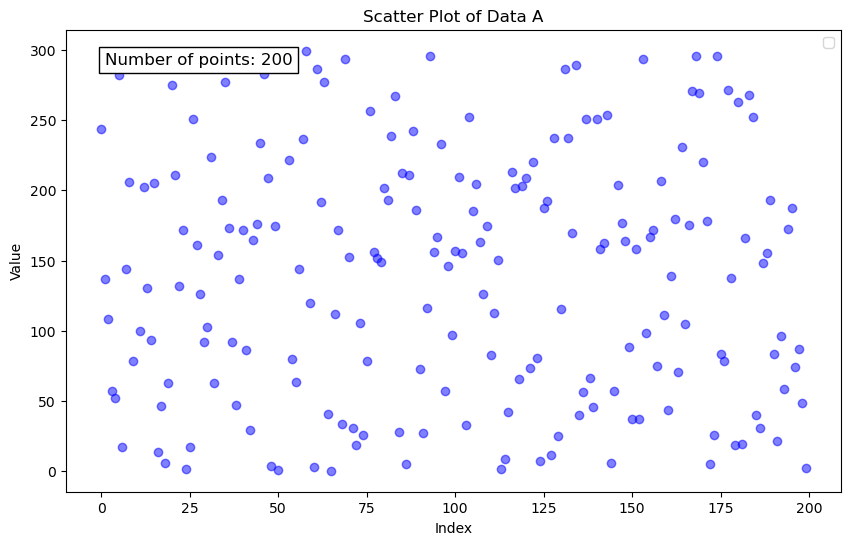

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


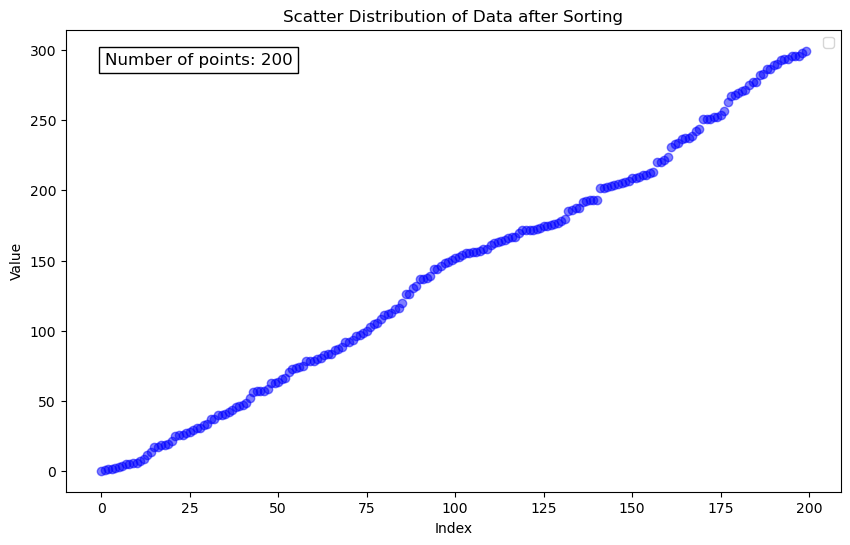

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0005404085687985514, 0.5832936115960375, 0.0003769127809737233, 0.0004612546002146834, 0.0005781318000047762, 0.0004554336714702272, 0.00046559468655817213, 0.00046346860788042365, 0.000359417645240421, 0.0004560427144519503]
Error u of fuhe active learning(LHS sampling): 5.874503e-02
[0.00016636399100755607, 0.14269951128257555, 0.00013463316384829384, 0.00014014324703774106, 0.00020227162584984787, 0.00014010926190633199, 0.00014213215704430207, 0.0001408187124177957, 0.00011619145977773075, 0.00013814244099106553]
MAE of fuhe active learning(LHS sampling): 1.440203e-02
[6.061466828965082e-08, 0.06852797010923534, 3.508431696039539e-08, 4.4362922598300604e-08, 7.264446228079572e-08, 4.346081052447406e-08, 4.510998541139376e-08, 4.485605079928521e-08, 2.821847873032145e-08, 4.355626014953255e-08]
MSE of fuhe active learning(LHS sampling): 6.852839e-03
[7.9138656e-05, 11.244981, 0.00035859682, 4.991825e-05, 0.005084731, 7.904517e-05, 0.0025840327, 0.000107400614, 0.071659155, 0.0002

/tmp/ipykernel_1414512/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0005404085687985514, 0.5832936115960375, 0.0003769127809737233, 0.0004612546002146834, 0.0005781318000047762, 0.0004554336714702272, 0.00046559468655817213, 0.00046346860788042365, 0.000359417645240421, 0.0004560427144519503]
mean Error u: 5.874503e-02
Variance Error u: 3.057236e-02


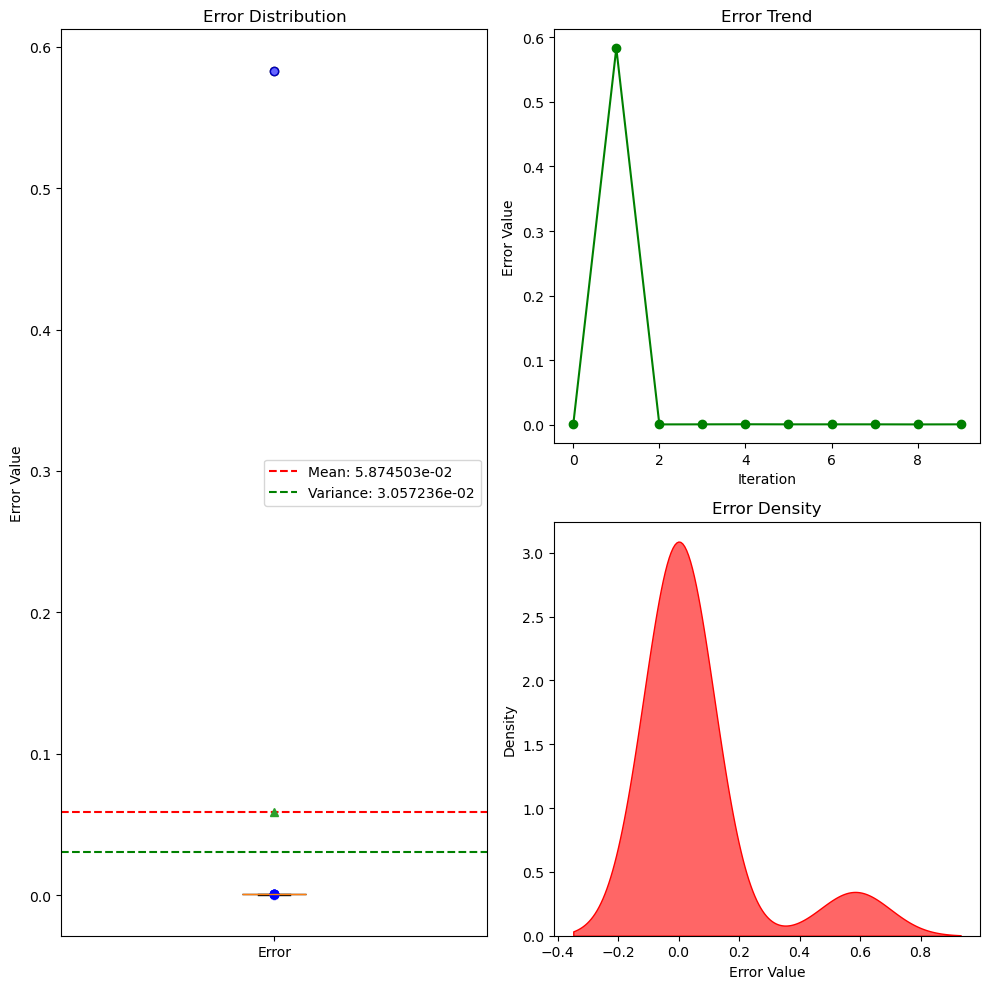

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00016636399100755607, 0.14269951128257555, 0.00013463316384829384, 0.00014014324703774106, 0.00020227162584984787, 0.00014010926190633199, 0.00014213215704430207, 0.0001408187124177957, 0.00011619145977773075, 0.00013814244099106553]
mean MAE: 1.440203e-02
Variance MAE: 1.828916e-03


/tmp/ipykernel_1414512/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


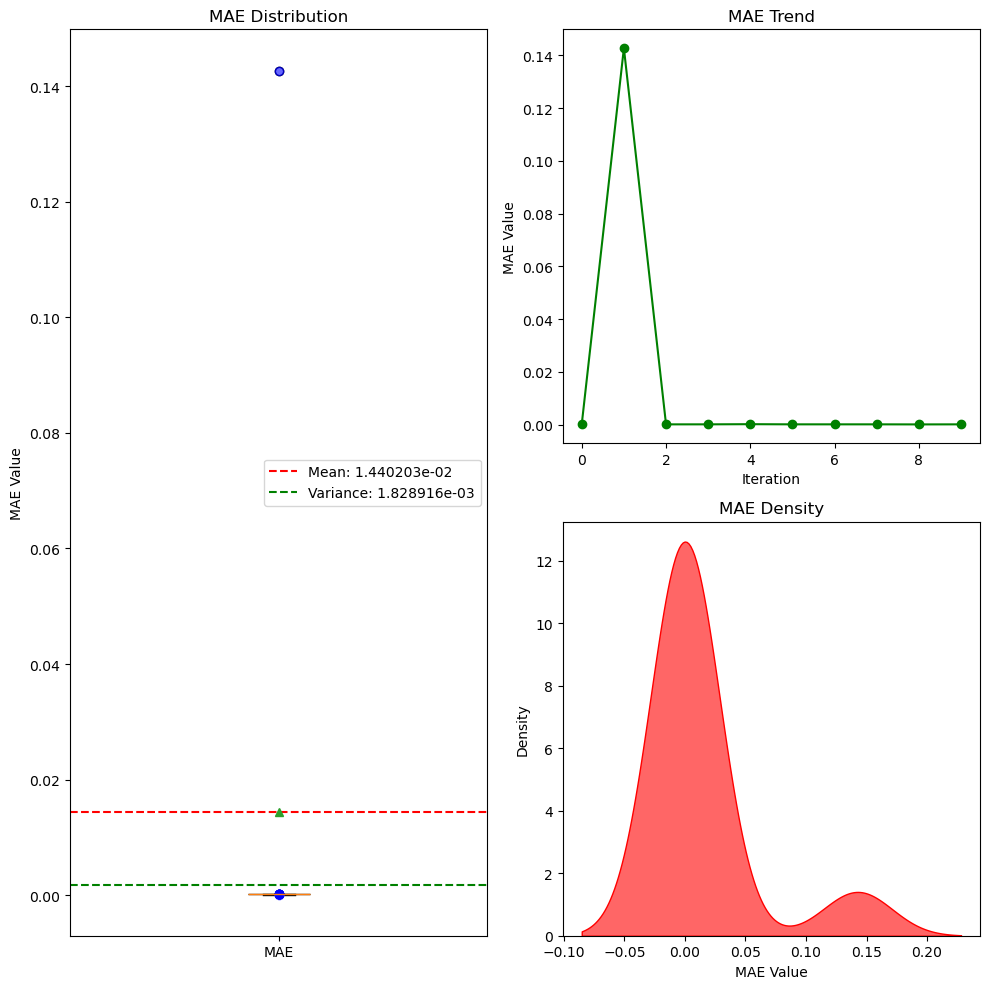

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[6.061466828965082e-08, 0.06852797010923534, 3.508431696039539e-08, 4.4362922598300604e-08, 7.264446228079572e-08, 4.346081052447406e-08, 4.510998541139376e-08, 4.485605079928521e-08, 2.821847873032145e-08, 4.355626014953255e-08]
mean MSE: 6.852839e-03
Variance MSE: 4.226469e-04


/tmp/ipykernel_1414512/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


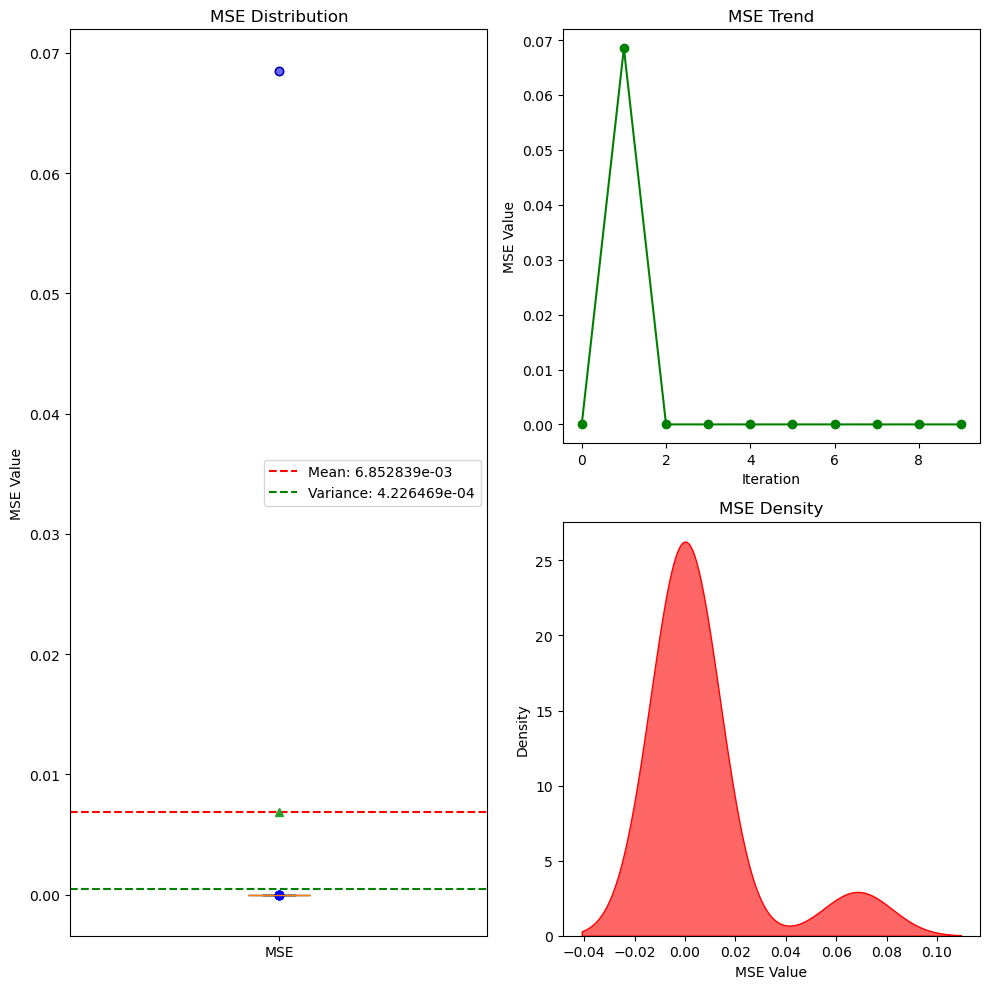

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[7.9138656e-05, 11.244981, 0.00035859682, 4.991825e-05, 0.005084731, 7.904517e-05, 0.0025840327, 0.000107400614, 0.071659155, 0.00027331407]
mean CHAOS: 1.132526e+00
Variance CHAOS: 1.136286e+01


/tmp/ipykernel_1414512/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


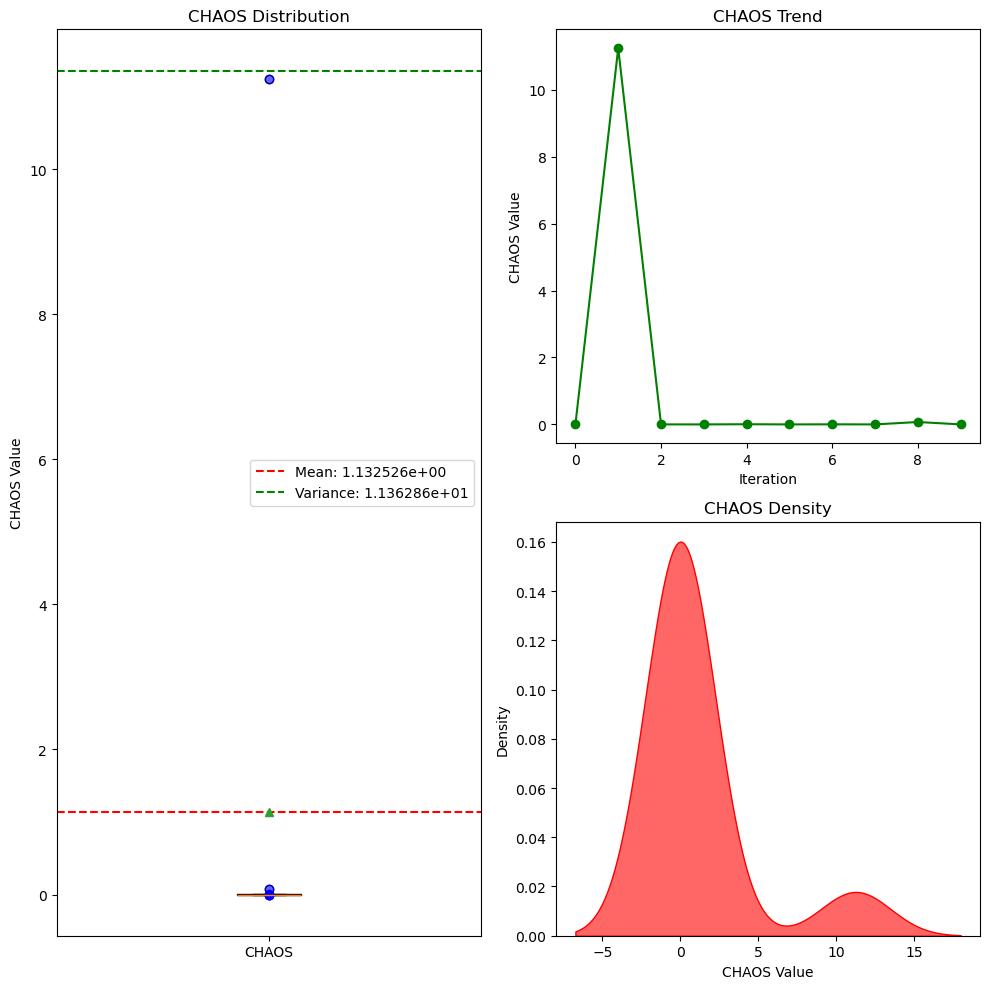

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.3879277e-07, 3.0493024e-06, 4.2487522e-07, 5.0315316e-07, 5.270049e-07, 4.7173648e-07, 4.354879e-07, 4.2006536e-07, 4.6360765e-07, 4.6199762e-07]
mean RESIDUAL: 7.196023e-07
Variance RESIDUAL: 6.040939e-13


/tmp/ipykernel_1414512/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


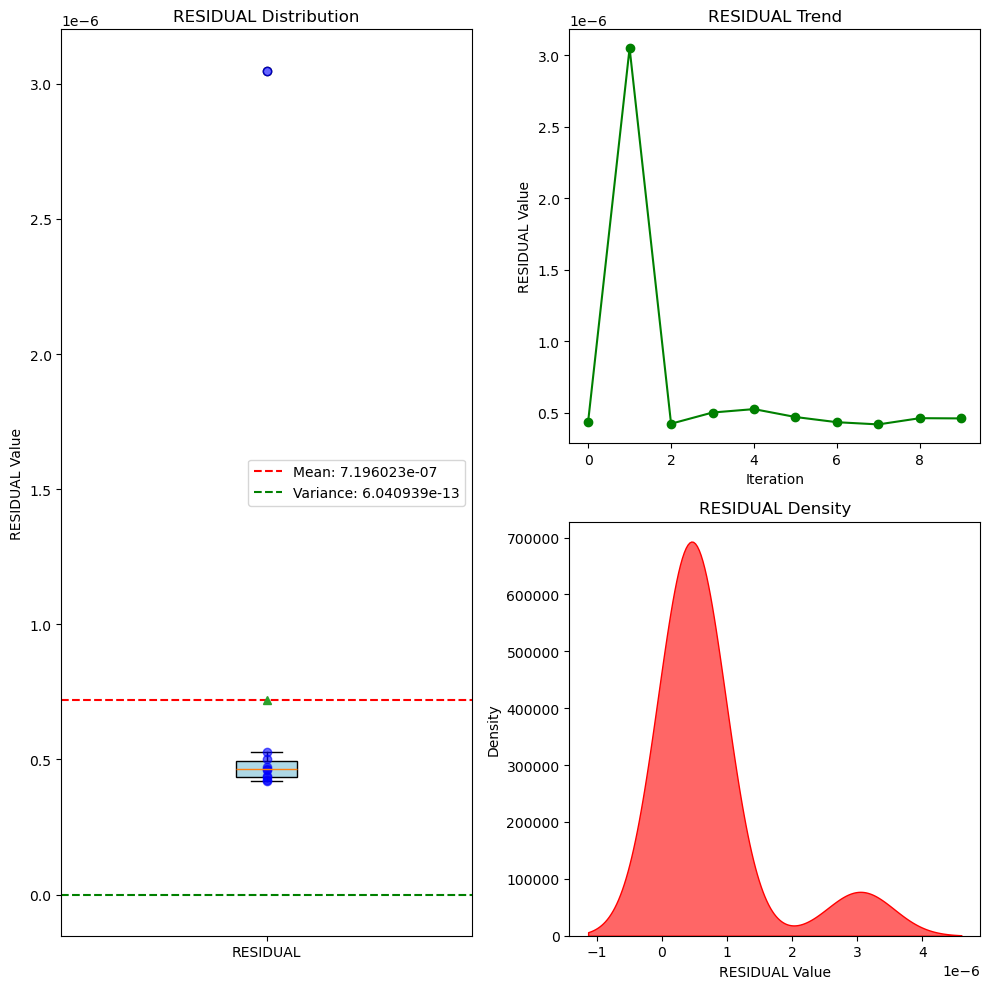

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.8831736e-01 1.5690978e-01 1.2793864e-01 ... 3.2335176e-10 3.2334929e-10
 3.2334424e-10]


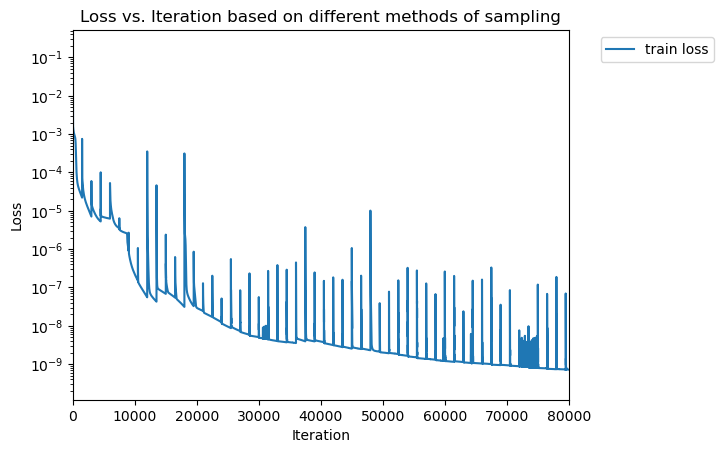

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

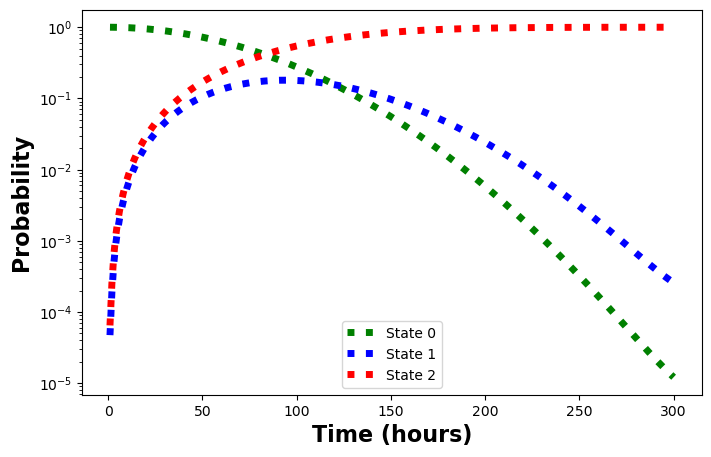

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

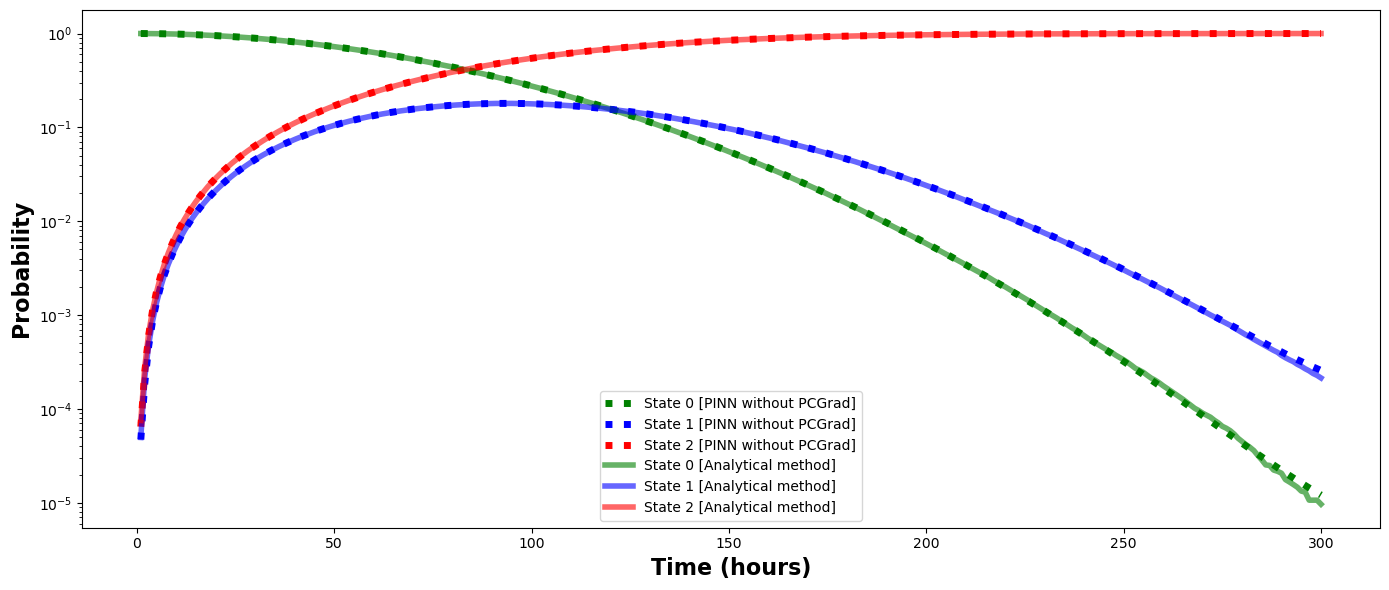

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999888  0.000047  0.000065
1  0.999566  0.000186  0.000247
2  0.998919  0.000469  0.000613
3  0.997986  0.000876  0.001138
4  0.996818  0.001384  0.001798
      state_0   state_1   state_2
295  0.000015  0.000306  0.999679
296  0.000014  0.000293  0.999693
297  0.000014  0.000280  0.999706
298  0.000013  0.000268  0.999719
299  0.000012  0.000257  0.999731


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.00026115501339888427
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.00026115501339888427
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[0.00739811 0.00698131 0.00860972 0.01392789 0.02437657 0.03251667
 0.03859993 0.04288002 0.04448025 0.04395469 0.04234086 0.04055791
 0.0391824  0.03845026 0.03838046 0.03890141 0.03988415 0.04115261
 0.04248573 0.04365624 0.04449212 0.04491593 0.04494998 0.04467522
 0.04419766 0.04362133 0.04302872 0.04247602 0.0420027  0.04162916
 0.04135891 0.04119667 0.04113141 0.04116006 0.04127268 0.04145625
 0.04170007 0.0419927  0.04232306 0.04267468 0.04304148 0.04340906
 0.04376621 0.04410382 0.04441537 0.0446939  0.04493342 0.04513365
 0.04529173 0.04540722 0.04548417 0.04552135 0.04552512 0.04549418
 0.04543998 0.0453601  0.04526163 0.045148   0.04501967 0.04488219
 0.04473815 0.04458963 0.0444372  0.0442878  0.04413553 0.04398657
 0.04383931 0.04369682 0.04355812 0.04342239 0.04329418 0.04316896
 0.04305102 0.04293592 0.04282839 0.04272422 0.04262693 0.04253242
 0.04244281 0.04235938 0.04228038 0.04220463 0.04213424 0.04206815
 0.04200439 0.04194408 0.04188868 0.0418358  0.04178594 0.0417

Text(0.5, 1.0, 'Chaos of x_star')

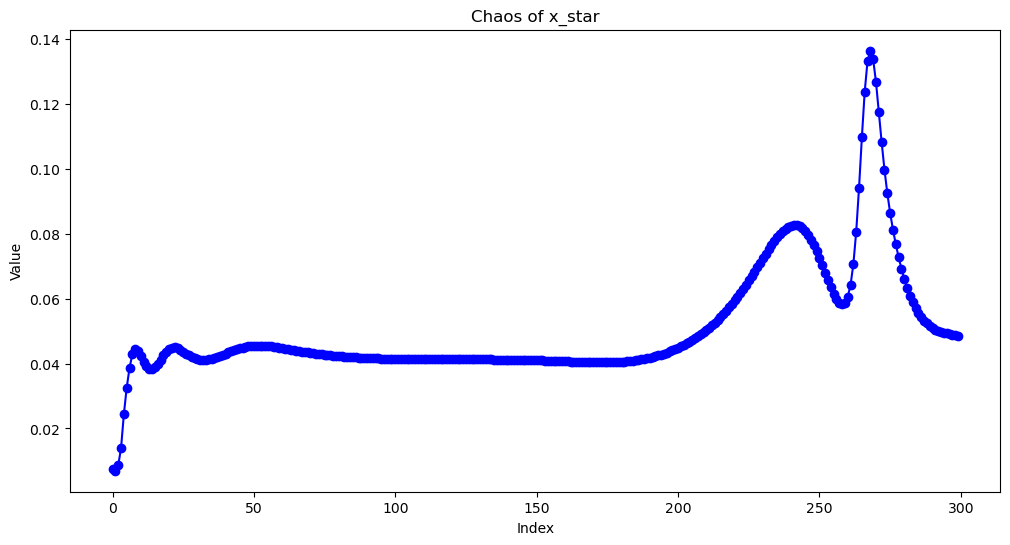

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 5.0509698e-08 -3.0238880e-08  2.1711458e-08  1.7171260e-09
 -1.1292286e-08  1.9208528e-09  1.0884833e-08 -3.1432137e-09
 -1.3969839e-09  6.6356733e-09 -5.5879354e-09  8.4983185e-09
 -3.7252903e-09  1.8626451e-09 -1.0477379e-09 -8.1490725e-10
 -1.1641532e-09  1.8626451e-09  6.9849193e-10  2.0954758e-09
  0.0000000e+00 -2.7939677e-09 -1.8626451e-09  2.7939677e-09
 -3.0267984e-09  9.3132257e-10  1.6298145e-09  2.7939677e-09
  9.3132257e-10 -9.3132257e-10 -1.3969839e-09 -2.3283064e-10
  1.1641532e-09  2.3283064e-10  4.6566129e-10  2.0954758e-09
  0.0000000e+00  0.0000000e+00  1.3969839e-09  0.0000000e+00
  4.6566129e-10 -6.9849193e-10 -2.7939677e-09  1.1641532e-09
 -1.6298145e-09 -4.6566129e-10  6.9849193e-10 -2.3283064e-10
  9.3132257e-10  0.0000000e+00 -6.9849193e-10  2.3283064e-10
 -6.9849193e-10  6.9849193e-10  0.0000000e+00  4.6566129e-10
  4.6566129e-10  1.3969839e-09  9.3132257e-10  2.3283064e-10
  4.6566129e-10  0.0000000e+00  0.0000000e+00 -4.6566129e-10
  9.3132257e-10  0.00000

Text(0.5, 1.0, 'Residual of x_star')

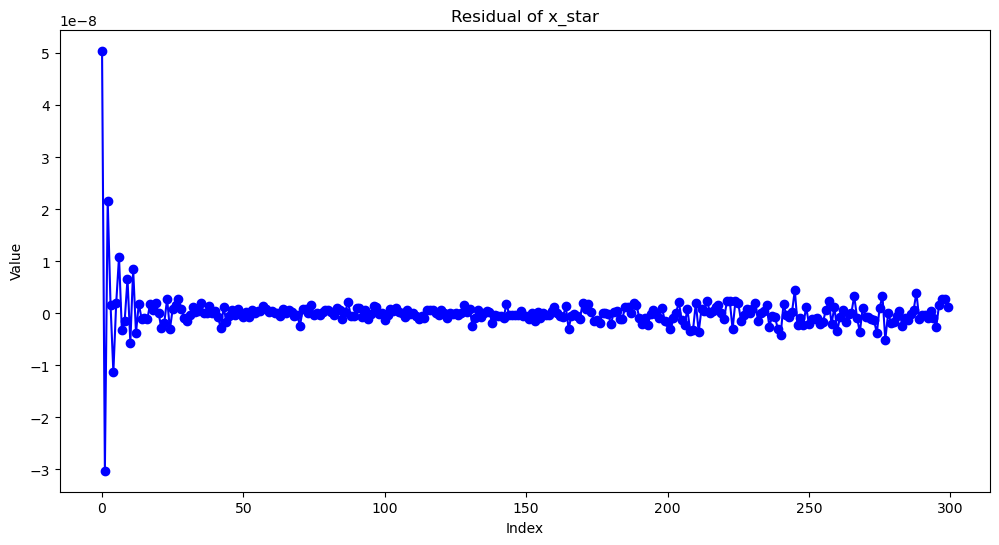

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
